In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import pandas as pd
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from tensorflow.keras import layers, losses, optimizers
import joblib
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import datetime
import pickle
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import chi2
import statsmodels.api as sm
import pylab as py


# A study about the power of Giacomini-White (GW) test in forecast evaluation, with an application to SP500 index dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 0. Download data

In [3]:

# Download data
data = yf.download("^GSPC", start="2015-05-23", end="2023-05-23")
data.reset_index(inplace=True)
data.set_index("Date", inplace=True)


[*********************100%***********************]  1 of 1 completed


In [4]:
data.head(3)

Open         High          Low        Close    Adj Close   
Date                                                                          
2015-05-26  2125.340088  2125.340088  2099.179932  2104.199951  2104.199951  \
2015-05-27  2105.129883  2126.219971  2105.129883  2123.479980  2123.479980   
2015-05-28  2122.270020  2122.270020  2112.860107  2120.790039  2120.790039   

                Volume  
Date                    
2015-05-26  3342130000  
2015-05-27  3127960000  
2015-05-28  2980350000

In [5]:
data.shape

(2013, 6)

In [6]:
# Get date and close colums from data
df_ori = data.loc[:, ["Close"]]


In [7]:
df_ori

Close
Date                   
2015-05-26  2104.199951
2015-05-27  2123.479980
2015-05-28  2120.790039
2015-05-29  2107.389893
2015-06-01  2111.729980
...                 ...
2023-05-16  4109.899902
2023-05-17  4158.770020
2023-05-18  4198.049805
2023-05-19  4191.979980
2023-05-22  4192.629883

[2013 rows x 1 columns]

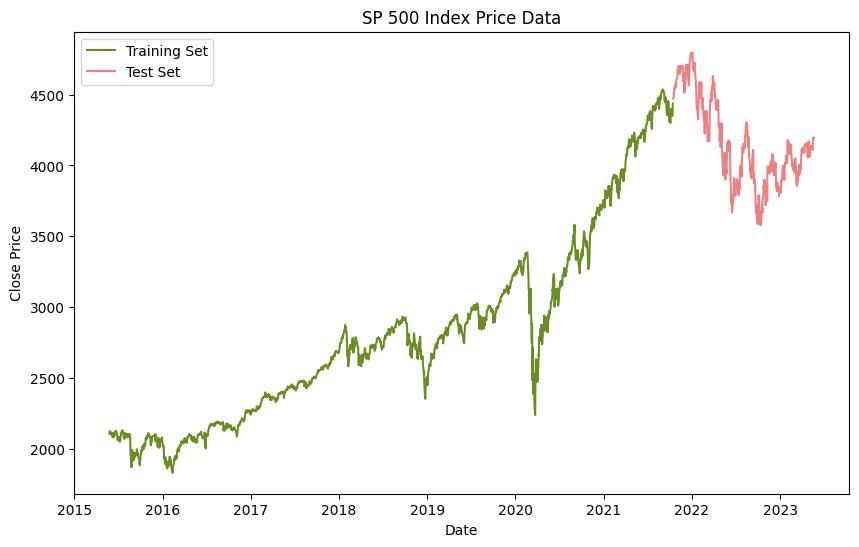

In [8]:

# Assuming 'data' is your DataFrame with a DateTimeIndex
# If not, convert the index to DateTimeIndex if necessary
df_ori.index = pd.to_datetime(df_ori.index)

# Calculate the index to split the data (80% for training)
split_date = df_ori.index[int(0.8 * len(df_ori))]

# Split the data into two parts
training_data_plot = df_ori.loc[df_ori.index <= split_date]
test_data_plot= df_ori.loc[df_ori.index > split_date]

# Plot the training data in blue and test data in red
plt.figure(figsize=(10, 6))
plt.plot(training_data_plot.index, training_data_plot["Close"], color='olivedrab', label='Training Set')
plt.plot(test_data_plot.index, test_data_plot["Close"], color='lightcoral', label='Test Set')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SP 500 Index Price Data')
plt.legend()

# Show the plot
plt.show()


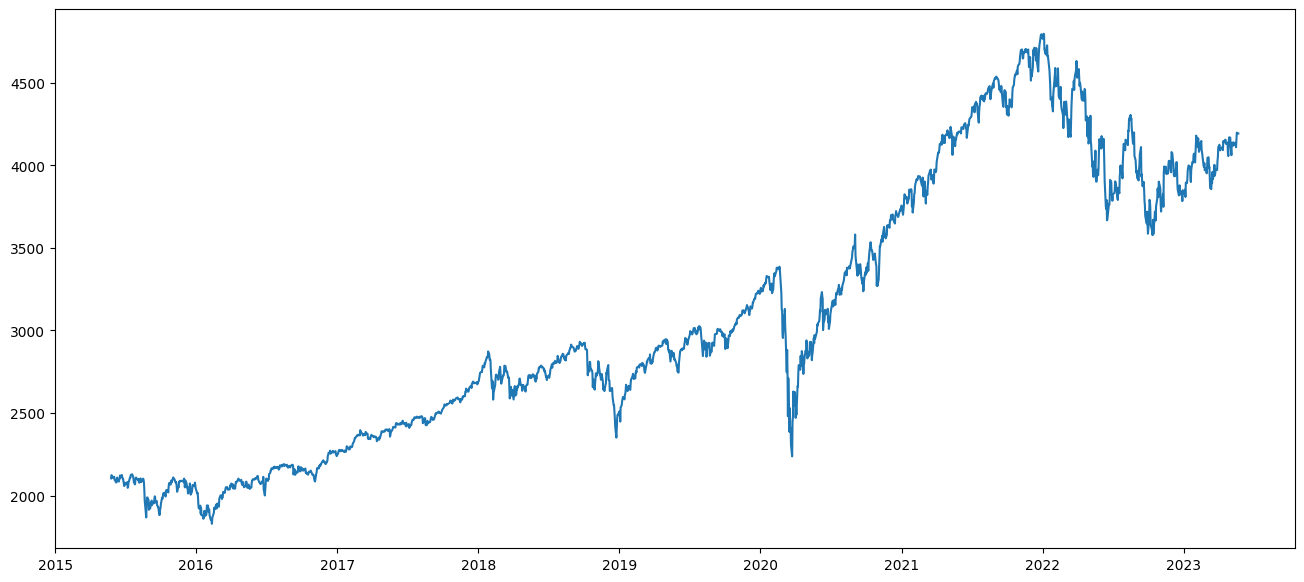

In [9]:
plt.figure(figsize=(16,7))

plt.plot(data.loc[:, "Close"])

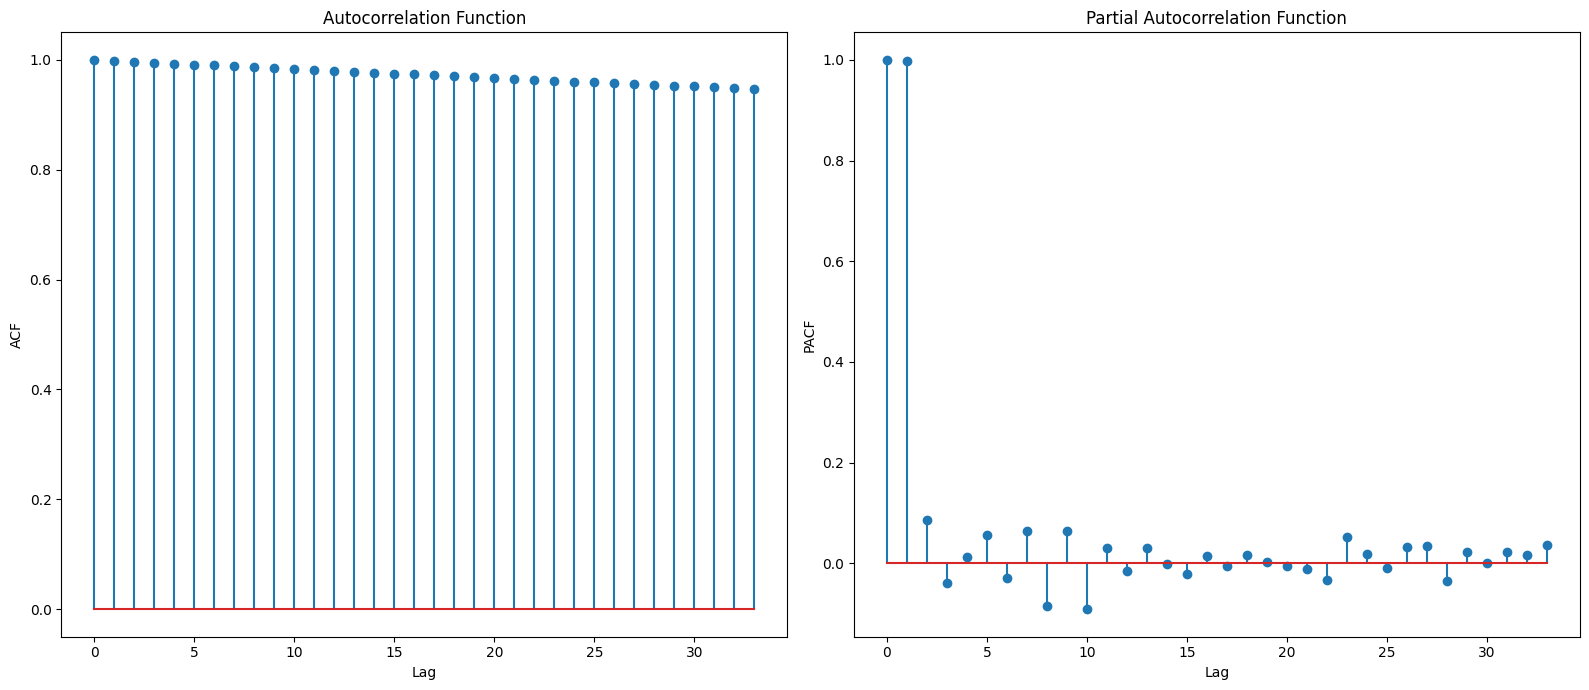

In [10]:

# Compute ACF and PACF
acf = sm.tsa.stattools.acf(df_ori)
pacf = sm.tsa.stattools.pacf(df_ori)

# Plot ACF
plt.figure(figsize=(16,7))

plt.subplot(1, 2, 1)
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(1, 2, 2)
plt.stem(pacf)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function')

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()


In [11]:
df_ori.shape

(2013, 1)

In [12]:
df_ori["Close"]

Date
2015-05-26    2104.199951
2015-05-27    2123.479980
2015-05-28    2120.790039
2015-05-29    2107.389893
2015-06-01    2111.729980
                 ...     
2023-05-16    4109.899902
2023-05-17    4158.770020
2023-05-18    4198.049805
2023-05-19    4191.979980
2023-05-22    4192.629883
Name: Close, Length: 2013, dtype: float64

### 1. Lag data

In [13]:
# Lag data
def lag_transform(x, k=1):
    lagged = np.concatenate([np.repeat(np.nan, k), x[:len(x)-k]])
    df = pd.DataFrame({'x-'+str(k): lagged, 'x': x})
    df.fillna(0, inplace=True)
    return df

In [14]:
df=lag_transform(data["Close"],1)

In [15]:
df= df.rename(columns={"x-1": "x","x":"y"})


In [16]:
df.head(5)

x            y
Date                                
2015-05-26     0.000000  2104.199951
2015-05-27  2104.199951  2123.479980
2015-05-28  2123.479980  2120.790039
2015-05-29  2120.790039  2107.389893
2015-06-01  2107.389893  2111.729980

In [17]:
# Split data 
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)


In [18]:
train_data.shape

(1610, 2)

In [19]:
test_data.shape

(403, 2)

In [20]:
train_predictor = train_data["x"]
train_target=train_data["y"]
test_predictor=test_data["x"]
test_target=test_data["y"]

In [21]:
test_data

x            y
Date                                
2021-10-14  4363.799805  4438.259766
2021-10-15  4438.259766  4471.370117
2021-10-18  4471.370117  4486.459961
2021-10-19  4486.459961  4519.629883
2021-10-20  4519.629883  4536.189941
...                 ...          ...
2023-05-16  4136.279785  4109.899902
2023-05-17  4109.899902  4158.770020
2023-05-18  4158.770020  4198.049805
2023-05-19  4198.049805  4191.979980
2023-05-22  4191.979980  4192.629883

[403 rows x 2 columns]

In [22]:
test_data.index

DatetimeIndex(['2021-10-14', '2021-10-15', '2021-10-18', '2021-10-19',
               '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-25',
               '2021-10-26', '2021-10-27',
               ...
               '2023-05-09', '2023-05-10', '2023-05-11', '2023-05-12',
               '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-18',
               '2023-05-19', '2023-05-22'],
              dtype='datetime64[ns]', name='Date', length=403, freq=None)

In [23]:
train_predictor

Date
2015-05-26       0.000000
2015-05-27    2104.199951
2015-05-28    2123.479980
2015-05-29    2120.790039
2015-06-01    2107.389893
                 ...     
2021-10-07    4363.549805
2021-10-08    4399.759766
2021-10-11    4391.339844
2021-10-12    4361.189941
2021-10-13    4350.649902
Name: x, Length: 1610, dtype: float64

### 4. Reshape data to windown size =5 and timestep=1

In [24]:
# Reshape input data [batch size, timestep, feature=1] and output
def dataset_generator_lstm(dataset, look_back=5):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)



In [25]:
train_predictor, train_target = dataset_generator_lstm(train_data.values,look_back=5)

test_predictor, test_target = dataset_generator_lstm(test_data.values,look_back=5)

print("trainX: ", train_predictor.shape)
print("trainY: ", train_target.shape)
print("testX: ", test_predictor.shape)
print("testY", test_target.shape)

trainX:  (1605, 5)
trainY:  (1605,)
testX:  (398, 5)
testY (398,)


In [26]:
test_data

x            y
Date                                
2021-10-14  4363.799805  4438.259766
2021-10-15  4438.259766  4471.370117
2021-10-18  4471.370117  4486.459961
2021-10-19  4486.459961  4519.629883
2021-10-20  4519.629883  4536.189941
...                 ...          ...
2023-05-16  4136.279785  4109.899902
2023-05-17  4109.899902  4158.770020
2023-05-18  4158.770020  4198.049805
2023-05-19  4198.049805  4191.979980
2023-05-22  4191.979980  4192.629883

[403 rows x 2 columns]

In [27]:
test_predictor

array([[4363.79980469, 4438.25976562, 4471.37011719, 4486.45996094,
        4519.62988281],
       [4438.25976562, 4471.37011719, 4486.45996094, 4519.62988281,
        4536.18994141],
       [4471.37011719, 4486.45996094, 4519.62988281, 4536.18994141,
        4549.77978516],
       ...,
       [4137.64013672, 4130.62011719, 4124.08007812, 4136.27978516,
        4109.89990234],
       [4130.62011719, 4124.08007812, 4136.27978516, 4109.89990234,
        4158.77001953],
       [4124.08007812, 4136.27978516, 4109.89990234, 4158.77001953,
        4198.04980469]])

In [28]:
test_predictor.shape

(398, 5)

In [29]:
test_predictor

array([[4363.79980469, 4438.25976562, 4471.37011719, 4486.45996094,
        4519.62988281],
       [4438.25976562, 4471.37011719, 4486.45996094, 4519.62988281,
        4536.18994141],
       [4471.37011719, 4486.45996094, 4519.62988281, 4536.18994141,
        4549.77978516],
       ...,
       [4137.64013672, 4130.62011719, 4124.08007812, 4136.27978516,
        4109.89990234],
       [4130.62011719, 4124.08007812, 4136.27978516, 4109.89990234,
        4158.77001953],
       [4124.08007812, 4136.27978516, 4109.89990234, 4158.77001953,
        4198.04980469]])

In [30]:
test_target

array([4536.18994141, 4549.77978516, 4544.89990234, 4566.47998047,
       4574.79003906, 4551.68017578, 4596.41992188, 4605.37988281,
       4613.66992188, 4630.64990234, 4660.56982422, 4680.06005859,
       4697.52978516, 4701.70019531, 4685.25      , 4646.70996094,
       4649.27001953, 4682.85009766, 4682.79980469, 4700.89990234,
       4688.66992188, 4704.54003906, 4697.95996094, 4682.93994141,
       4690.70019531, 4701.45996094, 4594.62011719, 4655.27001953,
       4567.        , 4513.04003906, 4577.10009766, 4538.43017578,
       4591.66992188, 4686.75      , 4701.20996094, 4667.45019531,
       4712.02001953, 4668.97021484, 4634.08984375, 4709.85009766,
       4668.66992188, 4620.64013672, 4568.02001953, 4649.22998047,
       4696.56005859, 4725.79003906, 4791.18994141, 4786.35009766,
       4793.06005859, 4778.72998047, 4766.18017578, 4796.56005859,
       4793.54003906, 4700.58007812, 4696.04980469, 4677.02978516,
       4670.29003906, 4713.06982422, 4726.35009766, 4659.02978

In [31]:
train_predictor

array([[   0.        , 2104.19995117, 2123.47998047, 2120.79003906,
        2107.38989258],
       [2104.19995117, 2123.47998047, 2120.79003906, 2107.38989258,
        2111.72998047],
       [2123.47998047, 2120.79003906, 2107.38989258, 2111.72998047,
        2109.60009766],
       ...,
       [4357.04003906, 4300.45996094, 4345.72021484, 4363.54980469,
        4399.75976562],
       [4300.45996094, 4345.72021484, 4363.54980469, 4399.75976562,
        4391.33984375],
       [4345.72021484, 4363.54980469, 4399.75976562, 4391.33984375,
        4361.18994141]])

In [32]:
train_target

array([2111.72998047, 2109.60009766, 2114.07006836, ..., 4391.33984375,
       4361.18994141, 4350.64990234])

In [33]:
train_data

x            y
Date                                
2015-05-26     0.000000  2104.199951
2015-05-27  2104.199951  2123.479980
2015-05-28  2123.479980  2120.790039
2015-05-29  2120.790039  2107.389893
2015-06-01  2107.389893  2111.729980
...                 ...          ...
2021-10-07  4363.549805  4399.759766
2021-10-08  4399.759766  4391.339844
2021-10-11  4391.339844  4361.189941
2021-10-12  4361.189941  4350.649902
2021-10-13  4350.649902  4363.799805

[1610 rows x 2 columns]

### 2. Grid Search CV and LSTM

In [34]:
train_predictor_reshape = np.reshape(train_predictor ,(train_predictor.shape[0], 5, 1))
test_predictor_reshape=np.reshape(test_predictor, (test_predictor.shape[0], 5, 1))

In [35]:
test_predictor_reshape.shape

(398, 5, 1)

In [36]:
patience = 10  # Number of epochs with no improvement after which training will be stopped
monitor = 'val_loss'  # Metric to monitor for early stopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)

In [37]:
""" # Define a function to create the LSTM model
def LSTM_model(neurons_per_layer, activation='relu', optimizer='adam', dropout=0.0, num_layers=1, time_steps=5,batch_size=2):
    
    model = Sequential()
    if num_layers == 1:
        model.add(LSTM(units=neurons_per_layer, activation=activation, batch_input_shape=(batch_size,time_steps, 1)))
    else:
        model.add(LSTM(units=neurons_per_layer, activation=activation, return_sequences=True,  batch_input_shape=(batch_size,time_steps, 1)))
        for i in range(num_layers-2):
            model.add(LSTM(units=neurons_per_layer, activation=activation, return_sequences=True))
        model.add(LSTM(units=neurons_per_layer, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model


# Create a KerasRegressor object with the create_model function
model = KerasRegressor(build_fn=LSTM_model, verbose=0) """

" # Define a function to create the LSTM model\ndef LSTM_model(neurons_per_layer, activation='relu', optimizer='adam', dropout=0.0, num_layers=1, time_steps=5,batch_size=2):\n    \n    model = Sequential()\n    if num_layers == 1:\n        model.add(LSTM(units=neurons_per_layer, activation=activation, batch_input_shape=(batch_size,time_steps, 1)))\n    else:\n        model.add(LSTM(units=neurons_per_layer, activation=activation, return_sequences=True,  batch_input_shape=(batch_size,time_steps, 1)))\n        for i in range(num_layers-2):\n            model.add(LSTM(units=neurons_per_layer, activation=activation, return_sequences=True))\n        model.add(LSTM(units=neurons_per_layer, activation=activation))\n    model.add(Dropout(dropout))\n    model.add(Dense(1))\n    model.compile(loss='mean_absolute_error', optimizer=optimizer)\n    return model\n\n\n# Create a KerasRegressor object with the create_model function\nmodel = KerasRegressor(build_fn=LSTM_model, verbose=0) "

In [38]:
""" # Define the hyperparameter grid
param_grid = {
    'neurons_per_layer': [32,50,100],
    'num_layers': [1, 2,3],
    'batch_size': [4,16,32],
    'dropout': [0.0, 0.1,0.2],
}
# Create a GridSearchCV object with the model and hyperparameter grid
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1,scoring="neg_mean_absolute_error")

# Reshape the data for each combination of batch_size and time_steps
#for batch_size in param_grid['batch_size']:
    #for time_steps in param_grid['time_steps']:

start_time = time.time()

grid.fit(train_predictor_reshape, train_target,validation_data=(test_predictor_reshape,test_target),
                            epochs=150,callbacks=[early_stopping],verbose=0)

end_time = time.time()

# Print the best set of hyperparameters
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Execution time: ", end_time - start_time, " seconds") """

' # Define the hyperparameter grid\nparam_grid = {\n    \'neurons_per_layer\': [32,50,100],\n    \'num_layers\': [1, 2,3],\n    \'batch_size\': [4,16,32],\n    \'dropout\': [0.0, 0.1,0.2],\n}\n# Create a GridSearchCV object with the model and hyperparameter grid\ngrid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1,scoring="neg_mean_absolute_error")\n\n# Reshape the data for each combination of batch_size and time_steps\n#for batch_size in param_grid[\'batch_size\']:\n    #for time_steps in param_grid[\'time_steps\']:\n\nstart_time = time.time()\n\ngrid.fit(train_predictor_reshape, train_target,validation_data=(test_predictor_reshape,test_target),\n                            epochs=150,callbacks=[early_stopping],verbose=0)\n\nend_time = time.time()\n\n# Print the best set of hyperparameters\nprint("Best: %f using %s" % (grid.best_score_, grid.best_params_))\nprint("Execution time: ", end_time - start_time, " seconds") '

In [39]:
""" grid_loaded = joblib.load('grid_search.pkl')
 """

" grid_loaded = joblib.load('grid_search.pkl')\n "

In [40]:
""" cv_results = grid_loaded .cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(mean_score, params) """

' cv_results = grid_loaded .cv_results_\nfor mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):\n    print(mean_score, params) '

In [41]:
""" best_model = grid_loaded .best_estimator_.model
 """

' best_model = grid_loaded .best_estimator_.model\n '

In [42]:
LSTM_model = tf.keras.Sequential([
    layers.LSTM(units=50, activation='relu', batch_input_shape=(4, 5, 1)),
    layers.Dense(1)
], name="LSTM_model")


In [43]:
LSTM_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae']) 

In [44]:
""" history_lstm = LSTM_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          batch_size=4, epochs=150, callbacks=[early_stopping]) """

' history_lstm = LSTM_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),\n                          batch_size=4, epochs=150, callbacks=[early_stopping]) '

In [45]:
# Load the saved history object from a file
with open('history_lstm.pkl', 'rb') as file:
    history_lstm = pickle.load(file)


In [46]:
LSTM_model.load_weights("./Modelfit/LSTM")

In [47]:
lossLSTM,maeLSTM= LSTM_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 0s 2ms/step - loss: 50.5501 - mae: 50.5501


In [48]:
lossLSTMtrain,maeLSTMtrain= LSTM_model.evaluate(train_predictor_reshape,train_target)

51/51 [==============================] - 0s 1ms/step - loss: 22.3237 - mae: 22.3237


In [49]:
test_target_pred = LSTM_model.predict(test_predictor_reshape)
train_target_pred=LSTM_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 1ms/step


In [50]:
#loss_values_LSTM = []
#for i in range(len(test_target)):
    #loss = LSTM_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    #loss_values_LSTM.append(loss)

In [51]:
#np.save('loss_values_LSTM.npy', loss_values_LSTM)


In [52]:
loss_values_LSTM = np.load('loss_values_LSTM.npy')


### 3. Plot time series

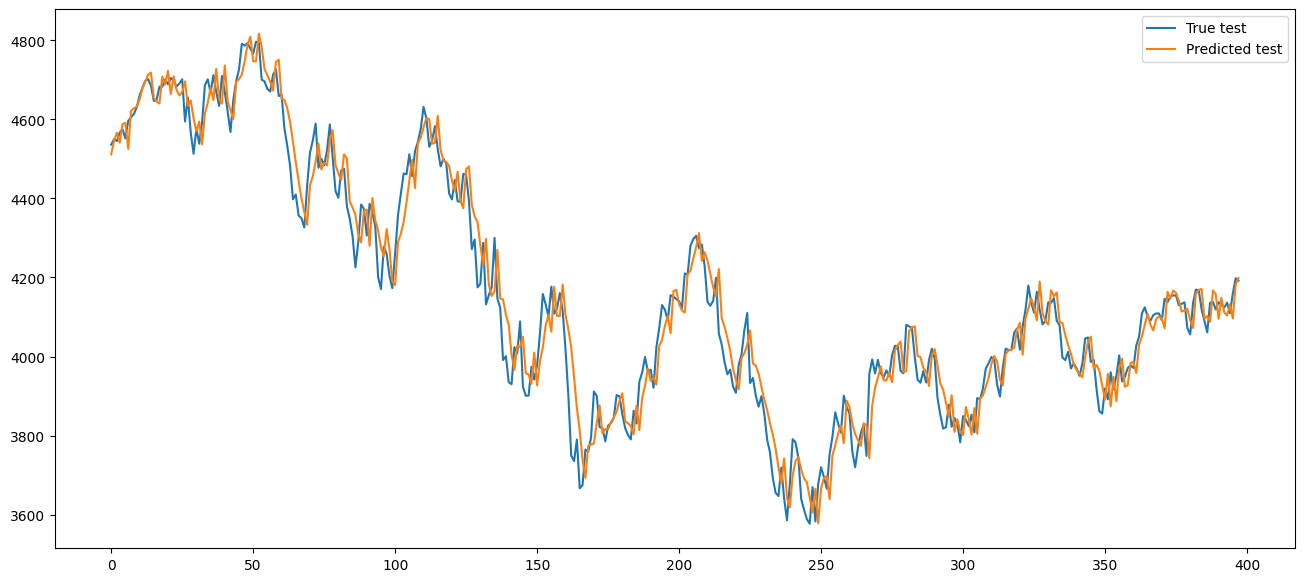

In [53]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test')
plt.plot(test_target_pred, label='Predicted test')


plt.legend()
plt.show()

In [54]:
mae_lstm_test = mean_absolute_error(test_target, test_target_pred)
print('Test MAE: %.3f' % mae_lstm_test)



Test MAE: 50.550


In [55]:
mae_lstm_train = mean_absolute_error(train_target, train_target_pred)
print('Train MAE: %.3f' % mae_lstm_train)




Train MAE: 22.324


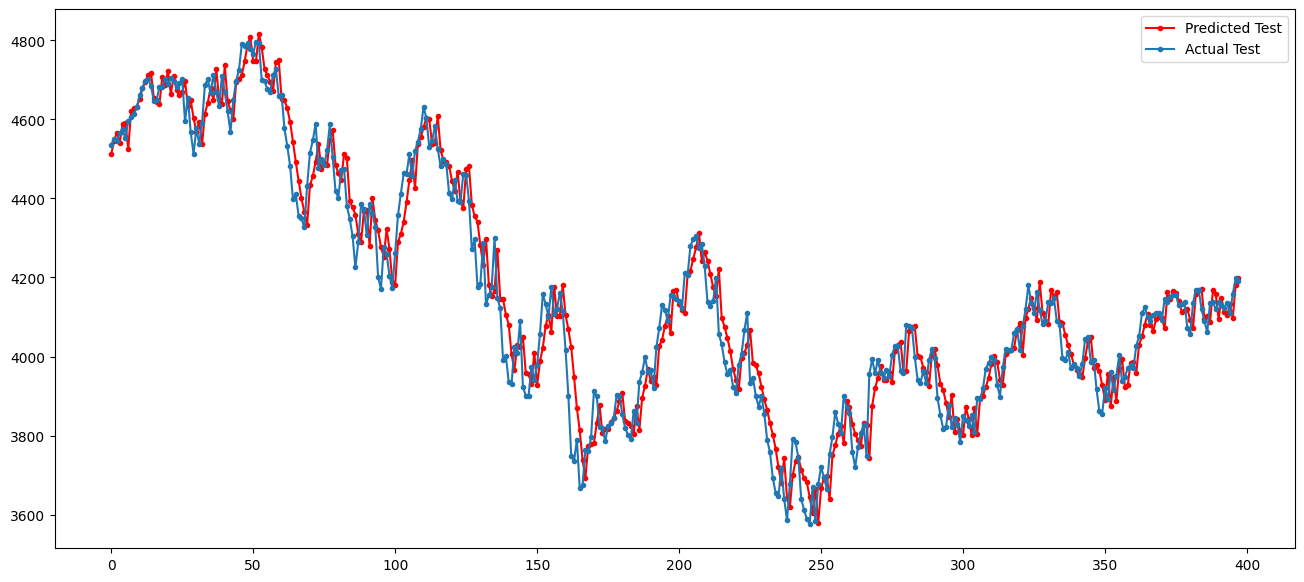

In [56]:
plt.figure(figsize=(16,7))

plt.plot(test_target_pred, 'r', marker='.', label='Predicted Test')

plt.plot(test_target, marker='.', label='Actual Test')

plt.legend()
plt.show()

## 4. Models Fitting

### 4.1. GRU

In [57]:
GRU_model = tf.keras.Sequential([
    layers.GRU(units=50, activation='relu', batch_input_shape=(4, 5, 1)),
    layers.Dense(1)
], name="GRU_model")
GRU_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae'])


In [58]:
#history_gru = GRU_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          #batch_size=4, epochs=150, callbacks=[early_stopping])

In [59]:
GRU_model.load_weights("./Modelfit/GRU")

In [60]:
lossGRU,maeGRU=GRU_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 0s 1ms/step - loss: 51.4286 - mae: 51.4286


In [61]:
GRU_model.evaluate(test_predictor_reshape,test_target)[1]

13/13 [==============================] - 0s 1ms/step - loss: 51.4286 - mae: 51.4286


51.42856216430664

In [62]:
test_target_pred_gru = GRU_model.predict(test_predictor_reshape)
train_target_pred_gru=GRU_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 1ms/step


In [63]:
#loss_values_GRU = []
#for i in range(len(test_target)):
    #loss = GRU_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    #loss_values_GRU.append(loss)


In [64]:
#np.save('loss_values_GRU.npy', loss_values_GRU)


In [65]:
loss_values_GRU = np.load('loss_values_GRU.npy')


In [66]:
loss_values_GRU

array([ 31.21972656,  20.04541016,   3.27734375,  10.39306641,
         6.8125    ,  27.46533203,  20.78466797,  15.92626953,
         8.26953125,  13.27197266,  29.3984375 ,  27.54589844,
        23.72460938,   8.07080078,  21.59130859,  59.78710938,
        38.30712891,  11.13134766,   0.69873047,  10.83935547,
        13.24511719,   0.63818359,  13.81494141,  30.640625  ,
        16.62792969,   3.90917969, 115.52685547,  13.58837891,
        28.22949219, 115.41796875,  39.20458984,   4.05859375,
        24.31005859, 106.74267578,  66.96826172,  10.69482422,
        25.41259766,  36.54296875,  66.52978516,  33.5390625 ,
        21.65185547,  72.21337891,  99.42382812,  25.72021484,
        94.8671875 ,  56.14355469,  86.81835938,  33.35302734,
        10.453125  ,  19.3203125 ,  33.10253906,   4.46337891,
         5.22509766, 104.0078125 ,  72.14453125,  14.77685547,
        41.72363281,  17.01660156,  19.27783203,  64.83544922,
        42.81347656, 107.72900391, 114.74560547,  53.08

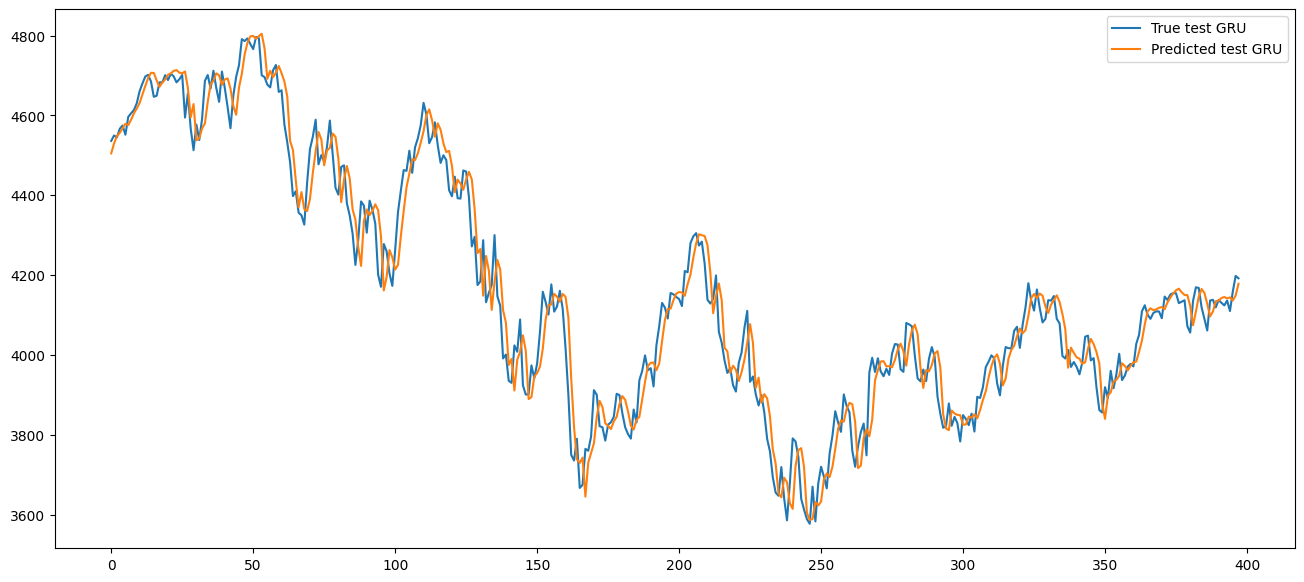

In [67]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test GRU')
plt.plot(test_target_pred_gru, label='Predicted test GRU')

plt.legend()
plt.show()

### 4.2. RNN

In [68]:
RNN_model = tf.keras.Sequential([
    layers.SimpleRNN(units=50, activation='relu', batch_input_shape=(4, 5, 1)),
    layers.Dense(1)
], name="RNN_model")
RNN_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae'])

In [69]:

#history_RNN = RNN_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          #batch_size=4, epochs=500, callbacks=[early_stopping])

In [70]:
RNN_model.load_weights("./Modelfit/RNN")

In [71]:
lossRNN,maeRNN=RNN_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 0s 2ms/step - loss: 44.5153 - mae: 44.5153


In [72]:
test_target_pred_rnn = RNN_model.predict(test_predictor_reshape)
train_target_pred_rnn=RNN_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 1ms/step


In [73]:
#loss_values_RNN = []
#for i in range(len(test_target)):
    #loss = RNN_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    #loss_values_RNN.append(loss)


In [74]:
#np.save('loss_values_RNN.npy', loss_values_RNN)


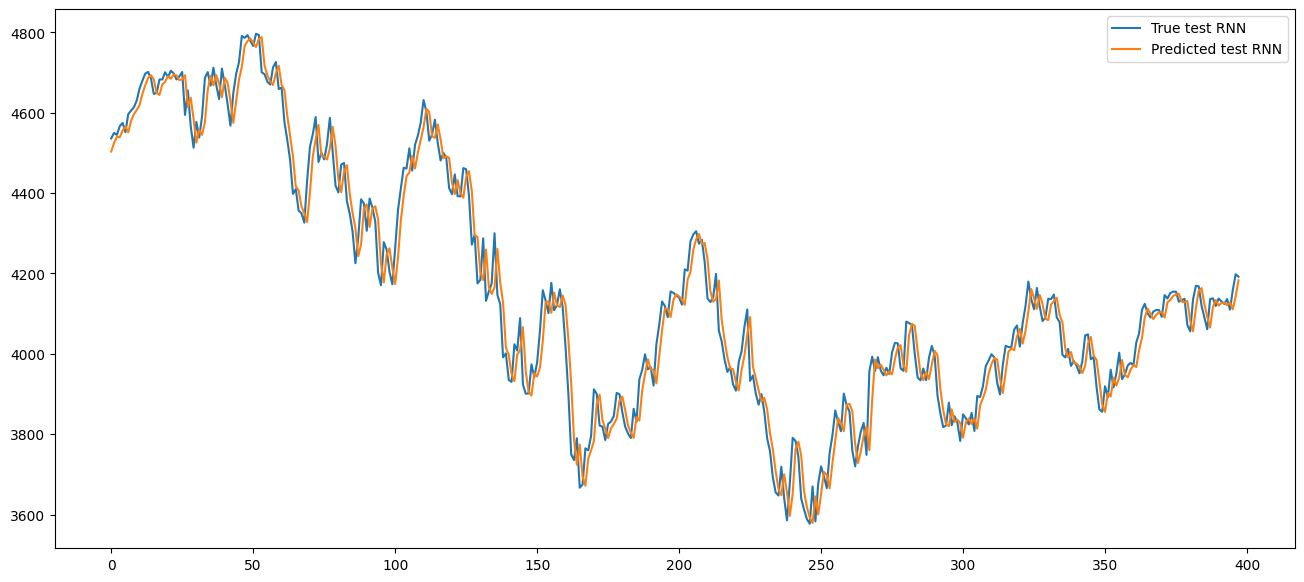

In [75]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test RNN')
plt.plot(test_target_pred_rnn, label='Predicted test RNN')

plt.legend()
plt.show()

In [76]:
loss_values_RNN = np.load('loss_values_RNN.npy')


In [77]:
loss_values_RNN

array([ 32.80664062,  24.94433594,   4.7734375 ,  27.48388672,
        19.57470703,  14.75146484,  44.95800781,  25.36425781,
        16.91552734,  23.84130859,  41.14160156,  33.02197266,
        28.92333984,  15.09716797,   8.19189453,  35.76318359,
         0.63232422,  38.54589844,  12.18408203,  23.77294922,
         2.18652344,  20.04931641,   2.78564453,  10.15625   ,
         9.56298828,  18.34375   ,  98.84619141,  41.13232422,
        70.58642578,  72.43261719,  51.47851562,  19.0234375 ,
        46.57080078, 110.34472656,  43.87402344,  24.23291016,
        43.78808594,  24.72998047,  38.57714844,  71.03955078,
        18.35058594,  53.3359375 ,  60.87060547,  74.3125    ,
        68.36230469,  43.29541016,  76.86132812,  19.96923828,
        14.61767578,   6.37207031,   8.24414062,  32.93798828,
         9.5703125 ,  87.61962891,  21.19775391,  15.96289062,
         7.71337891,  43.84912109,  28.35009766,  57.91650391,
         6.5       ,  79.23583984,  60.40039062,  59.06

### 4.3 BiLSTM

In [78]:
BiLSTM_model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(50, activation='relu', batch_input_shape=(4, 5, 1))),
    layers.Dense(1)
], name="BiLSTM_model")
BiLSTM_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='mean_absolute_error',
                    metrics=['mae'])



In [79]:
#history_BiLSTM = BiLSTM_model.fit(train_predictor_reshape, train_target, validation_data=(test_predictor_reshape, test_target),
                          #batch_size=4, epochs=500, callbacks=[early_stopping])

In [80]:
BiLSTM_model.load_weights("./Modelfit/BiLSTM")

In [81]:
lossBiLSTM,maeBiLSTM=BiLSTM_model.evaluate(test_predictor_reshape,test_target)

13/13 [==============================] - 1s 2ms/step - loss: 57.7497 - mae: 57.7497


In [82]:
test_target_pred_BiLSTM = BiLSTM_model.predict(test_predictor_reshape)
train_target_pred_BiLSTM=BiLSTM_model.predict(train_predictor_reshape)

51/51 [==============================] - 0s 2ms/step


In [83]:
train_target_pred_BiLSTM

array([[1741.3447],
       [2116.336 ],
       [2116.2275],
       ...,
       [4364.7715],
       [4369.5874],
       [4379.8057]], dtype=float32)

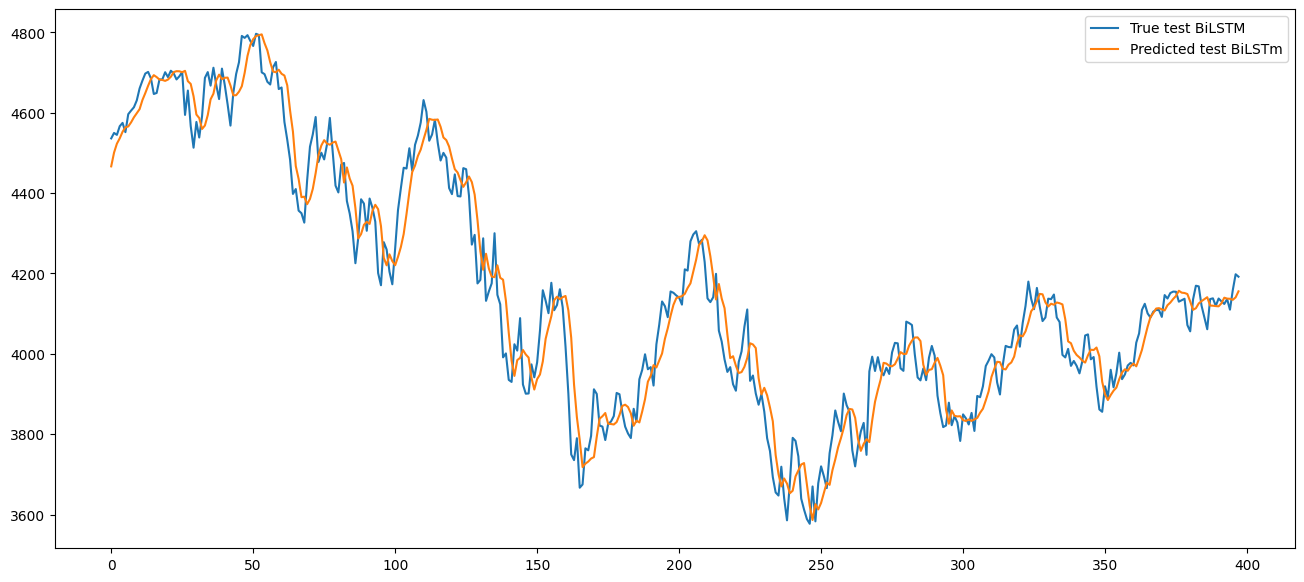

In [84]:
plt.figure(figsize=(16,7))

plt.plot(test_target, label='True test BiLSTM')
plt.plot(test_target_pred_BiLSTM, label='Predicted test BiLSTm')

plt.legend()
plt.show()

In [85]:
#loss_values_BiLSTM = []
#for i in range(len(test_target)):
    #loss = BiLSTM_model.evaluate(test_predictor_reshape[i:i+1], test_target[i:i+1], verbose=0)[0]
    #loss_values_BiLSTM.append(loss)


In [86]:
#np.save('loss_values_BiLSTM.npy', loss_values_BiLSTM)


In [87]:
# Load loss_values_BiLSTM from the saved file
loss_values_BiLSTM = np.load('loss_values_BiLSTM.npy')

In [88]:
loss_values_BiLSTM

array([ 69.60351562,  48.95751953,  21.91552734,  30.11083984,
        22.15429688,  12.01953125,  30.49707031,  29.25585938,
        24.98681641,  31.86914062,  51.54150391,  48.29589844,
        48.63720703,  34.47998047,   1.3125    ,  46.84375   ,
        39.47021484,   0.33349609,   1.15234375,  21.54980469,
         6.00244141,  14.96386719,   3.18212891,  20.55078125,
        12.51318359,   0.49609375, 109.70800781,  23.31152344,
       104.75195312, 127.97509766,  18.43457031,  48.41796875,
        32.01806641, 118.50244141, 107.12060547,  34.06201172,
        64.58007812,  11.83984375,  60.81298828,  26.26611328,
        18.40820312,  66.84912109,  99.79101562,   5.86425781,
        52.87353516,  73.33203125, 125.18847656,  86.9296875 ,
        51.53076172,   9.59667969,  16.93212891,   5.59130859,
         0.45263672,  94.49023438,  77.03564453,  78.07568359,
        55.37158203,  10.22363281,  25.63916016,  48.11865234,
        34.10302734, 115.50048828, 135.41601562, 122.39

### 4.4. ARIMA

In [89]:
train_predictor2 = train_data["x"]
train_target2=train_data["y"]
test_predictor2=test_data["x"]
test_target2=test_data["y"]

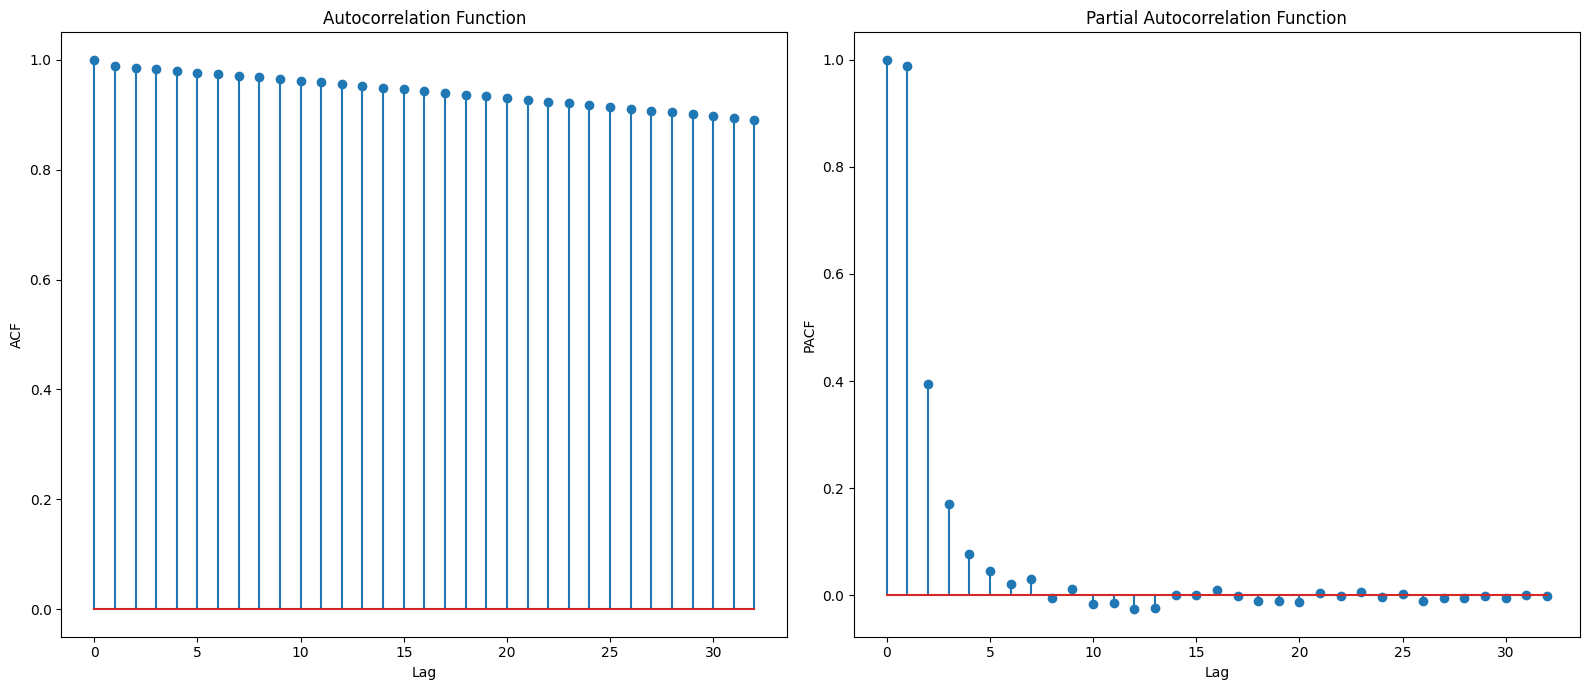

In [90]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Compute ACF and PACF
acf = sm.tsa.stattools.acf(train_predictor2)
pacf = sm.tsa.stattools.pacf(train_predictor2)

# Plot ACF
plt.figure(figsize=(16,7))

plt.subplot(1, 2, 1)
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(1, 2, 2)
plt.stem(pacf)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function')

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()


In [91]:
""" import pmdarima as pm

# Perform auto ARIMA
model = pm.auto_arima(train_predictor2, seasonal=False)

# Fit the model to the data
model.fit(train_predictor2)

# Get the model order
order = model.order

# Print the model order
print("ARIMA Order:", order) """



' import pmdarima as pm\n\n# Perform auto ARIMA\nmodel = pm.auto_arima(train_predictor2, seasonal=False)\n\n# Fit the model to the data\nmodel.fit(train_predictor2)\n\n# Get the model order\norder = model.order\n\n# Print the model order\nprint("ARIMA Order:", order) '

In [92]:
""" from statsmodels.tsa.stattools import adfuller
train_predictor2_diff = train_predictor2.diff().dropna()

# Perform ADF test
result = adfuller(train_predictor2_diff)

# Extract and print the test statistics and p-value
adf_statistic = result[0]
p_value = result[1]
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("The time series is stationary (reject the null hypothesis)")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis)") """


' from statsmodels.tsa.stattools import adfuller\ntrain_predictor2_diff = train_predictor2.diff().dropna()\n\n# Perform ADF test\nresult = adfuller(train_predictor2_diff)\n\n# Extract and print the test statistics and p-value\nadf_statistic = result[0]\np_value = result[1]\nprint("ADF Statistic:", adf_statistic)\nprint("p-value:", p_value)\n\n# Interpret the results\nif p_value < 0.05:\n    print("The time series is stationary (reject the null hypothesis)")\nelse:\n    print("The time series is non-stationary (fail to reject the null hypothesis)") '

In [93]:
""" 
# Define the ARIMA order (p, d, q)
p = 2  # Autoregressive order
d = 1  # Degree of differencing
q = 2 # Moving average order

# Create and fit the ARIMA model
model = ARIMA(train_predictor2, order=(p, d, q))
model_fit = model.fit()

# Generate predictions on the training data
train_predictions_ARIMA = model_fit.predict()

# Generate predictions on the test data
test_predictions_ARIMA = model_fit.predict(start=len(train_target2), end=len(train_target2) + len(test_target2) - 1)

# Print the model summary
print(model_fit.summary()) """


' \n# Define the ARIMA order (p, d, q)\np = 2  # Autoregressive order\nd = 1  # Degree of differencing\nq = 2 # Moving average order\n\n# Create and fit the ARIMA model\nmodel = ARIMA(train_predictor2, order=(p, d, q))\nmodel_fit = model.fit()\n\n# Generate predictions on the training data\ntrain_predictions_ARIMA = model_fit.predict()\n\n# Generate predictions on the test data\ntest_predictions_ARIMA = model_fit.predict(start=len(train_target2), end=len(train_target2) + len(test_target2) - 1)\n\n# Print the model summary\nprint(model_fit.summary()) '

In [94]:
#loss_values_ARIMA=[]
#loss_values_ARIMA= np.abs(test_predictions_ARIMA.values - test_target2.values)


In [95]:
#np.save('loss_values_ARIMA.npy', loss_values_ARIMA)


In [96]:
# Load loss_values_BiLSTM from the saved file
loss_values_ARIMA = np.load('loss_values_ARIMA.npy')

In [97]:
loss_values_ARIMA.shape

(403,)

In [98]:
maeARIMA=np.mean(loss_values_ARIMA)

In [99]:
maeARIMA

315.7567903281135

### Model performance

In [100]:
print("MAE of ARIMA on test set: ", maeARIMA)
print("MAE of RNN on test set: ", maeRNN)
print("MAE of LSTM on test set: ", maeLSTM)
print("MAE of BiBLSTM on test set: ", maeBiLSTM)
print("MAE of GRU on test set: ", maeGRU)



MAE of ARIMA on test set:  315.7567903281135
MAE of RNN on test set:  44.51530075073242
MAE of LSTM on test set:  50.550148010253906
MAE of BiBLSTM on test set:  57.74971008300781
MAE of GRU on test set:  51.42856216430664


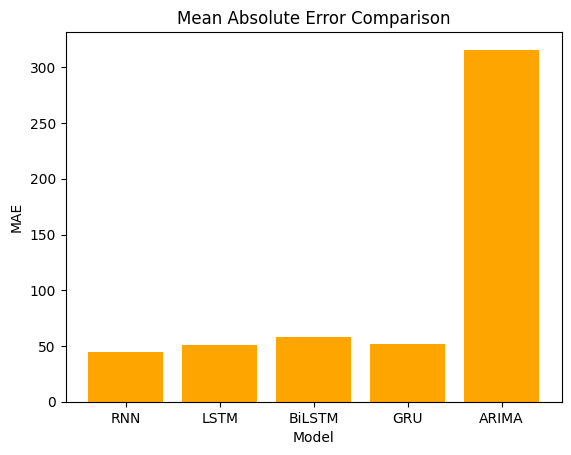

In [101]:

# Define the model names and their respective MAE values
model_names = ['RNN', 'LSTM', 'BiLSTM', 'GRU','ARIMA']
mae_values = [maeRNN, maeLSTM, maeBiLSTM, maeGRU,maeARIMA]

# Create the bar plot with orange color
plt.bar(model_names, mae_values, color='orange')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Comparison')
plt.show()


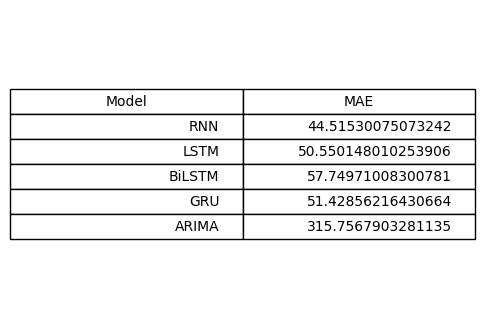

In [102]:

# Create the table of values
table_values = [[model_names[i], mae_values[i]] for i in range(len(model_names))]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Hide the axis
ax.axis('off')

# Create the table
table = ax.table(cellText=table_values, colLabels=['Model', 'MAE'], loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.show()


In [103]:
""" 
plt.figure(figsize=(16,7))

# Plot the lines with different colors and line styles
plt.plot(test_target, label='True test set', color='blue', linestyle='--', linewidth=2)
plt.plot(test_target_pred, label='Predicted test set LSTM', color='red', linestyle='-', linewidth=2)
plt.plot(test_target_pred_BiLSTM, label='Predicted test set BiLSTM', color='green', linestyle='-', linewidth=2)
plt.plot(test_target_pred_rnn, label='Predicted test set RNN', color='orange', linestyle='-', linewidth=2)
plt.plot(test_target_pred_gru, label='Predicted test set GRU', color='purple', linestyle='-', linewidth=2)
#plt.plot(test_predictions, label='Predicted test ARIMA', color='yellow', linestyle='-', linewidth=2)


plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparing True vs. Predicted Test Set Among Models')
plt.legend()
plt.grid(True)
plt.show()
 """

" \nplt.figure(figsize=(16,7))\n\n# Plot the lines with different colors and line styles\nplt.plot(test_target, label='True test set', color='blue', linestyle='--', linewidth=2)\nplt.plot(test_target_pred, label='Predicted test set LSTM', color='red', linestyle='-', linewidth=2)\nplt.plot(test_target_pred_BiLSTM, label='Predicted test set BiLSTM', color='green', linestyle='-', linewidth=2)\nplt.plot(test_target_pred_rnn, label='Predicted test set RNN', color='orange', linestyle='-', linewidth=2)\nplt.plot(test_target_pred_gru, label='Predicted test set GRU', color='purple', linestyle='-', linewidth=2)\n#plt.plot(test_predictions, label='Predicted test ARIMA', color='yellow', linestyle='-', linewidth=2)\n\n\nplt.xlabel('Time')\nplt.ylabel('Value')\nplt.title('Comparing True vs. Predicted Test Set Among Models')\nplt.legend()\nplt.grid(True)\nplt.show()\n "

## 5.1  GW test with $h_{t}=1$

### GW test between GRU and LSTM

In [104]:
time_step=1
m = 5 #m:window size
T= len(test_predictor)
n= T-m-time_step+1


In [105]:
Z_m_fixedGRUvsLSTM=loss_values_GRU-loss_values_LSTM

In [106]:
n

393

In [107]:
Z_m_fixedGRUvsLSTM.shape

(398,)

In [108]:
loss_values_GRU.shape

(398,)

In [109]:
test_target_pred_gru.shape

(398, 1)

In [110]:
Z_m_fixed_barGRUvsLSTM=1/n *sum(Z_m_fixedGRUvsLSTM)

In [111]:
omega= 1/n * sum(Z_m_fixedGRUvsLSTM*Z_m_fixedGRUvsLSTM)

In [112]:
omega

1109.6731377476044

In [113]:
teststatGRUvsLSTM=n*Z_m_fixed_barGRUvsLSTM*1/omega*Z_m_fixed_barGRUvsLSTM

compute p_value

In [114]:

# Degrees of freedom
df = 1

# Compute the chi-square test statistic (test_stat) value

# Compute the p-value
p_valueGRUvsLSTM = 1 - chi2.cdf(teststatGRUvsLSTM, df)

# Print the p-value
print("p-value btw GRU and LSTM:", p_valueGRUvsLSTM)


p-value btw GRU and LSTM: 0.5965429862251359


### GW test between GRU and BiLSTM

In [115]:
Z_m_fixedGRUvsBiLSTM=loss_values_GRU-loss_values_BiLSTM
Z_m_fixed_barGRUvsBiLSTM=1/n *sum(Z_m_fixedGRUvsBiLSTM)
omegaGRUvsBiLSTM= 1/n * sum(Z_m_fixedGRUvsBiLSTM*Z_m_fixedGRUvsBiLSTM)
teststatGRUvsBiLSTM=n*Z_m_fixed_barGRUvsBiLSTM*1/omegaGRUvsBiLSTM*Z_m_fixed_barGRUvsBiLSTM
# Compute the p-value
p_valueGRUvsBiLSTM = 1 - chi2.cdf(teststatGRUvsBiLSTM, df)

# Print the p-value
print("p-value bwt GRU and BiLSTM:", p_valueGRUvsBiLSTM)


p-value bwt GRU and BiLSTM: 1.258341658283424e-05


### GW test between GRU and RNN

In [116]:
Z_m_fixedGRUvsRNN=loss_values_GRU-loss_values_RNN
Z_m_fixed_barGRUvsRNN=1/n *sum(Z_m_fixedGRUvsRNN)
omegaGRUvsRNN= 1/n * sum(Z_m_fixedGRUvsRNN*Z_m_fixedGRUvsRNN)
teststatGRUvsRNN=n*Z_m_fixed_barGRUvsRNN*1/omegaGRUvsRNN*Z_m_fixed_barGRUvsRNN
# Compute the p-value
p_valueGRUvsRNN = 1 - chi2.cdf(teststatGRUvsRNN, df)

# Print the p-value
print("p-value bwt GRU and LSTM:", p_valueGRUvsRNN)


p-value bwt GRU and LSTM: 3.91768140151072e-09


### GW test between LSTM and RNN

In [117]:
Z_m_fixedLSTMvsRNN=loss_values_LSTM-loss_values_RNN
Z_m_fixed_barLSTMvsRNN=1/n *sum(Z_m_fixedLSTMvsRNN)
omegaLSTMvsRNN= 1/n * sum(Z_m_fixedLSTMvsRNN*Z_m_fixedLSTMvsRNN)
teststatLSTMvsRNN=n*Z_m_fixed_barLSTMvsRNN*1/omega*Z_m_fixed_barLSTMvsRNN

In [118]:

# Compute the p-value
p_valueLSTMvsRNN = 1 - chi2.cdf(teststatLSTMvsRNN, df)

# Print the p-value
print("p-value bwt LSTM and RNN:", p_valueLSTMvsRNN)


p-value bwt LSTM and RNN: 0.0002757413072185244


### GW test between BiLSTM and RNN

In [119]:
Z_m_fixedBiLSTMvsRNN=np.array(loss_values_BiLSTM)-np.array(loss_values_RNN)
Z_m_fixed_barBiLSTMvsRNN=1/n *sum(Z_m_fixedBiLSTMvsRNN)
omegaBiLSTMvsRNN= 1/n * sum(Z_m_fixedBiLSTMvsRNN*Z_m_fixedBiLSTMvsRNN)
teststatBiLSTMvsRNN=n*Z_m_fixed_barBiLSTMvsRNN*1/omegaBiLSTMvsRNN*Z_m_fixed_barBiLSTMvsRNN
# Compute the p-value
p_valueBiLSTMvsRNN = 1 - chi2.cdf(teststatBiLSTMvsRNN, df)

# Print the p-value
print("p-value bwt BiLSTM vs RNN:", p_valueBiLSTMvsRNN)


p-value bwt BiLSTM vs RNN: 6.504796701278792e-13


### GW test between BiLSTM and LSTM

In [120]:
Z_m_fixedBiLSTMvsLSTM=np.array(loss_values_BiLSTM)-np.array(loss_values_LSTM)
Z_m_fixed_barBiLSTMvsLSTM=1/n *sum(Z_m_fixedBiLSTMvsLSTM)
omegaBiLSTMvsLSTM= 1/n * sum(Z_m_fixedBiLSTMvsLSTM*Z_m_fixedBiLSTMvsLSTM)
teststatBiLSTMvsLSTM=n*Z_m_fixed_barBiLSTMvsLSTM*1/omegaBiLSTMvsLSTM*Z_m_fixed_barBiLSTMvsLSTM
# Compute the p-value
p_valueBiLSTMvsLSTM = 1 - chi2.cdf(teststatBiLSTMvsLSTM, df)

# Print the p-value
print("p-value bwt BiLSTM vs LSTM:", p_valueBiLSTMvsLSTM)


p-value bwt BiLSTM vs LSTM: 1.0270831020897653e-05


In [121]:
from tabulate import tabulate

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM', p_valueGRUvsLSTM],
    ['GRU vs BiLSTM', p_valueGRUvsBiLSTM],
    ['GRU vs RNN', p_valueGRUvsRNN],
    ['LSTM vs RNN', p_valueLSTMvsRNN],
    ['BiLSTM vs RNN', p_valueBiLSTMvsRNN],
    ['BiLSTM vs LSTM', p_valueBiLSTMvsLSTM]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.596543    |
+----------------+-------------+
| GRU vs BiLSTM  | 1.25834e-05 |
+----------------+-------------+
| GRU vs RNN     | 3.91768e-09 |
+----------------+-------------+
| LSTM vs RNN    | 0.000275741 |
+----------------+-------------+
| BiLSTM vs RNN  | 6.5048e-13  |
+----------------+-------------+
| BiLSTM vs LSTM | 1.02708e-05 |
+----------------+-------------+


### 5.2  Gw test with business cycle indicator test function

In [122]:
import pandas_datareader as pdr

In [123]:
start_date = datetime.datetime(2021, 9 , 21)
end_date = datetime.datetime(2023, 6, 22)

interest_rate_data = pdr.data.DataReader('FEDFUNDS', 'fred', start_date, end_date)


In [124]:
interest_rate_data

FEDFUNDS
DATE                
2021-10-01      0.08
2021-11-01      0.08
2021-12-01      0.08
2022-01-01      0.08
2022-02-01      0.08
2022-03-01      0.20
2022-04-01      0.33
2022-05-01      0.77
2022-06-01      1.21
2022-07-01      1.68
2022-08-01      2.33
2022-09-01      2.56
2022-10-01      3.08
2022-11-01      3.78
2022-12-01      4.10
2023-01-01      4.33
2023-02-01      4.57
2023-03-01      4.65
2023-04-01      4.83
2023-05-01      5.06
2023-06-01      5.08

In [125]:
interest_rate_data.shape

(21, 1)

In [126]:
interest_rate_data

FEDFUNDS
DATE                
2021-10-01      0.08
2021-11-01      0.08
2021-12-01      0.08
2022-01-01      0.08
2022-02-01      0.08
2022-03-01      0.20
2022-04-01      0.33
2022-05-01      0.77
2022-06-01      1.21
2022-07-01      1.68
2022-08-01      2.33
2022-09-01      2.56
2022-10-01      3.08
2022-11-01      3.78
2022-12-01      4.10
2023-01-01      4.33
2023-02-01      4.57
2023-03-01      4.65
2023-04-01      4.83
2023-05-01      5.06
2023-06-01      5.08

In [127]:
daily_interest_rate_data = interest_rate_data.resample('D').ffill()


In [128]:
daily_interest_rate_data

FEDFUNDS
DATE                
2021-10-01      0.08
2021-10-02      0.08
2021-10-03      0.08
2021-10-04      0.08
2021-10-05      0.08
...              ...
2023-05-28      5.06
2023-05-29      5.06
2023-05-30      5.06
2023-05-31      5.06
2023-06-01      5.08

[609 rows x 1 columns]

In [129]:
start_date1 = '2021-10-20'
end_date1 = '2023-05-21'
selected_date_range = daily_interest_rate_data.loc[start_date1:end_date1]


In [130]:
selected_date_range

FEDFUNDS
DATE                
2021-10-20      0.08
2021-10-21      0.08
2021-10-22      0.08
2021-10-23      0.08
2021-10-24      0.08
...              ...
2023-05-17      5.06
2023-05-18      5.06
2023-05-19      5.06
2023-05-20      5.06
2023-05-21      5.06

[579 rows x 1 columns]

In [131]:
selected_date_range.shape

(579, 1)

In [132]:
test_target.shape

(398,)

In [133]:
previous_day_index =test_data.index - pd.DateOffset(days=1)

In [134]:
previous_day_index

DatetimeIndex(['2021-10-13', '2021-10-14', '2021-10-17', '2021-10-18',
               '2021-10-19', '2021-10-20', '2021-10-21', '2021-10-24',
               '2021-10-25', '2021-10-26',
               ...
               '2023-05-08', '2023-05-09', '2023-05-10', '2023-05-11',
               '2023-05-14', '2023-05-15', '2023-05-16', '2023-05-17',
               '2023-05-18', '2023-05-21'],
              dtype='datetime64[ns]', name='Date', length=403, freq=None)

In [135]:
test_data.index

DatetimeIndex(['2021-10-14', '2021-10-15', '2021-10-18', '2021-10-19',
               '2021-10-20', '2021-10-21', '2021-10-22', '2021-10-25',
               '2021-10-26', '2021-10-27',
               ...
               '2023-05-09', '2023-05-10', '2023-05-11', '2023-05-12',
               '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-18',
               '2023-05-19', '2023-05-22'],
              dtype='datetime64[ns]', name='Date', length=403, freq=None)

In [136]:
selected_date_range_vector = daily_interest_rate_data.loc[previous_day_index]


In [137]:
selected_date_range_vector

FEDFUNDS
Date                
2021-10-13      0.08
2021-10-14      0.08
2021-10-17      0.08
2021-10-18      0.08
2021-10-19      0.08
...              ...
2023-05-15      5.06
2023-05-16      5.06
2023-05-17      5.06
2023-05-18      5.06
2023-05-21      5.06

[403 rows x 1 columns]

In [138]:
h_t_indicator=selected_date_range_vector.loc[start_date1:end_date1]

In [139]:
h_t_indicator.shape

(398, 1)

In [140]:
h_t_indicator

FEDFUNDS
Date                
2021-10-20      0.08
2021-10-21      0.08
2021-10-24      0.08
2021-10-25      0.08
2021-10-26      0.08
...              ...
2023-05-15      5.06
2023-05-16      5.06
2023-05-17      5.06
2023-05-18      5.06
2023-05-21      5.06

[398 rows x 1 columns]

### 5.3 GW test between GRU and BiLSTM

In [141]:
DeltaGRUvsBiLSTM=(loss_values_GRU-loss_values_BiLSTM)

In [142]:
h_t_indicator.shape

(398, 1)

In [143]:
h_t_indicator_1x398 = h_t_indicator.T

In [144]:
Z_m_fixedGRUvsBiLSTM_interestrate=h_t_indicator_1x398*(DeltaGRUvsBiLSTM)


In [145]:
Z_m_fixedGRUvsBiLSTM_interestrate


Date      2021-10-20  2021-10-21  2021-10-24  2021-10-25  2021-10-26   
FEDFUNDS   -3.070703   -2.312969   -1.491055   -1.577422   -1.227344  \

Date      2021-10-27  2021-10-28  2021-10-31  2021-11-01  2021-11-02  ...   
FEDFUNDS    1.235664   -0.776992   -1.066367   -1.337383   -1.487773  ...  \

Date      2023-05-08  2023-05-09  2023-05-10  2023-05-11  2023-05-14   
FEDFUNDS   55.442578   76.260723  -90.541387   35.899316   27.879414  \

Date      2023-05-15  2023-05-16  2023-05-17  2023-05-18  2023-05-21  
FEDFUNDS   21.391348   36.998779   -9.843281  -40.665303 -114.462734  

[1 rows x 398 columns]

In [146]:
Z_m_fixedGRUvsBiLSTM_interestrate.sum().sum()

-4077.574143066406

In [147]:
Z_m_fixedGRUvsBiLSTM_bar_interestrate=1/n *Z_m_fixedGRUvsBiLSTM_interestrate.sum().sum()

In [148]:
Z_m_fixedGRUvsBiLSTM_bar_interestrate

-10.375506725359813

In [149]:
Z_m_fixedGRUvsBiLSTM_interestrate*Z_m_fixedGRUvsBiLSTM_interestrate

Date      2021-10-20  2021-10-21  2021-10-24  2021-10-25  2021-10-26   
FEDFUNDS    9.429218    5.349824    2.223244     2.48826    1.506373  \

Date      2021-10-27  2021-10-28  2021-10-31  2021-11-01  2021-11-02  ...   
FEDFUNDS    1.526866    0.603717    1.137139    1.788593     2.21347  ...  \

Date       2023-05-08  2023-05-09   2023-05-10   2023-05-11  2023-05-14   
FEDFUNDS  3073.879469  5815.69782  8197.742709  1288.760918  777.261728  \

Date      2023-05-15   2023-05-16  2023-05-17   2023-05-18    2023-05-21  
FEDFUNDS  457.589755  1368.909669   96.890186  1653.666846  13101.717561  

[1 rows x 398 columns]

In [150]:
omegaGRUvsBiLSTM_interestrate= 1/n * (Z_m_fixedGRUvsBiLSTM_interestrate*Z_m_fixedGRUvsBiLSTM_interestrate).sum().sum()


In [151]:
teststatBiLSTMvsGRU_interestrate5=n*Z_m_fixedGRUvsBiLSTM_bar_interestrate*1/omegaGRUvsBiLSTM_interestrate*Z_m_fixedGRUvsBiLSTM_bar_interestrate


In [152]:
# Compute the p-value
p_valueBiLSTMvsGRU_interestrate= 1 - chi2.cdf(teststatBiLSTMvsGRU_interestrate5, 1)

# Print the p-value
print("p-value bwt GRU vs BiLSTM under business cycle indicator:", p_valueBiLSTMvsGRU_interestrate)

p-value bwt GRU vs BiLSTM under business cycle indicator: 0.0024563532336938643


### GW test between GRU and LSTM

In [153]:
DeltaGRUvsLSTM=(loss_values_GRU-loss_values_LSTM)
Z_m_fixedGRUvsLSTM_interestrate=h_t_indicator_1x398*(DeltaGRUvsLSTM)
Z_m_fixedGRUvsLSTM_bar_interestrate=1/n *Z_m_fixedGRUvsLSTM_interestrate.sum().sum()
omegaGRUvsLSTM_interestrate= 1/n * (Z_m_fixedGRUvsLSTM_interestrate*Z_m_fixedGRUvsLSTM_interestrate).sum().sum()
teststatLSTMvsGRU_interestrate5=n*Z_m_fixedGRUvsLSTM_bar_interestrate*1/omegaGRUvsLSTM_interestrate*Z_m_fixedGRUvsLSTM_bar_interestrate
# Compute the p-value
p_valueLSTMvsGRU_interestrate= 1 - chi2.cdf(teststatLSTMvsGRU_interestrate5, 1)
# Print the p-value
print("p-value bwt GRU vs LSTM under business cycle indicator:", p_valueLSTMvsGRU_interestrate)

p-value bwt GRU vs LSTM under business cycle indicator: 0.47996440990973555


### GW test between GRU and RNN

In [154]:
DeltaGRUvsRNN=(loss_values_GRU-loss_values_RNN)
Z_m_fixedGRUvsRNN_interestrate=h_t_indicator_1x398*(DeltaGRUvsRNN)
Z_m_fixedGRUvsRNN_bar_interestrate=1/n *Z_m_fixedGRUvsRNN_interestrate.sum().sum()
omegaGRUvsRNN_interestrate= 1/n * (Z_m_fixedGRUvsRNN_interestrate*Z_m_fixedGRUvsRNN_interestrate).sum().sum()
teststatRNNvsGRU_interestrate5=n*Z_m_fixedGRUvsRNN_bar_interestrate*1/omegaGRUvsRNN_interestrate*Z_m_fixedGRUvsRNN_bar_interestrate
# Compute the p-value
p_valueRNNvsGRU_interestrate= 1 - chi2.cdf(teststatRNNvsGRU_interestrate5, 1)
# Print the p-value
print("p-value bwt GRU vs RNN under business cycle indicator:", p_valueRNNvsGRU_interestrate)

p-value bwt GRU vs RNN under business cycle indicator: 9.326057500480545e-06


### GW test between LSTM and RNN

In [155]:
DeltaLSTMvsRNN=(loss_values_LSTM-loss_values_RNN)
Z_m_fixedLSTMvsRNN_interestrate=h_t_indicator_1x398*(DeltaLSTMvsRNN)
Z_m_fixedLSTMvsRNN_bar_interestrate=1/n *Z_m_fixedLSTMvsRNN_interestrate.sum().sum()
omegaLSTMvsRNN_interestrate= 1/n * (Z_m_fixedLSTMvsRNN_interestrate*Z_m_fixedLSTMvsRNN_interestrate).sum().sum()
teststatRNNvsLSTM_interestrate5=n*Z_m_fixedLSTMvsRNN_bar_interestrate*1/omegaLSTMvsRNN_interestrate*Z_m_fixedLSTMvsRNN_bar_interestrate
# Compute the p-value
p_valueRNNvsLSTM_interestrate= 1 - chi2.cdf(teststatRNNvsLSTM_interestrate5, 1)
# Print the p-value
print("p-value bwt LSTM vs RNN under business cycle indicator:", p_valueRNNvsLSTM_interestrate)

p-value bwt LSTM vs RNN under business cycle indicator: 0.0025092262857253633


### GW test between BiLSTM and RNN

In [156]:
DeltaBiLSTMvsRNN=(loss_values_BiLSTM-loss_values_RNN)
Z_m_fixedBiLSTMvsRNN_interestrate=h_t_indicator_1x398*(DeltaBiLSTMvsRNN)
Z_m_fixedBiLSTMvsRNN_bar_interestrate=1/n *Z_m_fixedBiLSTMvsRNN_interestrate.sum().sum()
omegaBiLSTMvsRNN_interestrate= 1/n * (Z_m_fixedBiLSTMvsRNN_interestrate*Z_m_fixedBiLSTMvsRNN_interestrate).sum().sum()
teststatRNNvsBiLSTM_interestrate5=n*Z_m_fixedBiLSTMvsRNN_bar_interestrate*1/omegaBiLSTMvsRNN_interestrate*Z_m_fixedBiLSTMvsRNN_bar_interestrate
# Compute the p-value
p_valueRNNvsBiLSTM_interestrate= 1 - chi2.cdf(teststatRNNvsBiLSTM_interestrate5, 1)
# Print the p-value
print("p-value bwt BiLSTM vs RNN under business cycle indicator:", p_valueRNNvsBiLSTM_interestrate)

p-value bwt BiLSTM vs RNN under business cycle indicator: 1.1378183684129795e-07


### GW test between BiLSTM and LSTM

In [157]:
DeltaBiLSTMvsLSTM=(loss_values_BiLSTM-loss_values_LSTM)
Z_m_fixedBiLSTMvsLSTM_interestrate=h_t_indicator_1x398*(DeltaBiLSTMvsLSTM)
Z_m_fixedBiLSTMvsLSTM_bar_interestrate=1/n *Z_m_fixedBiLSTMvsLSTM_interestrate.sum().sum()
omegaBiLSTMvsLSTM_interestrate= 1/n * (Z_m_fixedBiLSTMvsLSTM_interestrate*Z_m_fixedBiLSTMvsLSTM_interestrate).sum().sum()
teststatLSTMvsBiLSTM_interestrate5=n*Z_m_fixedBiLSTMvsLSTM_bar_interestrate*1/omegaBiLSTMvsLSTM_interestrate*Z_m_fixedBiLSTMvsLSTM_bar_interestrate
# Compute the p-value
p_valueLSTMvsBiLSTM_interestrate= 1 - chi2.cdf(teststatLSTMvsBiLSTM_interestrate5, 1)
# Print the p-value
print("p-value bwt BiLSTM vs LSTM under business cycle indicator:", p_valueLSTMvsBiLSTM_interestrate)

p-value bwt BiLSTM vs LSTM under business cycle indicator: 0.0031631421939083415


In [158]:
from tabulate import tabulate

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM', p_valueLSTMvsGRU_interestrate],
    ['GRU vs BiLSTM', p_valueBiLSTMvsGRU_interestrate],
    ['GRU vs RNN', p_valueRNNvsGRU_interestrate],
    ['LSTM vs RNN', p_valueRNNvsLSTM_interestrate],
    ['BiLSTM vs RNN', p_valueRNNvsBiLSTM_interestrate],
    ['BiLSTM vs LSTM', p_valueLSTMvsBiLSTM_interestrate]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.479964    |
+----------------+-------------+
| GRU vs BiLSTM  | 0.00245635  |
+----------------+-------------+
| GRU vs RNN     | 9.32606e-06 |
+----------------+-------------+
| LSTM vs RNN    | 0.00250923  |
+----------------+-------------+
| BiLSTM vs RNN  | 1.13782e-07 |
+----------------+-------------+
| BiLSTM vs LSTM | 0.00316314  |
+----------------+-------------+


### 5.4 Gw test with $h_{t}=\Delta L_{m,t}$ with 0 as the first value of loss difference


### LSTM vs GRU

In [159]:
h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM-loss_values_GRU

h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)
Z_m_fixed_LSTMvsGRU3=h_t_lossdifferenceLSTMvsGRU[:, :-1]*(loss_values_LSTM-loss_values_GRU)
Z_m_fixed_bar_LSTMvsGRU3=1/n *Z_m_fixed_LSTMvsGRU3.sum()
omegaLSTMvsGRU3= 1/n * (Z_m_fixed_LSTMvsGRU3*Z_m_fixed_LSTMvsGRU3).sum()
teststatLSTMvsGRU3=n*Z_m_fixed_bar_LSTMvsGRU3*1/omegaLSTMvsGRU3*Z_m_fixed_bar_LSTMvsGRU3
# Compute the p-value
p_valueLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatLSTMvsGRU3, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU3_lossdifference)


p-value bwt LSTM vs GRU: 0.7841156493011219


In [160]:
h_t_lossdifferenceLSTMvsGRU[:, :-1]

array([[ 0.00000000e+00, -6.51708984e+00, -1.60795898e+01,
         1.79824219e+01,  1.53081055e+01,  6.24609375e+00,
         1.19760742e+01,  5.04077148e+01, -6.39648438e-02,
         6.20166016e+00, -1.19702148e+01, -1.92714844e+01,
        -2.59555664e+01, -2.15454102e+01,  3.39355469e+00,
         1.12861328e+01, -5.13315430e+01, -3.35913086e+01,
         3.16347656e+01,  2.46127930e+01,  2.25195312e+00,
         2.08574219e+01,  4.00395508e+01, -2.46630859e+00,
        -2.21098633e+01,  1.34379883e+01,  2.87495117e+01,
        -1.39375000e+01,  7.53710938e+00,  5.28964844e+01,
        -2.52304688e+01, -3.12153320e+01,  5.18964844e+01,
         3.06635742e+01, -3.47661133e+01, -7.39013672e+00,
         1.54003906e+00,  3.80336914e+01,  2.22167969e+01,
        -4.96508789e+01,  3.65458984e+01,  4.60336914e+01,
        -4.71611328e+01, -4.40566406e+01,  2.35175781e+01,
        -9.25000000e+01, -3.19047852e+01, -8.59863281e+00,
         6.55175781e+00, -5.69384766e+00,  1.08291016e+0

In [161]:
""" # 

h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM-loss_values_GRU
h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
Z_m_fixed_LSTMvsGRU3=(h_t_lossdifferenceLSTMvsGRU[:-1].reshape(-1, 1))@(loss_values_LSTM-loss_values_GRU.reshape(1, -1))
Z_m_fixed_bar_LSTMvsGRU3=1/n *Z_m_fixed_LSTMvsGRU3.sum()
omegaLSTMvsGRU3= 1/n * (Z_m_fixed_LSTMvsGRU3*Z_m_fixed_LSTMvsGRU3).sum()
teststatLSTMvsGRU3=n*Z_m_fixed_bar_LSTMvsGRU3*1/omegaLSTMvsGRU3*Z_m_fixed_bar_LSTMvsGRU3
# Compute the p-value
p_valueLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatLSTMvsGRU3, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU3_lossdifference)
 """

' # \n\nh_t_lossdifferenceLSTMvsGRU=loss_values_LSTM-loss_values_GRU\nh_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)\nZ_m_fixed_LSTMvsGRU3=(h_t_lossdifferenceLSTMvsGRU[:-1].reshape(-1, 1))@(loss_values_LSTM-loss_values_GRU.reshape(1, -1))\nZ_m_fixed_bar_LSTMvsGRU3=1/n *Z_m_fixed_LSTMvsGRU3.sum()\nomegaLSTMvsGRU3= 1/n * (Z_m_fixed_LSTMvsGRU3*Z_m_fixed_LSTMvsGRU3).sum()\nteststatLSTMvsGRU3=n*Z_m_fixed_bar_LSTMvsGRU3*1/omegaLSTMvsGRU3*Z_m_fixed_bar_LSTMvsGRU3\n# Compute the p-value\np_valueLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatLSTMvsGRU3, 1)\n\n# Print the p-value\nprint("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU3_lossdifference)\n '

### LSTM vs RNN

In [162]:
h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM-loss_values_RNN
h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)
Z_m_fixed_LSTMvsRNN3=h_t_lossdifferenceLSTMvsRNN[:, :-1]*(loss_values_LSTM-loss_values_RNN)
Z_m_fixed_bar_LSTMvsRNN3=1/n *Z_m_fixed_LSTMvsRNN3.sum()
omegaLSTMvsRNN3= 1/n * (Z_m_fixed_LSTMvsRNN3*Z_m_fixed_LSTMvsRNN3).sum()
teststatLSTMvsRNN3=n*Z_m_fixed_bar_LSTMvsRNN3*1/omegaLSTMvsRNN3*Z_m_fixed_bar_LSTMvsRNN3
# Compute the p-value
p_valueLSTMvsRNN3_lossdifference= 1 - chi2.cdf(teststatLSTMvsRNN3, 1)

# Print the p-value
print("p-value bwt LSTM vs RNN:", p_valueLSTMvsRNN3_lossdifference)


p-value bwt LSTM vs RNN: 0.055294981895493645


In [163]:
h_t_lossdifferenceLSTMvsBiLSTM=loss_values_LSTM-loss_values_BiLSTM
h_t_lossdifferenceLSTMvsBiLSTM= np.insert(h_t_lossdifferenceLSTMvsBiLSTM, 0, 0)
h_t_lossdifferenceLSTMvsBiLSTM=h_t_lossdifferenceLSTMvsBiLSTM.reshape(1, -1)
Z_m_fixed_LSTMvsBiLSTM3=h_t_lossdifferenceLSTMvsBiLSTM[:, :-1]*(loss_values_LSTM-loss_values_BiLSTM)

Z_m_fixed_bar_LSTMvsBiLSTM3=1/n *Z_m_fixed_LSTMvsBiLSTM3.sum()
omegaLSTMvsBiLSTM3= 1/n * (Z_m_fixed_LSTMvsBiLSTM3*Z_m_fixed_LSTMvsBiLSTM3).sum()
teststatLSTMvsBiLSTM3=n*Z_m_fixed_bar_LSTMvsBiLSTM3*1/omegaLSTMvsBiLSTM3*Z_m_fixed_bar_LSTMvsBiLSTM3
# Compute the p-value
p_valueLSTMvsBiLSTM3_lossdifference= 1 - chi2.cdf(teststatLSTMvsBiLSTM3, 1)

# Print the p-value
print("p-value bwt LSTM vs BiLSTM:", p_valueLSTMvsBiLSTM3_lossdifference)

p-value bwt LSTM vs BiLSTM: 0.01708049988601401


In [164]:
h_t_lossdifferenceLSTMvsBiLSTM[:, :-1].shape

(1, 398)

In [165]:
h_t_lossdifferenceLSTMvsBiLSTM[:, :-1]

array([[  0.        , -44.90087891, -44.99169922,  -0.65576172,
         -4.40966797,  -9.09570312,  27.421875  ,  40.6953125 ,
        -13.39355469, -10.515625  , -30.56738281, -41.41455078,
        -46.70556641, -46.45800781, -23.015625  ,  31.56494141,
        -38.38818359, -34.75439453,  42.43261719,  24.15917969,
         -8.45849609,  28.10009766,  25.71386719,   8.16650391,
        -12.02001953,  17.55273438,  32.16259766,  -8.11865234,
         -2.18603516, -23.62597656, -37.78759766, -10.4453125 ,
          7.53710938,  22.95556641, -46.52587891, -47.54248047,
        -21.82714844,  -1.13378906,  46.91992188, -43.93408203,
         43.81884766,  49.27734375, -41.796875  , -44.42382812,
         43.37353516, -50.50634766, -49.09326172, -46.96875   ,
        -47.02490234, -46.77148438,  20.55273438,   2.32373047,
         43.88574219,  22.47753906, -12.46386719, -45.63427734,
        -43.57519531, -30.48925781,  30.11621094,  -7.23388672,
         43.91894531, -22.95117188, -43.

In [166]:
h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM-loss_values_GRU
h_t_lossdifferenceBiLSTMvsGRU= np.insert(h_t_lossdifferenceBiLSTMvsGRU, 0, 0)
h_t_lossdifferenceBiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU.reshape(1, -1)
Z_m_fixed_BiLSTMvsGRU3=h_t_lossdifferenceBiLSTMvsGRU[:, :-1]*(loss_values_BiLSTM-loss_values_GRU)
Z_m_fixed_bar_BiLSTMvsGRU3=1/n *Z_m_fixed_BiLSTMvsGRU3.sum()
omegaBiLSTMvsGRU3= 1/n * (Z_m_fixed_BiLSTMvsGRU3*Z_m_fixed_BiLSTMvsGRU3).sum()
teststatBiLSTMvsGRU3=n*Z_m_fixed_bar_BiLSTMvsGRU3*1/omegaBiLSTMvsGRU3*Z_m_fixed_bar_BiLSTMvsGRU3
# Compute the p-value
p_valueBiLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatBiLSTMvsGRU3, 1)

# Print the p-value
print("p-value bwt BiLSTM vs GRU:", p_valueBiLSTMvsGRU3_lossdifference)


p-value bwt BiLSTM vs GRU: 0.001310096885631551


In [167]:
h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM-loss_values_RNN
h_t_lossdifferenceBiLSTMvsRNN= np.insert(h_t_lossdifferenceBiLSTMvsRNN, 0, 0)
h_t_lossdifferenceBiLSTMvsRNN=h_t_lossdifferenceBiLSTMvsRNN.reshape(1, -1)
Z_m_fixed_BiLSTMvsRNN3=h_t_lossdifferenceBiLSTMvsRNN[:, :-1]*(loss_values_BiLSTM-loss_values_RNN)
Z_m_fixed_bar_BiLSTMvsRNN3=1/n *Z_m_fixed_BiLSTMvsRNN3.sum()
omegaBiLSTMvsRNN3= 1/n * (Z_m_fixed_BiLSTMvsRNN3*Z_m_fixed_BiLSTMvsRNN3).sum()
teststatBiLSTMvsRNN3=n*Z_m_fixed_bar_BiLSTMvsRNN3*1/omegaBiLSTMvsRNN3*Z_m_fixed_bar_BiLSTMvsRNN3
# Compute the p-value
p_valueBiLSTMvsRNN3_lossdifference= 1 - chi2.cdf(teststatBiLSTMvsRNN3, 1)

# Print the p-value
print("p-value bwt BiLSTM vs RNN:", p_valueBiLSTMvsRNN3_lossdifference)


p-value bwt BiLSTM vs RNN: 0.00018543860463349215


In [168]:
h_t_lossdifferenceGRUvsRNN=loss_values_GRU-loss_values_RNN
h_t_lossdifferenceGRUvsRNN= np.insert(h_t_lossdifferenceGRUvsRNN, 0, 0)
h_t_lossdifferenceGRUvsRNN=h_t_lossdifferenceGRUvsRNN.reshape(1, -1)
Z_m_fixed_GRUvsRNN3=h_t_lossdifferenceGRUvsRNN[:, :-1]*(loss_values_GRU-loss_values_RNN)
Z_m_fixed_bar_GRUvsRNN3=1/n *Z_m_fixed_GRUvsRNN3.sum()
omegaGRUvsRNN3= 1/n * (Z_m_fixed_GRUvsRNN3*Z_m_fixed_GRUvsRNN3).sum()
teststatGRUvsRNN3=n*Z_m_fixed_bar_GRUvsRNN3*1/omegaGRUvsRNN3*Z_m_fixed_bar_GRUvsRNN3
# Compute the p-value
p_valueGRUvsRNN3_lossdifference= 1 - chi2.cdf(teststatGRUvsRNN3, 1)

# Print the p-value
print("p-value bwt GRU vs RNN:", p_valueGRUvsRNN3_lossdifference)


p-value bwt GRU vs RNN: 0.47024445452039887


In [169]:

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM', p_valueLSTMvsGRU3_lossdifference],
    ['GRU vs BiLSTM', p_valueBiLSTMvsGRU3_lossdifference],
    ['GRU vs RNN', p_valueGRUvsRNN3_lossdifference],
    ['LSTM vs RNN', p_valueLSTMvsRNN3_lossdifference],
    ['BiLSTM vs RNN', p_valueBiLSTMvsRNN3_lossdifference],
    ['BiLSTM vs LSTM', p_valueLSTMvsBiLSTM3_lossdifference]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.784116    |
+----------------+-------------+
| GRU vs BiLSTM  | 0.0013101   |
+----------------+-------------+
| GRU vs RNN     | 0.470244    |
+----------------+-------------+
| LSTM vs RNN    | 0.055295    |
+----------------+-------------+
| BiLSTM vs RNN  | 0.000185439 |
+----------------+-------------+
| BiLSTM vs LSTM | 0.0170805   |
+----------------+-------------+


### 5.5 GW test with $h_{t}=\Delta L_{m,t}$ with NOT 0 as the first value of loss difference


### LSTM vs GRU

In [170]:
h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM-loss_values_GRU
one_last_lossdifferenceLSTMvsGRU=(train_target_pred[-1:].T-train_target[-1:])-(train_target_pred_gru[-1:].T-train_target[-1:])


h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, one_last_lossdifferenceLSTMvsGRU)
h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)
Z_m_fixed_LSTMvsGRU3=h_t_lossdifferenceLSTMvsGRU[:, :-1]*(loss_values_LSTM-loss_values_GRU)
Z_m_fixed_bar_LSTMvsGRU3=1/n *Z_m_fixed_LSTMvsGRU3.sum()
omegaLSTMvsGRU3= 1/n * (Z_m_fixed_LSTMvsGRU3*Z_m_fixed_LSTMvsGRU3).sum()
teststatLSTMvsGRU3=n*Z_m_fixed_bar_LSTMvsGRU3*1/omegaLSTMvsGRU3*Z_m_fixed_bar_LSTMvsGRU3
# Compute the p-value
p_valueLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatLSTMvsGRU3, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU3_lossdifference)


p-value bwt LSTM vs GRU: 0.7729964882697062


### BiLSTM vs GRU

In [171]:
one_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-1:].T-train_target[-1:])-(train_target_pred_gru[-1:].T-train_target[-1:])


h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM-loss_values_GRU
h_t_lossdifferenceBiLSTMvsGRU= np.insert(h_t_lossdifferenceBiLSTMvsGRU, 0, one_last_lossdifferenceBiLSTMvsGRU)
h_t_lossdifferenceBiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU.reshape(1, -1)
Z_m_fixed_BiLSTMvsGRU3=h_t_lossdifferenceBiLSTMvsGRU[:, :-1]*(loss_values_BiLSTM-loss_values_GRU)
Z_m_fixed_bar_BiLSTMvsGRU3=1/n *Z_m_fixed_BiLSTMvsGRU3.sum()
omegaBiLSTMvsGRU3= 1/n * (Z_m_fixed_BiLSTMvsGRU3*Z_m_fixed_BiLSTMvsGRU3).sum()
teststatBiLSTMvsGRU3=n*Z_m_fixed_bar_BiLSTMvsGRU3*1/omegaBiLSTMvsGRU3*Z_m_fixed_bar_BiLSTMvsGRU3
# Compute the p-value
p_valueBiLSTMvsGRU3_lossdifference= 1 - chi2.cdf(teststatBiLSTMvsGRU3, 1)

# Print the p-value
print("p-value bwt BiLSTM vs GRU:", p_valueBiLSTMvsGRU3_lossdifference)


p-value bwt BiLSTM vs GRU: 0.0014111510041882047


In [172]:
h_t_lossdifferenceBiLSTMvsGRU.shape

(1, 399)

### GRU vs RNN

In [173]:
one_last_lossdifferenceRNNvsGRU=(train_target_pred_rnn[-1:].T-train_target[-1:])-(train_target_pred_gru[-1:].T-train_target[-1:])

h_t_lossdifferenceGRUvsRNN=loss_values_GRU-loss_values_RNN
h_t_lossdifferenceGRUvsRNN= np.insert(h_t_lossdifferenceGRUvsRNN, 0, one_last_lossdifferenceRNNvsGRU)
h_t_lossdifferenceGRUvsRNN=h_t_lossdifferenceGRUvsRNN.reshape(1, -1)
Z_m_fixed_GRUvsRNN3=h_t_lossdifferenceGRUvsRNN[:, :-1]*(loss_values_GRU-loss_values_RNN)
Z_m_fixed_bar_GRUvsRNN3=1/n *Z_m_fixed_GRUvsRNN3.sum()
omegaGRUvsRNN3= 1/n * (Z_m_fixed_GRUvsRNN3*Z_m_fixed_GRUvsRNN3).sum()
teststatGRUvsRNN3=n*Z_m_fixed_bar_GRUvsRNN3*1/omegaGRUvsRNN3*Z_m_fixed_bar_GRUvsRNN3
# Compute the p-value
p_valueGRUvsRNN3_lossdifference= 1 - chi2.cdf(teststatGRUvsRNN3, 1)

# Print the p-value
print("p-value bwt GRU vs RNN:", p_valueGRUvsRNN3_lossdifference)


p-value bwt GRU vs RNN: 0.4679000090613499


### LSTM vs RNN

In [174]:
one_last_lossdifferenceRNNvsLSTM=(train_target_pred[-1:].T-train_target[-1:])-(train_target_pred_rnn[-1:].T-train_target[-1:])

h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM-loss_values_RNN
h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, one_last_lossdifferenceRNNvsLSTM)
h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)
Z_m_fixed_LSTMvsRNN3=h_t_lossdifferenceLSTMvsRNN[:, :-1]*(loss_values_LSTM-loss_values_RNN)
Z_m_fixed_bar_LSTMvsRNN3=1/n *Z_m_fixed_LSTMvsRNN3.sum()
omegaLSTMvsRNN3= 1/n * (Z_m_fixed_LSTMvsRNN3*Z_m_fixed_LSTMvsRNN3).sum()
teststatLSTMvsRNN3=n*Z_m_fixed_bar_LSTMvsRNN3*1/omegaLSTMvsRNN3*Z_m_fixed_bar_LSTMvsRNN3
# Compute the p-value
p_valueLSTMvsRNN3_lossdifference= 1 - chi2.cdf(teststatLSTMvsRNN3, 1)

# Print the p-value
print("p-value bwt LSTM vs RNN:", p_valueLSTMvsRNN3_lossdifference)


p-value bwt LSTM vs RNN: 0.05432788461765847


In [175]:
(loss_values_LSTM-loss_values_RNN).shape

(398,)

### 5.6 GW test with test function lagged loss difference $\Delta L_{m,t}=\Delta L_{m,t}-\Delta L_{m,t-1}$

### LSTM vs GRU

In [176]:
h_t_lossdifferenceLSTMvsGRU2=loss_values_LSTM-loss_values_GRU
train_target_pred[-2:].T-train_target[-2:] #Loss of the last two values in training set of LSTM
train_target_pred_gru[-2:].T-train_target[-2:] #Loss of the last two values in training set of GRU

two_last_lossdifferenceLSTMvsGRU=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
two_last_lossdifferenceLSTMvsGRU = two_last_lossdifferenceLSTMvsGRU.reshape((2,))

h_t_lossdifferenceLSTMvsGRU2= np.concatenate((two_last_lossdifferenceLSTMvsGRU, h_t_lossdifferenceLSTMvsGRU2))

In [177]:
two_last_lossdifferenceLSTMvsGRU

array([  4.78857422, -52.16650391])

In [178]:
h_t_lossdifferenceLSTMvsGRU

array([[-5.21665039e+01, -6.51708984e+00, -1.60795898e+01,
         1.79824219e+01,  1.53081055e+01,  6.24609375e+00,
         1.19760742e+01,  5.04077148e+01, -6.39648438e-02,
         6.20166016e+00, -1.19702148e+01, -1.92714844e+01,
        -2.59555664e+01, -2.15454102e+01,  3.39355469e+00,
         1.12861328e+01, -5.13315430e+01, -3.35913086e+01,
         3.16347656e+01,  2.46127930e+01,  2.25195312e+00,
         2.08574219e+01,  4.00395508e+01, -2.46630859e+00,
        -2.21098633e+01,  1.34379883e+01,  2.87495117e+01,
        -1.39375000e+01,  7.53710938e+00,  5.28964844e+01,
        -2.52304688e+01, -3.12153320e+01,  5.18964844e+01,
         3.06635742e+01, -3.47661133e+01, -7.39013672e+00,
         1.54003906e+00,  3.80336914e+01,  2.22167969e+01,
        -4.96508789e+01,  3.65458984e+01,  4.60336914e+01,
        -4.71611328e+01, -4.40566406e+01,  2.35175781e+01,
        -9.25000000e+01, -3.19047852e+01, -8.59863281e+00,
         6.55175781e+00, -5.69384766e+00,  1.08291016e+0

In [179]:
h_t_lossdifferenceLSTMvsGRU[:-1]

array([], shape=(0, 399), dtype=float64)

In [180]:
h_t_lossdifferenceLSTMvsGRU[1:]

array([], shape=(0, 399), dtype=float64)

In [181]:
# Lagged 1 time step ahead
h_t_lossdifferenceLSTMvsGRU_lagged = h_t_lossdifferenceLSTMvsGRU2[1:]-h_t_lossdifferenceLSTMvsGRU2[:-1]

In [182]:
h_t_lossdifferenceLSTMvsGRU_lagged

array([-5.69550781e+01,  4.56494141e+01, -9.56250000e+00,  3.40620117e+01,
       -2.67431641e+00, -9.06201172e+00,  5.72998047e+00,  3.84316406e+01,
       -5.04716797e+01,  6.26562500e+00, -1.81718750e+01, -7.30126953e+00,
       -6.68408203e+00,  4.41015625e+00,  2.49389648e+01,  7.89257812e+00,
       -6.26176758e+01,  1.77402344e+01,  6.52260742e+01, -7.02197266e+00,
       -2.23608398e+01,  1.86054688e+01,  1.91821289e+01, -4.25058594e+01,
       -1.96435547e+01,  3.55478516e+01,  1.53115234e+01, -4.26870117e+01,
        2.14746094e+01,  4.53593750e+01, -7.81269531e+01, -5.98486328e+00,
        8.31118164e+01, -2.12329102e+01, -6.54296875e+01,  2.73759766e+01,
        8.93017578e+00,  3.64936523e+01, -1.58168945e+01, -7.18676758e+01,
        8.61967773e+01,  9.48779297e+00, -9.31948242e+01,  3.10449219e+00,
        6.75742188e+01, -1.16017578e+02,  6.05952148e+01,  2.33061523e+01,
        1.51503906e+01, -1.22456055e+01,  1.65229492e+01, -2.46757812e+01,
        5.88603516e+01, -

In [183]:
h_t_lossdifferenceLSTMvsGRU_lagged=h_t_lossdifferenceLSTMvsGRU_lagged[:-1].reshape(1, -1)

In [184]:
Z_m_fixed_LSTMvsGRU_laggedloss=(h_t_lossdifferenceLSTMvsGRU_lagged)*(loss_values_LSTM-loss_values_GRU)
Z_m_fixed_bar_LSTMvsGRU_laggedloss=1/n *Z_m_fixed_LSTMvsGRU_laggedloss.sum()
omegaLSTMvsGRU_laggedloss= 1/n * (Z_m_fixed_LSTMvsGRU_laggedloss*Z_m_fixed_LSTMvsGRU_laggedloss).sum()
teststatLSTMvsGRU_laggedloss=n*Z_m_fixed_bar_LSTMvsGRU_laggedloss*1/omegaLSTMvsGRU_laggedloss*Z_m_fixed_bar_LSTMvsGRU_laggedloss
# Compute the p-value
p_valueLSTMvsGRU_laggedloss= 1 - chi2.cdf(teststatLSTMvsGRU_laggedloss, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_valueLSTMvsGRU_laggedloss)


p-value bwt LSTM vs GRU: 0.6012052450910028


### BiLSTM vs GRU

In [185]:
h_t_lossdifferenceBiLSTMvsGRU2=loss_values_BiLSTM-loss_values_GRU

two_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
two_last_lossdifferenceBiLSTMvsGRU = two_last_lossdifferenceBiLSTMvsGRU.reshape((2,))

h_t_lossdifferenceBiLSTMvsGRU2= np.concatenate((two_last_lossdifferenceBiLSTMvsGRU, h_t_lossdifferenceBiLSTMvsGRU2))
# Lagged 1 time step ahead
h_t_lossdifferenceBiLSTMvsGRU_lagged = h_t_lossdifferenceBiLSTMvsGRU2[1:]-h_t_lossdifferenceBiLSTMvsGRU2[:-1]
h_t_lossdifferenceBiLSTMvsGRU_lagged=h_t_lossdifferenceBiLSTMvsGRU_lagged[:-1].reshape(1, -1)
Z_m_fixed_BiLSTMvsGRU_laggedloss=(h_t_lossdifferenceBiLSTMvsGRU_lagged)*(loss_values_BiLSTM-loss_values_GRU)
Z_m_fixed_bar_BiLSTMvsGRU_laggedloss=1/n *Z_m_fixed_BiLSTMvsGRU_laggedloss.sum()
omegaBiLSTMvsGRU_laggedloss= 1/n * (Z_m_fixed_BiLSTMvsGRU_laggedloss*Z_m_fixed_BiLSTMvsGRU_laggedloss).sum()
teststatBiLSTMvsGRU_laggedloss=n*Z_m_fixed_bar_BiLSTMvsGRU_laggedloss*1/omegaBiLSTMvsGRU_laggedloss*Z_m_fixed_bar_BiLSTMvsGRU_laggedloss
# Compute the p-value
p_valueBiLSTMvsGRU_laggedloss= 1 - chi2.cdf(teststatBiLSTMvsGRU_laggedloss, 1)

# Print the p-value
print("p-value bwt BiLSTM vs GRU:", p_valueBiLSTMvsGRU_laggedloss)


p-value bwt BiLSTM vs GRU: 0.0009215765570801393


### GRU vs RNN

In [186]:
h_t_lossdifferenceRNNvsGRU2=loss_values_RNN-loss_values_GRU

two_last_lossdifferenceRNNvsGRU=(train_target_pred_rnn[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
two_last_lossdifferenceRNNvsGRU = two_last_lossdifferenceRNNvsGRU.reshape((2,))

h_t_lossdifferenceRNNvsGRU2= np.concatenate((two_last_lossdifferenceRNNvsGRU, h_t_lossdifferenceRNNvsGRU2))
# Lagged 1 time step ahead
h_t_lossdifferenceRNNvsGRU_lagged = h_t_lossdifferenceRNNvsGRU2[1:]-h_t_lossdifferenceRNNvsGRU2[:-1]
h_t_lossdifferenceRNNvsGRU_lagged=h_t_lossdifferenceRNNvsGRU_lagged[:-1].reshape(1, -1)
Z_m_fixed_RNNvsGRU_laggedloss=(h_t_lossdifferenceRNNvsGRU_lagged)*(loss_values_RNN-loss_values_GRU)
Z_m_fixed_bar_RNNvsGRU_laggedloss=1/n *Z_m_fixed_RNNvsGRU_laggedloss.sum()
omegaRNNvsGRU_laggedloss= 1/n * (Z_m_fixed_RNNvsGRU_laggedloss*Z_m_fixed_RNNvsGRU_laggedloss).sum()
teststatRNNvsGRU_laggedloss=n*Z_m_fixed_bar_RNNvsGRU_laggedloss*1/omegaRNNvsGRU_laggedloss*Z_m_fixed_bar_RNNvsGRU_laggedloss
# Compute the p-value
p_valueRNNvsGRU_laggedloss= 1 - chi2.cdf(teststatRNNvsGRU_laggedloss, 1)

# Print the p-value
print("p-value bwt RNN vs GRU:", p_valueRNNvsGRU_laggedloss)


p-value bwt RNN vs GRU: 0.4603733170961112


### LSTM vs RNN

In [187]:
h_t_lossdifferenceRNNvsLSTM2=loss_values_RNN-loss_values_LSTM

two_last_lossdifferenceRNNvsLSTM=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
two_last_lossdifferenceRNNvsLSTM = two_last_lossdifferenceRNNvsLSTM.reshape((2,))

h_t_lossdifferenceRNNvsLSTM2= np.concatenate((two_last_lossdifferenceRNNvsLSTM, h_t_lossdifferenceRNNvsLSTM2))
# Lagged 1 time step ahead
h_t_lossdifferenceRNNvsLSTM_lagged = h_t_lossdifferenceRNNvsLSTM2[1:]-h_t_lossdifferenceRNNvsLSTM2[:-1]
h_t_lossdifferenceRNNvsLSTM_lagged=h_t_lossdifferenceRNNvsLSTM_lagged[:-1].reshape(1, -1)
Z_m_fixed_RNNvsLSTM_laggedloss=(h_t_lossdifferenceRNNvsLSTM_lagged)*(loss_values_RNN-loss_values_LSTM)
Z_m_fixed_bar_RNNvsLSTM_laggedloss=1/n *Z_m_fixed_RNNvsLSTM_laggedloss.sum()
omegaRNNvsLSTM_laggedloss= 1/n * (Z_m_fixed_RNNvsLSTM_laggedloss*Z_m_fixed_RNNvsLSTM_laggedloss).sum()
teststatRNNvsLSTM_laggedloss=n*Z_m_fixed_bar_RNNvsLSTM_laggedloss*1/omegaRNNvsLSTM_laggedloss*Z_m_fixed_bar_RNNvsLSTM_laggedloss
# Compute the p-value
p_valueRNNvsLSTM_laggedloss= 1 - chi2.cdf(teststatRNNvsLSTM_laggedloss, 1)

# Print the p-value
print("p-value bwt RNN vs LSTM:", p_valueRNNvsLSTM_laggedloss)


p-value bwt RNN vs LSTM: 0.6994079284553032


In [188]:
h_t_lossdifferenceRNNvsLSTM2=loss_values_RNN-loss_values_LSTM

two_last_lossdifferenceRNNvsLSTM=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
two_last_lossdifferenceRNNvsLSTM = two_last_lossdifferenceRNNvsLSTM.reshape((2,))

h_t_lossdifferenceRNNvsLSTM2= np.concatenate((two_last_lossdifferenceRNNvsLSTM, h_t_lossdifferenceRNNvsLSTM2))
# Lagged 1 time step ahead
h_t_lossdifferenceRNNvsLSTM_lagged = h_t_lossdifferenceRNNvsLSTM2[1:]-h_t_lossdifferenceRNNvsLSTM2[:-1]
h_t_lossdifferenceRNNvsLSTM_lagged=h_t_lossdifferenceRNNvsLSTM_lagged[:-1].reshape(1, -1)
Z_m_fixed_RNNvsLSTM_laggedloss=(h_t_lossdifferenceRNNvsLSTM_lagged)*(loss_values_RNN-loss_values_LSTM)
Z_m_fixed_bar_RNNvsLSTM_laggedloss=1/n *(h_t_lossdifferenceRNNvsLSTM_lagged)@(loss_values_RNN-loss_values_LSTM)
omegaRNNvsLSTM_laggedloss= 1/n * (Z_m_fixed_RNNvsLSTM_laggedloss@Z_m_fixed_RNNvsLSTM_laggedloss.T)
teststatRNNvsLSTM_laggedloss=n*Z_m_fixed_bar_RNNvsLSTM_laggedloss*1/omegaRNNvsLSTM_laggedloss*Z_m_fixed_bar_RNNvsLSTM_laggedloss
# Compute the p-value
p_valueRNNvsLSTM_laggedloss= 1 - chi2.cdf(teststatRNNvsLSTM_laggedloss, 1)

# Print the p-value
print("p-value bwt RNN vs LSTM:", p_valueRNNvsLSTM_laggedloss)


p-value bwt RNN vs LSTM: [[0.69940793]]


In [189]:
import numpy as np

array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])

result = array1 * array2
print(result)  # Output: [4 10 18]


[ 4 10 18]


In [190]:
import numpy as np

array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])

result = array1 @ array2
print(result)  # Output: [4 10 18]


32


### BiLSTM vs RNN

In [191]:
h_t_lossdifferenceRNNvsBiLSTM2=loss_values_RNN-loss_values_BiLSTM

two_last_lossdifferenceRNNvsBiLSTM=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
two_last_lossdifferenceRNNvsBiLSTM = two_last_lossdifferenceRNNvsBiLSTM.reshape((2,))

h_t_lossdifferenceRNNvsBiLSTM2= np.concatenate((two_last_lossdifferenceRNNvsBiLSTM, h_t_lossdifferenceRNNvsBiLSTM2))
# Lagged 1 time step ahead
h_t_lossdifferenceRNNvsBiLSTM_lagged = h_t_lossdifferenceRNNvsBiLSTM2[1:]-h_t_lossdifferenceRNNvsBiLSTM2[:-1]
h_t_lossdifferenceRNNvsBiLSTM_lagged=h_t_lossdifferenceRNNvsBiLSTM_lagged[:-1].reshape(1, -1)
Z_m_fixed_RNNvsBiLSTM_laggedloss=(h_t_lossdifferenceRNNvsBiLSTM_lagged)*(loss_values_RNN-loss_values_BiLSTM)
Z_m_fixed_bar_RNNvsBiLSTM_laggedloss=1/n *Z_m_fixed_RNNvsBiLSTM_laggedloss.sum()
omegaRNNvsBiLSTM_laggedloss= 1/n * (Z_m_fixed_RNNvsBiLSTM_laggedloss*Z_m_fixed_RNNvsBiLSTM_laggedloss).sum()
teststatRNNvsBiLSTM_laggedloss=n*Z_m_fixed_bar_RNNvsBiLSTM_laggedloss*1/omegaRNNvsBiLSTM_laggedloss*Z_m_fixed_bar_RNNvsBiLSTM_laggedloss
# Compute the p-value
p_valueRNNvsBiLSTM_laggedloss= 1 - chi2.cdf(teststatRNNvsBiLSTM_laggedloss, 1)

# Print the p-value
print("p-value bwt RNN vs BiLSTM:", p_valueRNNvsBiLSTM_laggedloss)


p-value bwt RNN vs BiLSTM: 0.0007151532211827627


### BiLSTM vs LSTM

In [192]:
h_t_lossdifferenceLSTMvsBiLSTM2=loss_values_LSTM-loss_values_BiLSTM

two_last_lossdifferenceLSTMvsBiLSTM=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_BiLSTM[-2:].T-train_target[-2:])
two_last_lossdifferenceLSTMvsBiLSTM = two_last_lossdifferenceLSTMvsBiLSTM.reshape((2,))

h_t_lossdifferenceLSTMvsBiLSTM2= np.concatenate((two_last_lossdifferenceLSTMvsBiLSTM, h_t_lossdifferenceLSTMvsBiLSTM2))
# Lagged 1 time step ahead
h_t_lossdifferenceLSTMvsBiLSTM_lagged = h_t_lossdifferenceLSTMvsBiLSTM2[1:]-h_t_lossdifferenceLSTMvsBiLSTM2[:-1]
h_t_lossdifferenceLSTMvsBiLSTM_lagged=h_t_lossdifferenceLSTMvsBiLSTM_lagged[:-1].reshape(1, -1)
Z_m_fixed_LSTMvsBiLSTM_laggedloss=(h_t_lossdifferenceLSTMvsBiLSTM_lagged)*(loss_values_LSTM-loss_values_BiLSTM)
Z_m_fixed_bar_LSTMvsBiLSTM_laggedloss=1/n *Z_m_fixed_LSTMvsBiLSTM_laggedloss.sum()
omegaLSTMvsBiLSTM_laggedloss= 1/n * (Z_m_fixed_LSTMvsBiLSTM_laggedloss*Z_m_fixed_LSTMvsBiLSTM_laggedloss).sum()
teststatLSTMvsBiLSTM_laggedloss=n*Z_m_fixed_bar_LSTMvsBiLSTM_laggedloss*1/omegaLSTMvsBiLSTM_laggedloss*Z_m_fixed_bar_LSTMvsBiLSTM_laggedloss
# Compute the p-value
p_valueLSTMvsBiLSTM_laggedloss= 1 - chi2.cdf(teststatLSTMvsBiLSTM_laggedloss, 1)

# Print the p-value
print("p-value bwt LSTM vs BiLSTM:", p_valueLSTMvsBiLSTM_laggedloss)


p-value bwt LSTM vs BiLSTM: 0.011963429690189153


In [193]:

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM',p_valueLSTMvsGRU_laggedloss ],
    ['GRU vs BiLSTM', p_valueBiLSTMvsGRU_laggedloss],
    ['GRU vs RNN', p_valueRNNvsGRU_laggedloss],
    ['LSTM vs RNN', p_valueRNNvsLSTM_laggedloss],
    ['BiLSTM vs RNN', p_valueRNNvsBiLSTM_laggedloss],
    ['BiLSTM vs LSTM', p_valueLSTMvsBiLSTM_laggedloss]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.601205    |
+----------------+-------------+
| GRU vs BiLSTM  | 0.000921577 |
+----------------+-------------+
| GRU vs RNN     | 0.460373    |
+----------------+-------------+
| LSTM vs RNN    | 0.699408    |
+----------------+-------------+
| BiLSTM vs RNN  | 0.000715153 |
+----------------+-------------+
| BiLSTM vs LSTM | 0.0119634   |
+----------------+-------------+


### 5.7 GW test with test function moving average of loss difference $MA_{t} = (\Delta L_{t} + \Delta L_{t-1} + ... + \Delta L_{t-k+1}) / k$

In [194]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

### GRU vs LSTM

In [195]:
lossdiffer_GRUvsLSTM=loss_values_LSTM-loss_values_GRU
three_last_lossdifferenceLSTMvsGRU=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
three_last_lossdifferenceLSTMvsGRU = three_last_lossdifferenceLSTMvsGRU.reshape((3,))

lossdiffer_GRUvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsGRU, lossdiffer_GRUvsLSTM))

In [196]:
# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_LSTMvsGRU = []
for i in range(k, len(lossdiffer_GRUvsLSTM)+1):
    sum_delta = sum(lossdiffer_GRUvsLSTM[i-k:i])
    ma = sum_delta / k
    h_t_MA_LSTMvsGRU.append(ma)

print(h_t_MA_LSTMvsGRU)


[-7.643880208333333, -17.965006510416668, -24.921061197916668, -1.5380859375, 5.736979166666667, 13.178873697916666, 11.1767578125, 22.876627604166668, 20.773274739583332, 18.848470052083332, -1.9441731770833333, -8.3466796875, -19.065755208333332, -22.257486979166668, -14.702473958333334, -2.28857421875, -12.21728515625, -24.545572916666668, -17.7626953125, 7.552083333333333, 19.499837239583332, 15.907389322916666, 21.049641927083332, 19.476888020833332, 5.154459635416667, -3.7127278645833335, 6.692545572916667, 9.416666666666666, 7.44970703125, 15.498697916666666, 11.734375, -1.18310546875, -1.5164388020833333, 17.114908854166668, 15.931315104166666, -3.8308919270833335, -13.538736979166666, 10.727864583333334, 20.596842447916668, 3.533203125, 3.0372721354166665, 10.976236979166666, 11.80615234375, -15.061360677083334, -22.566731770833332, -37.6796875, -33.629069010416664, -44.33447265625, -11.317220052083334, -2.5802408854166665, 3.8956705729166665, -2.90380859375, 13.99869791666666

In [197]:
len(h_t_MA_LSTMvsGRU)

399

In [198]:
h_t_MA_LSTMvsGRU[:-1]

[-7.643880208333333,
 -17.965006510416668,
 -24.921061197916668,
 -1.5380859375,
 5.736979166666667,
 13.178873697916666,
 11.1767578125,
 22.876627604166668,
 20.773274739583332,
 18.848470052083332,
 -1.9441731770833333,
 -8.3466796875,
 -19.065755208333332,
 -22.257486979166668,
 -14.702473958333334,
 -2.28857421875,
 -12.21728515625,
 -24.545572916666668,
 -17.7626953125,
 7.552083333333333,
 19.499837239583332,
 15.907389322916666,
 21.049641927083332,
 19.476888020833332,
 5.154459635416667,
 -3.7127278645833335,
 6.692545572916667,
 9.416666666666666,
 7.44970703125,
 15.498697916666666,
 11.734375,
 -1.18310546875,
 -1.5164388020833333,
 17.114908854166668,
 15.931315104166666,
 -3.8308919270833335,
 -13.538736979166666,
 10.727864583333334,
 20.596842447916668,
 3.533203125,
 3.0372721354166665,
 10.976236979166666,
 11.80615234375,
 -15.061360677083334,
 -22.566731770833332,
 -37.6796875,
 -33.629069010416664,
 -44.33447265625,
 -11.317220052083334,
 -2.5802408854166665,
 3.8

In [199]:
Z_m_fixed_MA_LSTMvsGRU5=h_t_MA_LSTMvsGRU[:-1]*(loss_values_LSTM-loss_values_GRU)
Z_m_fixed_MA_bar_LSTMvsGRU5=1/n *Z_m_fixed_MA_LSTMvsGRU5.sum()
omegaLSTMvsGRU5= 1/n * (Z_m_fixed_MA_LSTMvsGRU5*Z_m_fixed_MA_LSTMvsGRU5).sum()
teststatLSTMvsGRU5=n*Z_m_fixed_MA_bar_LSTMvsGRU5*1/omegaLSTMvsGRU5*Z_m_fixed_MA_bar_LSTMvsGRU5
# Compute the p-value
p_value_MA_LSTMvsGRU5= 1 - chi2.cdf(teststatLSTMvsGRU5, 1)

# Print the p-value
print("p-value bwt LSTM vs GRU:", p_value_MA_LSTMvsGRU5)

p-value bwt LSTM vs GRU: 0.4815853589496749


### GRU Vs BILSTM

In [200]:
lossdiffer_GRUvsBiLSTM=loss_values_BiLSTM-loss_values_GRU
three_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
three_last_lossdifferenceBiLSTMvsGRU = three_last_lossdifferenceBiLSTMvsGRU.reshape((3,))

lossdiffer_GRUvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsGRU, lossdiffer_GRUvsBiLSTM))

# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_BiLSTMvsGRU = []
for i in range(k, len(lossdiffer_GRUvsBiLSTM)+1):
    sum_delta_BiLSTMvsGRU = sum(lossdiffer_GRUvsBiLSTM[i-k:i])
    ma_BiLSTMvsGRU = sum_delta_BiLSTMvsGRU / k
    h_t_MA_BiLSTMvsGRU.append(ma_BiLSTMvsGRU)

Z_m_fixed_MA_BiLSTMvsGRU5=h_t_MA_BiLSTMvsGRU[:-1]*(loss_values_BiLSTM-loss_values_GRU)
Z_m_fixed_MA_bar_BiLSTMvsGRU5=1/n *Z_m_fixed_MA_BiLSTMvsGRU5.sum()
omegaBiLSTMvsGRU5= 1/n * (Z_m_fixed_MA_BiLSTMvsGRU5*Z_m_fixed_MA_BiLSTMvsGRU5).sum()
teststatBiLSTMvsGRU5=n*Z_m_fixed_MA_bar_BiLSTMvsGRU5*1/omegaBiLSTMvsGRU5*Z_m_fixed_MA_bar_BiLSTMvsGRU5
# Compute the p-value
p_value_MA_BiLSTMvsGRU5= 1 - chi2.cdf(teststatBiLSTMvsGRU5, 1)

# Print the p-value
print("p-value bwt BiLSTM vs GRU:", p_value_MA_BiLSTMvsGRU5)



p-value bwt BiLSTM vs GRU: 0.05350254140337485


### GRU vs RNN

In [201]:
lossdiffer_GRUvsRNN=loss_values_BiLSTM-loss_values_RNN
three_last_lossdifferenceRNNvsGRU=(train_target_pred_rnn[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
three_last_lossdifferenceRNNvsGRU = three_last_lossdifferenceRNNvsGRU.reshape((3,))

lossdiffer_GRUvsRNN= np.concatenate((three_last_lossdifferenceRNNvsGRU, lossdiffer_GRUvsRNN))

# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_RNNvsGRU = []
for i in range(k, len(lossdiffer_GRUvsRNN)+1):
    sum_delta_RNNvsGRU = sum(lossdiffer_GRUvsRNN[i-k:i])
    ma_RNNvsGRU = sum_delta_RNNvsGRU / k
    h_t_MA_RNNvsGRU.append(ma_RNNvsGRU)

Z_m_fixed_MA_RNNvsGRU5=h_t_MA_RNNvsGRU[:-1]*(loss_values_RNN-loss_values_GRU)
Z_m_fixed_MA_bar_RNNvsGRU5=1/n *Z_m_fixed_MA_RNNvsGRU5.sum()
omegaRNNvsGRU5= 1/n * (Z_m_fixed_MA_RNNvsGRU5*Z_m_fixed_MA_RNNvsGRU5).sum()
teststatRNNvsGRU5=n*Z_m_fixed_MA_bar_RNNvsGRU5*1/omegaRNNvsGRU5*Z_m_fixed_MA_bar_RNNvsGRU5
# Compute the p-value
p_value_MA_RNNvsGRU5= 1 - chi2.cdf(teststatRNNvsGRU5, 1)

# Print the p-value
print("p-value bwt RNN vs GRU:", p_value_MA_RNNvsGRU5)



p-value bwt RNN vs GRU: 0.03489492842477737


### LSTM vs RNN

In [202]:
lossdiffer_LSTMvsRNN=loss_values_LSTM-loss_values_RNN
three_last_lossdifferenceRNNvsLSTM=(train_target_pred_rnn[-3:].T-train_target[-3:])-(train_target_pred[-3:].T-train_target[-3:])
three_last_lossdifferenceRNNvsLSTM = three_last_lossdifferenceRNNvsLSTM.reshape((3,))

lossdiffer_LSTMvsRNN= np.concatenate((three_last_lossdifferenceRNNvsLSTM, lossdiffer_LSTMvsRNN))

# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_RNNvsLSTM = []
for i in range(k, len(lossdiffer_LSTMvsRNN)+1):
    sum_delta_RNNvsLSTM = sum(lossdiffer_LSTMvsRNN[i-k:i])
    ma_RNNvsLSTM = sum_delta_RNNvsLSTM / k
    h_t_MA_RNNvsLSTM.append(ma_RNNvsLSTM)

Z_m_fixed_MA_RNNvsLSTM5=h_t_MA_RNNvsLSTM[:-1]*(loss_values_RNN-loss_values_LSTM)
Z_m_fixed_MA_bar_RNNvsLSTM5=1/n *Z_m_fixed_MA_RNNvsLSTM5.sum()
omegaRNNvsLSTM5= 1/n * (Z_m_fixed_MA_RNNvsLSTM5*Z_m_fixed_MA_RNNvsLSTM5).sum()
teststatRNNvsLSTM5=n*Z_m_fixed_MA_bar_RNNvsLSTM5*1/omegaRNNvsLSTM5*Z_m_fixed_MA_bar_RNNvsLSTM5
# Compute the p-value
p_value_MA_RNNvsLSTM5= 1 - chi2.cdf(teststatRNNvsLSTM5, 1)

# Print the p-value
print("p-value bwt RNN vs LSTM:", p_value_MA_RNNvsLSTM5)



p-value bwt RNN vs LSTM: 0.0005890495749556468


### BiLSTM vs RNN

In [203]:
lossdiffer_BiLSTMvsRNN=loss_values_BiLSTM-loss_values_RNN
three_last_lossdifferenceRNNvsBiLSTM=(train_target_pred_rnn[-3:].T-train_target[-3:])-(train_target_pred_BiLSTM[-3:].T-train_target[-3:])
three_last_lossdifferenceRNNvsBiLSTM = three_last_lossdifferenceRNNvsBiLSTM.reshape((3,))

lossdiffer_BiLSTMvsRNN= np.concatenate((three_last_lossdifferenceRNNvsBiLSTM, lossdiffer_BiLSTMvsRNN))

# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_RNNvsBiLSTM = []
for i in range(k, len(lossdiffer_BiLSTMvsRNN)+1):
    sum_delta_RNNvsBiLSTM = sum(lossdiffer_BiLSTMvsRNN[i-k:i])
    ma_RNNvsBiLSTM = sum_delta_RNNvsBiLSTM / k
    h_t_MA_RNNvsBiLSTM.append(ma_RNNvsBiLSTM)

Z_m_fixed_MA_RNNvsBiLSTM5=h_t_MA_RNNvsBiLSTM[:-1]*(loss_values_RNN-loss_values_BiLSTM)
Z_m_fixed_MA_bar_RNNvsBiLSTM5=1/n *Z_m_fixed_MA_RNNvsBiLSTM5.sum()
omegaRNNvsBiLSTM5= 1/n * (Z_m_fixed_MA_RNNvsBiLSTM5*Z_m_fixed_MA_RNNvsBiLSTM5).sum()
teststatRNNvsBiLSTM5=n*Z_m_fixed_MA_bar_RNNvsBiLSTM5*1/omegaRNNvsBiLSTM5*Z_m_fixed_MA_bar_RNNvsBiLSTM5
# Compute the p-value
p_value_MA_RNNvsBiLSTM5= 1 - chi2.cdf(teststatRNNvsBiLSTM5, 1)

# Print the p-value
print("p-value bwt RNN vs BiLSTM:", p_value_MA_RNNvsBiLSTM5)



p-value bwt RNN vs BiLSTM: 0.0006110285690577033


### BiLSTM vs LSTM

In [204]:
lossdiffer_BiLSTMvsLSTM=loss_values_BiLSTM-loss_values_LSTM
three_last_lossdifferenceLSTMvsBiLSTM=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_BiLSTM[-3:].T-train_target[-3:])
three_last_lossdifferenceLSTMvsBiLSTM = three_last_lossdifferenceLSTMvsBiLSTM.reshape((3,))

lossdiffer_BiLSTMvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsBiLSTM, lossdiffer_BiLSTMvsLSTM))

# Assuming DeltaL is a list of values
k = 3  # Specify the value of k
# Calculate the moving averages
h_t_MA_LSTMvsBiLSTM = []
for i in range(k, len(lossdiffer_BiLSTMvsLSTM)+1):
    sum_delta_LSTMvsBiLSTM = sum(lossdiffer_BiLSTMvsLSTM[i-k:i])
    ma_LSTMvsBiLSTM = sum_delta_LSTMvsBiLSTM / k
    h_t_MA_LSTMvsBiLSTM.append(ma_LSTMvsBiLSTM)

Z_m_fixed_MA_LSTMvsBiLSTM5=h_t_MA_LSTMvsBiLSTM[:-1]*(loss_values_LSTM-loss_values_BiLSTM)
Z_m_fixed_MA_bar_LSTMvsBiLSTM5=1/n *Z_m_fixed_MA_LSTMvsBiLSTM5.sum()
omegaLSTMvsBiLSTM5= 1/n * (Z_m_fixed_MA_LSTMvsBiLSTM5*Z_m_fixed_MA_LSTMvsBiLSTM5).sum()
teststatLSTMvsBiLSTM5=n*Z_m_fixed_MA_bar_LSTMvsBiLSTM5*1/omegaLSTMvsBiLSTM5*Z_m_fixed_MA_bar_LSTMvsBiLSTM5
# Compute the p-value
p_value_MA_LSTMvsBiLSTM5= 1 - chi2.cdf(teststatLSTMvsBiLSTM5, 1)

# Print the p-value
print("p-value bwt LSTM vs BiLSTM:", p_value_MA_LSTMvsBiLSTM5)



p-value bwt LSTM vs BiLSTM: 0.5522372348654065


In [205]:

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM',p_value_MA_LSTMvsGRU5 ],
    ['GRU vs BiLSTM', p_value_MA_BiLSTMvsGRU5],
    ['GRU vs RNN', p_value_MA_RNNvsGRU5],
    ['LSTM vs RNN', p_value_MA_RNNvsLSTM5],
    ['BiLSTM vs RNN', p_value_MA_RNNvsBiLSTM5],
    ['BiLSTM vs LSTM', p_value_MA_LSTMvsBiLSTM5]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.481585    |
+----------------+-------------+
| GRU vs BiLSTM  | 0.0535025   |
+----------------+-------------+
| GRU vs RNN     | 0.0348949   |
+----------------+-------------+
| LSTM vs RNN    | 0.00058905  |
+----------------+-------------+
| BiLSTM vs RNN  | 0.000611029 |
+----------------+-------------+
| BiLSTM vs LSTM | 0.552237    |
+----------------+-------------+


### 5.8 Business Cycle Indicator and Loss Difference Combination

In [206]:
h_t_lossdifferenceLSTMvsRNN[:, :-1].shape

(1, 398)

In [207]:
h_t_indicator_lossdifferenceLSTMvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsRNN[:, :-1]))


In [208]:
h_t_indicator_lossdifferenceLSTMvsRNN.shape

(2, 398)

In [209]:

DeltaLSTMvsRNN=(loss_values_LSTM-loss_values_RNN)
Z_m_fixed_indicator_lossdifferenceLSTMvsRNN=h_t_indicator_lossdifferenceLSTMvsRNN*(DeltaLSTMvsRNN)
Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN, (2, 1))
omegaLSTMvsRNN_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceLSTMvsRNN@(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN.T)
teststatRNNvsLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN.T)@(np.linalg.inv(omegaLSTMvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN
# Compute the p-value
p_valueRNNvsLSTM_indicator_lossdifference= 1 - chi2.cdf(teststatRNNvsLSTM_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt LSTM vs RNN under business cycle indicator and loss difference:", p_valueRNNvsLSTM_indicator_lossdifference)

p-value bwt LSTM vs RNN under business cycle indicator and loss difference: [[0.00565887]]


In [210]:

h_t_indicator_lossdifferenceBiLSTMvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsRNN[:, :-1]))
DeltaBiLSTMvsRNN=(loss_values_BiLSTM-loss_values_RNN)
Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN=h_t_indicator_lossdifferenceBiLSTMvsRNN*(DeltaBiLSTMvsRNN)
Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN, (2, 1))
omegaBiLSTMvsRNN_indicator_lossdifference= 1/n * Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN.T)
teststatRNNvsBiLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN.T)@(np.linalg.inv(omegaBiLSTMvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN
# Compute the p-value
p_valueRNNvsBiLSTM_indicator_lossdifference= 1 - chi2.cdf(teststatRNNvsBiLSTM_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt BiLSTM vs RNN under business cycle indicator and loss difference:", p_valueRNNvsBiLSTM_indicator_lossdifference)

p-value bwt BiLSTM vs RNN under business cycle indicator and loss difference: [[2.49076527e-07]]


In [211]:

h_t_indicator_lossdifferenceBiLSTMvsLSTM=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsBiLSTM[:, :-1]))
DeltaBiLSTMvsLSTM=(loss_values_BiLSTM-loss_values_LSTM)
Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM=h_t_indicator_lossdifferenceBiLSTMvsLSTM*(DeltaBiLSTMvsLSTM)
Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM, (2, 1))
omegaBiLSTMvsLSTM_indicator_lossdifference= 1/n * Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM.T)
teststatLSTMvsBiLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM.T)@(np.linalg.inv(omegaBiLSTMvsLSTM_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM
# Compute the p-value
p_valueLSTMvsBiLSTM_indicator_lossdifference= 1 - chi2.cdf(teststatLSTMvsBiLSTM_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt BiLSTM vs LSTM under business cycle indicator and loss difference:", p_valueLSTMvsBiLSTM_indicator_lossdifference)

p-value bwt BiLSTM vs LSTM under business cycle indicator and loss difference: [[0.00205998]]


In [212]:

h_t_indicator_lossdifferenceGRUvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceGRUvsRNN[:, :-1]))
DeltaGRUvsRNN=(loss_values_GRU-loss_values_RNN)
Z_m_fixed_indicator_lossdifferenceGRUvsRNN=h_t_indicator_lossdifferenceGRUvsRNN*(DeltaGRUvsRNN)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceGRUvsRNN, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN, (2, 1))
omegaGRUvsRNN_indicator_lossdifference= 1/n * Z_m_fixed_indicator_lossdifferenceGRUvsRNN@(Z_m_fixed_indicator_lossdifferenceGRUvsRNN.T)
teststatGRUvsRNN_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN.T)@(np.linalg.inv(omegaGRUvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN
# Compute the p-value
p_valueGRUvsRNN_indicator_lossdifference= 1 - chi2.cdf(teststatGRUvsRNN_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt GRU vs RNN under business cycle indicator and loss difference:", p_valueGRUvsRNN_indicator_lossdifference)

p-value bwt GRU vs RNN under business cycle indicator and loss difference: [[4.36224869e-05]]


In [213]:

h_t_indicator_lossdifferenceGRUvsBiLSTM=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsGRU[:, :-1]))
DeltaGRUvsBiLSTM=(loss_values_GRU-loss_values_BiLSTM)
Z_m_fixed_indicator_lossdifferenceGRUvsBiLSTM=h_t_indicator_lossdifferenceGRUvsBiLSTM*(DeltaGRUvsBiLSTM)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsBiLSTM=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceGRUvsBiLSTM, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsBiLSTM=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceGRUvsBiLSTM, (2, 1))
omegaGRUvsBiLSTM_indicator_lossdifference= 1/n * Z_m_fixed_indicator_lossdifferenceGRUvsBiLSTM@(Z_m_fixed_indicator_lossdifferenceGRUvsBiLSTM.T)
teststatGRUvsBiLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceGRUvsBiLSTM.T)@(np.linalg.inv(omegaGRUvsBiLSTM_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceGRUvsBiLSTM
# Compute the p-value
p_valueGRUvsBiLSTM_indicator_lossdifference= 1 - chi2.cdf(teststatGRUvsBiLSTM_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt GRU vs BiLSTM under business cycle indicator and loss difference:", p_valueGRUvsBiLSTM_indicator_lossdifference)

p-value bwt GRU vs BiLSTM under business cycle indicator and loss difference: [[0.00066211]]


In [214]:
omegaGRUvsBiLSTM_indicator_lossdifference.shape

(2, 2)

In [215]:

h_t_indicator_lossdifferenceGRUvsLSTM=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsGRU[:, :-1]))
DeltaGRUvsLSTM=(loss_values_GRU-loss_values_LSTM)
Z_m_fixed_indicator_lossdifferenceGRUvsLSTM=h_t_indicator_lossdifferenceGRUvsLSTM*(DeltaGRUvsLSTM)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsLSTM=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceGRUvsLSTM, axis=1)
Z_m_fixed_bar_indicator_lossdifferenceGRUvsLSTM=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceGRUvsLSTM, (2, 1))
omegaGRUvsLSTM_indicator_lossdifference= 1/n * Z_m_fixed_indicator_lossdifferenceGRUvsLSTM@(Z_m_fixed_indicator_lossdifferenceGRUvsLSTM.T)
teststatGRUvsLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceGRUvsLSTM.T)@(np.linalg.inv(omegaGRUvsLSTM_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceGRUvsLSTM
# Compute the p-value
p_valueGRUvsLSTM_indicator_lossdifference= 1 - chi2.cdf(teststatGRUvsLSTM_indicator_lossdifference5, 2)
# Print the p-value
print("p-value bwt GRU vs LSTM under business cycle indicator and loss difference:", p_valueGRUvsLSTM_indicator_lossdifference)

p-value bwt GRU vs LSTM under business cycle indicator and loss difference: [[0.73628851]]


In [216]:

# Create a list of lists representing the table rows
table = [
    ['GRU vs LSTM',p_valueGRUvsLSTM_indicator_lossdifference ],
    ['GRU vs BiLSTM', p_valueGRUvsBiLSTM_indicator_lossdifference],
    ['GRU vs RNN', p_valueGRUvsRNN_indicator_lossdifference],
    ['LSTM vs RNN', p_valueRNNvsLSTM_indicator_lossdifference],
    ['BiLSTM vs RNN', p_valueRNNvsBiLSTM_indicator_lossdifference],
    ['BiLSTM vs LSTM', p_valueLSTMvsBiLSTM_indicator_lossdifference]
]

# Set the table headers
headers = ['Comparison', 'p-value']

# Generate the table in a formatted string
table_str = tabulate(table, headers, tablefmt='grid')

# Print the table
print(table_str)

+----------------+-------------+
| Comparison     |     p-value |
+================+=============+
| GRU vs LSTM    | 0.736289    |
+----------------+-------------+
| GRU vs BiLSTM  | 0.000662105 |
+----------------+-------------+
| GRU vs RNN     | 4.36225e-05 |
+----------------+-------------+
| LSTM vs RNN    | 0.00565887  |
+----------------+-------------+
| BiLSTM vs RNN  | 2.49077e-07 |
+----------------+-------------+
| BiLSTM vs LSTM | 0.00205998  |
+----------------+-------------+


In [217]:
np.mean(h_t_indicator_1x398)

2.2123366834170852

In [218]:
np.max(h_t_indicator_1x398)

5.06

In [219]:
np.min(h_t_indicator_1x398)

0.08

### 6. Correlation Coefficient


### Correlation between $R_t$ and...

In [220]:
np.corrcoef(((loss_values_GRU-loss_values_LSTM)[1:]),  (np.squeeze(h_t_indicator[:-1])))

array([[1.        , 0.01699931],
       [0.01699931, 1.        ]])

In [221]:
np.corrcoef(((loss_values_GRU-loss_values_BiLSTM)[1:]),  (np.squeeze(h_t_indicator[:-1])))

array([[1.        , 0.06850932],
       [0.06850932, 1.        ]])

In [222]:
np.corrcoef(((loss_values_GRU-loss_values_RNN)[1:]),  (np.squeeze(h_t_indicator[:-1])))

array([[ 1.        , -0.06026001],
       [-0.06026001,  1.        ]])

In [223]:
np.corrcoef(((loss_values_LSTM-loss_values_RNN)[1:]),  (np.squeeze(h_t_indicator[:-1])))

array([[ 1.        , -0.07023859],
       [-0.07023859,  1.        ]])

In [224]:
np.corrcoef(((loss_values_BiLSTM-loss_values_RNN)[1:]),  (np.squeeze(h_t_indicator[:-1])))

array([[ 1.        , -0.09567744],
       [-0.09567744,  1.        ]])

In [225]:
np.corrcoef(((loss_values_BiLSTM-loss_values_LSTM)[1:]),  (np.squeeze(h_t_indicator[:-1])))

array([[ 1.        , -0.04305319],
       [-0.04305319,  1.        ]])

In [226]:
(np.squeeze(h_t_indicator[:-1])).shape

(397,)

### Correlation between $MA_t$ and...

In [227]:
np.corrcoef((loss_values_GRU-loss_values_LSTM),h_t_MA_LSTMvsGRU[1:])[0, 1]


-0.5690617397723491

In [228]:
np.corrcoef((loss_values_GRU-loss_values_BiLSTM),h_t_MA_BiLSTMvsGRU[1:])[0, 1]


-0.5754287127346012

In [229]:
np.corrcoef((loss_values_GRU-loss_values_RNN),h_t_MA_RNNvsGRU[1:])[0, 1]


0.25751939484824166

In [230]:
np.corrcoef((loss_values_LSTM-loss_values_RNN),h_t_MA_RNNvsLSTM[1:])[0, 1]


0.6281327059706314

In [231]:
np.corrcoef((loss_values_BiLSTM-loss_values_RNN),h_t_MA_RNNvsBiLSTM[1:])[0, 1]


0.5738511347816159

In [232]:
np.corrcoef((loss_values_BiLSTM-loss_values_LSTM),h_t_MA_LSTMvsBiLSTM[1:])[0, 1]


0.5516344309901894

### Correlation between lagged loss and...

In [233]:
np.corrcoef(((loss_values_GRU-loss_values_LSTM)[1:]),  h_t_lossdifferenceLSTMvsGRU_lagged[0, :-1])

array([[1.        , 0.07539202],
       [0.07539202, 1.        ]])

In [234]:
np.corrcoef(((loss_values_GRU-loss_values_BiLSTM)[1:]),  h_t_lossdifferenceBiLSTMvsGRU_lagged[0, :-1])

array([[1.        , 0.06637863],
       [0.06637863, 1.        ]])

In [235]:
np.corrcoef(((loss_values_GRU-loss_values_RNN)[1:]),  h_t_lossdifferenceRNNvsGRU_lagged[0, :-1])

array([[1.        , 0.01456685],
       [0.01456685, 1.        ]])

In [236]:
np.corrcoef(((loss_values_LSTM-loss_values_RNN)[1:]),  h_t_lossdifferenceRNNvsLSTM_lagged[0, :-1])

array([[1.        , 0.03660344],
       [0.03660344, 1.        ]])

In [237]:
np.corrcoef(((loss_values_BiLSTM-loss_values_RNN)[1:]),  h_t_lossdifferenceRNNvsBiLSTM_lagged[0, :-1])

array([[1.        , 0.02463943],
       [0.02463943, 1.        ]])

In [238]:
np.corrcoef(((loss_values_BiLSTM-loss_values_LSTM)[1:]),  h_t_lossdifferenceLSTMvsBiLSTM_lagged[0, :-1])

array([[1.        , 0.01819239],
       [0.01819239, 1.        ]])

## Coefficient between loss difference and ..

In [239]:
np.corrcoef((loss_values_LSTM-loss_values_RNN),h_t_lossdifferenceLSTMvsRNN[:, :-1])

array([[1.        , 0.11497509],
       [0.11497509, 1.        ]])

In [240]:
np.corrcoef((loss_values_LSTM-loss_values_GRU),h_t_lossdifferenceLSTMvsGRU[:, :-1])

array([[1.        , 0.01465222],
       [0.01465222, 1.        ]])

In [241]:
np.corrcoef((loss_values_BiLSTM-loss_values_GRU),h_t_lossdifferenceBiLSTMvsGRU[:, :-1])

array([[1.        , 0.15633063],
       [0.15633063, 1.        ]])

In [242]:
np.corrcoef((loss_values_RNN-loss_values_GRU),h_t_lossdifferenceGRUvsRNN[:, :-1])

array([[1.        , 0.05140672],
       [0.05140672, 1.        ]])

In [243]:
np.corrcoef((loss_values_RNN-loss_values_BiLSTM),h_t_lossdifferenceBiLSTMvsRNN[:, :-1])

array([[ 1.       , -0.1494431],
       [-0.1494431,  1.       ]])

In [244]:
np.corrcoef((loss_values_LSTM-loss_values_BiLSTM),h_t_lossdifferenceLSTMvsBiLSTM[:, :-1])

array([[1.       , 0.0829687],
       [0.0829687, 1.       ]])

## Correlation btw the combination and ... 

In [245]:
np.corrcoef(((loss_values_LSTM-loss_values_RNN)[1:]),  h_t_indicator_lossdifferenceGRUvsLSTM[:, :-1])

array([[ 1.        , -0.07023859, -0.03681875],
       [-0.07023859,  1.        , -0.00826602],
       [-0.03681875, -0.00826602,  1.        ]])

In [246]:
-0.07023859-0.03681875

-0.10705734

In [247]:
np.corrcoef(((loss_values_GRU-loss_values_BiLSTM)[1:]),  h_t_indicator_lossdifferenceGRUvsBiLSTM[:, :-1])

array([[ 1.        ,  0.06850932,  0.08245645],
       [ 0.06850932,  1.        , -0.071904  ],
       [ 0.08245645, -0.071904  ,  1.        ]])

In [248]:
0.06850932+0.08245645

0.15096577

In [249]:
np.corrcoef(((loss_values_GRU-loss_values_RNN)[1:]),  h_t_indicator_lossdifferenceGRUvsRNN[:, :-1])

array([[ 1.        , -0.06026001,  0.01067432],
       [-0.06026001,  1.        , -0.05157556],
       [ 0.01067432, -0.05157556,  1.        ]])

In [250]:
0.01067432-0.06026001

-0.04958569

In [251]:
np.corrcoef(((loss_values_LSTM-loss_values_RNN)[1:]),  h_t_indicator_lossdifferenceLSTMvsRNN[:, :-1])

array([[ 1.        , -0.07023859,  0.08254782],
       [-0.07023859,  1.        , -0.05870254],
       [ 0.08254782, -0.05870254,  1.        ]])

In [252]:
-0.07023859+0.08254782

0.01230922999999999

In [253]:
np.corrcoef(((loss_values_BiLSTM-loss_values_RNN)[1:]),  h_t_indicator_lossdifferenceBiLSTMvsRNN[:, :-1])

array([[ 1.        , -0.09567744, -0.08652175],
       [-0.09567744,  1.        , -0.0962495 ],
       [-0.08652175, -0.0962495 ,  1.        ]])

In [254]:
-0.09567744-0.08652175

-0.18219919

In [255]:
np.corrcoef(((loss_values_BiLSTM-loss_values_LSTM)[1:]),  h_t_indicator_lossdifferenceBiLSTMvsLSTM[:, :-1])

array([[ 1.        , -0.04305319,  0.10714127],
       [-0.04305319,  1.        ,  0.05154403],
       [ 0.10714127,  0.05154403,  1.        ]])

In [256]:
-0.04305319+0.10714127

0.06408807999999999

In [257]:
vector_of_ones = np.ones((1, 398))


In [258]:
correlation_coefficient_constant = np.corrcoef((loss_values_LSTM-loss_values_RNN),vector_of_ones )[0, 1]
print(correlation_coefficient_constant)

nan


In [259]:
correlation_coefficient_com= np.corrcoef((loss_values_LSTM-loss_values_RNN),h_t_indicator_lossdifferenceLSTMvsRNN)[0, 1]
print(correlation_coefficient_com)

-0.06981598975150989


In [260]:
np.mean(h_t_indicator)

2.2123366834170852

In [261]:
np.median(h_t_indicator)

2.33

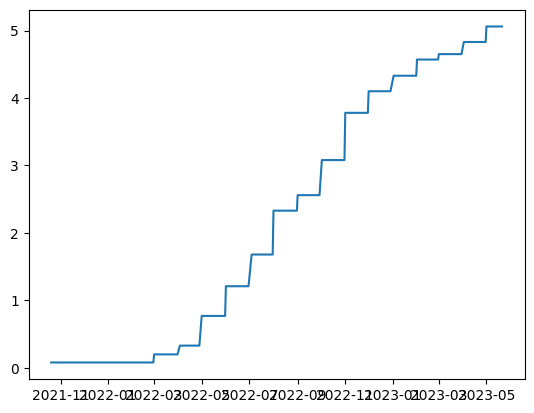

In [262]:
plt.plot(h_t_indicator)


In [263]:
import scipy.stats as stats


In [264]:

stats.chi2.ppf(0.05, 1)


0.003932140000019522

In [265]:
amazon_data = yf.download("AMZN", start="2021-10-13", end="2023-05-21")

# Extract the closing prices from the downloaded data
amazon_data = amazon_data['Close']

[*********************100%***********************]  1 of 1 completed


In [266]:
amazon_data.shape

(403,)

## 7. Monte Carlo Simulation


In [267]:
data_MC = yf.download("^GSPC", start="2021-10-13", end="2023-05-21")
data_MC["Daily_Return"] = data_MC["Close"].pct_change()



[*********************100%***********************]  1 of 1 completed


### 9. MC final reduction

In [268]:
n_days = len(data_MC)

# Extract the closing prices from the dataset
closing_prices = data_MC["Close"]

# Calculate the daily returns
daily_returns_log = np.log(closing_prices/ closing_prices.shift(1))

# Calculate the mean of daily returns to estimate drift (mu)
mu = daily_returns_log.mean()

# Annualize the mean daily return if necessary
# If the dataset has daily returns, you can annualize it using:
# mu = mu * 252  # Assuming 252 trading days in a year

# Now, mu represents the estimated drift for your GBM simulations
sigma = daily_returns_log.std()


In [269]:
sigma_gfbm=sigma

In [270]:
mu_gfbm=mu+(sigma_gfbm**2)/2

In [271]:

# Set parameters
initial_price = data_MC["Close"].iloc[0]
time_step = 1
n_days = len(data_MC)
n_simulations = 300 # Number of Monte Carlo simulations
H = 0.7  # Fractional parameter (Hurst exponent)

# Simulate FGBM paths
np.random.seed(42)  # for reproducibility
fgbm_paths = np.zeros((n_simulations, n_days))

for i in range(n_simulations):
    increments = np.random.normal(0, np.sqrt(time_step), n_days)
    increments = np.cumsum(increments)
    fgbm_path = np.zeros(n_days)
    
    for j in range(n_days):
        fgbm_path[j] = initial_price * np.exp((mu_gfbm * j - 0.5 * sigma_gfbm**2 * j**(2*H)) + sigma_gfbm * increments[j])
    
    fgbm_paths[i, :] = fgbm_path


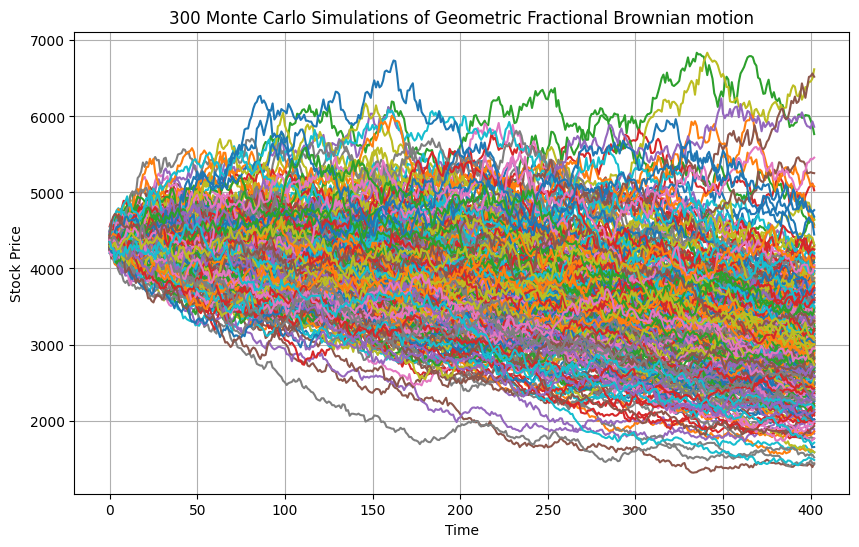

In [272]:

# Plot each simulation path
plt.figure(figsize=(10, 6))  # Set the figure size
for i in range(n_simulations):
    plt.plot(fgbm_paths[i, :], label=f"Simulation {i+1}")

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("300 Monte Carlo Simulations of Geometric Fractional Brownian motion")
plt.grid(True)  # Add grid lines

# Show the plot
plt.show()


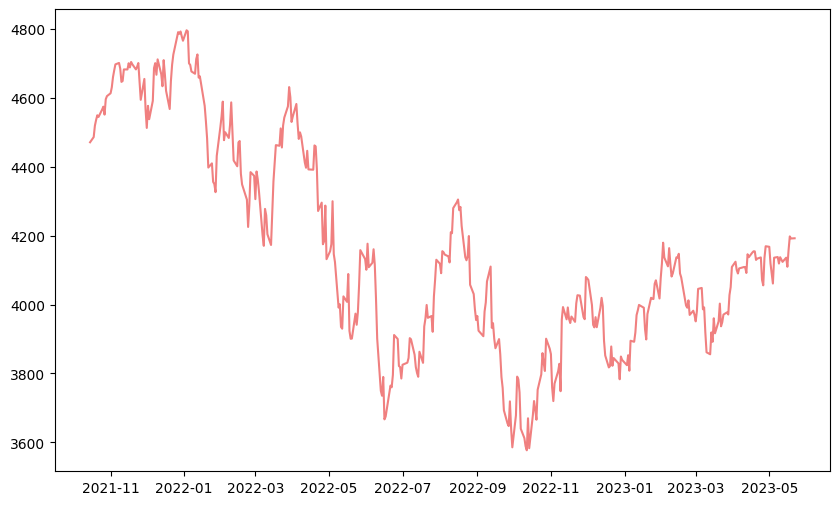

In [273]:


# Plot the training data in blue and test data in red
plt.figure(figsize=(10, 6))
plt.plot(test_data_plot.index, test_data_plot["Close"], color='lightcoral', label='Test Set')




LSTM vs GRU

In [274]:
""" Sim_gfbm = np.zeros((n_simulations, n_days))
loss_values_LSTM_Sim_gfbm = np.zeros((n_simulations, n_days - 5))
loss_values_GRU_Sim_gfbm = np.zeros((n_simulations, n_days - 5))

p_valueGRUvsLSTM_constant_gfbm=np.empty(n_simulations)
p_valueLSTMvsGRU_interestrate_gfbm=np.empty(n_simulations)
p_valueLSTMvsGRU_lossdifference_gfbm=np.empty(n_simulations)
p_valueLSTMvsGRU_laggedloss_gfbm=np.empty(n_simulations)
p_value_MA_LSTMvsGRU5_gfbm=np.empty(n_simulations)
p_valueGRUvsLSTM_indicator_lossdifference_gfbm=np.empty(n_simulations)

for i in range(n_simulations):
    Sim_gfbm[i, :] = fgbm_paths[i, :]
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))

    # LSTM
    for j in range(n_days - 5):
    
        loss = LSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_LSTM_Sim_gfbm[i, j] = loss

    #GRU
    for j in range(n_days - 5):
        loss = GRU_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_GRU_Sim_gfbm[i, j] = loss



    # Constant function
    Z_m_fixedGRUvsLSTM_constant=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    Z_m_fixed_barGRUvsLSTM_constant=1/n *sum(Z_m_fixedGRUvsLSTM_constant)
    omegaGRUvsLSTM_constant= 1/n * sum(Z_m_fixedGRUvsLSTM_constant*Z_m_fixedGRUvsLSTM_constant)
    teststatGRUvsLSTM_constant=n*Z_m_fixed_barGRUvsLSTM_constant*1/omegaGRUvsLSTM_constant*Z_m_fixed_barGRUvsLSTM_constant
    # Compute the p-value
    p_valueGRUvsLSTM_constant_gfbm[i] = 1 - chi2.cdf(teststatGRUvsLSTM_constant, 1)



    
    # Business cycle indicator
    DeltaGRUvsLSTM=(loss_values_LSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixedGRUvsLSTM_interestrate=h_t_indicator_1x398*(DeltaGRUvsLSTM)
    Z_m_fixedGRUvsLSTM_bar_interestrate=1/n *Z_m_fixedGRUvsLSTM_interestrate.sum().sum()
    omegaGRUvsLSTM_interestrate= 1/n * (Z_m_fixedGRUvsLSTM_interestrate*Z_m_fixedGRUvsLSTM_interestrate).sum().sum()
    teststatLSTMvsGRU_interestrate5=n*Z_m_fixedGRUvsLSTM_bar_interestrate*1/omegaGRUvsLSTM_interestrate*Z_m_fixedGRUvsLSTM_bar_interestrate
    # Compute the p-value
    p_valueLSTMvsGRU_interestrate_gfbm[i]= 1 - chi2.cdf(teststatLSTMvsGRU_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
    h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)
    Z_m_fixed_LSTMvsGRU=h_t_lossdifferenceLSTMvsGRU[:, :-1]*(loss_values_LSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixed_bar_LSTMvsGRU=1/n *Z_m_fixed_LSTMvsGRU.sum()
    omegaLSTMvsGRU= 1/n * (Z_m_fixed_LSTMvsGRU*Z_m_fixed_LSTMvsGRU).sum()
    teststatLSTMvsGRU=n*Z_m_fixed_bar_LSTMvsGRU*1/omegaLSTMvsGRU*Z_m_fixed_bar_LSTMvsGRU
    # Compute the p-value
    p_valueLSTMvsGRU_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatLSTMvsGRU, 1)

    # Lagged loss difference
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    two_last_lossdifferenceLSTMvsGRU=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
    two_last_lossdifferenceLSTMvsGRU = two_last_lossdifferenceLSTMvsGRU.reshape((2,))
    h_t_lossdifferenceLSTMvsGRU= np.concatenate((two_last_lossdifferenceLSTMvsGRU, h_t_lossdifferenceLSTMvsGRU))
    h_t_lossdifferenceLSTMvsGRU_lagged = h_t_lossdifferenceLSTMvsGRU[1:]-h_t_lossdifferenceLSTMvsGRU[:-1]
    h_t_lossdifferenceLSTMvsGRU_lagged=h_t_lossdifferenceLSTMvsGRU_lagged[:-1].reshape(1, -1)
    Z_m_fixed_LSTMvsGRU_laggedloss=(h_t_lossdifferenceLSTMvsGRU_lagged)*(loss_values_LSTM-loss_values_GRU)
    Z_m_fixed_bar_LSTMvsGRU_laggedloss=1/n *Z_m_fixed_LSTMvsGRU_laggedloss.sum()
    omegaLSTMvsGRU_laggedloss= 1/n * (Z_m_fixed_LSTMvsGRU_laggedloss*Z_m_fixed_LSTMvsGRU_laggedloss).sum()
    teststatLSTMvsGRU_laggedloss=n*Z_m_fixed_bar_LSTMvsGRU_laggedloss*1/omegaLSTMvsGRU_laggedloss*Z_m_fixed_bar_LSTMvsGRU_laggedloss
    # Compute the p-value
    p_valueLSTMvsGRU_laggedloss_gfbm[i]= 1 - chi2.cdf(teststatLSTMvsGRU_laggedloss, 1)

    
    # Moving Average
    lossdiffer_GRUvsLSTM=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    three_last_lossdifferenceLSTMvsGRU=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
    three_last_lossdifferenceLSTMvsGRU = three_last_lossdifferenceLSTMvsGRU.reshape((3,))
    lossdiffer_GRUvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsGRU, lossdiffer_GRUvsLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_LSTMvsGRU = []
    for m in range(k, len(lossdiffer_GRUvsLSTM)+1):
        sum_delta = sum(lossdiffer_GRUvsLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_LSTMvsGRU.append(ma)

    Z_m_fixed_MA_LSTMvsGRU5=h_t_MA_LSTMvsGRU[:-1]*(loss_values_LSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixed_MA_bar_LSTMvsGRU5=1/n *Z_m_fixed_MA_LSTMvsGRU5.sum()
    omegaLSTMvsGRU5= 1/n * (Z_m_fixed_MA_LSTMvsGRU5*Z_m_fixed_MA_LSTMvsGRU5).sum()
    teststatLSTMvsGRU5=n*Z_m_fixed_MA_bar_LSTMvsGRU5*1/omegaLSTMvsGRU5*Z_m_fixed_MA_bar_LSTMvsGRU5
    # Compute the p-value
    p_value_MA_LSTMvsGRU5_gfbm[i]= 1 - chi2.cdf(teststatLSTMvsGRU5, 1)


    # Combination of test functions
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
    h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)

    h_t_indicator_lossdifferenceLSTMvsGRU=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsGRU[:, :-1]))

    DeltaLSTMvsGRU=(loss_values_LSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixed_indicator_lossdifferenceLSTMvsGRU=h_t_indicator_lossdifferenceLSTMvsGRU*(DeltaLSTMvsGRU)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceLSTMvsGRU, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU, (2, 1))
    omegaLSTMvsGRU_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceLSTMvsGRU@(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN.T)
    teststatLSTMvsGRU_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU.T)@(np.linalg.inv(omegaLSTMvsGRU_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceLSTMvsGRU
    # Compute the p-value
    p_valueGRUvsLSTM_indicator_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatLSTMvsGRU_indicator_lossdifference5, 2)
 """

' Sim_gfbm = np.zeros((n_simulations, n_days))\nloss_values_LSTM_Sim_gfbm = np.zeros((n_simulations, n_days - 5))\nloss_values_GRU_Sim_gfbm = np.zeros((n_simulations, n_days - 5))\n\np_valueGRUvsLSTM_constant_gfbm=np.empty(n_simulations)\np_valueLSTMvsGRU_interestrate_gfbm=np.empty(n_simulations)\np_valueLSTMvsGRU_lossdifference_gfbm=np.empty(n_simulations)\np_valueLSTMvsGRU_laggedloss_gfbm=np.empty(n_simulations)\np_value_MA_LSTMvsGRU5_gfbm=np.empty(n_simulations)\np_valueGRUvsLSTM_indicator_lossdifference_gfbm=np.empty(n_simulations)\n\nfor i in range(n_simulations):\n    Sim_gfbm[i, :] = fgbm_paths[i, :]\n    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)\n    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))\n\n    # LSTM\n    for j in range(n_days - 5):\n    \n        loss = LSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0

In [275]:
""" 
p_values_arrays_GRUvsLSTM_gfbm = [p_valueGRUvsLSTM_constant_gfbm, p_valueLSTMvsGRU_interestrate_gfbm, 
                   p_valueLSTMvsGRU_lossdifference_gfbm, p_valueLSTMvsGRU_laggedloss_gfbm, 
                   p_value_MA_LSTMvsGRU5_gfbm, p_valueGRUvsLSTM_indicator_lossdifference_gfbm] """

' \np_values_arrays_GRUvsLSTM_gfbm = [p_valueGRUvsLSTM_constant_gfbm, p_valueLSTMvsGRU_interestrate_gfbm, \n                   p_valueLSTMvsGRU_lossdifference_gfbm, p_valueLSTMvsGRU_laggedloss_gfbm, \n                   p_value_MA_LSTMvsGRU5_gfbm, p_valueGRUvsLSTM_indicator_lossdifference_gfbm] '

In [276]:
""" # Specify the file path
file_path = "p_values_arrays_GRUvsLSTM_gfbm.pkl"

# Save the list to a binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_GRUvsLSTM_gfbm, binary_file) """

' # Specify the file path\nfile_path = "p_values_arrays_GRUvsLSTM_gfbm.pkl"\n\n# Save the list to a binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(p_values_arrays_GRUvsLSTM_gfbm, binary_file) '

In [277]:
""" # Specify the file path
file_path = "loss_values_LSTM_Sim_gfbm.pkl"

# Save the list to a binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(loss_values_LSTM_Sim_gfbm, binary_file) 
 """

' # Specify the file path\nfile_path = "loss_values_LSTM_Sim_gfbm.pkl"\n\n# Save the list to a binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(loss_values_LSTM_Sim_gfbm, binary_file) \n '

In [278]:
""" # Specify the file path
file_path = "loss_values_GRU_Sim_gfbm.pkl"

# Save the list to a binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(loss_values_GRU_Sim_gfbm, binary_file) 
 """

' # Specify the file path\nfile_path = "loss_values_GRU_Sim_gfbm.pkl"\n\n# Save the list to a binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(loss_values_GRU_Sim_gfbm, binary_file) \n '

In [279]:
""" # Specify the file path
file_path = "Sim_gfbm.pkl"

# Save the list to a binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(Sim_gfbm, binary_file) """

' # Specify the file path\nfile_path = "Sim_gfbm.pkl"\n\n# Save the list to a binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(Sim_gfbm, binary_file) '

In [280]:
# Load the data from the binary file
with open("p_values_arrays_GRUvsLSTM_gfbm.pkl", "rb") as binary_file:
    p_values_arrays_GRUvsLSTM_gfbm = pickle.load(binary_file)

In [281]:
# Load the data from the binary file
with open("Sim_gfbm.pkl", "rb") as binary_file:
    Sim_gfbm = pickle.load(binary_file)

In [282]:
# Load the data from the binary file
with open("loss_values_LSTM_Sim_gfbm.pkl", "rb") as binary_file:
    loss_values_LSTM_Sim_gfbm = pickle.load(binary_file)

In [283]:
# Load the data from the binary file
with open("loss_values_GRU_Sim_gfbm.pkl", "rb") as binary_file:
    loss_values_GRU_Sim_gfbm = pickle.load(binary_file)

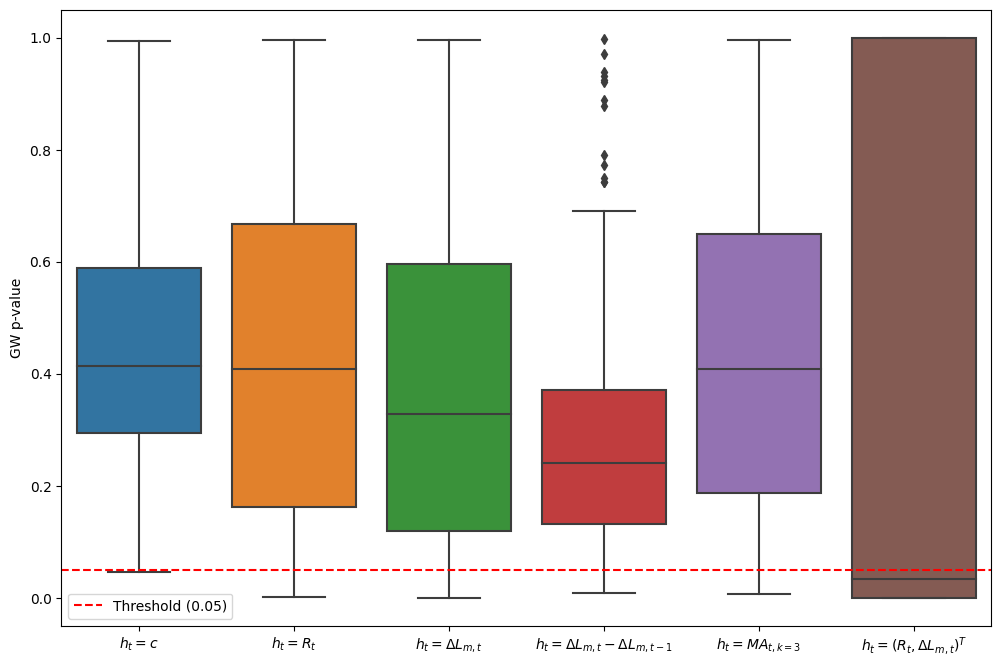

In [400]:
labels = ['$h_t= c$', '$h_t= R_t$', 
          '$h_t=\Delta L_{m,t}$', '$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$', 
          '$h_t=MA_{t,k=3}$', '$h_t=(R_t,\Delta L_{m,t})^T$']
plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_GRUvsLSTM_gfbm)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('GW p-value')
#plt.title('Box Plot of GW p-values between LSTM vs GRU')

plt.legend()
plt.show()


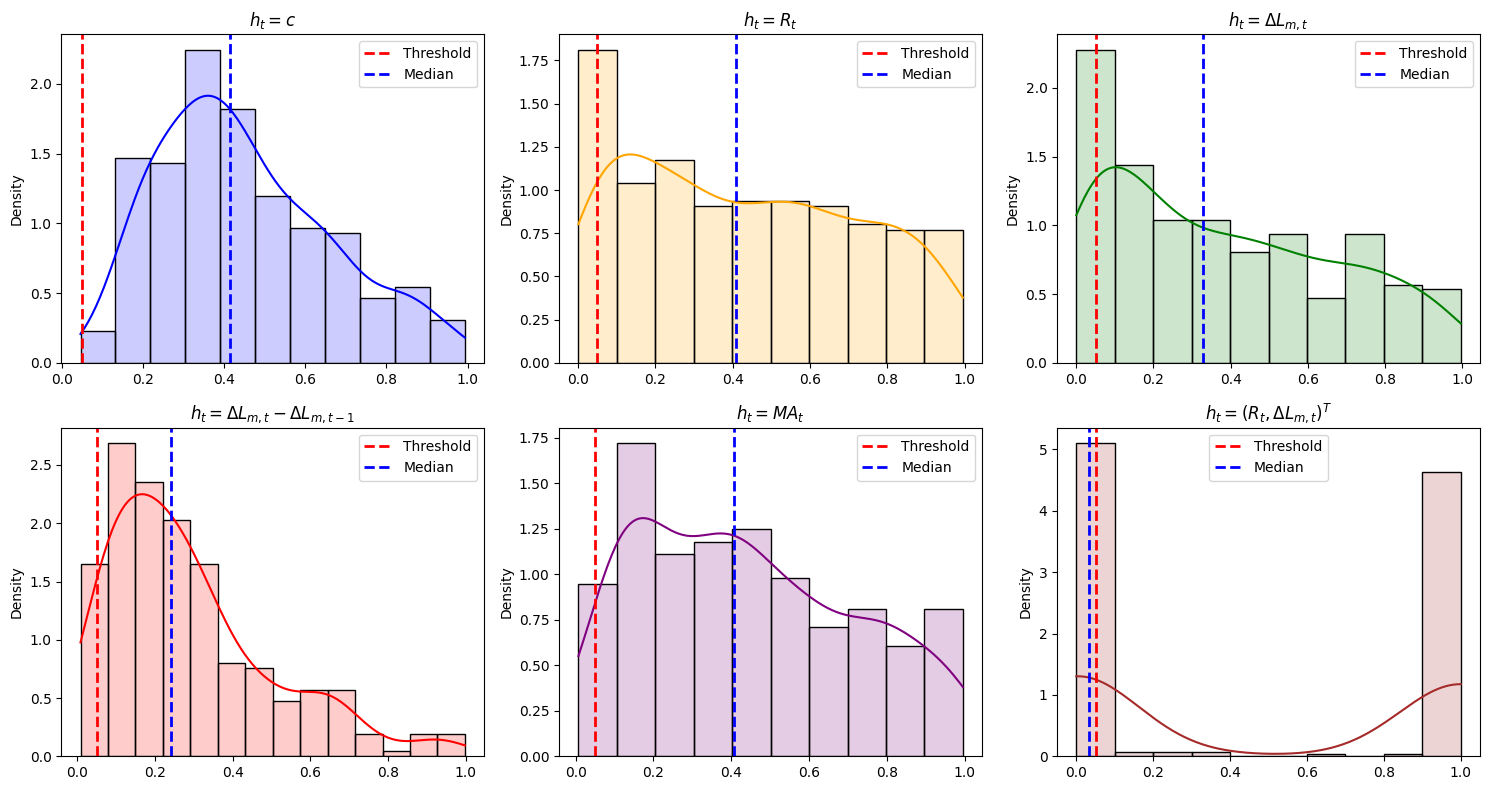

In [285]:


# Define a list of colors for the labels
label_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, label in enumerate(labels):
    row, col = divmod(idx, 3)  # Calculate the subplot row and column
    data = p_values_arrays_GRUvsLSTM_gfbm[idx]
    

    # Plot the histograms with the same colors
    sns.histplot(data, color=label_colors[idx % len(label_colors)], kde=True, ax=axes[row, col],stat="density",alpha=0.2)
    
    # Add threhold lines with a fixed red color
    axes[row, col].axvline(0.05, color='red', linestyle='dashed', linewidth=2, label='Threshold')
    # Add median lines with a fixed red color
    axes[row, col].axvline(np.median(data), color='blue', linestyle='dashed', linewidth=2, label='Median')

    # Set titles for subplots
    axes[row, col].set_title(label)

    # Add legend for the median lines
    axes[row, col].legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [286]:
from scipy.integrate import quad

# Define a list to store the integral results
integral_results = []

for idx, label in enumerate(labels):
    data = p_values_arrays_GRUvsLSTM_gfbm[idx]

    
    # Calculate the kernel density estimate (KDE)
    kde = sns.kdeplot(data, color=label_colors[idx % len(label_colors)], ax=axes[row, col])

    # Get the KDE values from the plot
    kde_values = kde.get_lines()[0].get_data()

    # Define the PDF function for the density curve
    def pdf(x):
        return np.interp(x, kde_values[0], kde_values[1])

    # Calculate the area under the curve using quad
    area_under_curve, _ = quad(pdf, data.min(), data.max())

    # Append the result to the list
    integral_results.append(area_under_curve)


In [287]:
integral_results

[0.44777409799893453,
 0.5070116840204878,
 0.5094217961496522,
 0.5011626977251744,
 0.4987382018126993,
 0.5135503904915877]

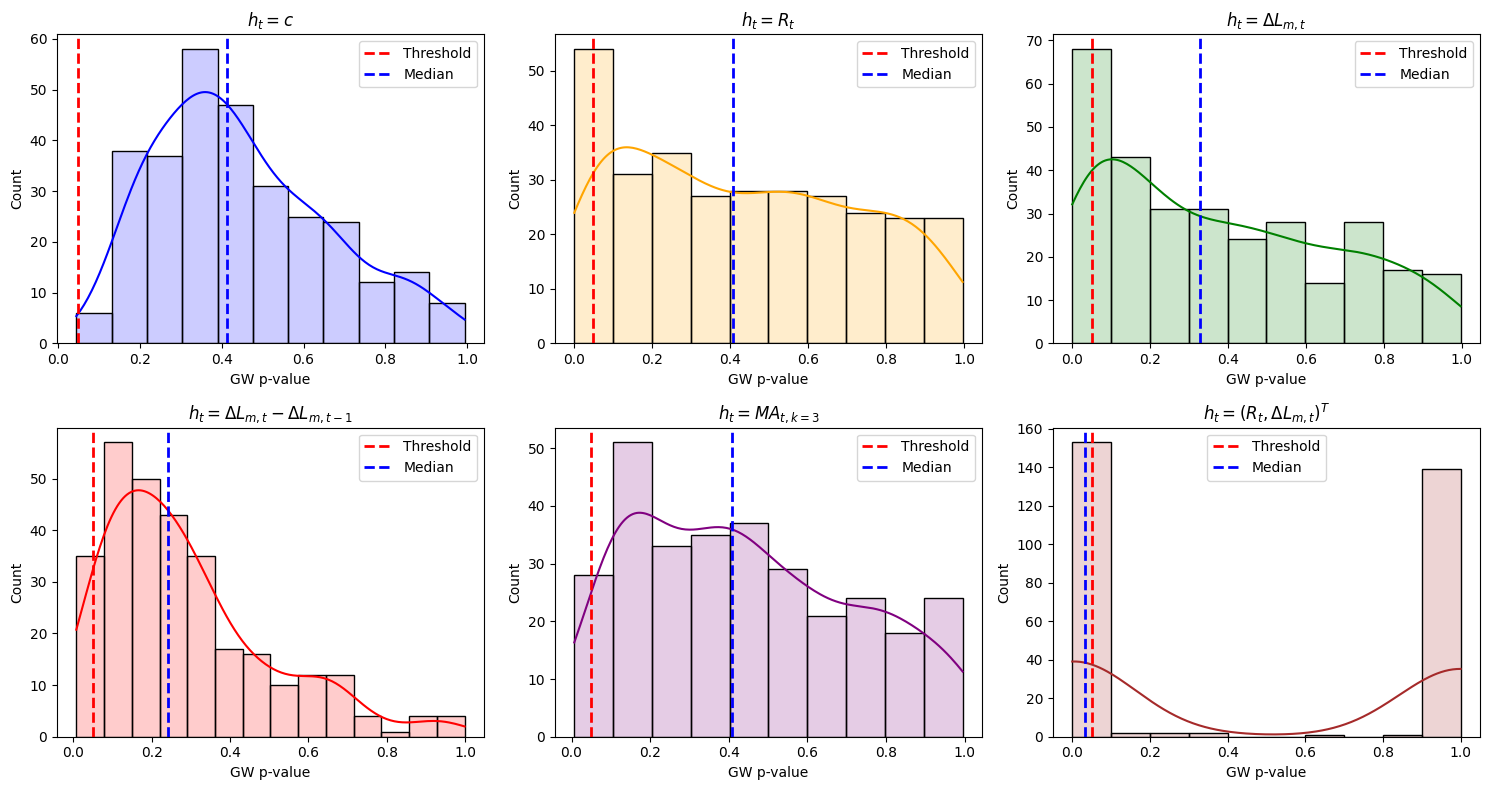

In [401]:


# Define a list of colors for the labels
label_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, label in enumerate(labels):
    row, col = divmod(idx, 3)  # Calculate the subplot row and column
    data = p_values_arrays_GRUvsLSTM_gfbm[idx]
    

    # Plot the histograms with the same colors
    sns.histplot(data, color=label_colors[idx % len(label_colors)], kde=True, ax=axes[row, col],alpha=0.2)
    
    # Add threhold lines with a fixed red color
    axes[row, col].axvline(0.05, color='red', linestyle='dashed', linewidth=2, label='Threshold')
    # Add median lines with a fixed red color
    axes[row, col].axvline(np.median(data), color='blue', linestyle='dashed', linewidth=2, label='Median')

    # Set titles for subplots
    axes[row, col].set_title(label)

    # Add legend for the median lines
    axes[row, col].legend()

    # Add x-axis 
    axes[row, col].set_xlabel('GW p-value')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [289]:
p_values_arrays_GRUvsLSTM_gfbm[2]

array([3.01854094e-02, 8.73816914e-01, 9.75342699e-01, 1.30850484e-01,
       1.54207055e-02, 3.56071436e-02, 3.48252668e-01, 5.46950454e-01,
       4.87538901e-01, 5.38549253e-01, 1.38116782e-01, 2.23203553e-02,
       2.34830381e-01, 7.12217691e-01, 6.76996953e-02, 1.34010983e-01,
       5.31906863e-01, 7.80298535e-01, 2.57711361e-01, 1.91206967e-02,
       9.40932415e-01, 3.47832700e-02, 3.15478262e-01, 1.32517295e-01,
       2.09864049e-01, 3.77613844e-01, 1.01257577e-01, 1.21266815e-01,
       7.02499597e-01, 8.06273445e-01, 5.93200510e-01, 8.83962168e-01,
       9.24396211e-01, 2.34345337e-01, 1.74402625e-02, 4.54999379e-01,
       3.93659250e-01, 2.03312139e-01, 6.32308923e-01, 3.53043921e-01,
       4.09956177e-01, 2.75354582e-01, 6.32618343e-01, 3.89847263e-01,
       3.40411767e-01, 4.19633885e-01, 7.74375267e-01, 6.00649271e-02,
       1.91679458e-02, 2.15538714e-01, 9.38822229e-01, 6.23691813e-01,
       6.56704246e-01, 2.41313240e-01, 7.35676998e-01, 4.61262310e-01,
      

In [290]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_GRUvsLSTM_gfbm[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+---------------------------------------+---------------------+--------------------+----------------------+
|                 Label                 |         Q1          |         Q3         |        Median        |
+---------------------------------------+---------------------+--------------------+----------------------+
|               $h_t= c$                |  0.294596316338396  | 0.5886090452209607 |  0.4131134158856526  |
|              $h_t= R_t$               | 0.1624235209856547  | 0.6681541374714305 | 0.40815781658483913  |
|         $h_t=\Delta L_{m,t}$          | 0.11839133440728919 | 0.5960760080704437 | 0.32729567653599373  |
| $h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$ | 0.1308028166655847  | 0.371392169638837  | 0.24073301596970187  |
|              $h_t=MA_t$               | 0.1878170011004818  | 0.6503102670456886 |  0.407836169560502   |
|     $h_t=(R_t,\Delta L_{m,t})^T$      |         0.0         |        1.0         | 0.032897664018795236 |
+---------------------------

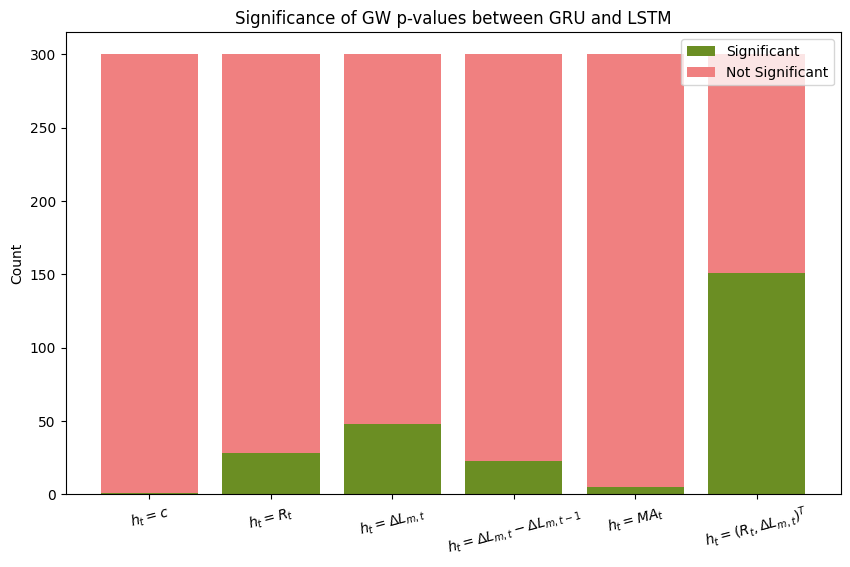

In [291]:
labels = ['$h_t= c$', '$h_t= R_t$', 
          '$h_t=\Delta L_{m,t}$', '$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$', 
          '$h_t=MA_t$', '$h_t=(R_t,\Delta L_{m,t})^T$']
significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_GRUvsLSTM_gfbm]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color="olivedrab")
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels, rotation=15)
plt.ylabel('Count')
plt.title('Significance of GW p-values between GRU and LSTM')
plt.legend()
plt.show()


In [292]:
significant

[1, 28, 48, 23, 5, 151]

In [293]:
quantile = chi2.ppf(1 - 0.05, 1)


In [294]:
quantile

3.841458820694124

In [295]:
significant

[1, 28, 48, 23, 5, 151]

In [296]:
5/300*10

0.16666666666666666

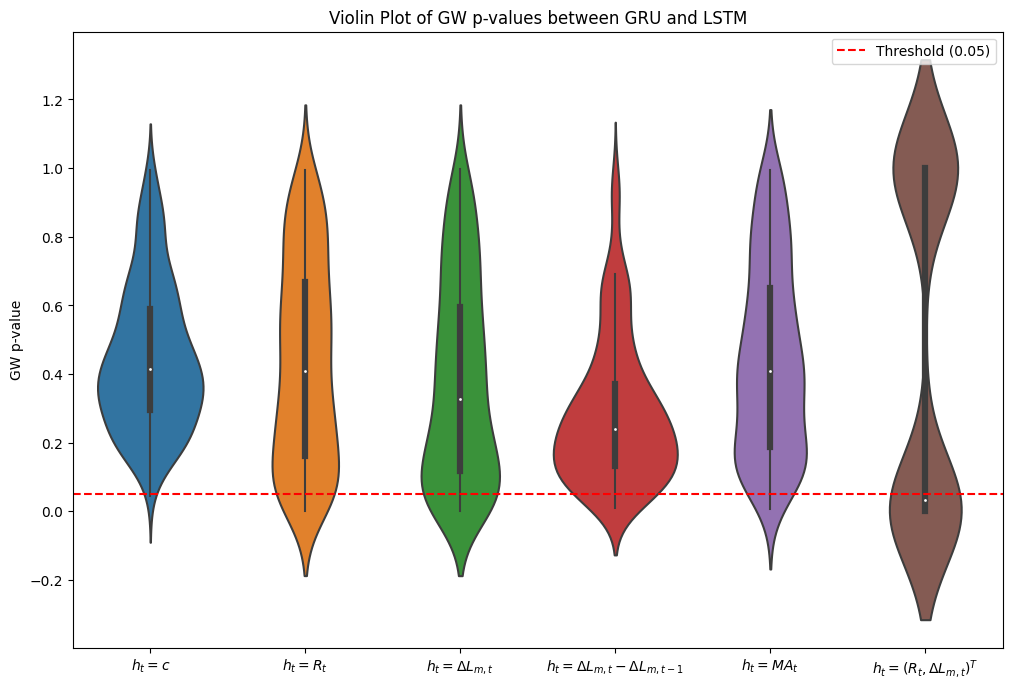

In [297]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=p_values_arrays_GRUvsLSTM_gfbm)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('GW p-value')
plt.title('Violin Plot of GW p-values between GRU and LSTM')
plt.legend()
plt.show()


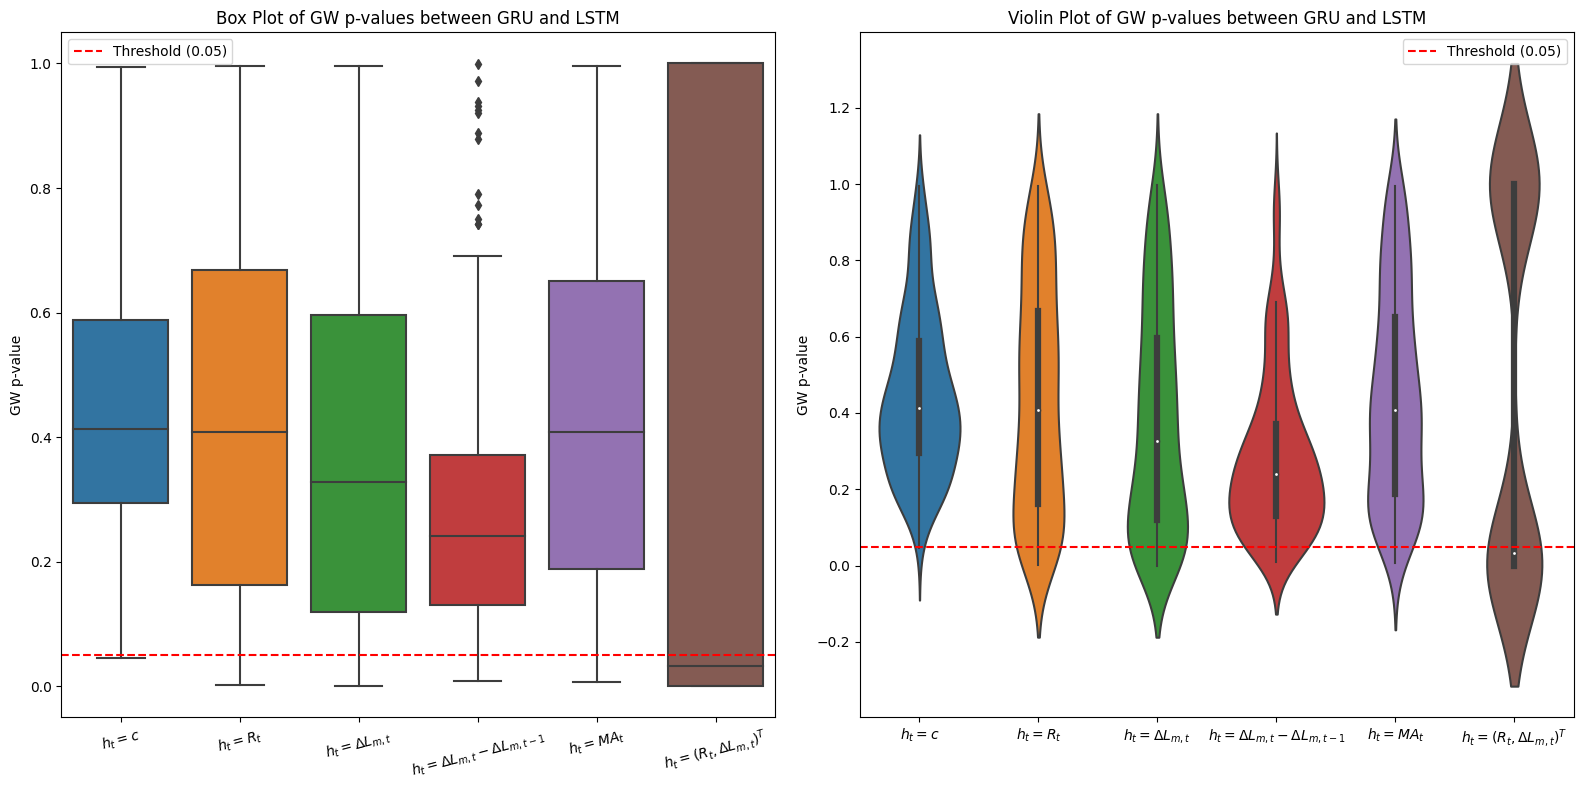

In [298]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Box Plot
sns.boxplot(data=p_values_arrays_GRUvsLSTM_gfbm, ax=axes[0])
axes[0].axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
axes[0].set_xticks(np.arange(len(labels)))
axes[0].set_xticklabels(labels, rotation=15)
axes[0].set_ylabel('GW p-value')
axes[0].set_title('Box Plot of GW p-values between GRU and LSTM')
axes[0].legend()

# Violin Plot
sns.violinplot(data=p_values_arrays_GRUvsLSTM_gfbm, ax=axes[1])
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
axes[1].set_xticks(np.arange(len(labels)))
axes[1].set_xticklabels(labels)
axes[1].set_ylabel('GW p-value')
axes[1].set_title('Violin Plot of GW p-values between GRU and LSTM')
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the combined plot
plt.show()

### BiLSTM vs GRU

In [299]:
""" loss_values_BiLSTM_Sim_gfbm = np.zeros((n_simulations, n_days - 5))

p_valueGRUvsBiLSTM_constant_gfbm=np.empty(n_simulations)
p_valueBiLSTMvsGRU_interestrate_gfbm=np.empty(n_simulations)
p_valueBiLSTMvsGRU_lossdifference_gfbm=np.empty(n_simulations)
p_valueBiLSTMvsGRU_laggedloss_gfbm=np.empty(n_simulations)
p_value_MA_BiLSTMvsGRU5_gfbm=np.empty(n_simulations)
p_valueBiLSTMvsGRU_indicator_lossdifference_gfbm=np.empty(n_simulations)

for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))
    

    # BiLSTM
    for j in range(n_days - 5):
    
        lossBiLSTM = BiLSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_BiLSTM_Sim_gfbm[i, j] = lossBiLSTM

    # Constant function
    Z_m_fixedGRUvsBiLSTM_constant=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    Z_m_fixed_barGRUvsBiLSTM_constant=1/n *sum(Z_m_fixedGRUvsBiLSTM_constant)
    omegaGRUvsBiLSTM_constant= 1/n * sum(Z_m_fixedGRUvsBiLSTM_constant*Z_m_fixedGRUvsBiLSTM_constant)
    teststatGRUvsBiLSTM_constant=n*Z_m_fixed_barGRUvsBiLSTM_constant*1/omegaGRUvsBiLSTM_constant*Z_m_fixed_barGRUvsBiLSTM_constant
    # Compute the p-value
    p_valueGRUvsBiLSTM_constant_gfbm[i] = 1 - chi2.cdf(teststatGRUvsBiLSTM_constant, 1)

    # Business cycle indicator
    DeltaGRUvsBiLSTM=(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixedGRUvsBiLSTM_interestrate=h_t_indicator_1x398*(DeltaGRUvsBiLSTM)
    Z_m_fixedGRUvsBiLSTM_bar_interestrate=1/n *Z_m_fixedGRUvsBiLSTM_interestrate.sum().sum()
    omegaGRUvsBiLSTM_interestrate= 1/n * (Z_m_fixedGRUvsBiLSTM_interestrate*Z_m_fixedGRUvsBiLSTM_interestrate).sum().sum()
    teststatBiLSTMvsGRU_interestrate5=n*Z_m_fixedGRUvsBiLSTM_bar_interestrate*1/omegaGRUvsBiLSTM_interestrate*Z_m_fixedGRUvsBiLSTM_bar_interestrate
    # Compute the p-value
    p_valueBiLSTMvsGRU_interestrate_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsGRU_interestrate5, 1)


    #Loss difference test function
    h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    h_t_lossdifferenceBiLSTMvsGRU= np.insert(h_t_lossdifferenceBiLSTMvsGRU, 0, 0)
    h_t_lossdifferenceBiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU.reshape(1, -1)
    Z_m_fixed_BiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU[:, :-1]*(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixed_bar_BiLSTMvsGRU=1/n *Z_m_fixed_BiLSTMvsGRU.sum()
    omegaBiLSTMvsGRU= 1/n * (Z_m_fixed_BiLSTMvsGRU*Z_m_fixed_BiLSTMvsGRU).sum()
    teststatBiLSTMvsGRU=n*Z_m_fixed_bar_BiLSTMvsGRU*1/omegaBiLSTMvsGRU*Z_m_fixed_bar_BiLSTMvsGRU
    # Compute the p-value
    p_valueBiLSTMvsGRU_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsGRU, 1)

    # Lagged loss difference
    h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    two_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
    two_last_lossdifferenceBiLSTMvsGRU = two_last_lossdifferenceBiLSTMvsGRU.reshape((2,))
    h_t_lossdifferenceBiLSTMvsGRU= np.concatenate((two_last_lossdifferenceBiLSTMvsGRU, h_t_lossdifferenceBiLSTMvsGRU))
    h_t_lossdifferenceBiLSTMvsGRU_lagged = h_t_lossdifferenceBiLSTMvsGRU[1:]-h_t_lossdifferenceBiLSTMvsGRU[:-1]
    h_t_lossdifferenceBiLSTMvsGRU_lagged=h_t_lossdifferenceBiLSTMvsGRU_lagged[:-1].reshape(1, -1)
    Z_m_fixed_BiLSTMvsGRU_laggedloss=(h_t_lossdifferenceBiLSTMvsGRU_lagged)*(loss_values_BiLSTM-loss_values_GRU)
    Z_m_fixed_bar_BiLSTMvsGRU_laggedloss=1/n *Z_m_fixed_BiLSTMvsGRU_laggedloss.sum()
    omegaBiLSTMvsGRU_laggedloss= 1/n * (Z_m_fixed_BiLSTMvsGRU_laggedloss*Z_m_fixed_BiLSTMvsGRU_laggedloss).sum()
    teststatBiLSTMvsGRU_laggedloss=n*Z_m_fixed_bar_BiLSTMvsGRU_laggedloss*1/omegaBiLSTMvsGRU_laggedloss*Z_m_fixed_bar_BiLSTMvsGRU_laggedloss
    # Compute the p-value
    p_valueBiLSTMvsGRU_laggedloss_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsGRU_laggedloss, 1)

    # Moving Average
    lossdiffer_GRUvsBiLSTM=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    three_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
    three_last_lossdifferenceBiLSTMvsGRU = three_last_lossdifferenceBiLSTMvsGRU.reshape((3,))
    lossdiffer_GRUvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsGRU, lossdiffer_GRUvsBiLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_BiLSTMvsGRU = []
    for m in range(k, len(lossdiffer_GRUvsBiLSTM)+1):
        sum_delta = sum(lossdiffer_GRUvsBiLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_BiLSTMvsGRU.append(ma)

    Z_m_fixed_MA_BiLSTMvsGRU5=h_t_MA_BiLSTMvsGRU[:-1]*(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixed_MA_bar_BiLSTMvsGRU5=1/n *Z_m_fixed_MA_BiLSTMvsGRU5.sum()
    omegaBiLSTMvsGRU5= 1/n * (Z_m_fixed_MA_BiLSTMvsGRU5*Z_m_fixed_MA_BiLSTMvsGRU5).sum()
    teststatBiLSTMvsGRU5=n*Z_m_fixed_MA_bar_BiLSTMvsGRU5*1/omegaBiLSTMvsGRU5*Z_m_fixed_MA_bar_BiLSTMvsGRU5
    # Compute the p-value
    p_value_MA_BiLSTMvsGRU5_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsGRU5, 1) 

    
    # Combination of test functions
    h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]

    h_t_lossdifferenceBiLSTMvsGRU= np.insert(h_t_lossdifferenceBiLSTMvsGRU, 0, 0)
    h_t_lossdifferenceBiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU.reshape(1, -1)
    

    h_t_indicator_lossdifferenceBiLSTMvsGRU=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsGRU[:, :-1]))

    DeltaBiLSTMvsGRU=(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixed_indicator_lossdifferenceBiLSTMvsGRU=h_t_indicator_lossdifferenceBiLSTMvsGRU*(DeltaBiLSTMvsGRU)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsGRU=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsGRU, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsGRU=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsGRU, (2, 1))
    omegaBiLSTMvsGRU_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceBiLSTMvsGRU@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsGRU.T)
    teststatBiLSTMvsGRU_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsGRU.T)@(np.linalg.inv(omegaBiLSTMvsGRU_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsGRU
    # Compute the p-value
    p_valueBiLSTMvsGRU_indicator_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsGRU_indicator_lossdifference5, 2)

     """

' loss_values_BiLSTM_Sim_gfbm = np.zeros((n_simulations, n_days - 5))\n\np_valueGRUvsBiLSTM_constant_gfbm=np.empty(n_simulations)\np_valueBiLSTMvsGRU_interestrate_gfbm=np.empty(n_simulations)\np_valueBiLSTMvsGRU_lossdifference_gfbm=np.empty(n_simulations)\np_valueBiLSTMvsGRU_laggedloss_gfbm=np.empty(n_simulations)\np_value_MA_BiLSTMvsGRU5_gfbm=np.empty(n_simulations)\np_valueBiLSTMvsGRU_indicator_lossdifference_gfbm=np.empty(n_simulations)\n\nfor i in range(n_simulations):\n    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)\n    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))\n    \n\n    # BiLSTM\n    for j in range(n_days - 5):\n    \n        lossBiLSTM = BiLSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]\n        loss_values_BiLSTM_Sim_gfbm[i, j] = lossBiLSTM\n\n    # Constant function\n    Z_m_fixedGRUvsBiLSTM_constan

In [300]:
""" # Specify the file path where you want to save the matrix
file_path = "loss_values_BiLSTM_Sim_gfbm.pkl"

# Save the matrix to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(loss_values_BiLSTM_Sim_gfbm, binary_file) """

' # Specify the file path where you want to save the matrix\nfile_path = "loss_values_BiLSTM_Sim_gfbm.pkl"\n\n# Save the matrix to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(loss_values_BiLSTM_Sim_gfbm, binary_file) '

In [301]:
# Load the data from the binary file
with open("loss_values_BiLSTM_Sim_gfbm.pkl", "rb") as binary_file:
    loss_values_BiLSTM_Sim_gfbm = pickle.load(binary_file)

In [302]:
""" 
p_values_arrays_BiLSTMvsGRU_gfbm = [p_valueGRUvsBiLSTM_constant_gfbm, p_valueBiLSTMvsGRU_interestrate_gfbm, 
                   p_valueBiLSTMvsGRU_lossdifference_gfbm, p_valueBiLSTMvsGRU_laggedloss_gfbm, 
                   p_value_MA_BiLSTMvsGRU5_gfbm, p_valueBiLSTMvsGRU_indicator_lossdifference_gfbm] """

' \np_values_arrays_BiLSTMvsGRU_gfbm = [p_valueGRUvsBiLSTM_constant_gfbm, p_valueBiLSTMvsGRU_interestrate_gfbm, \n                   p_valueBiLSTMvsGRU_lossdifference_gfbm, p_valueBiLSTMvsGRU_laggedloss_gfbm, \n                   p_value_MA_BiLSTMvsGRU5_gfbm, p_valueBiLSTMvsGRU_indicator_lossdifference_gfbm] '

In [303]:
""" 
# Specify the file path where you want to save the array
file_path = "p_values_arrays_BiLSTMvsGRU_gfbm.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_BiLSTMvsGRU_gfbm, binary_file) """

' \n# Specify the file path where you want to save the array\nfile_path = "p_values_arrays_BiLSTMvsGRU_gfbm.pkl"\n\n# Save the array to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(p_values_arrays_BiLSTMvsGRU_gfbm, binary_file) '

In [304]:

# Load the data from the binary file
with open("p_values_arrays_BiLSTMvsGRU_gfbm.pkl", "rb") as binary_file:
    p_values_arrays_BiLSTMvsGRU_gfbm = pickle.load(binary_file)

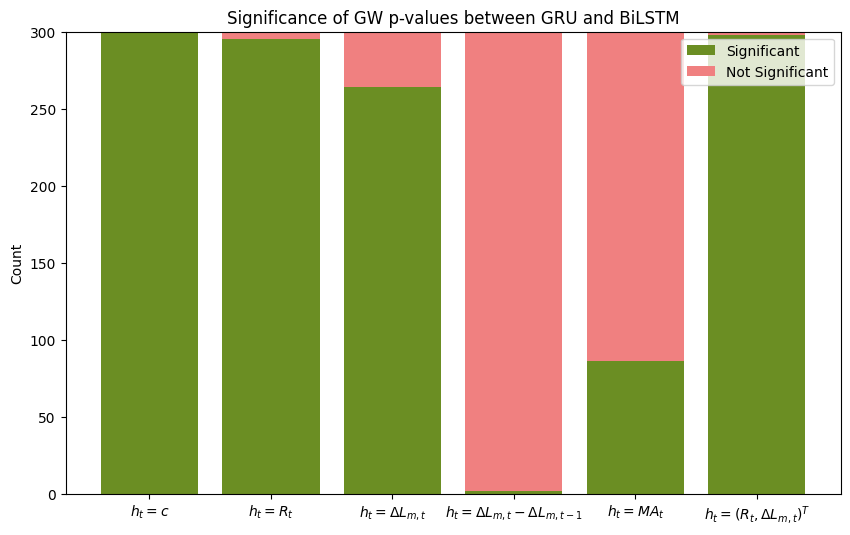

In [305]:
labels = ['$h_t= c$', '$h_t= R_t$', 
          '$h_t=\Delta L_{m,t}$', '$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$', 
          '$h_t=MA_t$', '$h_t=(R_t,\Delta L_{m,t})^T$']
significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_BiLSTMvsGRU_gfbm]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color='olivedrab')
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Count')
plt.title('Significance of GW p-values between GRU and BiLSTM')

plt.legend()
plt.show()


In [306]:
significant

[300, 295, 264, 2, 86, 298]

In [307]:
p_values_arrays_BiLSTMvsGRU_gfbm[4]

array([4.70275048e-02, 3.19458066e-01, 1.36869214e-03, 9.20601597e-02,
       2.94735615e-01, 5.08283444e-01, 7.40699672e-03, 5.37792850e-02,
       8.18877152e-01, 2.50220351e-01, 9.19022088e-01, 8.08956261e-02,
       4.31768219e-01, 8.74415294e-01, 9.66140277e-01, 2.50473106e-01,
       7.73358647e-02, 6.96590464e-02, 8.07104619e-02, 8.82621359e-03,
       1.90442590e-01, 5.39953266e-01, 7.27034395e-01, 3.42825628e-01,
       4.26480907e-01, 5.58324637e-01, 8.06194960e-01, 8.96600402e-01,
       5.81360674e-01, 3.80259768e-01, 4.21830881e-01, 5.47012365e-01,
       1.00720817e-02, 2.65810641e-02, 4.37216137e-02, 2.12001854e-01,
       1.70256137e-01, 3.04837361e-02, 1.59977209e-01, 8.15097785e-02,
       3.95308832e-01, 3.84591290e-01, 1.09526664e-01, 1.58564202e-01,
       4.76449665e-01, 1.62641406e-03, 7.93457454e-01, 5.18763187e-01,
       2.55885005e-01, 3.69868134e-02, 3.01583782e-01, 8.63183417e-01,
       4.81348863e-01, 4.43323593e-01, 8.82994133e-02, 3.71617666e-01,
      

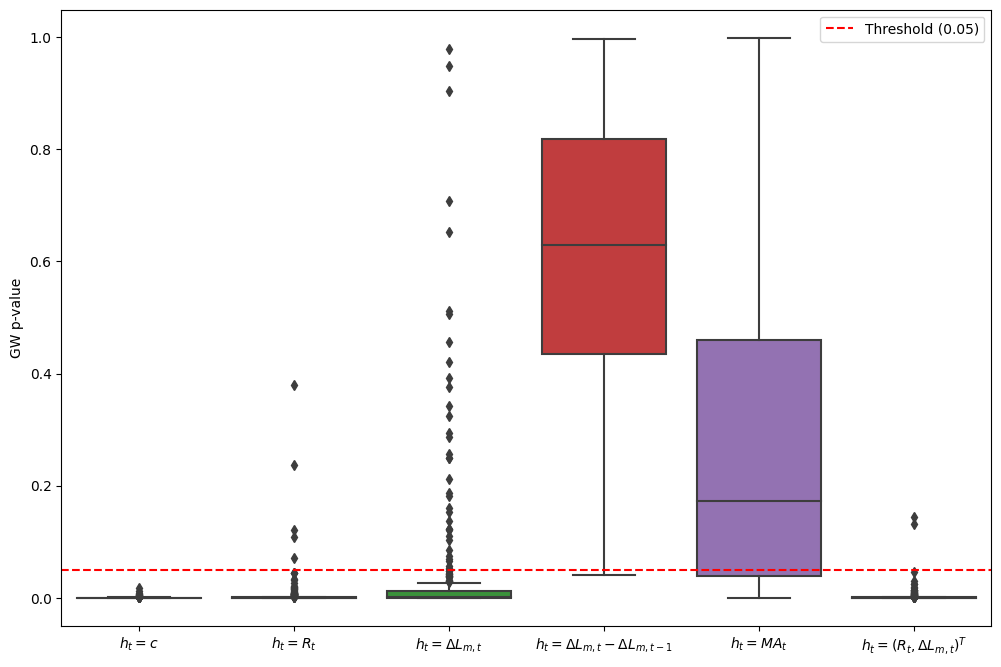

In [308]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_BiLSTMvsGRU_gfbm)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('GW p-value')
#plt.title('Box Plot of GW p-values between GRU and BiLSTM')

plt.legend()
plt.show()


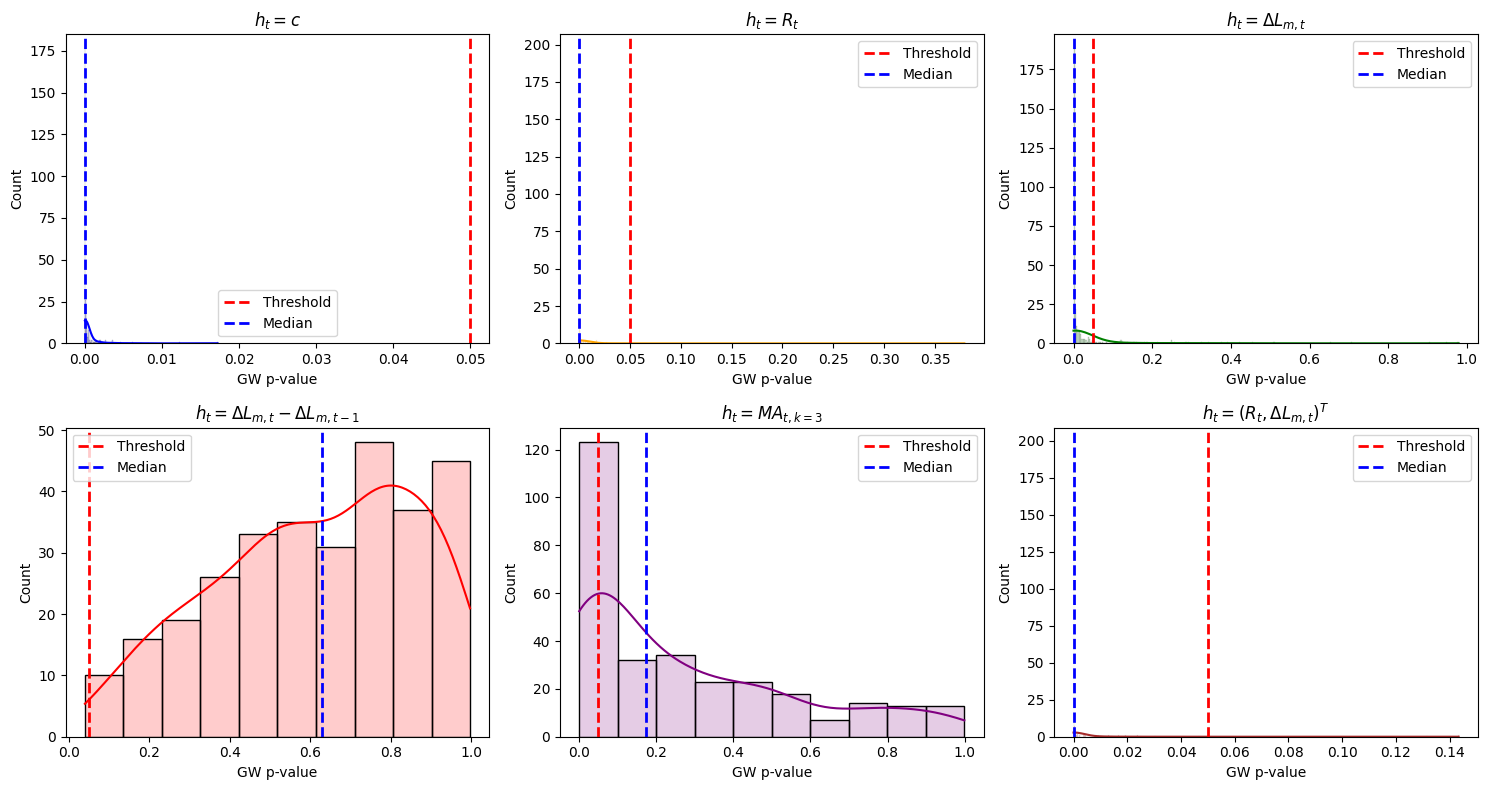

In [402]:


# Define a list of colors for the labels
label_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, label in enumerate(labels):
    row, col = divmod(idx, 3)  # Calculate the subplot row and column
    data = p_values_arrays_BiLSTMvsGRU_gfbm[idx]
    

    # Plot the histograms with the same colors
    sns.histplot(data, color=label_colors[idx % len(label_colors)], kde=True, ax=axes[row, col],alpha=0.2)
    
    # Add threhold lines with a fixed red color
    axes[row, col].axvline(0.05, color='red', linestyle='dashed', linewidth=2, label='Threshold')
    # Add median lines with a fixed red color
    axes[row, col].axvline(np.median(data), color='blue', linestyle='dashed', linewidth=2, label='Median')

    # Set titles for subplots
    axes[row, col].set_title(label)

    # Add legend for the median lines
    axes[row, col].legend()

    axes[row, col].set_xlabel('GW p-value')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [310]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_BiLSTMvsGRU_gfbm[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+---------------------------------------+------------------------+-----------------------+------------------------+
|                 Label                 |           Q1           |          Q3           |         Median         |
+---------------------------------------+------------------------+-----------------------+------------------------+
|               $h_t= c$                | 2.6994547056846674e-06 | 0.0002325038592612405 | 4.086956927928931e-05  |
|              $h_t= R_t$               | 1.2126967562364754e-06 | 0.0005444068708503058 | 3.636621836899945e-05  |
|         $h_t=\Delta L_{m,t}$          | 0.00010217889737379471 | 0.011186179638187799  | 0.0011814768236793616  |
| $h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$ |   0.4353296963975728   |  0.8182092586990044   |   0.6293075174108772   |
|              $h_t=MA_t$               |  0.039256874665857866  |   0.45918888807835    |   0.1727920743121249   |
|     $h_t=(R_t,\Delta L_{m,t})^T$      | 4.768984346315008e-07  | 0.000

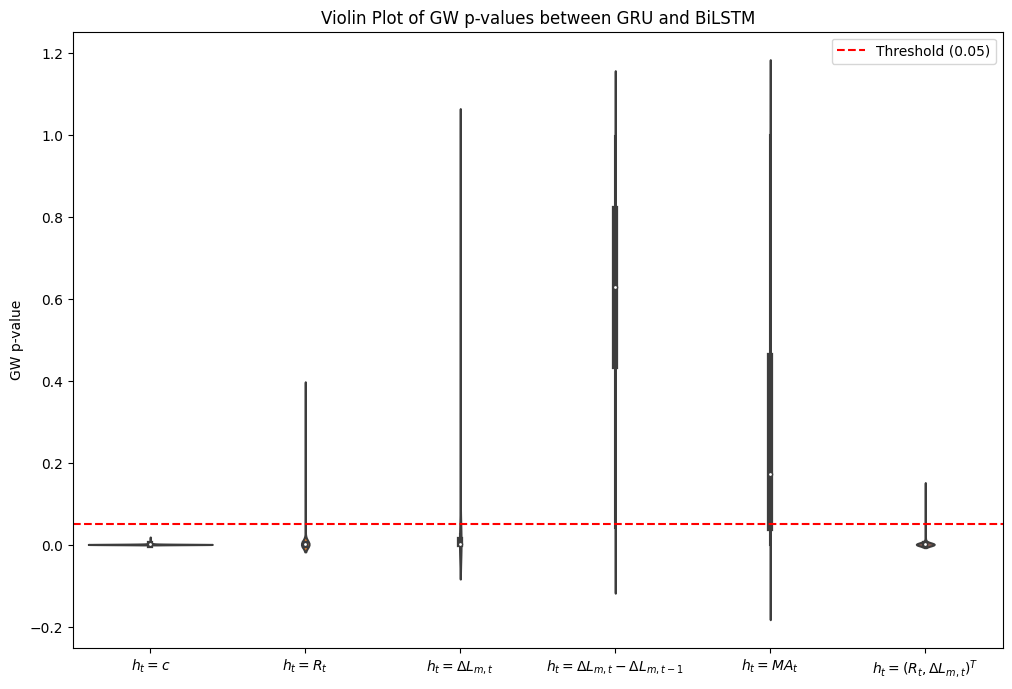

In [311]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=p_values_arrays_BiLSTMvsGRU_gfbm)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('GW p-value')
plt.title('Violin Plot of GW p-values between GRU and BiLSTM')
plt.legend()
plt.show()

### GRU vs RNN

In [312]:
""" loss_values_RNN_Sim_gfbm = np.zeros((n_simulations, n_days - 5))

p_valueGRUvsRNN_constant_gfbm=np.empty(n_simulations)
p_valueGRUvsRNN_interestrate_gfbm=np.empty(n_simulations)
p_valueGRUvsRNN_lossdifference_gfbm=np.empty(n_simulations)
p_valueGRUvsRNN_laggedloss_gfbm=np.empty(n_simulations)
p_value_MA_GRUvsRNN_gfbm=np.empty(n_simulations)
p_valueGRUvsRNN_indicator_lossdifference_gfbm=np.empty(n_simulations)


for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))

    #RNN
    for j in range(n_days - 5):
        loss = RNN_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_RNN_Sim_gfbm[i, j] = loss

    # Constant function
    Z_m_fixedGRUvsRNN_constant=loss_values_RNN_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    Z_m_fixed_barGRUvsRNN_constant=1/n *sum(Z_m_fixedGRUvsRNN_constant)
    omegaGRUvsRNN_constant= 1/n * sum(Z_m_fixedGRUvsRNN_constant*Z_m_fixedGRUvsRNN_constant)
    teststatGRUvsRNN_constant=n*Z_m_fixed_barGRUvsRNN_constant*1/omegaGRUvsRNN_constant*Z_m_fixed_barGRUvsRNN_constant
    # Compute the p-value
    p_valueGRUvsRNN_constant_gfbm[i] = 1 - chi2.cdf(teststatGRUvsRNN_constant, 1)

    # Business cycle indicator
    DeltaGRUvsRNN=(loss_values_RNN_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixedGRUvsRNN_interestrate=h_t_indicator_1x398*(DeltaGRUvsRNN)
    Z_m_fixedGRUvsRNN_bar_interestrate=1/n *Z_m_fixedGRUvsRNN_interestrate.sum().sum()
    omegaGRUvsRNN_interestrate= 1/n * (Z_m_fixedGRUvsRNN_interestrate*Z_m_fixedGRUvsRNN_interestrate).sum().sum()
    teststatGRUvsRNN_interestrate5=n*Z_m_fixedGRUvsRNN_bar_interestrate*1/omegaGRUvsRNN_interestrate*Z_m_fixedGRUvsRNN_bar_interestrate
    # Compute the p-value
    p_valueGRUvsRNN_interestrate_gfbm[i]= 1 - chi2.cdf(teststatGRUvsRNN_interestrate5, 1)

    #Loss difference test function
    h_t_lossdifferenceGRUvsRNN=loss_values_RNN_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    h_t_lossdifferenceGRUvsRNN= np.insert(h_t_lossdifferenceGRUvsRNN, 0, 0)
    h_t_lossdifferenceGRUvsRNN=h_t_lossdifferenceGRUvsRNN.reshape(1, -1)
    Z_m_fixed_GRUvsRNN=h_t_lossdifferenceGRUvsRNN[:, :-1]*(loss_values_GRU_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :])
    Z_m_fixed_bar_GRUvsRNN=1/n *Z_m_fixed_GRUvsRNN.sum()
    omegaGRUvsRNN= 1/n * (Z_m_fixed_GRUvsRNN*Z_m_fixed_GRUvsRNN).sum()
    teststatGRUvsRNN=n*Z_m_fixed_bar_GRUvsRNN*1/omegaGRUvsRNN*Z_m_fixed_bar_GRUvsRNN

    # Compute the p-value
    p_valueGRUvsRNN_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatGRUvsRNN, 1)


    
    # Lagged loss difference
    h_t_lossdifferenceGRUvsRNN=loss_values_RNN_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    two_last_lossdifferenceGRUvsRNN=(train_target_pred_rnn[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
    two_last_lossdifferenceGRUvsRNN = two_last_lossdifferenceGRUvsRNN.reshape((2,))
    h_t_lossdifferenceGRUvsRNN= np.concatenate((two_last_lossdifferenceGRUvsRNN, h_t_lossdifferenceGRUvsRNN))
    h_t_lossdifferenceGRUvsRNN_lagged = h_t_lossdifferenceGRUvsRNN[1:]-h_t_lossdifferenceGRUvsRNN[:-1]
    h_t_lossdifferenceGRUvsRNN_lagged=h_t_lossdifferenceGRUvsRNN_lagged[:-1].reshape(1, -1)
    Z_m_fixed_GRUvsRNN_laggedloss=(h_t_lossdifferenceGRUvsRNN_lagged)*(loss_values_RNN-loss_values_GRU)
    Z_m_fixed_bar_GRUvsRNN_laggedloss=1/n *Z_m_fixed_GRUvsRNN_laggedloss.sum()
    omegaGRUvsRNN_laggedloss= 1/n * (Z_m_fixed_GRUvsRNN_laggedloss*Z_m_fixed_GRUvsRNN_laggedloss).sum()
    teststatGRUvsRNN_laggedloss=n*Z_m_fixed_bar_GRUvsRNN_laggedloss*1/omegaGRUvsRNN_laggedloss*Z_m_fixed_bar_GRUvsRNN_laggedloss
    # Compute the p-value
    p_valueGRUvsRNN_laggedloss_gfbm[i]= 1 - chi2.cdf(teststatGRUvsRNN_laggedloss, 1)

    # Moving Average
    lossdiffer_GRUvsRNN=loss_values_RNN_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]
    three_last_lossdifferenceGRUvsRNN=(train_target_pred_rnn[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
    three_last_lossdifferenceGRUvsRNN = three_last_lossdifferenceGRUvsRNN.reshape((3,))
    lossdiffer_GRUvsRNN= np.concatenate((three_last_lossdifferenceGRUvsRNN, lossdiffer_GRUvsRNN))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_GRUvsRNN = []
    for m in range(k, len(lossdiffer_GRUvsRNN)+1):
        sum_delta = sum(lossdiffer_GRUvsRNN[m-k:m])
        ma = sum_delta / k
        h_t_MA_GRUvsRNN.append(ma)

    Z_m_fixed_MA_GRUvsRNN=h_t_MA_GRUvsRNN[:-1]*(loss_values_RNN_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixed_MA_bar_GRUvsRNN=1/n *Z_m_fixed_MA_GRUvsRNN.sum()
    omegaGRUvsRNN= 1/n * (Z_m_fixed_MA_GRUvsRNN*Z_m_fixed_MA_GRUvsRNN).sum()
    teststatGRUvsRNN=n*Z_m_fixed_MA_bar_GRUvsRNN*1/omegaGRUvsRNN*Z_m_fixed_MA_bar_GRUvsRNN
    # Compute the p-value
    p_value_MA_GRUvsRNN_gfbm[i]= 1 - chi2.cdf(teststatGRUvsRNN, 1) 

    
    # Combination of test functions
    h_t_lossdifferenceGRUvsRNN=loss_values_RNN_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :]

    h_t_lossdifferenceGRUvsRNN= np.insert(h_t_lossdifferenceGRUvsRNN, 0, 0)
    h_t_lossdifferenceGRUvsRNN=h_t_lossdifferenceGRUvsRNN.reshape(1, -1)
    

    h_t_indicator_lossdifferenceGRUvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceGRUvsRNN[:, :-1]))

    DeltaGRUvsRNN=(loss_values_RNN_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm[i, :])
    Z_m_fixed_indicator_lossdifferenceGRUvsRNN=h_t_indicator_lossdifferenceGRUvsRNN*(DeltaGRUvsRNN)
    Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceGRUvsRNN, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN, (2, 1))
    omegaGRUvsRNN_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceGRUvsRNN@(Z_m_fixed_indicator_lossdifferenceGRUvsRNN.T)
    teststatGRUvsRNN_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN.T)@(np.linalg.inv(omegaGRUvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceGRUvsRNN
    # Compute the p-value
    p_valueGRUvsRNN_indicator_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatGRUvsRNN_indicator_lossdifference5, 2)


     """

' loss_values_RNN_Sim_gfbm = np.zeros((n_simulations, n_days - 5))\n\np_valueGRUvsRNN_constant_gfbm=np.empty(n_simulations)\np_valueGRUvsRNN_interestrate_gfbm=np.empty(n_simulations)\np_valueGRUvsRNN_lossdifference_gfbm=np.empty(n_simulations)\np_valueGRUvsRNN_laggedloss_gfbm=np.empty(n_simulations)\np_value_MA_GRUvsRNN_gfbm=np.empty(n_simulations)\np_valueGRUvsRNN_indicator_lossdifference_gfbm=np.empty(n_simulations)\n\n\nfor i in range(n_simulations):\n    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)\n    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))\n\n    #RNN\n    for j in range(n_days - 5):\n        loss = RNN_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]\n        loss_values_RNN_Sim_gfbm[i, j] = loss\n\n    # Constant function\n    Z_m_fixedGRUvsRNN_constant=loss_values_RNN_Sim_gfbm[i, :]-loss_values_GRU_Sim_gfbm

In [313]:
""" 
# Specify the file path where you want to save the array
file_path = "loss_values_RNN_Sim_gfbm.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(loss_values_RNN_Sim_gfbm, binary_file) 

 """

' \n# Specify the file path where you want to save the array\nfile_path = "loss_values_RNN_Sim_gfbm.pkl"\n\n# Save the array to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(loss_values_RNN_Sim_gfbm, binary_file) \n\n '

In [314]:
# Load the data from the binary file
with open("loss_values_RNN_Sim_gfbm.pkl", "rb") as binary_file:
    loss_values_RNN_Sim_gfbm = pickle.load(binary_file)

In [315]:
""" p_values_arrays_RNNvsGRU_gfbm = [p_valueGRUvsRNN_constant_gfbm, p_valueGRUvsRNN_interestrate_gfbm, 
                   p_valueGRUvsRNN_lossdifference_gfbm, p_valueGRUvsRNN_laggedloss_gfbm, 
                   p_value_MA_GRUvsRNN_gfbm, p_valueGRUvsRNN_indicator_lossdifference_gfbm]
 """

' p_values_arrays_RNNvsGRU_gfbm = [p_valueGRUvsRNN_constant_gfbm, p_valueGRUvsRNN_interestrate_gfbm, \n                   p_valueGRUvsRNN_lossdifference_gfbm, p_valueGRUvsRNN_laggedloss_gfbm, \n                   p_value_MA_GRUvsRNN_gfbm, p_valueGRUvsRNN_indicator_lossdifference_gfbm]\n '

In [316]:
""" 
# Specify the file path where you want to save the array
file_path = "p_values_arrays_RNNvsGRU_gfbm.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_RNNvsGRU_gfbm, binary_file) 
 """

' \n# Specify the file path where you want to save the array\nfile_path = "p_values_arrays_RNNvsGRU_gfbm.pkl"\n\n# Save the array to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(p_values_arrays_RNNvsGRU_gfbm, binary_file) \n '

In [317]:

# Load the data from the binary file
with open("p_values_arrays_RNNvsGRU_gfbm.pkl", "rb") as binary_file:
    p_values_arrays_RNNvsGRU_gfbm = pickle.load(binary_file)

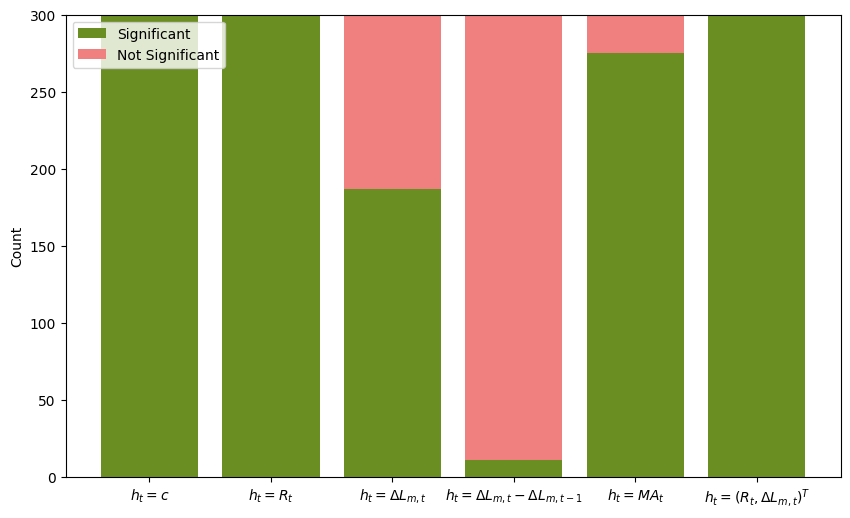

In [318]:
labels = ['$h_t= c$', '$h_t= R_t$', 
          '$h_t=\Delta L_{m,t}$', '$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$', 
          '$h_t=MA_t$', '$h_t=(R_t,\Delta L_{m,t})^T$']

significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_RNNvsGRU_gfbm]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color='olivedrab')
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Count')
#plt.title('Significance of GW p-values between GRU and RNN')
plt.legend()
plt.show()


In [319]:
significant

[300, 300, 187, 11, 275, 300]

In [320]:
not_significant

[0, 0, 113, 289, 25, 0]

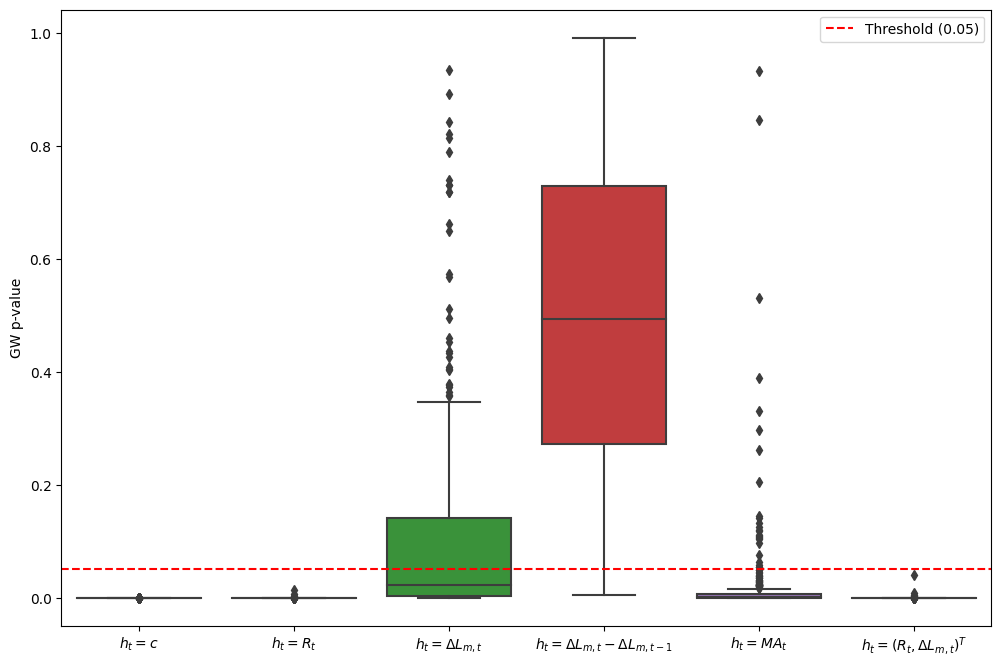

In [321]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_RNNvsGRU_gfbm)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('GW p-value')
#plt.title('Box Plot of GW p-values between GRU and RNN')

plt.legend()
plt.show()


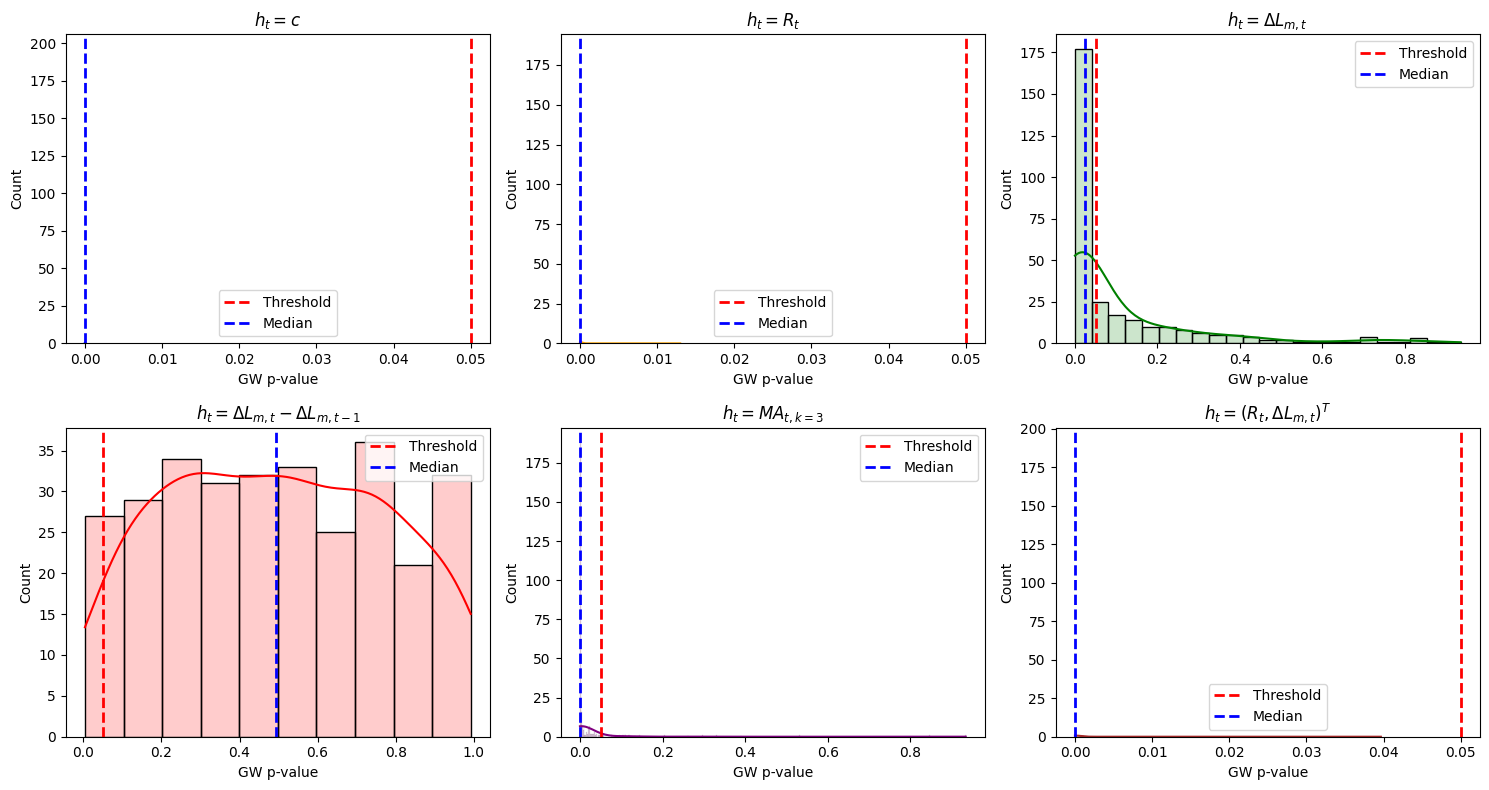

In [403]:


# Define a list of colors for the labels
label_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, label in enumerate(labels):
    row, col = divmod(idx, 3)  # Calculate the subplot row and column
    data = p_values_arrays_RNNvsGRU_gfbm[idx]
    

    # Plot the histograms with the same colors
    sns.histplot(data, color=label_colors[idx % len(label_colors)], kde=True, ax=axes[row, col],alpha=0.2)
    
    # Add threhold lines with a fixed red color
    axes[row, col].axvline(0.05, color='red', linestyle='dashed', linewidth=2, label='Threshold')
    # Add median lines with a fixed red color
    axes[row, col].axvline(np.median(data), color='blue', linestyle='dashed', linewidth=2, label='Median')

    # Set titles for subplots
    axes[row, col].set_title(label)

    # Add legend for the median lines
    axes[row, col].legend()
    axes[row, col].set_xlabel('GW p-value')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [323]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_RNNvsGRU_gfbm[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+---------------------------------------+------------------------+------------------------+------------------------+
|                 Label                 |           Q1           |           Q3           |         Median         |
+---------------------------------------+------------------------+------------------------+------------------------+
|               $h_t= c$                | 8.051920241669563e-12  | 8.567589082630889e-09  | 3.289155614538686e-10  |
|              $h_t= R_t$               | 1.7542840458073528e-08 | 6.6571706423823596e-06 | 3.9741386720359984e-07 |
|         $h_t=\Delta L_{m,t}$          |  0.002579855854162122  |  0.14039309659004895   |  0.023206113465514655  |
| $h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$ |   0.2718073122387835   |   0.7290536969020002   |   0.4944674123526153   |
|              $h_t=MA_t$               | 5.651907748127627e-05  |  0.006198378049925984  |  0.000600508192163951  |
|     $h_t=(R_t,\Delta L_{m,t})^T$      | 5.6863465436318705e-08

###  LSTM vs RNN

In [324]:
""" 
p_valueRNNvsLSTM_constant_gfbm=np.empty(n_simulations)
p_valueLSTMvsRNN_interestrate_gfbm=np.empty(n_simulations)
p_valueLSTMvsRNN_lossdifference_gfbm=np.empty(n_simulations)
p_valueLSTMvsRNN_laggedloss_gfbm=np.empty(n_simulations)
p_value_MA_LSTMvsRNN_gfbm=np.empty(n_simulations)
p_valueRNNvsLSTM_indicator_lossdifference_gfbm=np.empty(n_simulations)

for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))

    # Constant function
    Z_m_fixedRNNvsLSTM_constant=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]
    Z_m_fixed_barRNNvsLSTM_constant=1/n *sum(Z_m_fixedRNNvsLSTM_constant)
    omegaRNNvsLSTM_constant= 1/n * sum(Z_m_fixedRNNvsLSTM_constant*Z_m_fixedRNNvsLSTM_constant)
    teststatRNNvsLSTM_constant=n*Z_m_fixed_barRNNvsLSTM_constant*1/omegaRNNvsLSTM_constant*Z_m_fixed_barRNNvsLSTM_constant
    # Compute the p-value
    p_valueRNNvsLSTM_constant_gfbm[i] = 1 - chi2.cdf(teststatRNNvsLSTM_constant, 1)



    
    # Business cycle indicator
    DeltaRNNsLSTM=(loss_values_LSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :])
    Z_m_fixedRNNvsLSTM_interestrate=h_t_indicator_1x398*(DeltaRNNsLSTM)
    Z_m_fixedRNNvsLSTM_bar_interestrate=1/n *Z_m_fixedRNNvsLSTM_interestrate.sum().sum()
    omegaRNNvsLSTM_interestrate= 1/n * (Z_m_fixedRNNvsLSTM_interestrate*Z_m_fixedRNNvsLSTM_interestrate).sum().sum()
    teststatLSTMvsRNN_interestrate5=n*Z_m_fixedRNNvsLSTM_bar_interestrate*1/omegaRNNvsLSTM_interestrate*Z_m_fixedRNNvsLSTM_bar_interestrate
    # Compute the p-value
    p_valueLSTMvsRNN_interestrate_gfbm[i]= 1 - chi2.cdf(teststatLSTMvsRNN_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)
    Z_m_fixed_LSTMvsRNN=h_t_lossdifferenceLSTMvsRNN[:, :-1]*(loss_values_LSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :])
    Z_m_fixed_bar_LSTMvsRNN=1/n *Z_m_fixed_LSTMvsRNN.sum()
    omegaLSTMvsRNN= 1/n * (Z_m_fixed_LSTMvsRNN*Z_m_fixed_LSTMvsRNN).sum()
    teststatLSTMvsRNN=n*Z_m_fixed_bar_LSTMvsRNN*1/omegaLSTMvsRNN*Z_m_fixed_bar_LSTMvsRNN
    # Compute the p-value
    p_valueLSTMvsRNN_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatLSTMvsRNN, 1)

    # Lagged loss difference
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]
    two_last_lossdifferenceLSTMvsRNN=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
    two_last_lossdifferenceLSTMvsRNN = two_last_lossdifferenceLSTMvsRNN.reshape((2,))
    h_t_lossdifferenceLSTMvsRNN= np.concatenate((two_last_lossdifferenceLSTMvsRNN, h_t_lossdifferenceLSTMvsRNN))
    h_t_lossdifferenceLSTMvsRNN_lagged = h_t_lossdifferenceLSTMvsRNN[1:]-h_t_lossdifferenceLSTMvsRNN[:-1]
    h_t_lossdifferenceLSTMvsRNN_lagged=h_t_lossdifferenceLSTMvsRNN_lagged[:-1].reshape(1, -1)
    Z_m_fixed_LSTMvsRNN_laggedloss=(h_t_lossdifferenceLSTMvsRNN_lagged)*(loss_values_LSTM-loss_values_RNN)
    Z_m_fixed_bar_LSTMvsRNN_laggedloss=1/n *Z_m_fixed_LSTMvsRNN_laggedloss.sum()
    omegaLSTMvsRNN_laggedloss= 1/n * (Z_m_fixed_LSTMvsRNN_laggedloss*Z_m_fixed_LSTMvsRNN_laggedloss).sum()
    teststatLSTMvsRNN_laggedloss=n*Z_m_fixed_bar_LSTMvsRNN_laggedloss*1/omegaLSTMvsRNN_laggedloss*Z_m_fixed_bar_LSTMvsRNN_laggedloss
    # Compute the p-value
    p_valueLSTMvsRNN_laggedloss_gfbm[i]= 1 - chi2.cdf(teststatLSTMvsRNN_laggedloss, 1)

    
    # Moving Average
    lossdiffer_RNNvsLSTM=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]
    three_last_lossdifferenceLSTMvsRNN=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_rnn[-3:].T-train_target[-3:])
    three_last_lossdifferenceLSTMvsRNN = three_last_lossdifferenceLSTMvsRNN.reshape((3,))
    lossdiffer_RNNvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsRNN, lossdiffer_RNNvsLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_LSTMvsRNN = []
    for m in range(k, len(lossdiffer_RNNvsLSTM)+1):
        sum_delta = sum(lossdiffer_RNNvsLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_LSTMvsRNN.append(ma)

    Z_m_fixed_MA_LSTMvsRNN=h_t_MA_LSTMvsRNN[:-1]*(loss_values_LSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :])
    Z_m_fixed_MA_bar_LSTMvsRNN=1/n *Z_m_fixed_MA_LSTMvsRNN.sum()
    omegaLSTMvsRNN= 1/n * (Z_m_fixed_MA_LSTMvsRNN*Z_m_fixed_MA_LSTMvsRNN).sum()
    teststatLSTMvsRNN=n*Z_m_fixed_MA_bar_LSTMvsRNN*1/omegaLSTMvsRNN*Z_m_fixed_MA_bar_LSTMvsRNN
    # Compute the p-value
    p_value_MA_LSTMvsRNN_gfbm[i]= 1 - chi2.cdf(teststatLSTMvsRNN, 1)


    # Combination of test functions
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)

    h_t_indicator_lossdifferenceLSTMvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsRNN[:, :-1]))

    DeltaLSTMvsRNN=(loss_values_LSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :])
    Z_m_fixed_indicator_lossdifferenceLSTMvsRNN=h_t_indicator_lossdifferenceLSTMvsRNN*(DeltaLSTMvsRNN)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN, (2, 1))
    omegaLSTMvsRNN_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceLSTMvsRNN@(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN.T)
    teststatLSTMvsRNN_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN.T)@(np.linalg.inv(omegaLSTMvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN
    # Compute the p-value
    p_valueRNNvsLSTM_indicator_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatLSTMvsRNN_indicator_lossdifference5, 2)
     """

' \np_valueRNNvsLSTM_constant_gfbm=np.empty(n_simulations)\np_valueLSTMvsRNN_interestrate_gfbm=np.empty(n_simulations)\np_valueLSTMvsRNN_lossdifference_gfbm=np.empty(n_simulations)\np_valueLSTMvsRNN_laggedloss_gfbm=np.empty(n_simulations)\np_value_MA_LSTMvsRNN_gfbm=np.empty(n_simulations)\np_valueRNNvsLSTM_indicator_lossdifference_gfbm=np.empty(n_simulations)\n\nfor i in range(n_simulations):\n    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)\n    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))\n\n    # Constant function\n    Z_m_fixedRNNvsLSTM_constant=loss_values_LSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]\n    Z_m_fixed_barRNNvsLSTM_constant=1/n *sum(Z_m_fixedRNNvsLSTM_constant)\n    omegaRNNvsLSTM_constant= 1/n * sum(Z_m_fixedRNNvsLSTM_constant*Z_m_fixedRNNvsLSTM_constant)\n    teststatRNNvsLSTM_constant=n*Z_m_fixed_barRNNvsLSTM_constant*1/omegaRNNvsLSTM_cons

In [325]:
""" p_values_arrays_LSTMvsRNN_gfbm = [p_valueRNNvsLSTM_constant_gfbm, p_valueLSTMvsRNN_interestrate_gfbm, 
                   p_valueLSTMvsRNN_lossdifference_gfbm, p_valueLSTMvsRNN_laggedloss_gfbm, 
                   p_value_MA_LSTMvsRNN_gfbm, p_valueRNNvsLSTM_indicator_lossdifference_gfbm]
 """

' p_values_arrays_LSTMvsRNN_gfbm = [p_valueRNNvsLSTM_constant_gfbm, p_valueLSTMvsRNN_interestrate_gfbm, \n                   p_valueLSTMvsRNN_lossdifference_gfbm, p_valueLSTMvsRNN_laggedloss_gfbm, \n                   p_value_MA_LSTMvsRNN_gfbm, p_valueRNNvsLSTM_indicator_lossdifference_gfbm]\n '

In [326]:
""" 
# Specify the file path where you want to save the array
file_path = "p_values_arrays_LSTMvsRNN_gfbm.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_LSTMvsRNN_gfbm, binary_file) 
 """

' \n# Specify the file path where you want to save the array\nfile_path = "p_values_arrays_LSTMvsRNN_gfbm.pkl"\n\n# Save the array to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(p_values_arrays_LSTMvsRNN_gfbm, binary_file) \n '

In [327]:
# Load the data from the binary file
with open("p_values_arrays_LSTMvsRNN_gfbm.pkl", "rb") as binary_file:
    p_values_arrays_LSTMvsRNN_gfbm = pickle.load(binary_file)

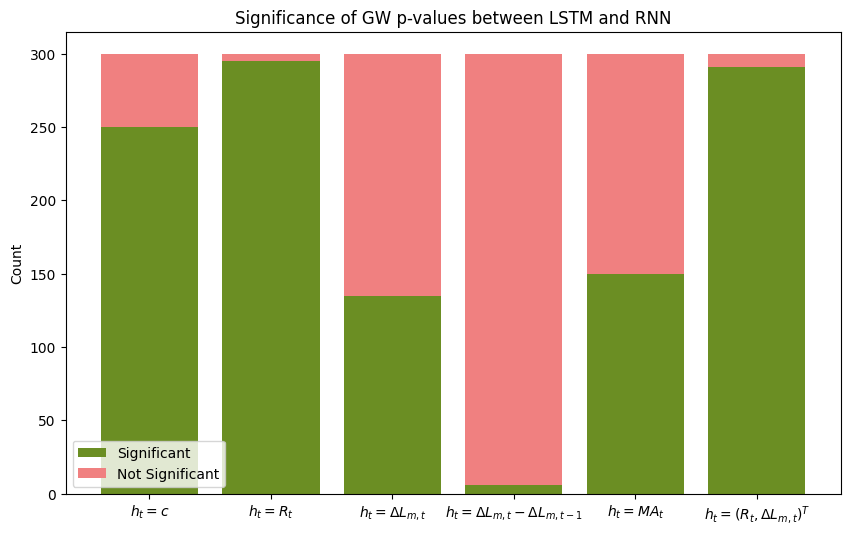

In [328]:
labels = ['$h_t= c$', '$h_t= R_t$', 
          '$h_t=\Delta L_{m,t}$', '$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$', 
          '$h_t=MA_t$', '$h_t=(R_t,\Delta L_{m,t})^T$']


significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_LSTMvsRNN_gfbm]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color='olivedrab')
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Count')
plt.title('Significance of GW p-values between LSTM and RNN')
plt.legend()
plt.show()


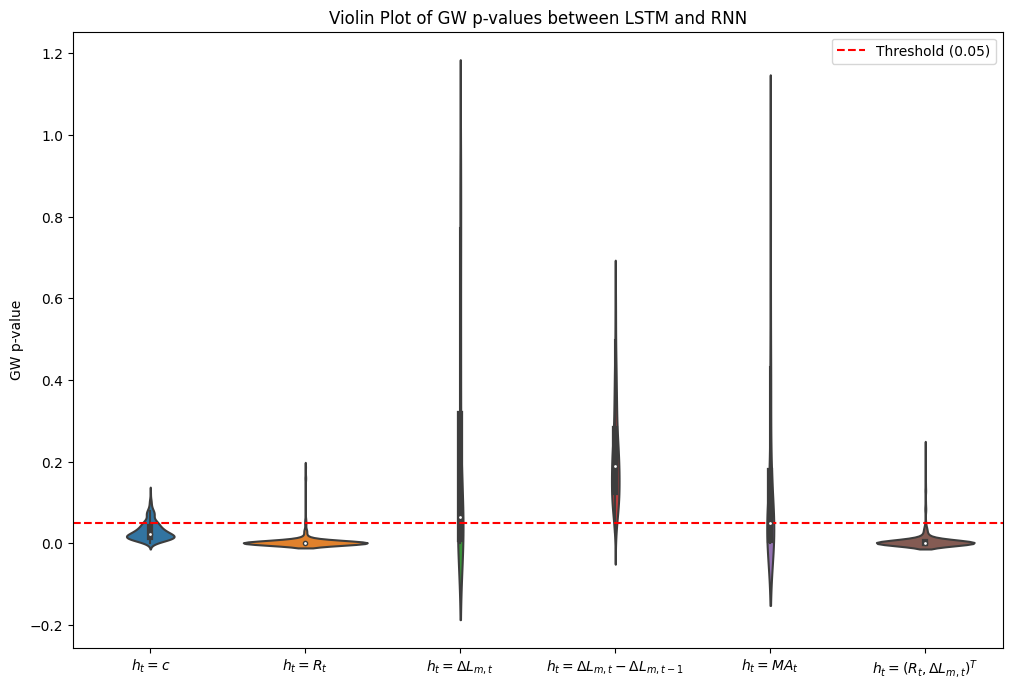

In [329]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=p_values_arrays_LSTMvsRNN_gfbm)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('GW p-value')
plt.title('Violin Plot of GW p-values between LSTM and RNN')
plt.legend()
plt.show()

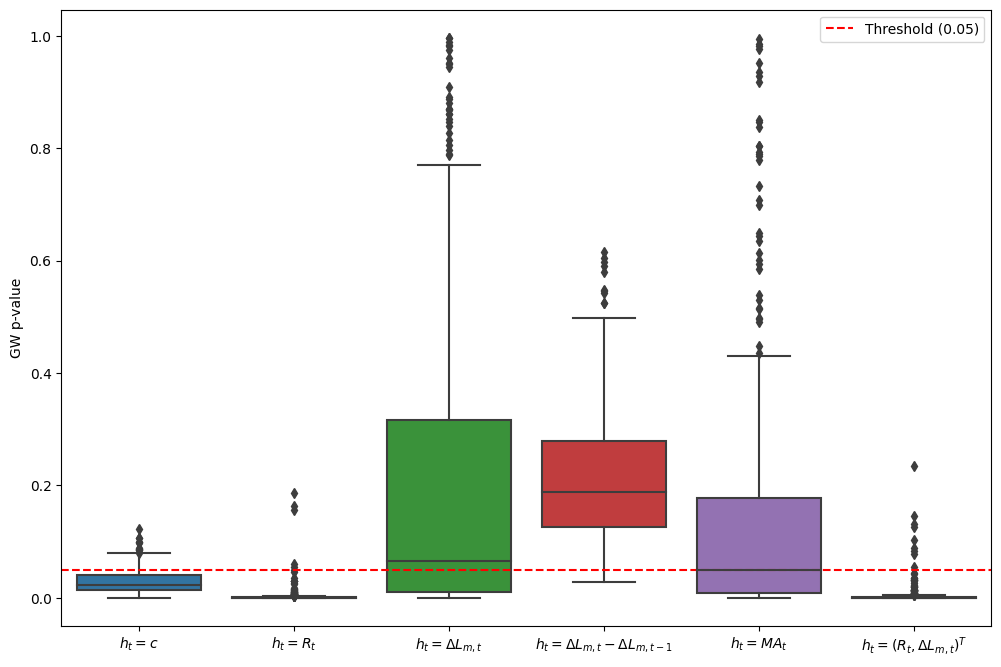

In [330]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_LSTMvsRNN_gfbm)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('GW p-value')
#plt.title('Box Plot of GW p-values between LSTM and RNN')

plt.legend()
plt.show()


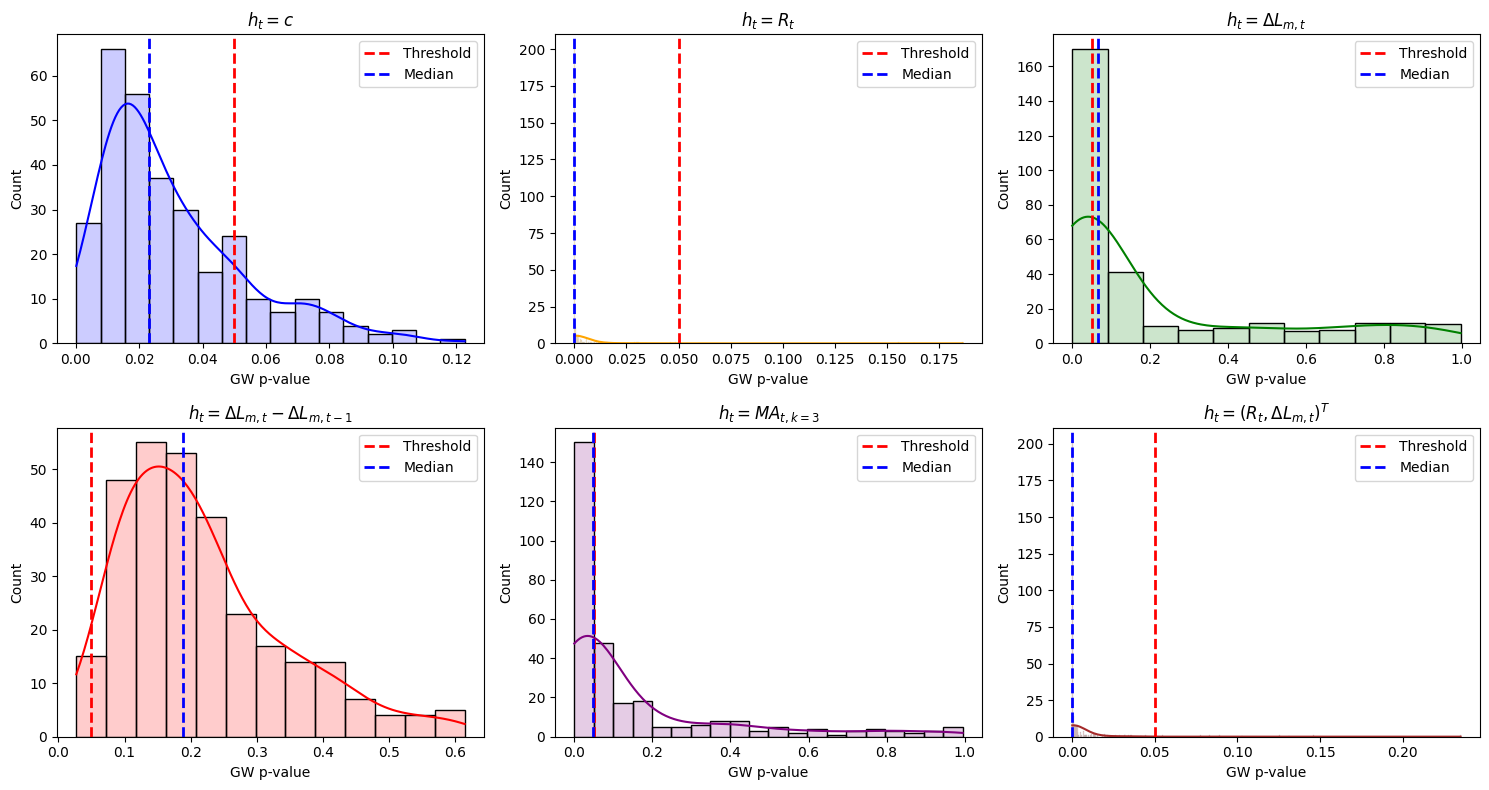

In [404]:


# Define a list of colors for the labels
label_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, label in enumerate(labels):
    row, col = divmod(idx, 3)  # Calculate the subplot row and column
    data = p_values_arrays_LSTMvsRNN_gfbm[idx]
    

    # Plot the histograms with the same colors
    sns.histplot(data, color=label_colors[idx % len(label_colors)], kde=True, ax=axes[row, col],alpha=0.2)
    
    # Add threhold lines with a fixed red color
    axes[row, col].axvline(0.05, color='red', linestyle='dashed', linewidth=2, label='Threshold')
    # Add median lines with a fixed red color
    axes[row, col].axvline(np.median(data), color='blue', linestyle='dashed', linewidth=2, label='Median')

    # Set titles for subplots
    axes[row, col].set_title(label)

    # Add legend for the median lines
    axes[row, col].legend()
    axes[row, col].set_xlabel('GW p-value')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [332]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_LSTMvsRNN_gfbm[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+---------------------------------------+-----------------------+-----------------------+-----------------------+
|                 Label                 |          Q1           |          Q3           |        Median         |
+---------------------------------------+-----------------------+-----------------------+-----------------------+
|               $h_t= c$                | 0.014034901055196669  |  0.04036340770851332  |  0.02324474919502889  |
|              $h_t= R_t$               | 2.768214514392575e-06 | 0.0009583273717450602 | 4.941046387263448e-05 |
|         $h_t=\Delta L_{m,t}$          | 0.010338477541461166  |  0.31608993281191605  |  0.06502936032209289  |
| $h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$ |  0.12650460636648955  |  0.2793438361663727   |  0.18828383923991404  |
|              $h_t=MA_t$               | 0.008593304944141816  |  0.1775644635573144   |  0.04910422749174803  |
|     $h_t=(R_t,\Delta L_{m,t})^T$      | 5.578336564809883e-06 | 0.0018022801884803319 

In [333]:
""" # Lagged loss when I added 2 number 0 instead of the true values
Sim = np.zeros((n_simulations, n_days))
loss_values_LSTM_Sim = np.zeros((n_simulations, n_days - 5))
loss_values_RNN_Sim = np.zeros((n_simulations, n_days - 5))

p_valueRNNvsLSTM_constant=np.empty(n_simulations)
p_valueLSTMvsRNN_interestrate=np.empty(n_simulations)
p_valueLSTMvsRNN_lossdifference=np.empty(n_simulations)
p_valueLSTMvsRNN_laggedloss=np.empty(n_simulations)
p_value_MA_LSTMvsRNN=np.empty(n_simulations)
p_valueRNNvsLSTM_indicator_lossdifference=np.empty(n_simulations)

for i in range(n_simulations):
    Sim[i, :] = fgbm_paths[i, :]
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))

    # LSTM
    for j in range(n_days - 5):
    
        loss = LSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_LSTM_Sim[i, j] = loss

    #GRU
    for j in range(n_days - 5):
        loss = RNN_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1], verbose=0)[0]
        loss_values_RNN_Sim[i, j] = loss



    # Constant function
    Z_m_fixedRNNvsLSTM_constant=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    Z_m_fixed_barRNNvsLSTM_constant=1/n *sum(Z_m_fixedRNNvsLSTM_constant)
    omegaRNNvsLSTM_constant= 1/n * sum(Z_m_fixedRNNvsLSTM_constant*Z_m_fixedRNNvsLSTM_constant)
    teststatRNNvsLSTM_constant=n*Z_m_fixed_barRNNvsLSTM_constant*1/omegaRNNvsLSTM_constant*Z_m_fixed_barRNNvsLSTM_constant
    # Compute the p-value
    p_valueRNNvsLSTM_constant[i] = 1 - chi2.cdf(teststatRNNvsLSTM_constant, 1)



    
    # Business cycle indicator
    DeltaRNNsLSTM=(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixedRNNvsLSTM_interestrate=h_t_indicator_1x398*(DeltaRNNsLSTM)
    Z_m_fixedRNNvsLSTM_bar_interestrate=1/n *Z_m_fixedRNNvsLSTM_interestrate.sum().sum()
    omegaRNNvsLSTM_interestrate= 1/n * (Z_m_fixedRNNvsLSTM_interestrate*Z_m_fixedRNNvsLSTM_interestrate).sum().sum()
    teststatLSTMvsRNN_interestrate5=n*Z_m_fixedRNNvsLSTM_bar_interestrate*1/omegaRNNvsLSTM_interestrate*Z_m_fixedRNNvsLSTM_bar_interestrate
    # Compute the p-value
    p_valueLSTMvsRNN_interestrate[i]= 1 - chi2.cdf(teststatLSTMvsRNN_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)
    Z_m_fixed_LSTMvsRNN=h_t_lossdifferenceLSTMvsRNN[:, :-1]*(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_bar_LSTMvsRNN=1/n *Z_m_fixed_LSTMvsRNN.sum()
    omegaLSTMvsRNN= 1/n * (Z_m_fixed_LSTMvsRNN*Z_m_fixed_LSTMvsRNN).sum()
    teststatLSTMvsRNN=n*Z_m_fixed_bar_LSTMvsRNN*1/omegaLSTMvsRNN*Z_m_fixed_bar_LSTMvsRNN
    # Compute the p-value
    p_valueLSTMvsRNN_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsRNN, 1)

    # Lagged loss difference
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceLSTMvsRNN = np.insert(h_t_lossdifferenceLSTMvsRNN, 0, [0, 0])

    h_t_lossdifferenceLSTMvsRNN_lagged = h_t_lossdifferenceLSTMvsRNN[1:]-h_t_lossdifferenceLSTMvsRNN[:-1]
    h_t_lossdifferenceLSTMvsRNN_lagged=h_t_lossdifferenceLSTMvsRNN_lagged[:-1].reshape(1, -1)
    Z_m_fixed_LSTMvsRNN_laggedloss=(h_t_lossdifferenceLSTMvsRNN_lagged)*(loss_values_LSTM-loss_values_RNN)
    Z_m_fixed_bar_LSTMvsRNN_laggedloss=1/n *Z_m_fixed_LSTMvsRNN_laggedloss.sum()
    omegaLSTMvsRNN_laggedloss= 1/n * (Z_m_fixed_LSTMvsRNN_laggedloss*Z_m_fixed_LSTMvsRNN_laggedloss).sum()
    teststatLSTMvsRNN_laggedloss=n*Z_m_fixed_bar_LSTMvsRNN_laggedloss*1/omegaLSTMvsRNN_laggedloss*Z_m_fixed_bar_LSTMvsRNN_laggedloss
    # Compute the p-value
    p_valueLSTMvsRNN_laggedloss[i]= 1 - chi2.cdf(teststatLSTMvsRNN_laggedloss, 1)

    
    # Moving Average
    lossdiffer_RNNvsLSTM=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    three_last_lossdifferenceLSTMvsRNN=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_rnn[-3:].T-train_target[-3:])
    three_last_lossdifferenceLSTMvsRNN = three_last_lossdifferenceLSTMvsRNN.reshape((3,))
    lossdiffer_RNNvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsRNN, lossdiffer_RNNvsLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_LSTMvsRNN = []
    for m in range(k, len(lossdiffer_RNNvsLSTM)+1):
        sum_delta = sum(lossdiffer_RNNvsLSTM[m-k:i])
        ma = sum_delta / k
        h_t_MA_LSTMvsRNN.append(ma)

    Z_m_fixed_MA_LSTMvsRNN=h_t_MA_LSTMvsRNN[:-1]*(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_MA_bar_LSTMvsRNN=1/n *Z_m_fixed_MA_LSTMvsRNN.sum()
    omegaLSTMvsRNN= 1/n * (Z_m_fixed_MA_LSTMvsRNN*Z_m_fixed_MA_LSTMvsRNN).sum()
    teststatLSTMvsRNN=n*Z_m_fixed_MA_bar_LSTMvsRNN*1/omegaLSTMvsRNN*Z_m_fixed_MA_bar_LSTMvsRNN
    # Compute the p-value
    p_value_MA_LSTMvsRNN[i]= 1 - chi2.cdf(teststatLSTMvsRNN, 1)


    # Combination of test functions
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)

    h_t_indicator_lossdifferenceLSTMvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsRNN[:, :-1]))

    DeltaLSTMvsRNN=(loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :])
    Z_m_fixed_indicator_lossdifferenceLSTMvsRNN=h_t_indicator_lossdifferenceLSTMvsRNN*(DeltaLSTMvsRNN)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN, (2, 1))
    omegaLSTMvsRNN_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceLSTMvsRNN@(Z_m_fixed_indicator_lossdifferenceLSTMvsRNN.T)
    teststatLSTMvsRNN_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN.T)@(np.linalg.inv(omegaLSTMvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceLSTMvsRNN
    # Compute the p-value
    p_valueRNNvsLSTM_indicator_lossdifference[i]= 1 - chi2.cdf(teststatLSTMvsRNN_indicator_lossdifference5, 2)
     """

' # Lagged loss when I added 2 number 0 instead of the true values\nSim = np.zeros((n_simulations, n_days))\nloss_values_LSTM_Sim = np.zeros((n_simulations, n_days - 5))\nloss_values_RNN_Sim = np.zeros((n_simulations, n_days - 5))\n\np_valueRNNvsLSTM_constant=np.empty(n_simulations)\np_valueLSTMvsRNN_interestrate=np.empty(n_simulations)\np_valueLSTMvsRNN_lossdifference=np.empty(n_simulations)\np_valueLSTMvsRNN_laggedloss=np.empty(n_simulations)\np_value_MA_LSTMvsRNN=np.empty(n_simulations)\np_valueRNNvsLSTM_indicator_lossdifference=np.empty(n_simulations)\n\nfor i in range(n_simulations):\n    Sim[i, :] = fgbm_paths[i, :]\n    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim[i, :], 1).values, look_back=5)\n    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))\n\n    # LSTM\n    for j in range(n_days - 5):\n    \n        loss = LSTM_model.evaluate(test_predictor_Sim_reshape[j:j+1, :, :], test_target_Sim[j:j+1],

In [334]:
""" # Lagged loss when I added 2 number 0 instead of the true values
# Reducted version =)) same result
Sim = np.zeros((n_simulations, n_days))

p_valueRNNvsLSTM_constant2=np.empty(n_simulations)
p_valueLSTMvsRNN_laggedloss2=np.empty(n_simulations)

for i in range(n_simulations):
    
    # Constant function
    Z_m_fixedRNNvsLSTM_constant=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    Z_m_fixed_barRNNvsLSTM_constant=1/n *sum(Z_m_fixedRNNvsLSTM_constant)
    omegaRNNvsLSTM_constant= 1/n * sum(Z_m_fixedRNNvsLSTM_constant*Z_m_fixedRNNvsLSTM_constant)
    teststatRNNvsLSTM_constant=n*Z_m_fixed_barRNNvsLSTM_constant*1/omegaRNNvsLSTM_constant*Z_m_fixed_barRNNvsLSTM_constant
    # Compute the p-value
    p_valueRNNvsLSTM_constant2[i] = 1 - chi2.cdf(teststatRNNvsLSTM_constant, 1)


    # Lagged loss difference
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]
    h_t_lossdifferenceLSTMvsRNN = np.insert(h_t_lossdifferenceLSTMvsRNN, 0, [0, 0])

    h_t_lossdifferenceLSTMvsRNN_lagged = h_t_lossdifferenceLSTMvsRNN[1:]-h_t_lossdifferenceLSTMvsRNN[:-1]
    h_t_lossdifferenceLSTMvsRNN_lagged=h_t_lossdifferenceLSTMvsRNN_lagged[:-1].reshape(1, -1)
    Z_m_fixed_LSTMvsRNN_laggedloss=(h_t_lossdifferenceLSTMvsRNN_lagged)*(loss_values_LSTM-loss_values_RNN)
    Z_m_fixed_bar_LSTMvsRNN_laggedloss=1/n *Z_m_fixed_LSTMvsRNN_laggedloss.sum()
    omegaLSTMvsRNN_laggedloss= 1/n * (Z_m_fixed_LSTMvsRNN_laggedloss*Z_m_fixed_LSTMvsRNN_laggedloss).sum()
    teststatLSTMvsRNN_laggedloss=n*Z_m_fixed_bar_LSTMvsRNN_laggedloss*1/omegaLSTMvsRNN_laggedloss*Z_m_fixed_bar_LSTMvsRNN_laggedloss
    # Compute the p-value
    p_valueLSTMvsRNN_laggedloss2[i]= 1 - chi2.cdf(teststatLSTMvsRNN_laggedloss, 1)

    
    
     """

' # Lagged loss when I added 2 number 0 instead of the true values\n# Reducted version =)) same result\nSim = np.zeros((n_simulations, n_days))\n\np_valueRNNvsLSTM_constant2=np.empty(n_simulations)\np_valueLSTMvsRNN_laggedloss2=np.empty(n_simulations)\n\nfor i in range(n_simulations):\n    \n    # Constant function\n    Z_m_fixedRNNvsLSTM_constant=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]\n    Z_m_fixed_barRNNvsLSTM_constant=1/n *sum(Z_m_fixedRNNvsLSTM_constant)\n    omegaRNNvsLSTM_constant= 1/n * sum(Z_m_fixedRNNvsLSTM_constant*Z_m_fixedRNNvsLSTM_constant)\n    teststatRNNvsLSTM_constant=n*Z_m_fixed_barRNNvsLSTM_constant*1/omegaRNNvsLSTM_constant*Z_m_fixed_barRNNvsLSTM_constant\n    # Compute the p-value\n    p_valueRNNvsLSTM_constant2[i] = 1 - chi2.cdf(teststatRNNvsLSTM_constant, 1)\n\n\n    # Lagged loss difference\n    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim[i, :]-loss_values_RNN_Sim[i, :]\n    h_t_lossdifferenceLSTMvsRNN = np.insert(h_t_lossdifferenceLSTMvsRNN,

### BiLSTM vs RNN

In [335]:
""" 

p_valueRNNvsBiLSTM_constant_gfbm=np.empty(n_simulations)
p_valueBiLSTMvsRNN_interestrate_gfbm=np.empty(n_simulations)
p_valueBiLSTMvsRNN_lossdifference_gfbm=np.empty(n_simulations)
p_valueBiLSTMvsRNN_laggedloss_gfbm=np.empty(n_simulations)
p_value_MA_BiLSTMvsRNN_gfbm=np.empty(n_simulations)
p_valueRNNvsBiLSTM_indicator_lossdifference_gfbm=np.empty(n_simulations)



for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))
    

    # Constant function
    Z_m_fixedRNNvsBiLSTM_constant=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]
    Z_m_fixed_barRNNvsBiLSTM_constant=1/n *sum(Z_m_fixedRNNvsBiLSTM_constant)
    omegaRNNvsBiLSTM_constant= 1/n * sum(Z_m_fixedRNNvsBiLSTM_constant*Z_m_fixedRNNvsBiLSTM_constant)
    teststatRNNvsBiLSTM_constant=n*Z_m_fixed_barRNNvsBiLSTM_constant*1/omegaRNNvsBiLSTM_constant*Z_m_fixed_barRNNvsBiLSTM_constant
    # Compute the p-value
    p_valueRNNvsBiLSTM_constant_gfbm[i] = 1 - chi2.cdf(teststatRNNvsBiLSTM_constant, 1)



    # Business cycle indicator
    DeltaRNNsBiLSTM=(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :])
    Z_m_fixedRNNvsBiLSTM_interestrate=h_t_indicator_1x398*(DeltaRNNsBiLSTM)
    Z_m_fixedRNNvsBiLSTM_bar_interestrate=1/n *Z_m_fixedRNNvsBiLSTM_interestrate.sum().sum()
    omegaRNNvsBiLSTM_interestrate= 1/n * (Z_m_fixedRNNvsBiLSTM_interestrate*Z_m_fixedRNNvsBiLSTM_interestrate).sum().sum()
    teststatBiLSTMvsRNN_interestrate5=n*Z_m_fixedRNNvsBiLSTM_bar_interestrate*1/omegaRNNvsBiLSTM_interestrate*Z_m_fixedRNNvsBiLSTM_bar_interestrate
    # Compute the p-value
    p_valueBiLSTMvsRNN_interestrate_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsRNN_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]
    h_t_lossdifferenceBiLSTMvsRNN= np.insert(h_t_lossdifferenceBiLSTMvsRNN, 0, 0)
    h_t_lossdifferenceBiLSTMvsRNN=h_t_lossdifferenceBiLSTMvsRNN.reshape(1, -1)
    Z_m_fixed_BiLSTMvsRNN=h_t_lossdifferenceBiLSTMvsRNN[:, :-1]*(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :])
    Z_m_fixed_bar_BiLSTMvsRNN=1/n *Z_m_fixed_BiLSTMvsRNN.sum()
    omegaBiLSTMvsRNN= 1/n * (Z_m_fixed_BiLSTMvsRNN*Z_m_fixed_BiLSTMvsRNN).sum()
    teststatBiLSTMvsRNN=n*Z_m_fixed_bar_BiLSTMvsRNN*1/omegaBiLSTMvsRNN*Z_m_fixed_bar_BiLSTMvsRNN
    # Compute the p-value
    p_valueBiLSTMvsRNN_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsRNN, 1)

    # Lagged loss difference
    h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]
    two_last_lossdifferenceBiLSTMvsRNN=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
    two_last_lossdifferenceBiLSTMvsRNN = two_last_lossdifferenceBiLSTMvsRNN.reshape((2,))
    h_t_lossdifferenceBiLSTMvsRNN= np.concatenate((two_last_lossdifferenceBiLSTMvsRNN, h_t_lossdifferenceBiLSTMvsRNN))
    h_t_lossdifferenceBiLSTMvsRNN_lagged = h_t_lossdifferenceBiLSTMvsRNN[1:]-h_t_lossdifferenceBiLSTMvsRNN[:-1]
    h_t_lossdifferenceBiLSTMvsRNN_lagged=h_t_lossdifferenceBiLSTMvsRNN_lagged[:-1].reshape(1, -1)
    Z_m_fixed_BiLSTMvsRNN_laggedloss=(h_t_lossdifferenceBiLSTMvsRNN_lagged)*(loss_values_BiLSTM-loss_values_RNN)
    Z_m_fixed_bar_BiLSTMvsRNN_laggedloss=1/n *Z_m_fixed_BiLSTMvsRNN_laggedloss.sum()
    omegaBiLSTMvsRNN_laggedloss= 1/n * (Z_m_fixed_BiLSTMvsRNN_laggedloss*Z_m_fixed_BiLSTMvsRNN_laggedloss).sum()
    teststatBiLSTMvsRNN_laggedloss=n*Z_m_fixed_bar_BiLSTMvsRNN_laggedloss*1/omegaBiLSTMvsRNN_laggedloss*Z_m_fixed_bar_BiLSTMvsRNN_laggedloss
    # Compute the p-value
    p_valueBiLSTMvsRNN_laggedloss_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsRNN_laggedloss, 1)

    
    # Moving Average
    lossdiffer_RNNvsBiLSTM=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]
    three_last_lossdifferenceBiLSTMvsRNN=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred_rnn[-3:].T-train_target[-3:])
    three_last_lossdifferenceBiLSTMvsRNN = three_last_lossdifferenceBiLSTMvsRNN.reshape((3,))
    lossdiffer_RNNvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsRNN, lossdiffer_RNNvsBiLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_BiLSTMvsRNN = []
    for m in range(k, len(lossdiffer_RNNvsBiLSTM)+1):
        sum_delta = sum(lossdiffer_RNNvsBiLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_BiLSTMvsRNN.append(ma)

    Z_m_fixed_MA_BiLSTMvsRNN=h_t_MA_BiLSTMvsRNN[:-1]*(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :])
    Z_m_fixed_MA_bar_BiLSTMvsRNN=1/n *Z_m_fixed_MA_BiLSTMvsRNN.sum()
    omegaBiLSTMvsRNN= 1/n * (Z_m_fixed_MA_BiLSTMvsRNN*Z_m_fixed_MA_BiLSTMvsRNN).sum()
    teststatBiLSTMvsRNN=n*Z_m_fixed_MA_bar_BiLSTMvsRNN*1/omegaBiLSTMvsRNN*Z_m_fixed_MA_bar_BiLSTMvsRNN
    # Compute the p-value
    p_value_MA_BiLSTMvsRNN_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsRNN, 1)


    # Combination of test functions
    h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]
    h_t_lossdifferenceBiLSTMvsRNN= np.insert(h_t_lossdifferenceBiLSTMvsRNN, 0, 0)
    h_t_lossdifferenceBiLSTMvsRNN=h_t_lossdifferenceBiLSTMvsRNN.reshape(1, -1)

    h_t_indicator_lossdifferenceBiLSTMvsRNN=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsRNN[:, :-1]))

    DeltaBiLSTMvsRNN=(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :])
    Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN=h_t_indicator_lossdifferenceBiLSTMvsRNN*(DeltaBiLSTMvsRNN)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN, (2, 1))
    omegaBiLSTMvsRNN_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsRNN.T)
    teststatBiLSTMvsRNN_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN.T)@(np.linalg.inv(omegaBiLSTMvsRNN_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsRNN
    # Compute the p-value
    p_valueRNNvsBiLSTM_indicator_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsRNN_indicator_lossdifference5, 2)
     """

' \n\np_valueRNNvsBiLSTM_constant_gfbm=np.empty(n_simulations)\np_valueBiLSTMvsRNN_interestrate_gfbm=np.empty(n_simulations)\np_valueBiLSTMvsRNN_lossdifference_gfbm=np.empty(n_simulations)\np_valueBiLSTMvsRNN_laggedloss_gfbm=np.empty(n_simulations)\np_value_MA_BiLSTMvsRNN_gfbm=np.empty(n_simulations)\np_valueRNNvsBiLSTM_indicator_lossdifference_gfbm=np.empty(n_simulations)\n\n\n\nfor i in range(n_simulations):\n    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)\n    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))\n    \n\n    # Constant function\n    Z_m_fixedRNNvsBiLSTM_constant=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_RNN_Sim_gfbm[i, :]\n    Z_m_fixed_barRNNvsBiLSTM_constant=1/n *sum(Z_m_fixedRNNvsBiLSTM_constant)\n    omegaRNNvsBiLSTM_constant= 1/n * sum(Z_m_fixedRNNvsBiLSTM_constant*Z_m_fixedRNNvsBiLSTM_constant)\n    teststatRNNvsBiLSTM_constant=n*Z_m_fixed_bar

In [336]:
""" p_values_arrays_BiLSTMvsRNN_gfbm = [p_valueRNNvsBiLSTM_constant_gfbm, p_valueBiLSTMvsRNN_interestrate_gfbm, 
                   p_valueBiLSTMvsRNN_lossdifference_gfbm, p_valueBiLSTMvsRNN_laggedloss_gfbm, 
                   p_value_MA_BiLSTMvsRNN_gfbm, p_valueRNNvsBiLSTM_indicator_lossdifference_gfbm]
 """

' p_values_arrays_BiLSTMvsRNN_gfbm = [p_valueRNNvsBiLSTM_constant_gfbm, p_valueBiLSTMvsRNN_interestrate_gfbm, \n                   p_valueBiLSTMvsRNN_lossdifference_gfbm, p_valueBiLSTMvsRNN_laggedloss_gfbm, \n                   p_value_MA_BiLSTMvsRNN_gfbm, p_valueRNNvsBiLSTM_indicator_lossdifference_gfbm]\n '

In [337]:
""" 
# Specify the file path where you want to save the array
file_path = "p_values_arrays_BiLSTMvsRNN_gfbm.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_BiLSTMvsRNN_gfbm, binary_file) 
 """

' \n# Specify the file path where you want to save the array\nfile_path = "p_values_arrays_BiLSTMvsRNN_gfbm.pkl"\n\n# Save the array to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(p_values_arrays_BiLSTMvsRNN_gfbm, binary_file) \n '

In [338]:
# Load the data from the binary file
with open("p_values_arrays_BiLSTMvsRNN_gfbm.pkl", "rb") as binary_file:
    p_values_arrays_BiLSTMvsRNN_gfbm = pickle.load(binary_file)

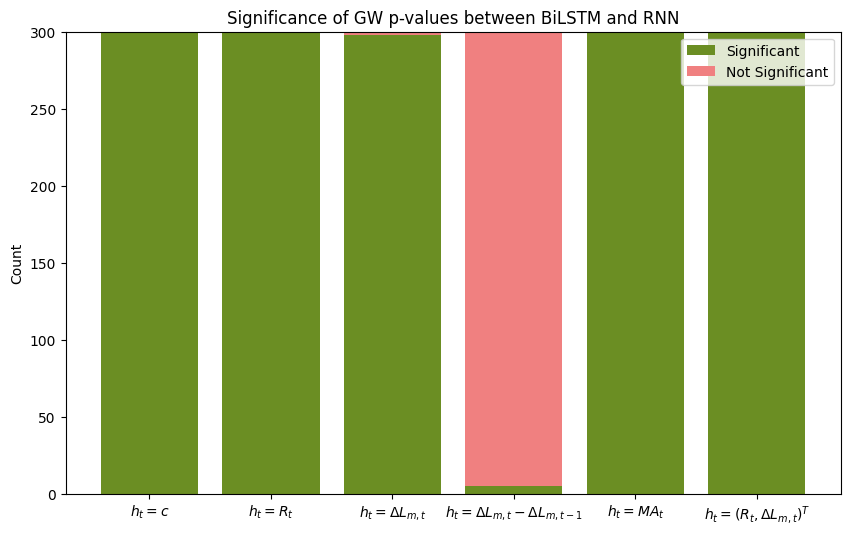

In [339]:
labels = ['$h_t= c$', '$h_t= R_t$', 
          '$h_t=\Delta L_{m,t}$', '$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$', 
          '$h_t=MA_t$', '$h_t=(R_t,\Delta L_{m,t})^T$']

significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_BiLSTMvsRNN_gfbm]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color='olivedrab')
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Count')
plt.title('Significance of GW p-values between BiLSTM and RNN')
plt.legend()
plt.show()


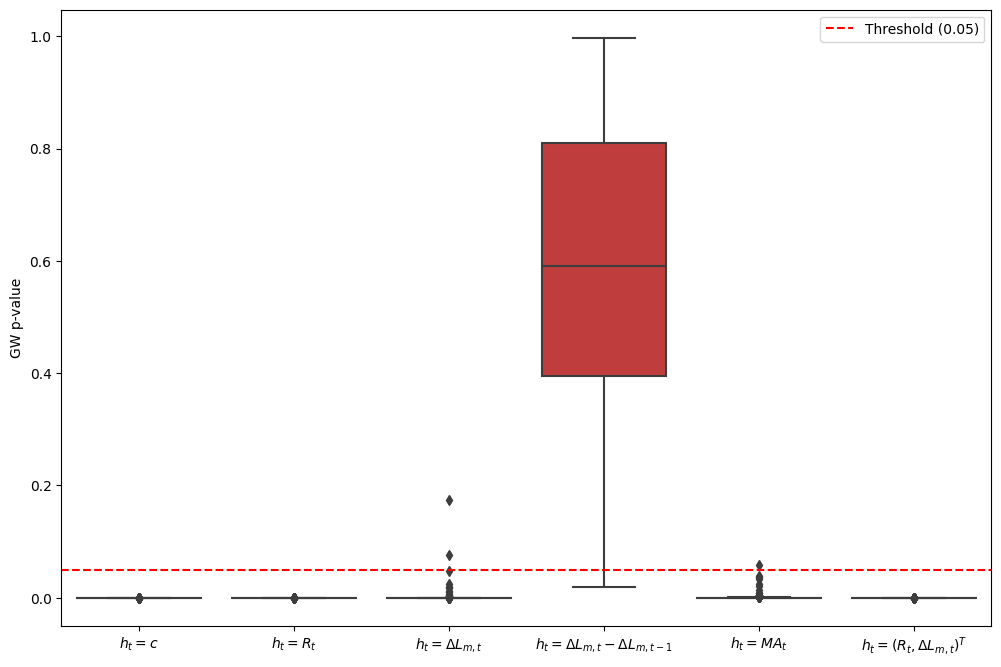

In [340]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_BiLSTMvsRNN_gfbm)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('GW p-value')
#plt.title('Box Plot of GW p-values between BiLSTM and RNN')

plt.legend()
plt.show()


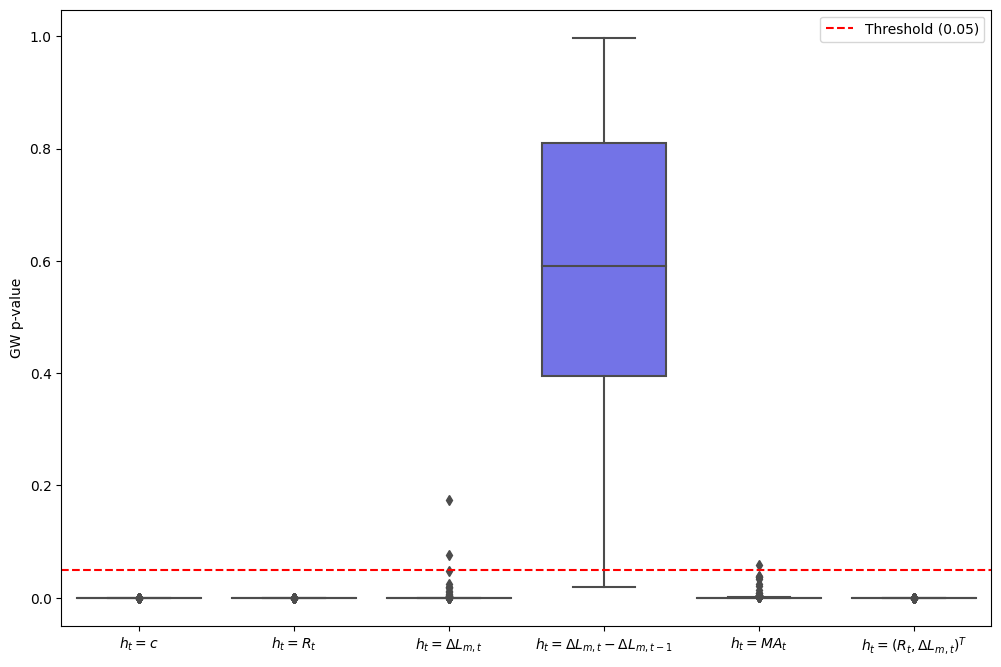

In [341]:
# Define your original color palette
original_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a custom color palette with lighter shades
custom_palette = sns.light_palette(original_colors[0], n_colors=len(original_colors))

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_BiLSTMvsRNN_gfbm, palette=custom_palette)
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('GW p-value')
#plt.title('Box Plot of GW p-values between BiLSTM and RNN')

plt.legend()
plt.show()

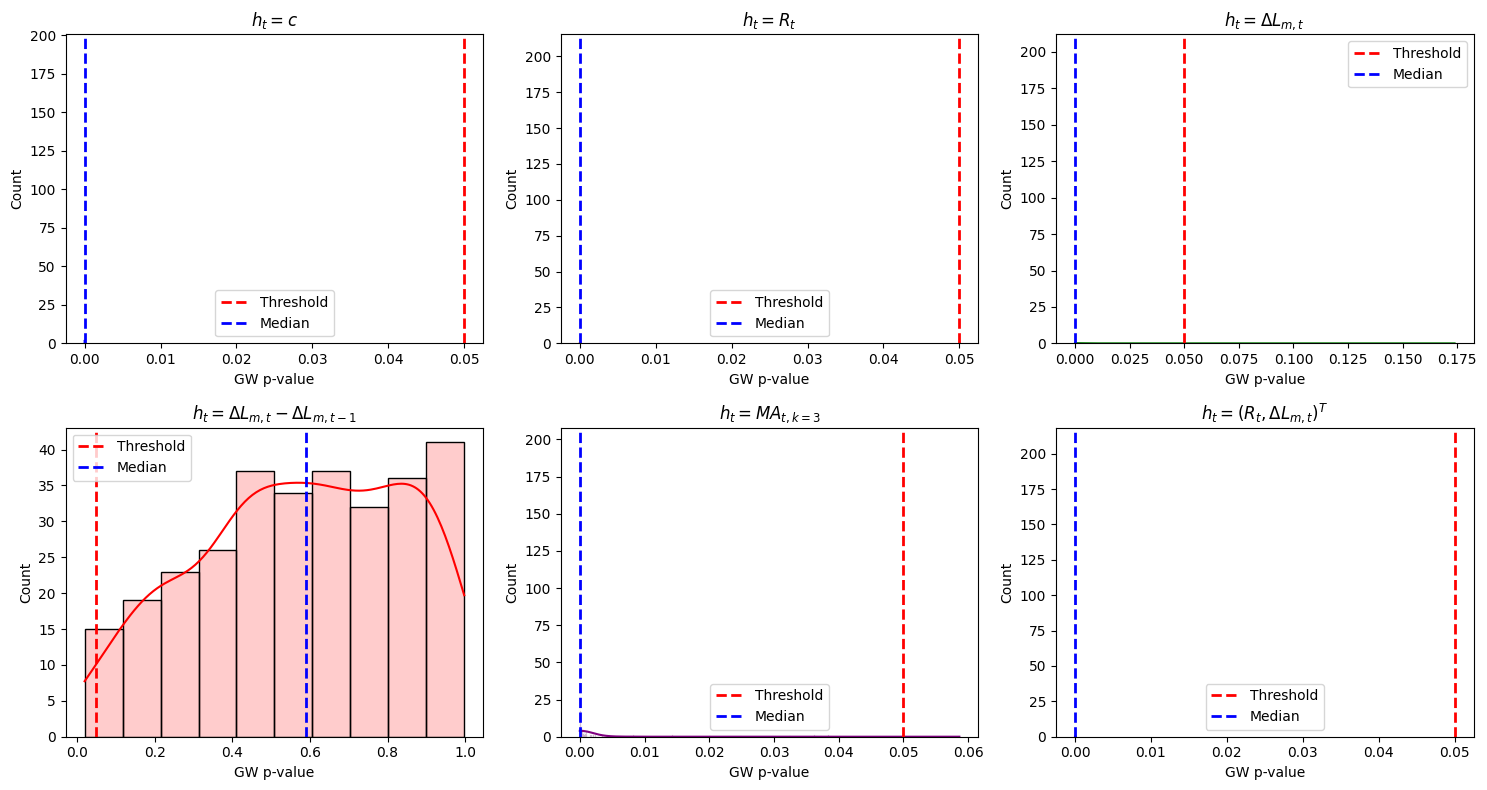

In [405]:


# Define a list of colors for the labels
label_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, label in enumerate(labels):
    row, col = divmod(idx, 3)  # Calculate the subplot row and column
    data = p_values_arrays_BiLSTMvsRNN_gfbm[idx]
    

    # Plot the histograms with the same colors
    sns.histplot(data, color=label_colors[idx % len(label_colors)], kde=True, ax=axes[row, col],alpha=0.2)
    
    # Add threhold lines with a fixed red color
    axes[row, col].axvline(0.05, color='red', linestyle='dashed', linewidth=2, label='Threshold')
    # Add median lines with a fixed red color
    axes[row, col].axvline(np.median(data), color='blue', linestyle='dashed', linewidth=2, label='Median')

    # Set titles for subplots
    axes[row, col].set_title(label)

    # Add legend for the median lines
    axes[row, col].legend()

    axes[row, col].set_xlabel('GW p-value')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [343]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_BiLSTMvsRNN_gfbm[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+---------------------------------------+------------------------+------------------------+------------------------+
|                 Label                 |           Q1           |           Q3           |         Median         |
+---------------------------------------+------------------------+------------------------+------------------------+
|               $h_t= c$                | 1.4662826508526905e-11 | 7.201940488421599e-09  | 3.7257935625589766e-10 |
|              $h_t= R_t$               | 1.7950640973651844e-12 | 3.564536110722827e-09  | 7.917977384863661e-11  |
|         $h_t=\Delta L_{m,t}$          | 1.949661243560996e-08  | 1.7326124663041842e-05 | 6.188629496084452e-07  |
| $h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$ |   0.3955650949100323   |   0.8100981033737866   |   0.5909131560497607   |
|              $h_t=MA_t$               | 4.400632999390641e-07  | 0.00022147780768710934 | 1.066608381006251e-05  |
|     $h_t=(R_t,\Delta L_{m,t})^T$      | 3.6301517347681056e-13

### BiLSTM vs LSTM

In [344]:
""" 
p_valueLSTMvsBiLSTM_constant_gfbm=np.empty(n_simulations)
p_valueBiLSTMvsLSTM_interestrate_gfbm=np.empty(n_simulations)
p_valueBiLSTMvsLSTM_lossdifference_gfbm=np.empty(n_simulations)
p_valueBiLSTMvsLSTM_laggedloss_gfbm=np.empty(n_simulations)
p_value_MA_BiLSTMvsLSTM_gfbm=np.empty(n_simulations)
p_valueLSTMvsBiLSTM_indicator_lossdifference_gfbm=np.empty(n_simulations)


for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))
    
    
    # Constant function
    Z_m_fixedLSTMvsBiLSTM_constant=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_LSTM_Sim_gfbm[i, :]
    Z_m_fixed_barLSTMvsBiLSTM_constant=1/n *sum(Z_m_fixedLSTMvsBiLSTM_constant)
    omegaLSTMvsBiLSTM_constant= 1/n * sum(Z_m_fixedLSTMvsBiLSTM_constant*Z_m_fixedLSTMvsBiLSTM_constant)
    teststatLSTMvsBiLSTM_constant=n*Z_m_fixed_barLSTMvsBiLSTM_constant*1/omegaLSTMvsBiLSTM_constant*Z_m_fixed_barLSTMvsBiLSTM_constant
    # Compute the p-value
    p_valueLSTMvsBiLSTM_constant_gfbm[i] = 1 - chi2.cdf(teststatLSTMvsBiLSTM_constant, 1)



    # Business cycle indicator
    DeltaLSTMvsBiLSTM=(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_LSTM_Sim_gfbm[i, :])
    Z_m_fixedLSTMvsBiLSTM_interestrate=h_t_indicator_1x398*(DeltaLSTMvsBiLSTM)
    Z_m_fixedLSTMvsBiLSTM_bar_interestrate=1/n *Z_m_fixedLSTMvsBiLSTM_interestrate.sum().sum()
    omegaLSTMvsBiLSTM_interestrate= 1/n * (Z_m_fixedLSTMvsBiLSTM_interestrate*Z_m_fixedLSTMvsBiLSTM_interestrate).sum().sum()
    teststatBiLSTMvsLSTM_interestrate5=n*Z_m_fixedLSTMvsBiLSTM_bar_interestrate*1/omegaLSTMvsBiLSTM_interestrate*Z_m_fixedLSTMvsBiLSTM_bar_interestrate
    # Compute the p-value
    p_valueBiLSTMvsLSTM_interestrate_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM_interestrate5, 1)
    
    
    #Loss difference test function
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_LSTM_Sim_gfbm[i, :]
    h_t_lossdifferenceBiLSTMvsLSTM= np.insert(h_t_lossdifferenceBiLSTMvsLSTM, 0, 0)
    h_t_lossdifferenceBiLSTMvsLSTM=h_t_lossdifferenceBiLSTMvsLSTM.reshape(1, -1)
    Z_m_fixed_BiLSTMvsLSTM=h_t_lossdifferenceBiLSTMvsLSTM[:, :-1]*(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_LSTM_Sim_gfbm[i, :])
    Z_m_fixed_bar_BiLSTMvsLSTM=1/n *Z_m_fixed_BiLSTMvsLSTM.sum()
    omegaBiLSTMvsLSTM= 1/n * (Z_m_fixed_BiLSTMvsLSTM*Z_m_fixed_BiLSTMvsLSTM).sum()
    teststatBiLSTMvsLSTM=n*Z_m_fixed_bar_BiLSTMvsLSTM*1/omegaBiLSTMvsLSTM*Z_m_fixed_bar_BiLSTMvsLSTM
    # Compute the p-value
    p_valueBiLSTMvsLSTM_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM, 1)

    # Lagged loss difference
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_LSTM_Sim_gfbm[i, :]
    two_last_lossdifferenceBiLSTMvsLSTM=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred[-2:].T-train_target[-2:])
    two_last_lossdifferenceBiLSTMvsLSTM = two_last_lossdifferenceBiLSTMvsLSTM.reshape((2,))
    h_t_lossdifferenceBiLSTMvsLSTM= np.concatenate((two_last_lossdifferenceBiLSTMvsLSTM, h_t_lossdifferenceBiLSTMvsLSTM))
    h_t_lossdifferenceBiLSTMvsLSTM_lagged = h_t_lossdifferenceBiLSTMvsLSTM[1:]-h_t_lossdifferenceBiLSTMvsLSTM[:-1]
    h_t_lossdifferenceBiLSTMvsLSTM_lagged=h_t_lossdifferenceBiLSTMvsLSTM_lagged[:-1].reshape(1, -1)
    Z_m_fixed_BiLSTMvsLSTM_laggedloss=(h_t_lossdifferenceBiLSTMvsLSTM_lagged)*(loss_values_BiLSTM-loss_values_LSTM)
    Z_m_fixed_bar_BiLSTMvsLSTM_laggedloss=1/n *Z_m_fixed_BiLSTMvsLSTM_laggedloss.sum()
    omegaBiLSTMvsLSTM_laggedloss= 1/n * (Z_m_fixed_BiLSTMvsLSTM_laggedloss*Z_m_fixed_BiLSTMvsLSTM_laggedloss).sum()
    teststatBiLSTMvsLSTM_laggedloss=n*Z_m_fixed_bar_BiLSTMvsLSTM_laggedloss*1/omegaBiLSTMvsLSTM_laggedloss*Z_m_fixed_bar_BiLSTMvsLSTM_laggedloss
    # Compute the p-value
    p_valueBiLSTMvsLSTM_laggedloss_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM_laggedloss, 1)

    
    # Moving Average
    lossdiffer_LSTMvsBiLSTM=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_LSTM_Sim_gfbm[i, :]
    three_last_lossdifferenceBiLSTMvsLSTM=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred[-3:].T-train_target[-3:])
    three_last_lossdifferenceBiLSTMvsLSTM = three_last_lossdifferenceBiLSTMvsLSTM.reshape((3,))
    lossdiffer_LSTMvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsLSTM, lossdiffer_LSTMvsBiLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    h_t_MA_BiLSTMvsLSTM = []
    for m in range(k, len(lossdiffer_LSTMvsBiLSTM)+1):
        sum_delta = sum(lossdiffer_LSTMvsBiLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_BiLSTMvsLSTM.append(ma)

    Z_m_fixed_MA_BiLSTMvsLSTM=h_t_MA_BiLSTMvsLSTM[:-1]*(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_LSTM_Sim_gfbm[i, :])
    Z_m_fixed_MA_bar_BiLSTMvsLSTM=1/n *Z_m_fixed_MA_BiLSTMvsLSTM.sum()
    omegaBiLSTMvsLSTM= 1/n * (Z_m_fixed_MA_BiLSTMvsLSTM*Z_m_fixed_MA_BiLSTMvsLSTM).sum()
    teststatBiLSTMvsLSTM=n*Z_m_fixed_MA_bar_BiLSTMvsLSTM*1/omegaBiLSTMvsLSTM*Z_m_fixed_MA_bar_BiLSTMvsLSTM
    # Compute the p-value
    p_value_MA_BiLSTMvsLSTM_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM, 1)


    # Combination of test functions
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_LSTM_Sim_gfbm[i, :]
    h_t_lossdifferenceBiLSTMvsLSTM= np.insert(h_t_lossdifferenceBiLSTMvsLSTM, 0, 0)
    h_t_lossdifferenceBiLSTMvsLSTM=h_t_lossdifferenceBiLSTMvsLSTM.reshape(1, -1)

    h_t_indicator_lossdifferenceBiLSTMvsLSTM=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsLSTM[:, :-1]))

    DeltaBiLSTMvsLSTM=(loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_LSTM_Sim_gfbm[i, :])
    Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM=h_t_indicator_lossdifferenceBiLSTMvsLSTM*(DeltaBiLSTMvsLSTM)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM=1/n *np.sum(Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM, axis=1)
    Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM=np.reshape(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM, (2, 1))
    omegaBiLSTMvsLSTM_indicator_lossdifference= 1/n *Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM@(Z_m_fixed_indicator_lossdifferenceBiLSTMvsLSTM.T)
    teststatBiLSTMvsLSTM_indicator_lossdifference5=n*(Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM.T)@(np.linalg.inv(omegaBiLSTMvsLSTM_indicator_lossdifference))@Z_m_fixed_bar_indicator_lossdifferenceBiLSTMvsLSTM
    # Compute the p-value
    p_valueLSTMvsBiLSTM_indicator_lossdifference_gfbm[i]= 1 - chi2.cdf(teststatBiLSTMvsLSTM_indicator_lossdifference5, 2)
     """

' \np_valueLSTMvsBiLSTM_constant_gfbm=np.empty(n_simulations)\np_valueBiLSTMvsLSTM_interestrate_gfbm=np.empty(n_simulations)\np_valueBiLSTMvsLSTM_lossdifference_gfbm=np.empty(n_simulations)\np_valueBiLSTMvsLSTM_laggedloss_gfbm=np.empty(n_simulations)\np_value_MA_BiLSTMvsLSTM_gfbm=np.empty(n_simulations)\np_valueLSTMvsBiLSTM_indicator_lossdifference_gfbm=np.empty(n_simulations)\n\n\nfor i in range(n_simulations):\n    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)\n    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))\n    \n    \n    # Constant function\n    Z_m_fixedLSTMvsBiLSTM_constant=loss_values_BiLSTM_Sim_gfbm[i, :]-loss_values_LSTM_Sim_gfbm[i, :]\n    Z_m_fixed_barLSTMvsBiLSTM_constant=1/n *sum(Z_m_fixedLSTMvsBiLSTM_constant)\n    omegaLSTMvsBiLSTM_constant= 1/n * sum(Z_m_fixedLSTMvsBiLSTM_constant*Z_m_fixedLSTMvsBiLSTM_constant)\n    teststatLSTMvsBiLSTM_constant=n

In [345]:
""" p_values_arrays_LSTMvsBiLSTM_gfbm = [p_valueLSTMvsBiLSTM_constant_gfbm, p_valueBiLSTMvsLSTM_interestrate_gfbm, 
                   p_valueBiLSTMvsLSTM_lossdifference_gfbm, p_valueBiLSTMvsLSTM_laggedloss_gfbm, 
                   p_value_MA_BiLSTMvsLSTM_gfbm, p_valueLSTMvsBiLSTM_indicator_lossdifference_gfbm] """

' p_values_arrays_LSTMvsBiLSTM_gfbm = [p_valueLSTMvsBiLSTM_constant_gfbm, p_valueBiLSTMvsLSTM_interestrate_gfbm, \n                   p_valueBiLSTMvsLSTM_lossdifference_gfbm, p_valueBiLSTMvsLSTM_laggedloss_gfbm, \n                   p_value_MA_BiLSTMvsLSTM_gfbm, p_valueLSTMvsBiLSTM_indicator_lossdifference_gfbm] '

In [346]:
""" 
# Specify the file path where you want to save the array
file_path = "p_values_arrays_LSTMvsBiLSTM_gfbm.pkl"

# Save the array to the binary file
with open(file_path, "wb") as binary_file:
    pickle.dump(p_values_arrays_LSTMvsBiLSTM_gfbm, binary_file) 
 """

' \n# Specify the file path where you want to save the array\nfile_path = "p_values_arrays_LSTMvsBiLSTM_gfbm.pkl"\n\n# Save the array to the binary file\nwith open(file_path, "wb") as binary_file:\n    pickle.dump(p_values_arrays_LSTMvsBiLSTM_gfbm, binary_file) \n '

In [347]:
# Load the data from the binary file
with open("p_values_arrays_LSTMvsBiLSTM_gfbm.pkl", "rb") as binary_file:
    p_values_arrays_LSTMvsBiLSTM_gfbm = pickle.load(binary_file)

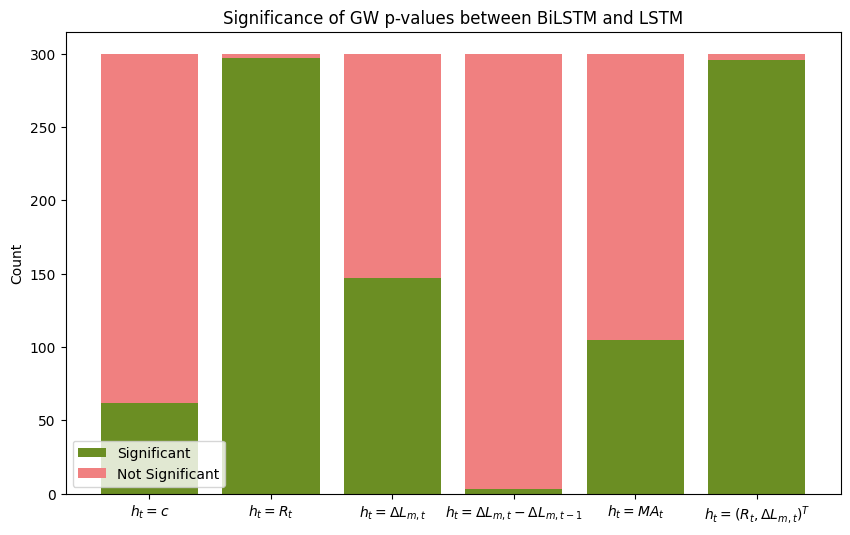

In [348]:
labels = ['$h_t= c$', '$h_t= R_t$', 
          '$h_t=\Delta L_{m,t}$', '$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$', 
          '$h_t=MA_t$', '$h_t=(R_t,\Delta L_{m,t})^T$']

significant = [np.sum(p_values <= 0.05) for p_values in p_values_arrays_LSTMvsBiLSTM_gfbm]
not_significant = [n_simulations - s for s in significant]

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(significant)), significant, label='Significant', color='olivedrab')
plt.bar(np.arange(len(significant)), not_significant, bottom=significant, label='Not Significant', color='lightcoral')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Count')
plt.title('Significance of GW p-values between BiLSTM and LSTM')
plt.legend()
plt.show()


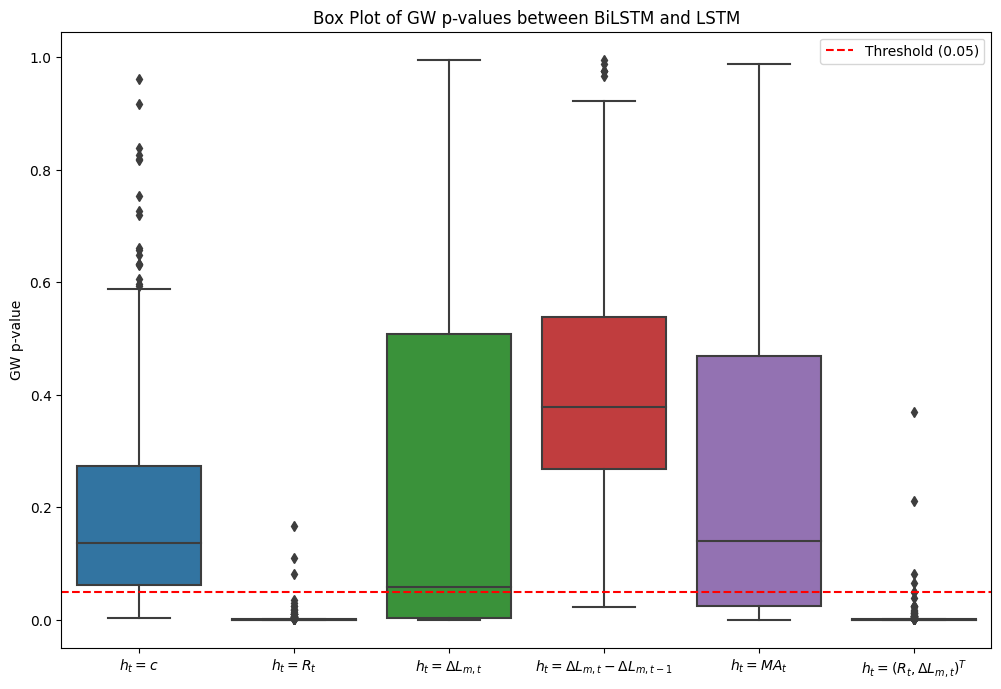

In [349]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=p_values_arrays_LSTMvsBiLSTM_gfbm)


plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold (0.05)')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('GW p-value')
plt.title('Box Plot of GW p-values between BiLSTM and LSTM')

plt.legend()
plt.show()


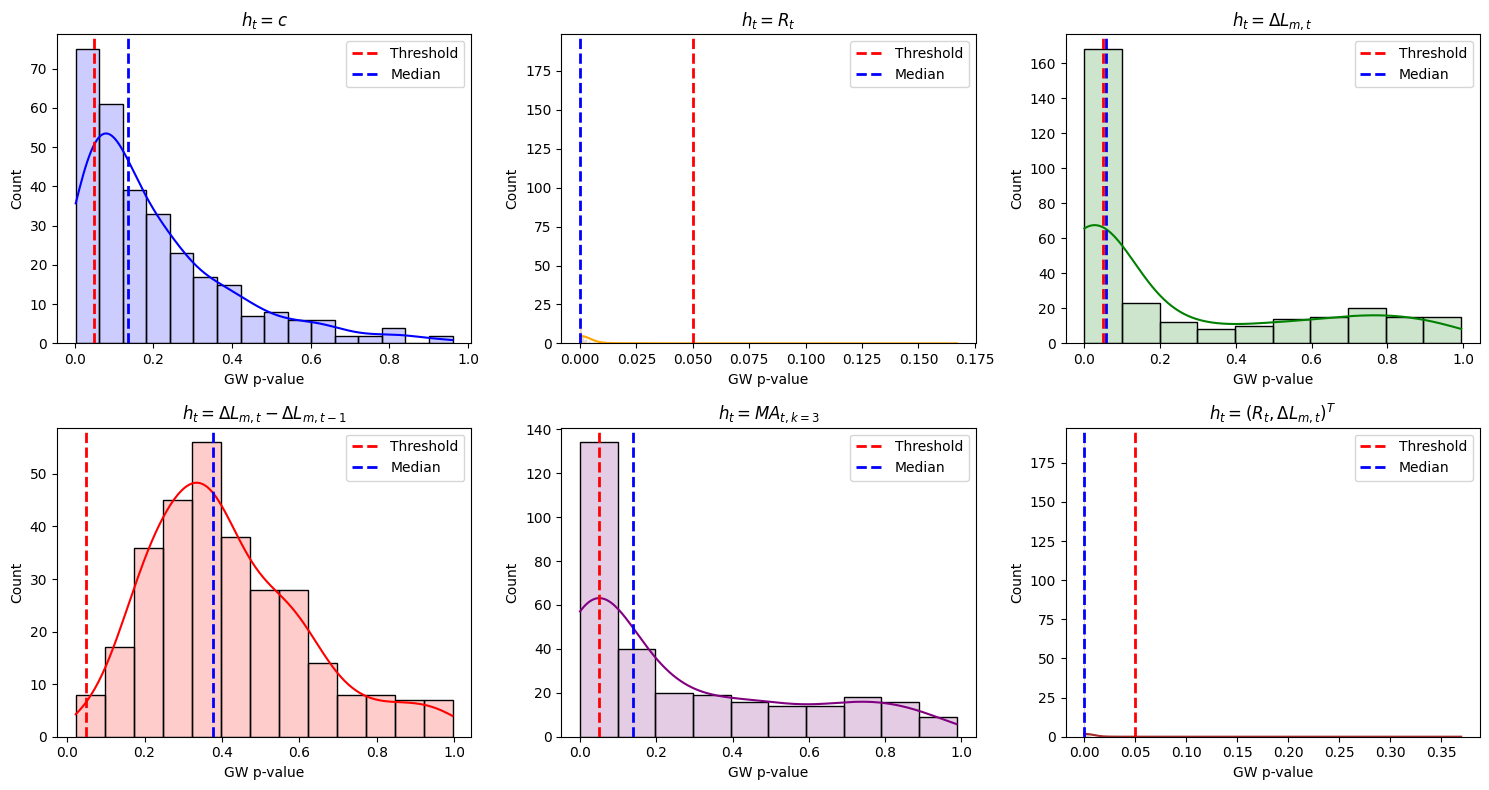

In [406]:


# Define a list of colors for the labels
label_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, label in enumerate(labels):
    row, col = divmod(idx, 3)  # Calculate the subplot row and column
    data = p_values_arrays_LSTMvsBiLSTM_gfbm[idx]
    

    # Plot the histograms with the same colors
    sns.histplot(data, color=label_colors[idx % len(label_colors)], kde=True, ax=axes[row, col],alpha=0.2)
    
    # Add threhold lines with a fixed red color
    axes[row, col].axvline(0.05, color='red', linestyle='dashed', linewidth=2, label='Threshold')
    # Add median lines with a fixed red color
    axes[row, col].axvline(np.median(data), color='blue', linestyle='dashed', linewidth=2, label='Median')

    # Set titles for subplots
    axes[row, col].set_title(label)

    # Add legend for the median lines
    axes[row, col].legend()
    axes[row, col].set_xlabel('GW p-value')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [351]:
# Initialize a list to store quartiles and median data
quartile_median_data = []

# Add quartiles and median annotations and store data
for i, label in enumerate(labels):
    data = p_values_arrays_LSTMvsBiLSTM_gfbm[i]
    quartiles = np.percentile(data, [25, 75])
    median = np.median(data)
    
    quartile_median_data.append([label, quartiles[0], quartiles[1], median])

# Display quartile and median data as a table
table = tabulate(quartile_median_data, headers=["Label", "Q1", "Q3", "Median"], tablefmt="pretty")
print(table)


+---------------------------------------+------------------------+------------------------+------------------------+
|                 Label                 |           Q1           |           Q3           |         Median         |
+---------------------------------------+------------------------+------------------------+------------------------+
|               $h_t= c$                |  0.06221901725871265   |  0.27326135192802714   |  0.13552542202993167   |
|              $h_t= R_t$               | 1.5673565370577514e-06 | 0.0005969555211516597  | 3.7197560310009425e-05 |
|         $h_t=\Delta L_{m,t}$          |  0.002867847528176287  |   0.5075652957817752   |  0.05802949486707598   |
| $h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$ |  0.26850134823573824   |   0.5379664976803897   |   0.3778077019127955   |
|              $h_t=MA_t$               |  0.024523580692327324  |   0.4686906917668198   |  0.13923034041334037   |
|     $h_t=(R_t,\Delta L_{m,t})^T$      |  9.58183271532187e-07 

Correlation Interest Rate

In [352]:
corr_sim_GRUvsLSTM_InterestRate = np.zeros(300)
corr_sim_GRUvsBiLSTM_InterestRate = np.zeros(300)
corr_sim_GRUvsRNN_InterestRate = np.zeros(300)
corr_sim_LSTMvsRNN_InterestRate = np.zeros(300)
corr_sim_BiLSTMvsRNN_InterestRate = np.zeros(300)
corr_sim_BiLSTMvsLSTM_InterestRate = np.zeros(300)

for i in range(0, 300):
    corrGRUvsBILSTM = np.corrcoef(((loss_values_GRU_Sim_gfbm[i] - loss_values_BiLSTM_Sim_gfbm[i])[1:]), (np.squeeze(h_t_indicator[:-1])))
    corr_sim_GRUvsBiLSTM_InterestRate[i] = abs(corrGRUvsBILSTM[0, 1])
    
    # Calculate and store other correlations here
    corrGRUvsLSTM = np.corrcoef(((loss_values_GRU_Sim_gfbm[i] - loss_values_LSTM_Sim_gfbm[i])[1:]), (np.squeeze(h_t_indicator[:-1])))
    corr_sim_GRUvsLSTM_InterestRate[i] = abs(corrGRUvsLSTM[0, 1])
    
    corrGRUvsRNN = np.corrcoef(((loss_values_GRU_Sim_gfbm[i] - loss_values_RNN_Sim_gfbm[i])[1:]), (np.squeeze(h_t_indicator[:-1])))
    corr_sim_GRUvsRNN_InterestRate[i] = abs(corrGRUvsRNN[0, 1])
    
    corrLSTMvsRNN = np.corrcoef(((loss_values_LSTM_Sim_gfbm[i] - loss_values_RNN_Sim_gfbm[i])[1:]), (np.squeeze(h_t_indicator[:-1])))
    corr_sim_LSTMvsRNN_InterestRate[i] = abs(corrLSTMvsRNN[0, 1])
    
    corrBiLSTMvsRNN = np.corrcoef(((loss_values_BiLSTM_Sim_gfbm[i] - loss_values_RNN_Sim_gfbm[i])[1:]), (np.squeeze(h_t_indicator[:-1])))
    corr_sim_BiLSTMvsRNN_InterestRate[i] = abs(corrBiLSTMvsRNN[0, 1])
    
    corrBiLSTMvsLSTM = np.corrcoef(((loss_values_BiLSTM_Sim_gfbm[i] - loss_values_LSTM_Sim_gfbm[i])[1:]), (np.squeeze(h_t_indicator[:-1])))
    corr_sim_BiLSTMvsLSTM_InterestRate[i] = abs(corrBiLSTMvsLSTM[0, 1])



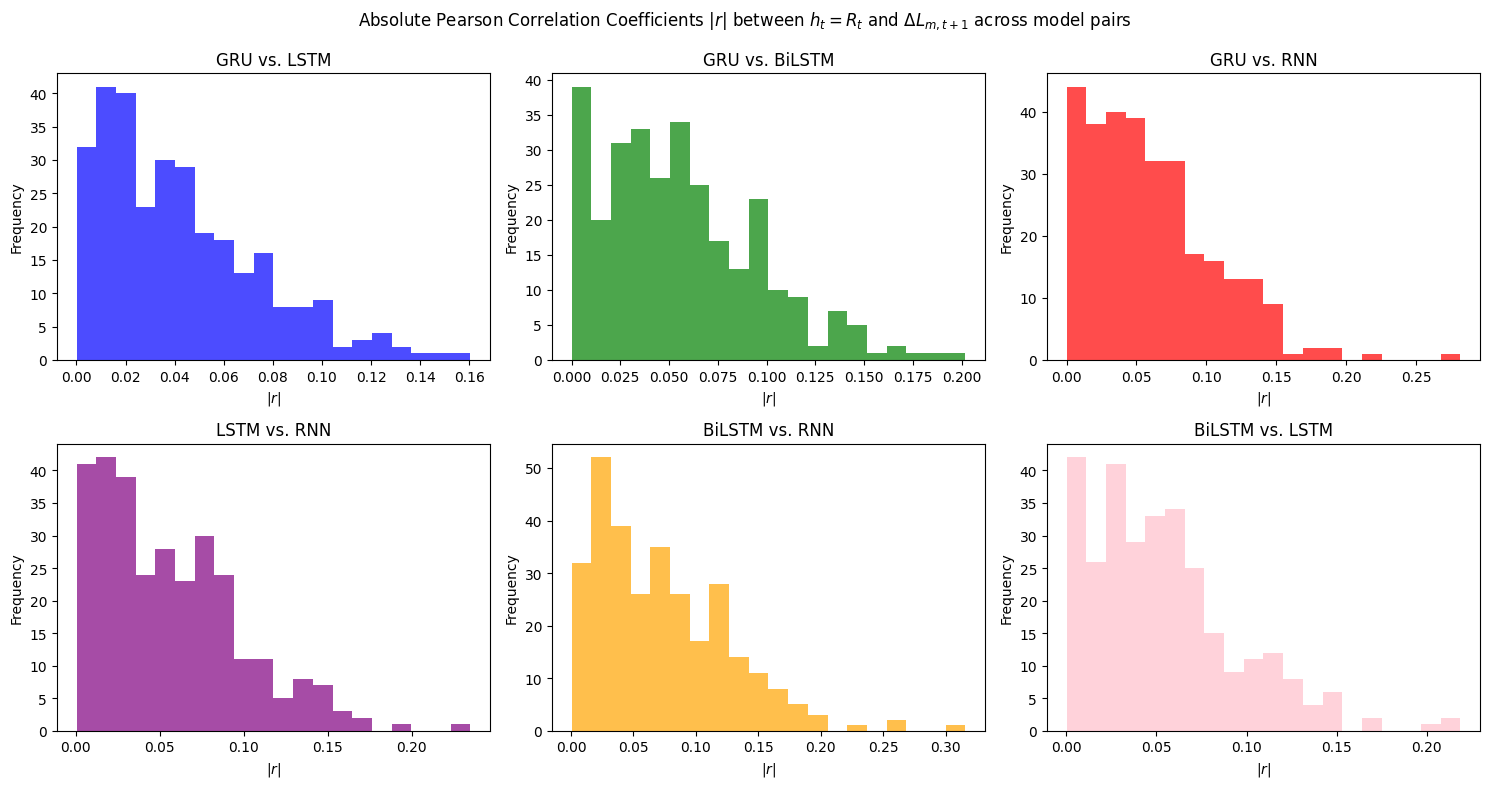

In [353]:

# Assuming you have calculated and stored the correlation coefficients in the arrays

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Absolute Pearson Correlation Coefficients $|r|$ between $h_t=R_t$ and $\Delta L_{m,t+1}$ across model pairs')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_GRUvsLSTM_InterestRate, bins=20, color='blue', alpha=0.7)
axes[0, 0].set_title('GRU vs. LSTM')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')

# Add plots for other correlations
axes[0, 1].hist(corr_sim_GRUvsBiLSTM_InterestRate, bins=20, color='green', alpha=0.7)
axes[0, 1].set_title('GRU vs. BiLSTM')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(corr_sim_GRUvsRNN_InterestRate, bins=20, color='red', alpha=0.7)
axes[0, 2].set_title('GRU vs. RNN')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')

axes[1, 0].hist(corr_sim_LSTMvsRNN_InterestRate, bins=20, color='purple', alpha=0.7)
axes[1, 0].set_title('LSTM vs. RNN')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(corr_sim_BiLSTMvsRNN_InterestRate, bins=20, color='orange', alpha=0.7)
axes[1, 1].set_title('BiLSTM vs. RNN')
axes[1, 1].set_xlabel('$|r|$')
axes[1, 1].set_ylabel('Frequency')

axes[1, 2].hist(corr_sim_BiLSTMvsLSTM_InterestRate, bins=20, color='pink', alpha=0.7)
axes[1, 2].set_title('BiLSTM vs. LSTM')
axes[1, 2].set_xlabel('$|r|$')
axes[1, 2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


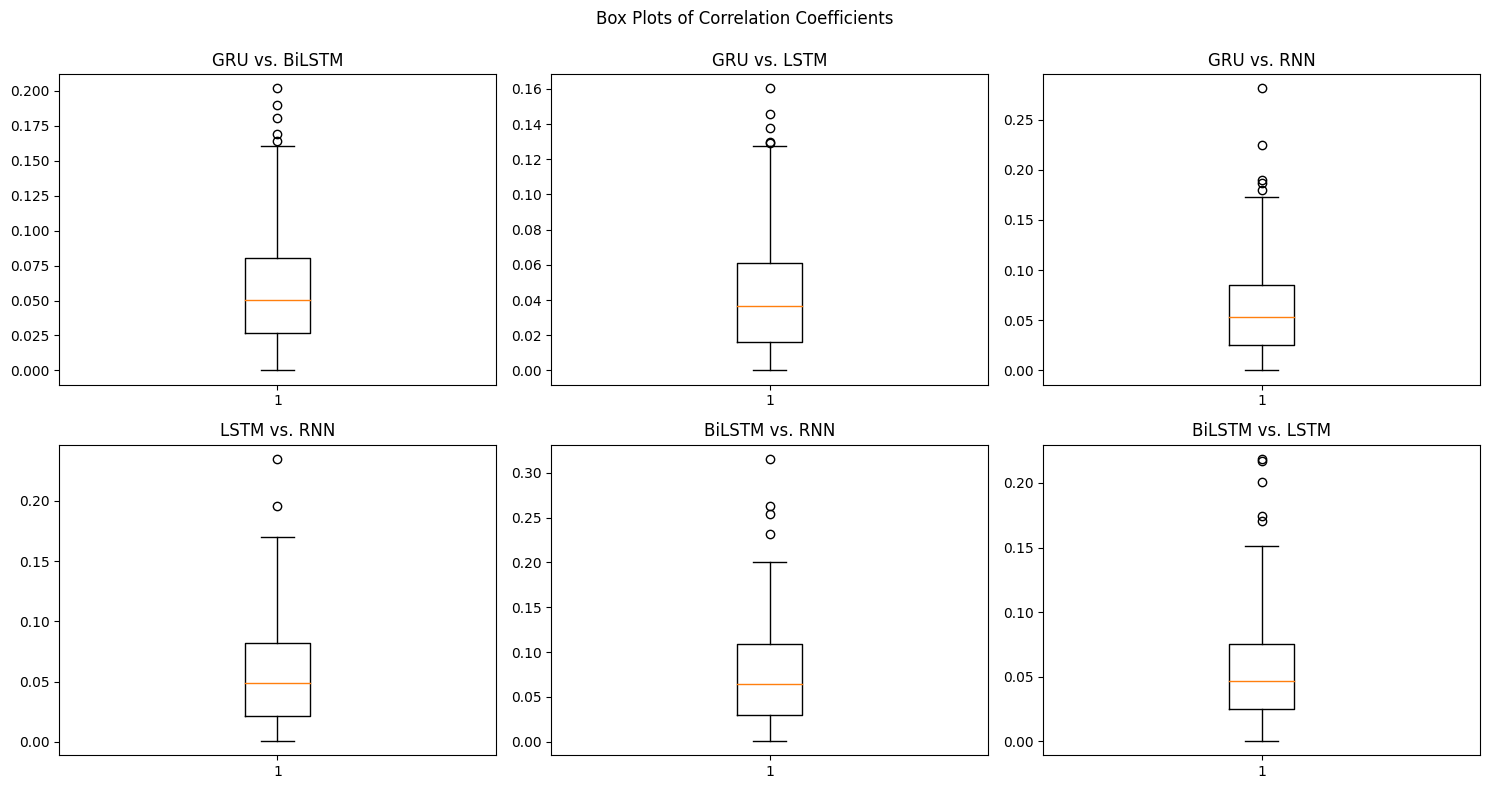

In [354]:

# Assuming you have calculated and stored the correlation coefficients in the arrays

# Create a figure and axis for the box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Box Plots of Correlation Coefficients')

# Plot GRU vs. BiLSTM
axes[0, 0].boxplot(corr_sim_GRUvsBiLSTM_InterestRate)
axes[0, 0].set_title('GRU vs. BiLSTM')

# Add box plots for other correlations
axes[0, 1].boxplot(corr_sim_GRUvsLSTM_InterestRate)
axes[0, 1].set_title('GRU vs. LSTM')

axes[0, 2].boxplot(corr_sim_GRUvsRNN_InterestRate)
axes[0, 2].set_title('GRU vs. RNN')

axes[1, 0].boxplot(corr_sim_LSTMvsRNN_InterestRate)
axes[1, 0].set_title('LSTM vs. RNN')

axes[1, 1].boxplot(corr_sim_BiLSTMvsRNN_InterestRate)
axes[1, 1].set_title('BiLSTM vs. RNN')

axes[1, 2].boxplot(corr_sim_BiLSTMvsLSTM_InterestRate)
axes[1, 2].set_title('BiLSTM vs. LSTM')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the box plots
plt.show()


Loss Difference Test Function Corr

In [355]:
h_t_lossdifferenceLSTMvsGRU_Sim_gfbm=np.zeros((n_simulations, 398))
h_t_lossdifferenceBiLSTMvsGRU_Sim_gfbm=np.zeros((n_simulations, 398))
h_t_lossdifferenceRNNvsGRU_Sim_gfbm=np.zeros((n_simulations, 398))
h_t_lossdifferenceLSTMvsRNN_Sim_gfbm=np.zeros((n_simulations, 398))
h_t_lossdifferenceBiLSTMvsRNN_Sim_gfbm=np.zeros((n_simulations, 398))
h_t_lossdifferenceLSTMvsBiLSTM_Sim_gfbm=np.zeros((n_simulations, 398))


for i in range(0,300):
#LSTM vs GRU
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    h_t_lossdifferenceLSTMvsGRU= np.insert(h_t_lossdifferenceLSTMvsGRU, 0, 0)
    h_t_lossdifferenceLSTMvsGRU=h_t_lossdifferenceLSTMvsGRU.reshape(1, -1)
    h_t_lossdifferenceLSTMvsGRU_Sim_gfbm[i]=h_t_lossdifferenceLSTMvsGRU[:, :-1]

#GRU vs BiLSTM
    h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    h_t_lossdifferenceBiLSTMvsGRU= np.insert(h_t_lossdifferenceBiLSTMvsGRU, 0, 0)
    h_t_lossdifferenceBiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU.reshape(1, -1)
    h_t_lossdifferenceBiLSTMvsGRU_Sim_gfbm[i]=h_t_lossdifferenceBiLSTMvsGRU[:, :-1]

#GRU vs RNN
    h_t_lossdifferenceRNNvsGRU=loss_values_RNN_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    h_t_lossdifferenceRNNvsGRU= np.insert(h_t_lossdifferenceRNNvsGRU, 0, 0)
    h_t_lossdifferenceRNNvsGRU=h_t_lossdifferenceRNNvsGRU.reshape(1, -1)
    h_t_lossdifferenceRNNvsGRU_Sim_gfbm[i]=h_t_lossdifferenceRNNvsGRU[:, :-1]

#LSTM vs RNN
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)
    h_t_lossdifferenceLSTMvsRNN_Sim_gfbm[i]=h_t_lossdifferenceLSTMvsRNN[:, :-1]

#BiLSTM vs RNN
    h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]
    h_t_lossdifferenceBiLSTMvsRNN= np.insert(h_t_lossdifferenceBiLSTMvsRNN, 0, 0)
    h_t_lossdifferenceBiLSTMvsRNN=h_t_lossdifferenceBiLSTMvsRNN.reshape(1, -1)
    h_t_lossdifferenceBiLSTMvsRNN_Sim_gfbm[i]=h_t_lossdifferenceBiLSTMvsRNN[:, :-1]

#LSTM vs BiLSTM
    h_t_lossdifferenceLSTMvsBiLSTM=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_LSTM_Sim_gfbm[i]
    h_t_lossdifferenceLSTMvsBiLSTM= np.insert(h_t_lossdifferenceLSTMvsBiLSTM, 0, 0)
    h_t_lossdifferenceLSTMvsBiLSTM=h_t_lossdifferenceLSTMvsBiLSTM.reshape(1, -1)
    h_t_lossdifferenceLSTMvsBiLSTM_Sim_gfbm[i]=h_t_lossdifferenceLSTMvsBiLSTM[:, :-1]




In [356]:
corr_sim_GRUvsLSTM_lossdifference = np.zeros(300)
corr_sim_GRUvsBiLSTM_lossdifference = np.zeros(300)
corr_sim_GRUvsRNN_lossdifference = np.zeros(300)
corr_sim_RNNvsLSTM_lossdifference = np.zeros(300)
corr_sim_BiLSTMvsRNN_lossdifference = np.zeros(300)
corr_sim_BiLSTMvsLSTM_lossdifference = np.zeros(300)




for i in range(0, 300):
    corrGRUvsLSTM = np.corrcoef((loss_values_GRU_Sim_gfbm[i] - loss_values_LSTM_Sim_gfbm[i]), h_t_lossdifferenceLSTMvsGRU_Sim_gfbm[i])[0, 1]
    corr_sim_GRUvsLSTM_lossdifference[i] = abs(corrGRUvsLSTM)


    corrGRUvsBiLSTM = np.corrcoef((loss_values_GRU_Sim_gfbm[i] - loss_values_BiLSTM_Sim_gfbm[i]), h_t_lossdifferenceBiLSTMvsGRU_Sim_gfbm[i])[0, 1]
    corr_sim_GRUvsBiLSTM_lossdifference[i] = abs(corrGRUvsBiLSTM)

    corrGRUvsRNN = np.corrcoef((loss_values_GRU_Sim_gfbm[i] - loss_values_RNN_Sim_gfbm[i]), h_t_lossdifferenceRNNvsGRU_Sim_gfbm[i])[0, 1]
    corr_sim_GRUvsRNN_lossdifference[i] = abs(corrGRUvsRNN)

    corrRNNvsLSTM = np.corrcoef((loss_values_RNN_Sim_gfbm[i] - loss_values_LSTM_Sim_gfbm[i]), h_t_lossdifferenceLSTMvsRNN_Sim_gfbm[i])[0, 1]
    corr_sim_RNNvsLSTM_lossdifference[i] = abs(corrRNNvsLSTM)

    corrRNNvsBiLSTM = np.corrcoef((loss_values_RNN_Sim_gfbm[i] - loss_values_BiLSTM_Sim_gfbm[i]), h_t_lossdifferenceBiLSTMvsRNN_Sim_gfbm[i])[0, 1]
    corr_sim_BiLSTMvsRNN_lossdifference[i] = abs(corrRNNvsBiLSTM)

    corrBiLSTMvsLSTM = np.corrcoef((loss_values_BiLSTM_Sim_gfbm[i] - loss_values_LSTM_Sim_gfbm[i]), h_t_lossdifferenceLSTMvsBiLSTM_Sim_gfbm[i])[0, 1]
    corr_sim_BiLSTMvsLSTM_lossdifference[i] = abs(corrBiLSTMvsLSTM)


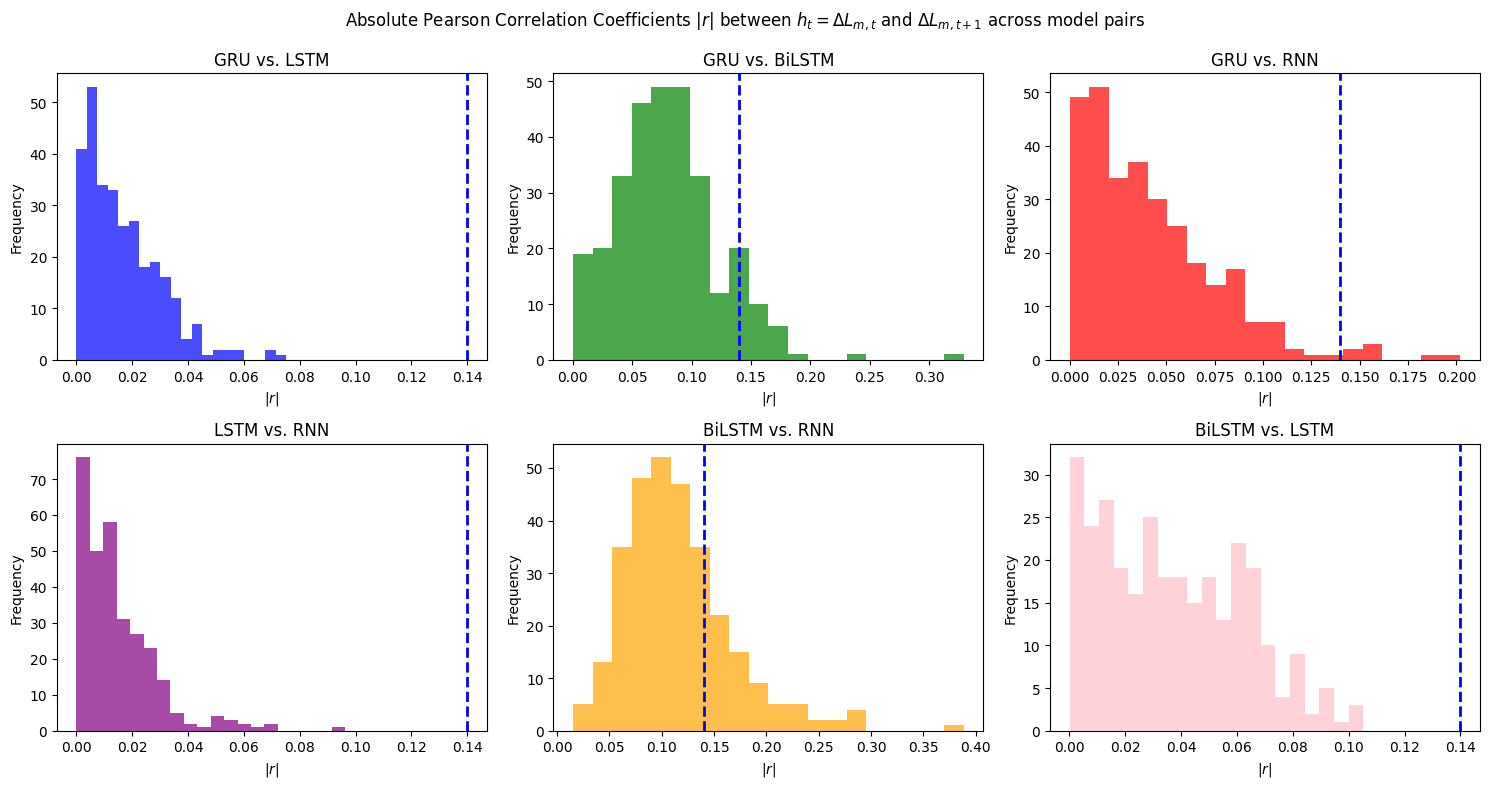

In [357]:

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Absolute Pearson Correlation Coefficients $|r|$ between $h_t=\Delta L_{m,t}$ and $\Delta L_{m,t+1}$ across model pairs')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_GRUvsLSTM_lossdifference, bins=20, color='blue', alpha=0.7)
axes[0, 0].set_title('GRU vs. LSTM')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(0.14, color='blue', linestyle='dashed', linewidth=2, label='Threshold')

# Add plots for other correlations
axes[0, 1].hist(corr_sim_GRUvsBiLSTM_lossdifference, bins=20, color='green', alpha=0.7)
axes[0, 1].set_title('GRU vs. BiLSTM')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(0.14, color='blue', linestyle='dashed', linewidth=2, label='Threshold')

axes[0, 2].hist(corr_sim_GRUvsRNN_lossdifference, bins=20, color='red', alpha=0.7)
axes[0, 2].set_title('GRU vs. RNN')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(0.14, color='blue', linestyle='dashed', linewidth=2, label='Threshold')

axes[1, 0].hist(corr_sim_RNNvsLSTM_lossdifference, bins=20, color='purple', alpha=0.7)
axes[1, 0].set_title('LSTM vs. RNN')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(0.14, color='blue', linestyle='dashed', linewidth=2, label='Threshold')

axes[1, 1].hist(corr_sim_BiLSTMvsRNN_lossdifference, bins=20, color='orange', alpha=0.7)
axes[1, 1].set_title('BiLSTM vs. RNN')
axes[1, 1].set_xlabel('$|r|$')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(0.14, color='blue', linestyle='dashed', linewidth=2, label='Threshold')

axes[1, 2].hist(corr_sim_BiLSTMvsLSTM_lossdifference, bins=20, color='pink', alpha=0.7)
axes[1, 2].set_title('BiLSTM vs. LSTM')
axes[1, 2].set_xlabel('$|r|$')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].axvline(0.14, color='blue', linestyle='dashed', linewidth=2, label='Threshold')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


## Lagged Loss Corr

In [358]:
h_t_laggedlossdifferenceLSTMvsGRU_Sim_gfbm=np.zeros((n_simulations, 398))
h_t_laggedlossdifferenceBiLSTMvsGRU_Sim_gfbm=np.zeros((n_simulations, 398))
h_t_laggedlossdifferenceRNNvsGRU_Sim_gfbm=np.zeros((n_simulations, 398))
h_t_laggedlossdifferenceLSTMvsRNN_Sim_gfbm=np.zeros((n_simulations, 398))
h_t_laggedlossdifferenceBiLSTMvsRNN_Sim_gfbm=np.zeros((n_simulations, 398))
h_t_laggedlossdifferenceLSTMvsBiLSTM_Sim_gfbm=np.zeros((n_simulations, 398))

for i in range(0,300):
    # LSTM vs GRU
    h_t_lossdifferenceLSTMvsGRU=loss_values_LSTM_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    two_last_lossdifferenceLSTMvsGRU=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
    two_last_lossdifferenceLSTMvsGRU = two_last_lossdifferenceLSTMvsGRU.reshape((2,))
    h_t_lossdifferenceLSTMvsGRU= np.concatenate((two_last_lossdifferenceLSTMvsGRU, h_t_lossdifferenceLSTMvsGRU))
    h_t_lossdifferenceLSTMvsGRU_lagged = h_t_lossdifferenceLSTMvsGRU[1:]-h_t_lossdifferenceLSTMvsGRU[:-1]
    h_t_laggedlossdifferenceLSTMvsGRU_Sim_gfbm[i]=h_t_lossdifferenceLSTMvsGRU_lagged[:-1]


# BiLSTM vs GRU
    h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    two_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
    two_last_lossdifferenceBiLSTMvsGRU = two_last_lossdifferenceBiLSTMvsGRU.reshape((2,))
    h_t_lossdifferenceBiLSTMvsGRU= np.concatenate((two_last_lossdifferenceBiLSTMvsGRU, h_t_lossdifferenceBiLSTMvsGRU))
    h_t_lossdifferenceBiLSTMvsGRU_lagged = h_t_lossdifferenceBiLSTMvsGRU[1:]-h_t_lossdifferenceBiLSTMvsGRU[:-1]
    h_t_laggedlossdifferenceBiLSTMvsGRU_Sim_gfbm[i]=h_t_lossdifferenceBiLSTMvsGRU_lagged[:-1]


# RNN vs GRU
    h_t_lossdifferenceGRUvsRNN=loss_values_RNN_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    two_last_lossdifferenceGRUvsRNN=(train_target_pred_rnn[-2:].T-train_target[-2:])-(train_target_pred_gru[-2:].T-train_target[-2:])
    two_last_lossdifferenceGRUvsRNN = two_last_lossdifferenceGRUvsRNN.reshape((2,))
    h_t_lossdifferenceGRUvsRNN= np.concatenate((two_last_lossdifferenceGRUvsRNN, h_t_lossdifferenceGRUvsRNN))
    h_t_lossdifferenceGRUvsRNN_lagged = h_t_lossdifferenceGRUvsRNN[1:]-h_t_lossdifferenceGRUvsRNN[:-1]
    h_t_laggedlossdifferenceRNNvsGRU_Sim_gfbm[i]=h_t_lossdifferenceGRUvsRNN_lagged[:-1]


# LSTM vs RNN
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]
    two_last_lossdifferenceLSTMvsRNN=(train_target_pred[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
    two_last_lossdifferenceLSTMvsRNN = two_last_lossdifferenceLSTMvsRNN.reshape((2,))
    h_t_lossdifferenceLSTMvsRNN= np.concatenate((two_last_lossdifferenceLSTMvsRNN, h_t_lossdifferenceLSTMvsRNN))
    h_t_lossdifferenceLSTMvsRNN_lagged = h_t_lossdifferenceLSTMvsRNN[1:]-h_t_lossdifferenceLSTMvsRNN[:-1]
    h_t_laggedlossdifferenceLSTMvsRNN_Sim_gfbm[i]=h_t_lossdifferenceLSTMvsRNN_lagged[:-1]

   

# BiLSTM vs RNN
    h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]
    two_last_lossdifferenceBiLSTMvsRNN=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred_rnn[-2:].T-train_target[-2:])
    two_last_lossdifferenceBiLSTMvsRNN = two_last_lossdifferenceBiLSTMvsRNN.reshape((2,))
    h_t_lossdifferenceBiLSTMvsRNN= np.concatenate((two_last_lossdifferenceBiLSTMvsRNN, h_t_lossdifferenceBiLSTMvsRNN))
    h_t_lossdifferenceBiLSTMvsRNN_lagged = h_t_lossdifferenceBiLSTMvsRNN[1:]-h_t_lossdifferenceBiLSTMvsRNN[:-1]
    h_t_laggedlossdifferenceBiLSTMvsRNN_Sim_gfbm[i]=h_t_lossdifferenceBiLSTMvsRNN_lagged[:-1]

# LSTM vs BiLSTM
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_LSTM_Sim_gfbm[i]
    two_last_lossdifferenceBiLSTMvsLSTM=(train_target_pred_BiLSTM[-2:].T-train_target[-2:])-(train_target_pred[-2:].T-train_target[-2:])
    two_last_lossdifferenceBiLSTMvsLSTM = two_last_lossdifferenceBiLSTMvsLSTM.reshape((2,))
    h_t_lossdifferenceBiLSTMvsLSTM= np.concatenate((two_last_lossdifferenceBiLSTMvsLSTM, h_t_lossdifferenceBiLSTMvsLSTM))
    h_t_lossdifferenceBiLSTMvsLSTM_lagged = h_t_lossdifferenceBiLSTMvsLSTM[1:]-h_t_lossdifferenceBiLSTMvsLSTM[:-1]
    h_t_laggedlossdifferenceLSTMvsBiLSTM_Sim_gfbm[i]=h_t_lossdifferenceBiLSTMvsLSTM_lagged[:-1]

In [359]:
np.corrcoef(((loss_values_GRU_Sim_gfbm[1] - loss_values_LSTM_Sim_gfbm[1])[1:]), ((h_t_laggedlossdifferenceLSTMvsGRU_Sim_gfbm[1])[:-1]))[0,1]


-0.051739135749942634

In [360]:
corr_sim_GRUvsLSTM_laggedlossdifference = np.zeros(300)
corr_sim_GRUvsBiLSTM_laggedlossdifference = np.zeros(300)
corr_sim_GRUvsRNN_laggedlossdifference = np.zeros(300)
corr_sim_RNNvsLSTM_laggedlossdifference = np.zeros(300)
corr_sim_BiLSTMvsRNN_laggedlossdifference = np.zeros(300)
corr_sim_BiLSTMvsLSTM_laggedlossdifference = np.zeros(300)

for i in range(0, 300):
    # GRU vs LSTM
    corrGRUvsLSTM = np.corrcoef(((loss_values_GRU_Sim_gfbm[i] - loss_values_LSTM_Sim_gfbm[i])[1:]), ((h_t_laggedlossdifferenceLSTMvsGRU_Sim_gfbm[i])[:-1]))[0,1]
    corr_sim_GRUvsLSTM_laggedlossdifference[i]=abs(corrGRUvsLSTM)

    # GRU vs BiLSTM
    corrGRUvsBiLSTM = np.corrcoef(((loss_values_GRU_Sim_gfbm[i] - loss_values_BiLSTM_Sim_gfbm[i])[1:]), ((h_t_laggedlossdifferenceBiLSTMvsGRU_Sim_gfbm[i])[:-1]))[0,1]
    corr_sim_GRUvsBiLSTM_laggedlossdifference[i]=abs(corrGRUvsBiLSTM)

    # gru VS rnn
    corrGRUvvRNN = np.corrcoef(((loss_values_GRU_Sim_gfbm[i] - loss_values_RNN_Sim_gfbm[i])[1:]), ((h_t_laggedlossdifferenceRNNvsGRU_Sim_gfbm[i])[:-1]))[0,1]
    corr_sim_GRUvsRNN_laggedlossdifference[i]=abs(corrGRUvvRNN)

    # LSTM vs RNN

    corrRNNvsLSTM = np.corrcoef(((loss_values_RNN_Sim_gfbm[i] - loss_values_LSTM_Sim_gfbm[i])[1:]), ((h_t_laggedlossdifferenceLSTMvsRNN_Sim_gfbm[i])[:-1]))[0,1]
    corr_sim_RNNvsLSTM_laggedlossdifference[i]=abs(corrRNNvsLSTM)

    # BiLSTM vs RNN

    corrGRUvsBiLSTM = np.corrcoef(((loss_values_RNN_Sim_gfbm[i] - loss_values_BiLSTM_Sim_gfbm[i])[1:]), ((h_t_laggedlossdifferenceBiLSTMvsRNN_Sim_gfbm[i])[:-1]))[0,1]
    corr_sim_BiLSTMvsRNN_laggedlossdifference[i]=abs(corrGRUvsBiLSTM)

    #BiLSTM vs LSTM
    corrBiLSTMvsLSTM = np.corrcoef(((loss_values_BiLSTM_Sim_gfbm[i] - loss_values_LSTM_Sim_gfbm[i])[1:]), ((h_t_laggedlossdifferenceLSTMvsBiLSTM_Sim_gfbm[i])[:-1]))[0,1]
    corr_sim_BiLSTMvsLSTM_laggedlossdifference[i]=abs(corrBiLSTMvsLSTM)



    

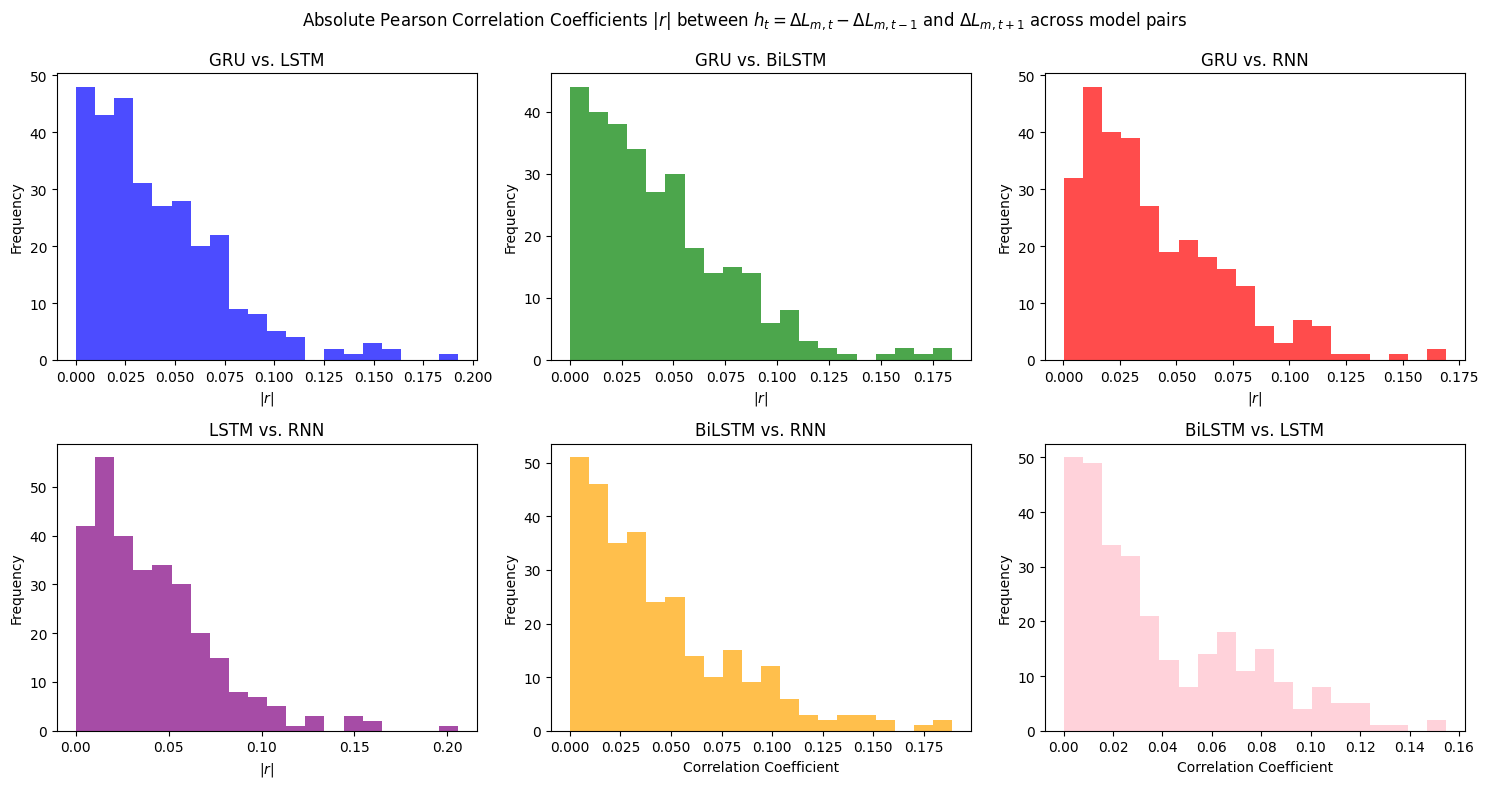

In [361]:

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Absolute Pearson Correlation Coefficients $|r|$ between $h_t=\Delta L_{m,t} -\Delta L_{m,t-1}$ and $\Delta L_{m,t+1}$ across model pairs')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_GRUvsLSTM_laggedlossdifference, bins=20, color='blue', alpha=0.7)
axes[0, 0].set_title('GRU vs. LSTM')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')

# Add plots for other correlations
axes[0, 1].hist(corr_sim_GRUvsBiLSTM_laggedlossdifference, bins=20, color='green', alpha=0.7)
axes[0, 1].set_title('GRU vs. BiLSTM')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(corr_sim_GRUvsRNN_laggedlossdifference, bins=20, color='red', alpha=0.7)
axes[0, 2].set_title('GRU vs. RNN')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')

axes[1, 0].hist(corr_sim_RNNvsLSTM_laggedlossdifference, bins=20, color='purple', alpha=0.7)
axes[1, 0].set_title('LSTM vs. RNN')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(corr_sim_BiLSTMvsRNN_laggedlossdifference, bins=20, color='orange', alpha=0.7)
axes[1, 1].set_title('BiLSTM vs. RNN')
axes[1, 1].set_xlabel('Correlation Coefficient')
axes[1, 1].set_ylabel('Frequency')

axes[1, 2].hist(corr_sim_BiLSTMvsLSTM_laggedlossdifference, bins=20, color='pink', alpha=0.7)
axes[1, 2].set_title('BiLSTM vs. LSTM')
axes[1, 2].set_xlabel('Correlation Coefficient')
axes[1, 2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


## MA...

In [362]:
h_t_MA_LSTMvsGRU_Sim_gfbm=np.zeros((n_simulations, 399))
h_t_MA_BiLSTMvsGRU_Sim_gfbm=np.zeros((n_simulations, 399))
h_t_MA_GRUvsRNN_Sim_gfbm=np.zeros((n_simulations, 399))

h_t_MA_LSTMvsRNN_Sim_gfbm=np.zeros((n_simulations, 399))
h_t_MA_RNNvsBiLSTM_Sim_gfbm=np.zeros((n_simulations, 399))

h_t_MA_LSTMvsBiLSTM_Sim_gfbm=np.zeros((n_simulations, 399))


for i in range (0,300):

 # LSTM vs RNN
    lossdiffer_GRUvsLSTM=loss_values_LSTM_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    three_last_lossdifferenceLSTMvsGRU=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
    three_last_lossdifferenceLSTMvsGRU = three_last_lossdifferenceLSTMvsGRU.reshape((3,))
    lossdiffer_GRUvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsGRU, lossdiffer_GRUvsLSTM))
    k = 3  # Specify the value of k
    # Calculate the moving averages
    for m in range(k, len(lossdiffer_GRUvsLSTM)+1):
        sum_delta = sum(lossdiffer_GRUvsLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_LSTMvsGRU_Sim_gfbm[i, m-3] = ma
#  GRU vs BiLSTM
    lossdiffer_GRUvsBiLSTM=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    three_last_lossdifferenceBiLSTMvsGRU=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
    three_last_lossdifferenceBiLSTMvsGRU = three_last_lossdifferenceBiLSTMvsGRU.reshape((3,))
    lossdiffer_GRUvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsGRU, lossdiffer_GRUvsBiLSTM))
    # Calculate the moving averages
    for m in range(k, len(lossdiffer_GRUvsBiLSTM)+1):
        sum_delta = sum(lossdiffer_GRUvsBiLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_BiLSTMvsGRU_Sim_gfbm[i, m-3] = ma

#GRU vs RNN
    lossdiffer_GRUvsRNN=loss_values_RNN_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    three_last_lossdifferenceGRUvsRNN=(train_target_pred_rnn[-3:].T-train_target[-3:])-(train_target_pred_gru[-3:].T-train_target[-3:])
    three_last_lossdifferenceGRUvsRNN = three_last_lossdifferenceGRUvsRNN.reshape((3,))
    lossdiffer_GRUvsRNN= np.concatenate((three_last_lossdifferenceGRUvsRNN, lossdiffer_GRUvsRNN))
    for m in range(k, len(lossdiffer_GRUvsRNN)+1):
        sum_delta = sum(lossdiffer_GRUvsRNN[m-k:m])
        ma = sum_delta / k
        h_t_MA_GRUvsRNN_Sim_gfbm[i, m-3] = ma

# LSTM vs RNN
    lossdiffer_RNNvsLSTM=loss_values_LSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]
    three_last_lossdifferenceLSTMvsRNN=(train_target_pred[-3:].T-train_target[-3:])-(train_target_pred_rnn[-3:].T-train_target[-3:])
    three_last_lossdifferenceLSTMvsRNN = three_last_lossdifferenceLSTMvsRNN.reshape((3,))
    lossdiffer_RNNvsLSTM= np.concatenate((three_last_lossdifferenceLSTMvsRNN, lossdiffer_RNNvsLSTM))
    # Calculate the moving averages
    for m in range(k, len(lossdiffer_RNNvsLSTM)+1):
        sum_delta = sum(lossdiffer_RNNvsLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_LSTMvsRNN_Sim_gfbm[i, m-3]=ma

#BiLSTMvs RNN
    lossdiffer_RNNvsBiLSTM=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]
    three_last_lossdifferenceBiLSTMvsRNN=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred_rnn[-3:].T-train_target[-3:])
    three_last_lossdifferenceBiLSTMvsRNN = three_last_lossdifferenceBiLSTMvsRNN.reshape((3,))
    lossdiffer_RNNvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsRNN, lossdiffer_RNNvsBiLSTM))
    for m in range(k, len(lossdiffer_RNNvsBiLSTM)+1):
        sum_delta = sum(lossdiffer_RNNvsBiLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_RNNvsBiLSTM_Sim_gfbm[i, m-3]=ma


#BiLSTM vs LSTM
    lossdiffer_LSTMvsBiLSTM=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_LSTM_Sim_gfbm[i]
    three_last_lossdifferenceBiLSTMvsLSTM=(train_target_pred_BiLSTM[-3:].T-train_target[-3:])-(train_target_pred[-3:].T-train_target[-3:])
    three_last_lossdifferenceBiLSTMvsLSTM = three_last_lossdifferenceBiLSTMvsLSTM.reshape((3,))
    lossdiffer_LSTMvsBiLSTM= np.concatenate((three_last_lossdifferenceBiLSTMvsLSTM, lossdiffer_LSTMvsBiLSTM))
    # Calculate the moving averages
    for m in range(k, len(lossdiffer_LSTMvsBiLSTM)+1):
        sum_delta = sum(lossdiffer_LSTMvsBiLSTM[m-k:m])
        ma = sum_delta / k
        h_t_MA_LSTMvsBiLSTM_Sim_gfbm[i, m-3]=ma

 

In [363]:
corr_sim_GRUvsLSTM_MA = np.zeros(300)
corr_sim_GRUvsBiLSTM_MA = np.zeros(300)
corr_sim_GRUvsRNN_MA = np.zeros(300)
corr_sim_RNNvsLSTM_MA = np.zeros(300)
corr_sim_BiLSTMvsRNN_MA = np.zeros(300)
corr_sim_BiLSTMvsLSTM_MA = np.zeros(300)

for i in range(0, 300):
    # GRU vs LSTM
    corrGRUvsLSTM = np.corrcoef((loss_values_GRU_Sim_gfbm[i]-loss_values_LSTM_Sim_gfbm[i]),(h_t_MA_LSTMvsGRU_Sim_gfbm[i])[1:])[0, 1]
    corr_sim_GRUvsLSTM_MA[i]=abs(corrGRUvsLSTM)

    # GRU vs BiLSTM
    corrGRUvsBiLSTM = np.corrcoef((loss_values_GRU_Sim_gfbm[i]-loss_values_BiLSTM_Sim_gfbm[i]),(h_t_MA_BiLSTMvsGRU_Sim_gfbm[i])[1:])[0, 1]
    corr_sim_GRUvsBiLSTM_MA[i]=abs(corrGRUvsBiLSTM)

    #GRU vs RNN
    corrGRUvsRNN = np.corrcoef((loss_values_GRU_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]),(h_t_MA_GRUvsRNN_Sim_gfbm[i])[1:])[0, 1]
    corr_sim_GRUvsRNN_MA[i]=abs(corrGRUvsBiLSTM)

    #LSTM vs RNN
    corrLSTMvsRNN = np.corrcoef((loss_values_LSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]),(h_t_MA_LSTMvsRNN_Sim_gfbm[i])[1:])[0, 1]
    corr_sim_RNNvsLSTM_MA[i]=abs(corrLSTMvsRNN)

    #BiLSTM vs RNN
    corrBiLSTMvsRNN = np.corrcoef((loss_values_RNN_Sim_gfbm[i]-loss_values_BiLSTM_Sim_gfbm[i]),(h_t_MA_RNNvsBiLSTM_Sim_gfbm[i])[1:])[0, 1]
    corr_sim_BiLSTMvsRNN_MA[i]=abs(corrBiLSTMvsRNN)

    # BiLSTM vs LSTM
    corrLSTMvsBiLSTM = np.corrcoef((loss_values_BiLSTM_Sim_gfbm[i]-loss_values_LSTM_Sim_gfbm[i]),(h_t_MA_LSTMvsBiLSTM_Sim_gfbm[i])[1:])[0, 1]
    corr_sim_BiLSTMvsLSTM_MA[i]=abs(corrLSTMvsBiLSTM)


In [364]:
h_t_MA_LSTMvsGRU_Sim_gfbm.shape

(300, 399)

In [365]:
loss_values_LSTM_Sim_gfbm.shape

(300, 398)

In [366]:
corr_sim_RNNvsLSTM_MA

array([0.58155564, 0.57472067, 0.57450821, 0.58083357, 0.57091948,
       0.58065263, 0.58205858, 0.57683899, 0.58058784, 0.58200231,
       0.57273517, 0.58489181, 0.57715138, 0.57398251, 0.56373272,
       0.56823966, 0.5791067 , 0.57906025, 0.58044555, 0.59438926,
       0.58065722, 0.57257921, 0.57588416, 0.57212414, 0.58025555,
       0.58431599, 0.57877655, 0.57149477, 0.56019759, 0.58433398,
       0.57105712, 0.57892537, 0.575871  , 0.58152058, 0.57417469,
       0.57896172, 0.58679494, 0.57594897, 0.58347814, 0.56836787,
       0.57391764, 0.58555184, 0.57677171, 0.57938581, 0.5835082 ,
       0.57368101, 0.58423783, 0.58305671, 0.58008878, 0.57733381,
       0.57545921, 0.57746502, 0.5727041 , 0.58364798, 0.57255254,
       0.5786553 , 0.58186825, 0.57454185, 0.57995826, 0.57842745,
       0.58555016, 0.578445  , 0.57610179, 0.58311761, 0.58308229,
       0.5664387 , 0.58910298, 0.59010316, 0.5776931 , 0.58244164,
       0.57634576, 0.58667699, 0.58118674, 0.59013416, 0.57654

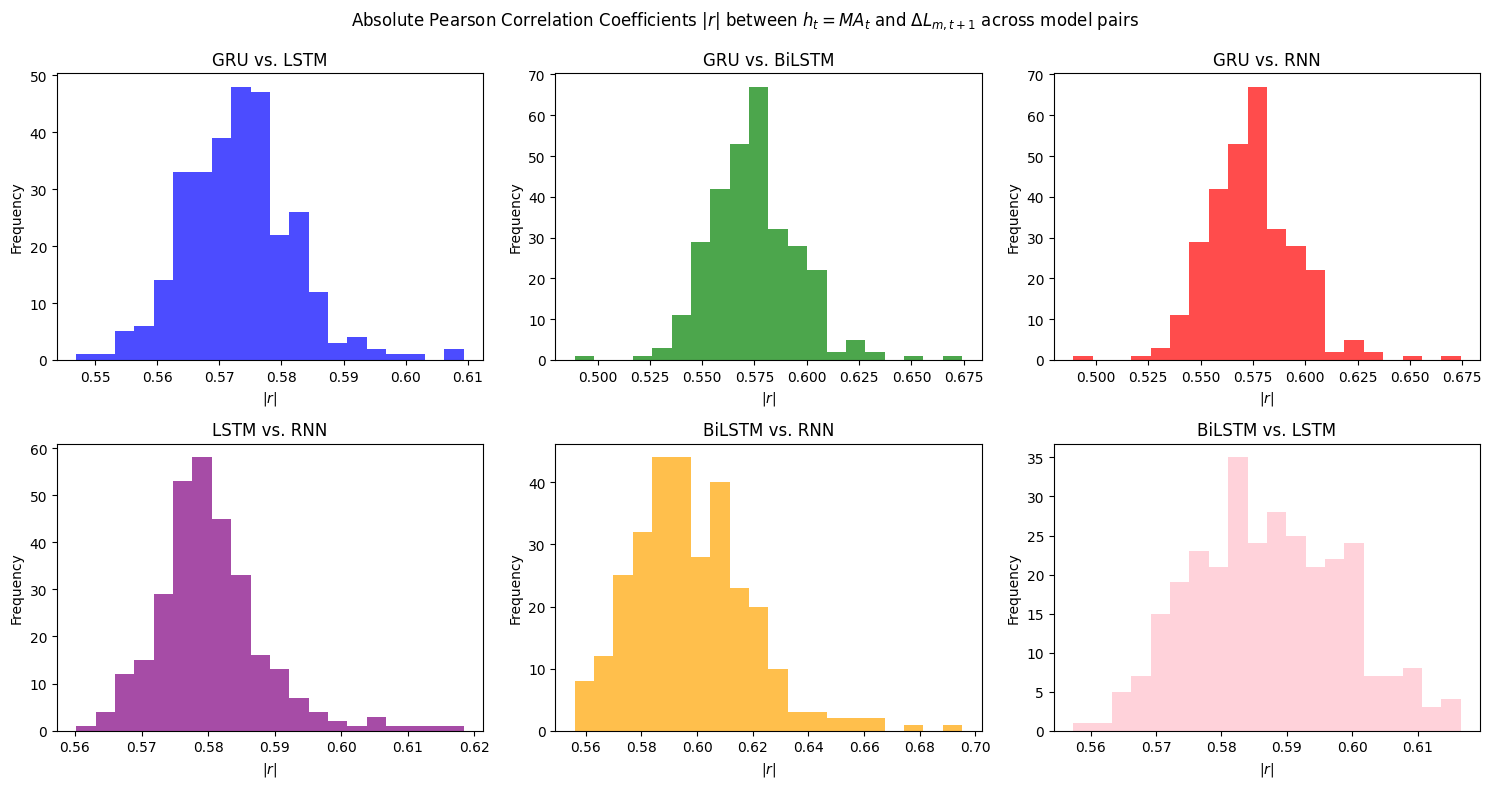

In [367]:

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Absolute Pearson Correlation Coefficients $|r|$ between $h_t=MA_t$ and $\Delta L_{m,t+1}$ across model pairs')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_GRUvsLSTM_MA, bins=20, color='blue', alpha=0.7)
axes[0, 0].set_title('GRU vs. LSTM')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')

# Add plots for other correlations
axes[0, 1].hist(corr_sim_GRUvsBiLSTM_MA, bins=20, color='green', alpha=0.7)
axes[0, 1].set_title('GRU vs. BiLSTM')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(corr_sim_GRUvsRNN_MA, bins=20, color='red', alpha=0.7)
axes[0, 2].set_title('GRU vs. RNN')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')

axes[1, 0].hist(corr_sim_RNNvsLSTM_MA, bins=20, color='purple', alpha=0.7)
axes[1, 0].set_title('LSTM vs. RNN')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(corr_sim_BiLSTMvsRNN_MA, bins=20, color='orange', alpha=0.7)
axes[1, 1].set_title('BiLSTM vs. RNN')
axes[1, 1].set_xlabel('$|r|$')
axes[1, 1].set_ylabel('Frequency')

axes[1, 2].hist(corr_sim_BiLSTMvsLSTM_MA, bins=20, color='pink', alpha=0.7)
axes[1, 2].set_title('BiLSTM vs. LSTM')
axes[1, 2].set_xlabel('$|r|$')
axes[1, 2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


## Combi

In [368]:
h_t_combiLSTMvsGRU_Sim_gfbm= np.zeros((n_simulations, 2, 398))
h_t_combiBiLSTMvsGRU_Sim_gfbm=np.zeros((n_simulations, 2, 398))
h_t_combiRNNvsGRU_Sim_gfbm=np.zeros((n_simulations, 2, 398))
h_t_combiLSTMvsRNN_Sim_gfbm=np.zeros((n_simulations, 2, 398))
h_t_combiBiLSTMvsRNN_Sim_gfbm=np.zeros((n_simulations, 2, 398))
h_t_combiLSTMvsBiLSTM_Sim_gfbm=np.zeros((n_simulations, 2, 398))

for i in range(0,300):
    # LSTM vs GRU
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)
    h_t_combiLSTMvsGRU_Sim_gfbm[i]=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsRNN[:, :-1]))


# BiLSTM vs GRU
    h_t_lossdifferenceBiLSTMvsGRU=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    h_t_lossdifferenceBiLSTMvsGRU= np.insert(h_t_lossdifferenceBiLSTMvsGRU, 0, 0)
    h_t_lossdifferenceBiLSTMvsGRU=h_t_lossdifferenceBiLSTMvsGRU.reshape(1, -1)
    h_t_combiBiLSTMvsGRU_Sim_gfbm[i]=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsGRU[:, :-1]))


# RNN vs GRU
    h_t_lossdifferenceGRUvsRNN=loss_values_RNN_Sim_gfbm[i]-loss_values_GRU_Sim_gfbm[i]
    h_t_lossdifferenceGRUvsRNN= np.insert(h_t_lossdifferenceGRUvsRNN, 0, 0)
    h_t_lossdifferenceGRUvsRNN=h_t_lossdifferenceGRUvsRNN.reshape(1, -1)
    h_t_combiRNNvsGRU_Sim_gfbm[i]=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceGRUvsRNN[:, :-1]))
    
# LSTM vs RNN
    h_t_lossdifferenceLSTMvsRNN=loss_values_LSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]
    h_t_lossdifferenceLSTMvsRNN= np.insert(h_t_lossdifferenceLSTMvsRNN, 0, 0)
    h_t_lossdifferenceLSTMvsRNN=h_t_lossdifferenceLSTMvsRNN.reshape(1, -1)

    h_t_combiLSTMvsRNN_Sim_gfbm[i]=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceLSTMvsRNN[:, :-1]))

   

# BiLSTM vs RNN
    h_t_lossdifferenceBiLSTMvsRNN=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i]
    h_t_lossdifferenceBiLSTMvsRNN= np.insert(h_t_lossdifferenceBiLSTMvsRNN, 0, 0)
    h_t_lossdifferenceBiLSTMvsRNN=h_t_lossdifferenceBiLSTMvsRNN.reshape(1, -1)

    h_t_combiBiLSTMvsRNN_Sim_gfbm[i]=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsRNN[:, :-1]))
    

# LSTM vs BiLSTM
    h_t_lossdifferenceBiLSTMvsLSTM=loss_values_BiLSTM_Sim_gfbm[i]-loss_values_LSTM_Sim_gfbm[i]
    h_t_lossdifferenceBiLSTMvsLSTM= np.insert(h_t_lossdifferenceBiLSTMvsLSTM, 0, 0)
    h_t_lossdifferenceBiLSTMvsLSTM=h_t_lossdifferenceBiLSTMvsLSTM.reshape(1, -1)

    h_t_combiLSTMvsBiLSTM_Sim_gfbm[i]=np.vstack((h_t_indicator_1x398, h_t_lossdifferenceBiLSTMvsLSTM[:, :-1]))


In [369]:
corr_sim_GRUvsLSTM_combi = np.zeros((n_simulations, 3, 3))
corr_sim_GRUvsBiLSTM_combi = np.zeros((n_simulations, 3, 3))
corr_sim_GRUvsRNN_combi= np.zeros((n_simulations, 3, 3))
corr_sim_RNNvsLSTM_combi = np.zeros((n_simulations, 3, 3))
corr_sim_BiLSTMvsRNN_combi = np.zeros((n_simulations, 3, 3))
corr_sim_BiLSTMvsLSTM_combi= np.zeros((n_simulations, 3, 3))

for i in range(0, 300):
    # GRU vs LSTM
    corrGRUvsLSTM = np.corrcoef(((loss_values_GRU_Sim_gfbm[i]-loss_values_LSTM_Sim_gfbm[i])[1:]),  h_t_combiLSTMvsGRU_Sim_gfbm[i][:, :-1])
    corr_sim_GRUvsLSTM_combi[i]=abs(corrGRUvsLSTM)

    # GRU vs BiLSTM
    corrGRUvsBiLSTM = np.corrcoef(((loss_values_GRU_Sim_gfbm[i]-loss_values_BiLSTM_Sim_gfbm[i])[1:]),  h_t_combiBiLSTMvsGRU_Sim_gfbm[i][:, :-1])
    corr_sim_GRUvsBiLSTM_combi[i]=abs(corrGRUvsBiLSTM)

    #GRU vs RNN
    corrGRUvsRNN = np.corrcoef(((loss_values_GRU_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i])[1:]),  h_t_combiRNNvsGRU_Sim_gfbm[i][:, :-1])
    corr_sim_GRUvsRNN_combi[i]=abs(corrGRUvsRNN)
    #LSTM vs RNN
    corrRNNvsLSTM = np.corrcoef(((loss_values_LSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i])[1:]),  h_t_combiLSTMvsRNN_Sim_gfbm[i][:, :-1])
    corr_sim_RNNvsLSTM_combi[i]=abs(corrRNNvsLSTM)

    #BiLSTM vs RNN
    corrRNNvsBiLSTM = np.corrcoef(((loss_values_BiLSTM_Sim_gfbm[i]-loss_values_RNN_Sim_gfbm[i])[1:]),  h_t_combiBiLSTMvsRNN_Sim_gfbm[i][:, :-1])
    corr_sim_BiLSTMvsRNN_combi[i]=abs(corrRNNvsBiLSTM)

    # BiLSTM vs LSTM
    corrBiLSTMvsLSTM = np.corrcoef(((loss_values_BiLSTM_Sim_gfbm[i]-loss_values_LSTM_Sim_gfbm[i])[1:]),  h_t_combiLSTMvsBiLSTM_Sim_gfbm[i][:, :-1])
    corr_sim_BiLSTMvsLSTM_combi[i]=abs(corrBiLSTMvsLSTM)


In [370]:
corr_sim_GRUvsLSTM_combi_fin = np.zeros(300)
corr_sim_GRUvsBiLSTM_combi_fin = np.zeros(300)
corr_sim_GRUvsRNN_combi_fin= np.zeros(300)
corr_sim_RNNvsLSTM_combi_fin = np.zeros(300)
corr_sim_BiLSTMvsRNN_combi_fin = np.zeros(300)
corr_sim_BiLSTMvsLSTM_combi_fin= np.zeros(300)


In [371]:
for i in range(0,300):
    corr=corr_sim_GRUvsLSTM_combi[i][0,1]+corr_sim_GRUvsLSTM_combi[i][0,2]
    corr_sim_GRUvsLSTM_combi_fin[i]=corr


    corr=corr_sim_GRUvsBiLSTM_combi[i][0,1]+corr_sim_GRUvsBiLSTM_combi[i][0,2]
    corr_sim_GRUvsBiLSTM_combi_fin[i]=corr

    corr=corr_sim_GRUvsRNN_combi[i][0,1]+corr_sim_GRUvsRNN_combi[i][0,2]
    corr_sim_GRUvsRNN_combi_fin[i]=corr

    corr=corr_sim_RNNvsLSTM_combi[i][0,1]+corr_sim_RNNvsLSTM_combi[i][0,2]
    corr_sim_RNNvsLSTM_combi_fin[i]=corr

    corr=corr_sim_BiLSTMvsRNN_combi[i][0,1]+corr_sim_BiLSTMvsRNN_combi[i][0,2]
    corr_sim_BiLSTMvsRNN_combi_fin[i]=corr

    corr=corr_sim_BiLSTMvsLSTM_combi[i][0,1]+corr_sim_BiLSTMvsLSTM_combi[i][0,2]
    corr_sim_BiLSTMvsLSTM_combi_fin[i]=corr

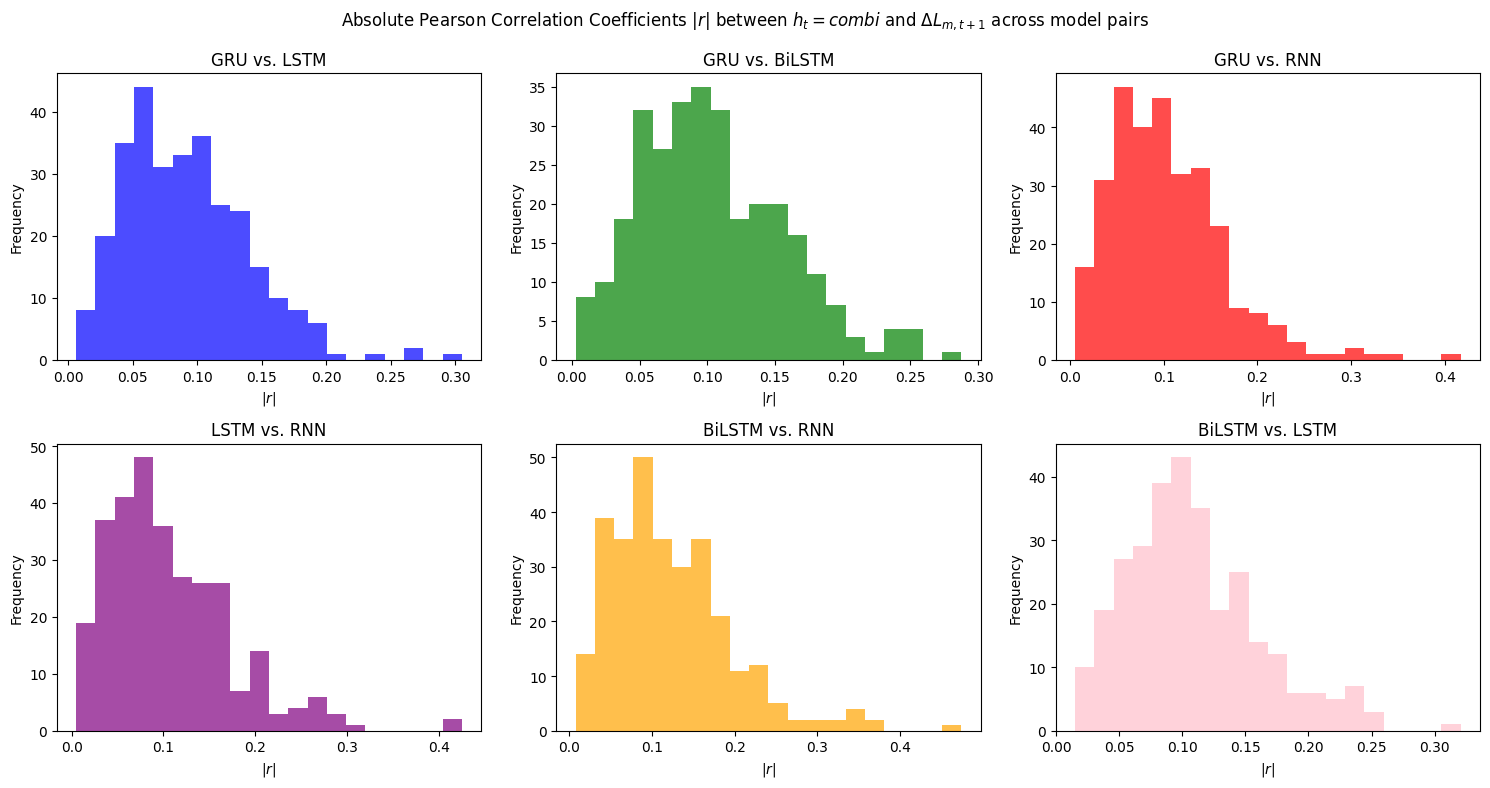

In [372]:

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Absolute Pearson Correlation Coefficients $|r|$ between $h_t=combi$ and $\Delta L_{m,t+1}$ across model pairs')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_GRUvsLSTM_combi_fin, bins=20, color='blue', alpha=0.7)
axes[0, 0].set_title('GRU vs. LSTM')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')

# Add plots for other correlations
axes[0, 1].hist(corr_sim_GRUvsBiLSTM_combi_fin, bins=20, color='green', alpha=0.7)
axes[0, 1].set_title('GRU vs. BiLSTM')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(corr_sim_GRUvsRNN_combi_fin, bins=20, color='red', alpha=0.7)
axes[0, 2].set_title('GRU vs. RNN')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')

axes[1, 0].hist(corr_sim_RNNvsLSTM_combi_fin, bins=20, color='purple', alpha=0.7)
axes[1, 0].set_title('LSTM vs. RNN')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(corr_sim_BiLSTMvsRNN_combi_fin, bins=20, color='orange', alpha=0.7)
axes[1, 1].set_title('BiLSTM vs. RNN')
axes[1, 1].set_xlabel('$|r|$')
axes[1, 1].set_ylabel('Frequency')

axes[1, 2].hist(corr_sim_BiLSTMvsLSTM_combi_fin, bins=20, color='pink', alpha=0.7)
axes[1, 2].set_title('BiLSTM vs. LSTM')
axes[1, 2].set_xlabel('$|r|$')
axes[1, 2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


Corr

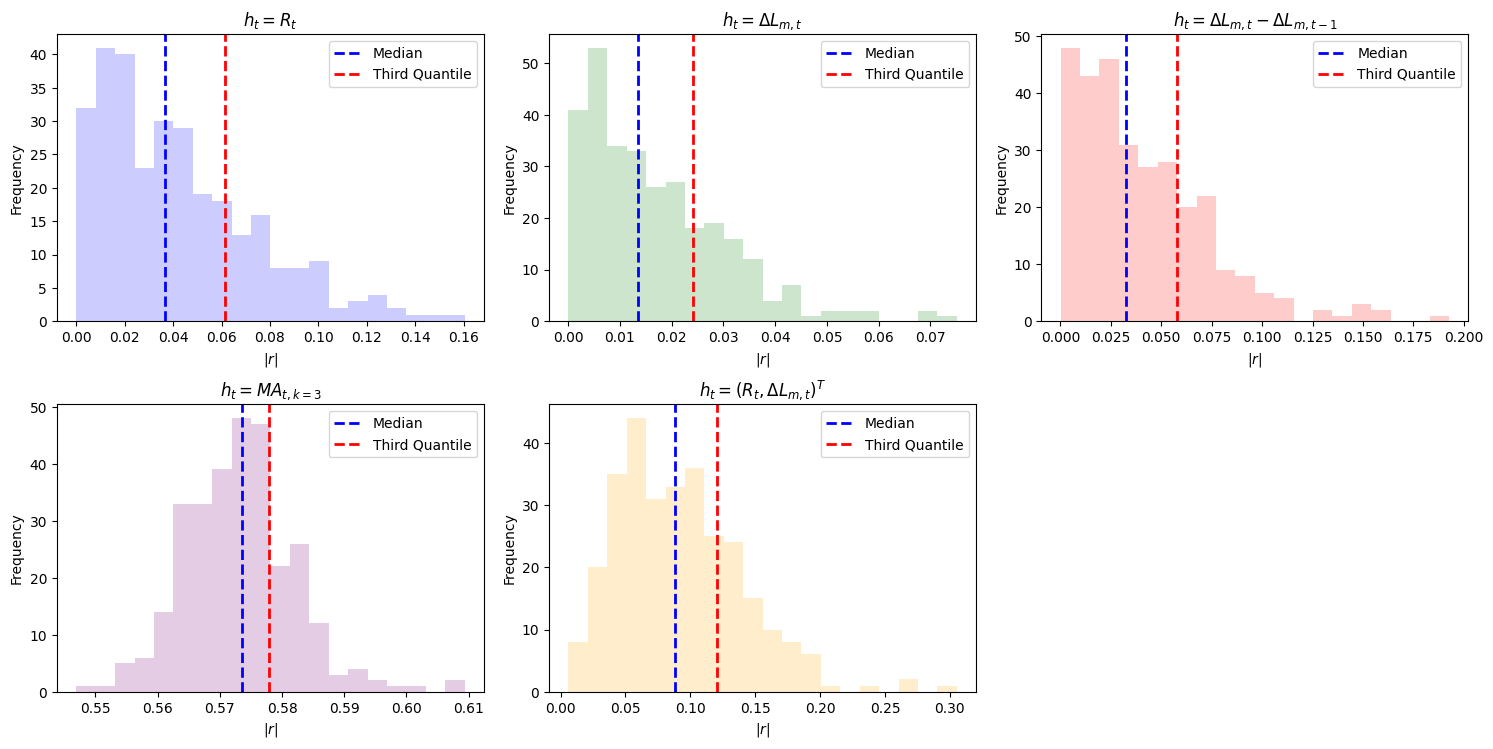

In [408]:

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
#fig.suptitle('Absolute Pearson Correlation Coefficients ($|r|$) between $h_t$ and $\Delta L_{m,t+1}$ in GRU vs. LSTM Comparison')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_GRUvsLSTM_InterestRate, bins=20, color='blue', alpha=0.2)
axes[0, 0].set_title('$h_t= R_t$')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.median(corr_sim_GRUvsLSTM_InterestRate), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 0].axvline(np.percentile(corr_sim_GRUvsLSTM_InterestRate, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')

axes[0, 0].legend()


# Add plots for other correlations
axes[0, 1].hist(corr_sim_GRUvsLSTM_lossdifference, bins=20, color='green', alpha=0.2)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.median(corr_sim_GRUvsLSTM_lossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 1].axvline(np.percentile(corr_sim_GRUvsLSTM_lossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 1].legend()

axes[0, 2].hist(corr_sim_GRUvsLSTM_laggedlossdifference, bins=20, color='red', alpha=0.2)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(np.median(corr_sim_GRUvsLSTM_laggedlossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 2].axvline(np.percentile(corr_sim_GRUvsLSTM_laggedlossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 2].legend()

axes[1, 0].hist(corr_sim_GRUvsLSTM_MA, bins=20, color='purple', alpha=0.2)
axes[1, 0].set_title('$h_t=MA_{t,k=3}$')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(np.median(corr_sim_GRUvsLSTM_MA), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 0].axvline(np.percentile(corr_sim_GRUvsLSTM_MA, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 0].legend()


axes[1, 1].hist(corr_sim_GRUvsLSTM_combi_fin, bins=20, color='orange', alpha=0.2)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})^T$')
axes[1, 1].set_xlabel('$|r|$')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(np.median(corr_sim_GRUvsLSTM_combi_fin), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 1].axvline(np.percentile(corr_sim_GRUvsLSTM_combi_fin, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 1].legend()


axes[1, 2].set_visible(False)

# Set titles for subplots
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


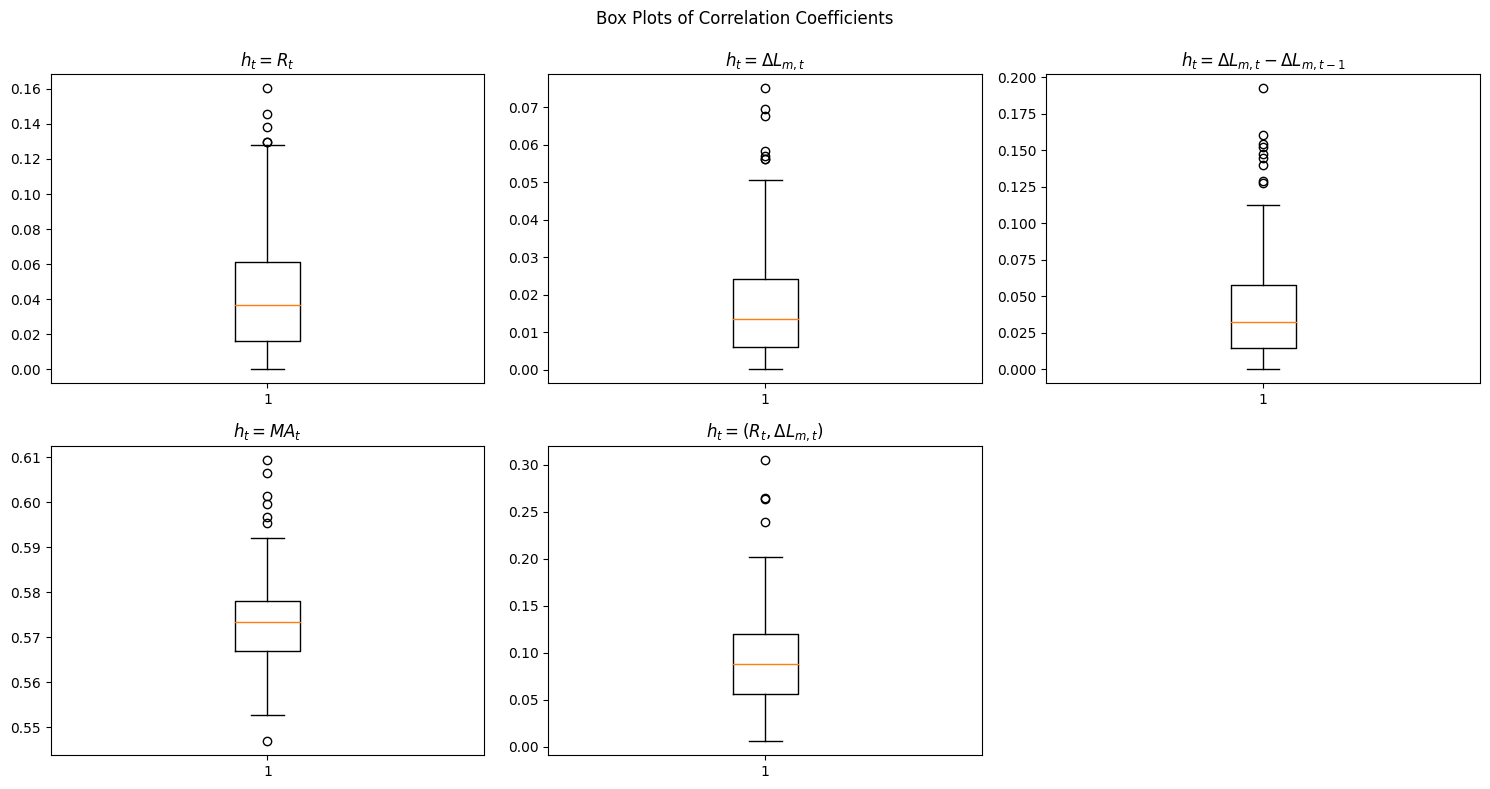

In [374]:

# Assuming you have calculated and stored the correlation coefficients in the arrays

# Create a figure and axis for the box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Box Plots of Correlation Coefficients')

# Plot GRU vs. BiLSTM
axes[0, 0].boxplot(corr_sim_GRUvsLSTM_InterestRate)
axes[0, 0].set_title('$h_t= R_t$')

# Add box plots for other correlations
axes[0, 1].boxplot(corr_sim_GRUvsLSTM_lossdifference)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')

axes[0, 2].boxplot(corr_sim_GRUvsLSTM_laggedlossdifference)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')

axes[1, 0].boxplot(corr_sim_GRUvsLSTM_MA)
axes[1, 0].set_title('$h_t=MA_t$')

axes[1, 1].boxplot(corr_sim_GRUvsLSTM_combi_fin)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})$')

axes[1, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the box plots
plt.show()


In [375]:
np.percentile(corr_sim_GRUvsLSTM_laggedlossdifference, [25, 75])

array([0.01502616, 0.05801236])

In [376]:
np.percentile(corr_sim_GRUvsLSTM_InterestRate, [25, 75])

array([0.01640021, 0.06126687])

In [377]:
np.percentile(corr_sim_GRUvsLSTM_lossdifference, [25, 75])

array([0.00595942, 0.02421071])

In [378]:
np.percentile(corr_sim_GRUvsLSTM_MA, [25, 75])

array([0.56690388, 0.5779839 ])

In [379]:
np.percentile(corr_sim_GRUvsLSTM_combi_fin, [25, 75])

array([0.05580249, 0.12046511])

In [380]:
np.percentile(corr_sim_GRUvsBiLSTM_laggedlossdifference, [25, 75])

array([0.01615612, 0.06308386])

In [381]:
np.percentile(corr_sim_GRUvsRNN_laggedlossdifference, [25, 75])

array([0.01594173, 0.05839943])

In [382]:
np.percentile(corr_sim_RNNvsLSTM_laggedlossdifference, [25, 75])

array([0.01650882, 0.05626099])

In [383]:
np.percentile(corr_sim_BiLSTMvsRNN_laggedlossdifference, [25, 75])

array([0.0142239 , 0.06104365])

In [384]:
np.percentile(corr_sim_BiLSTMvsLSTM_laggedlossdifference, [25, 75])

array([0.01168052, 0.06307393])

In [385]:
np.median(corr_sim_GRUvsLSTM_laggedlossdifference)

0.032677274013866116

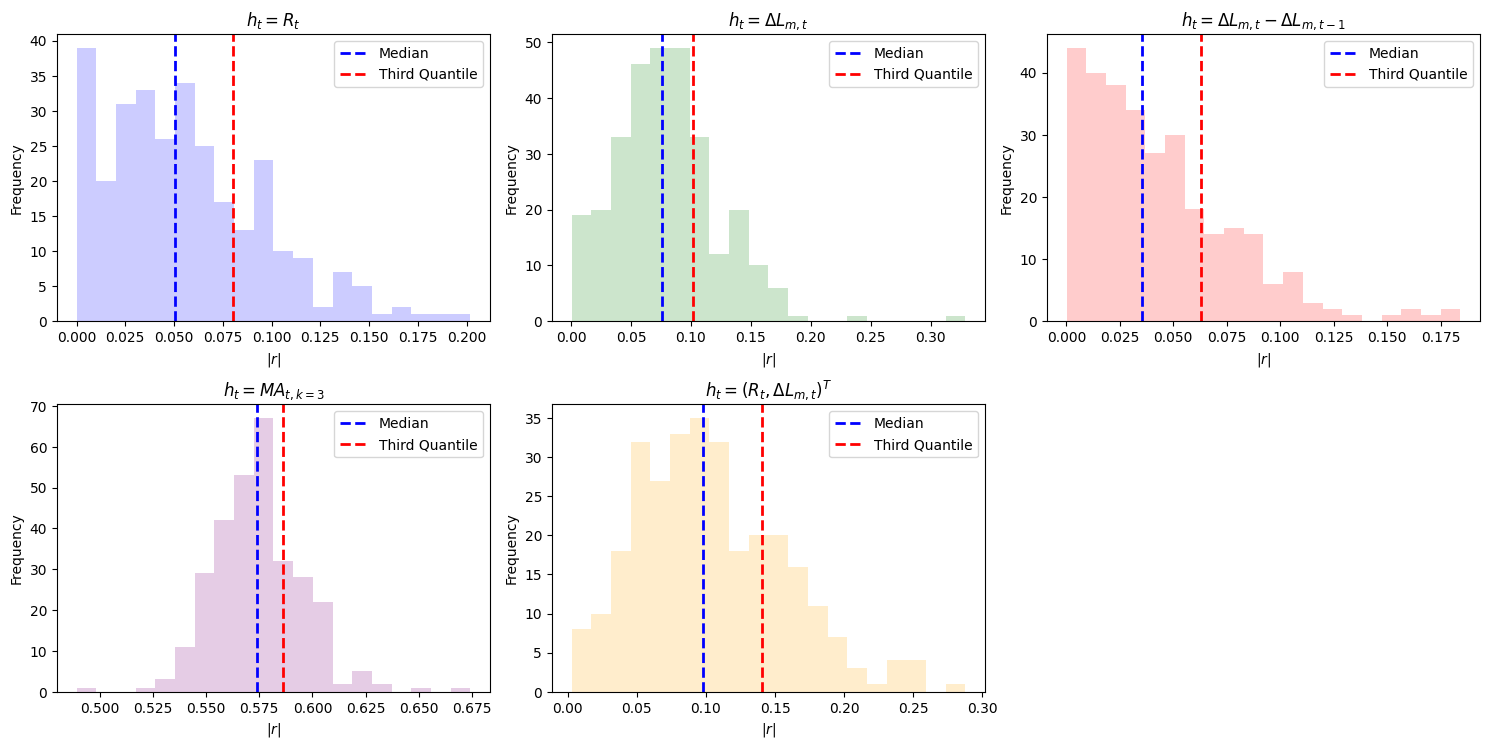

In [409]:

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
#fig.suptitle('Absolute Pearson Correlation Coefficients ($|r|$) between $h_t$ and $\Delta L_{m,t+1}$ in GRU vs. BiLSTM Comparison')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_GRUvsBiLSTM_InterestRate, bins=20, color='blue', alpha=0.2)
axes[0, 0].set_title('$h_t= R_t$')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.median(corr_sim_GRUvsBiLSTM_InterestRate), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 0].axvline(np.percentile(corr_sim_GRUvsBiLSTM_InterestRate, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 0].legend()


# Add plots for other correlations
axes[0, 1].hist(corr_sim_GRUvsBiLSTM_lossdifference, bins=20, color='green', alpha=0.2)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.median(corr_sim_GRUvsBiLSTM_lossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 1].axvline(np.percentile(corr_sim_GRUvsBiLSTM_lossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 1].legend()

axes[0, 2].hist(corr_sim_GRUvsBiLSTM_laggedlossdifference, bins=20, color='red', alpha=0.2)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(np.median(corr_sim_GRUvsBiLSTM_laggedlossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 2].axvline(np.percentile(corr_sim_GRUvsBiLSTM_laggedlossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 2].legend()

axes[1, 0].hist(corr_sim_GRUvsBiLSTM_MA, bins=20, color='purple', alpha=0.2)
axes[1, 0].set_title('$h_t=MA_{t,k=3}$')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(np.median(corr_sim_GRUvsBiLSTM_MA), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 0].axvline(np.percentile(corr_sim_GRUvsBiLSTM_MA, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 0].legend()

axes[1, 1].hist(corr_sim_GRUvsBiLSTM_combi_fin, bins=20, color='orange', alpha=0.2)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})^T$')
axes[1, 1].set_xlabel('$|r|$')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(np.median(corr_sim_GRUvsBiLSTM_combi_fin), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 1].axvline(np.percentile(corr_sim_GRUvsBiLSTM_combi_fin, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 1].legend()

axes[1, 2].set_visible(False)
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


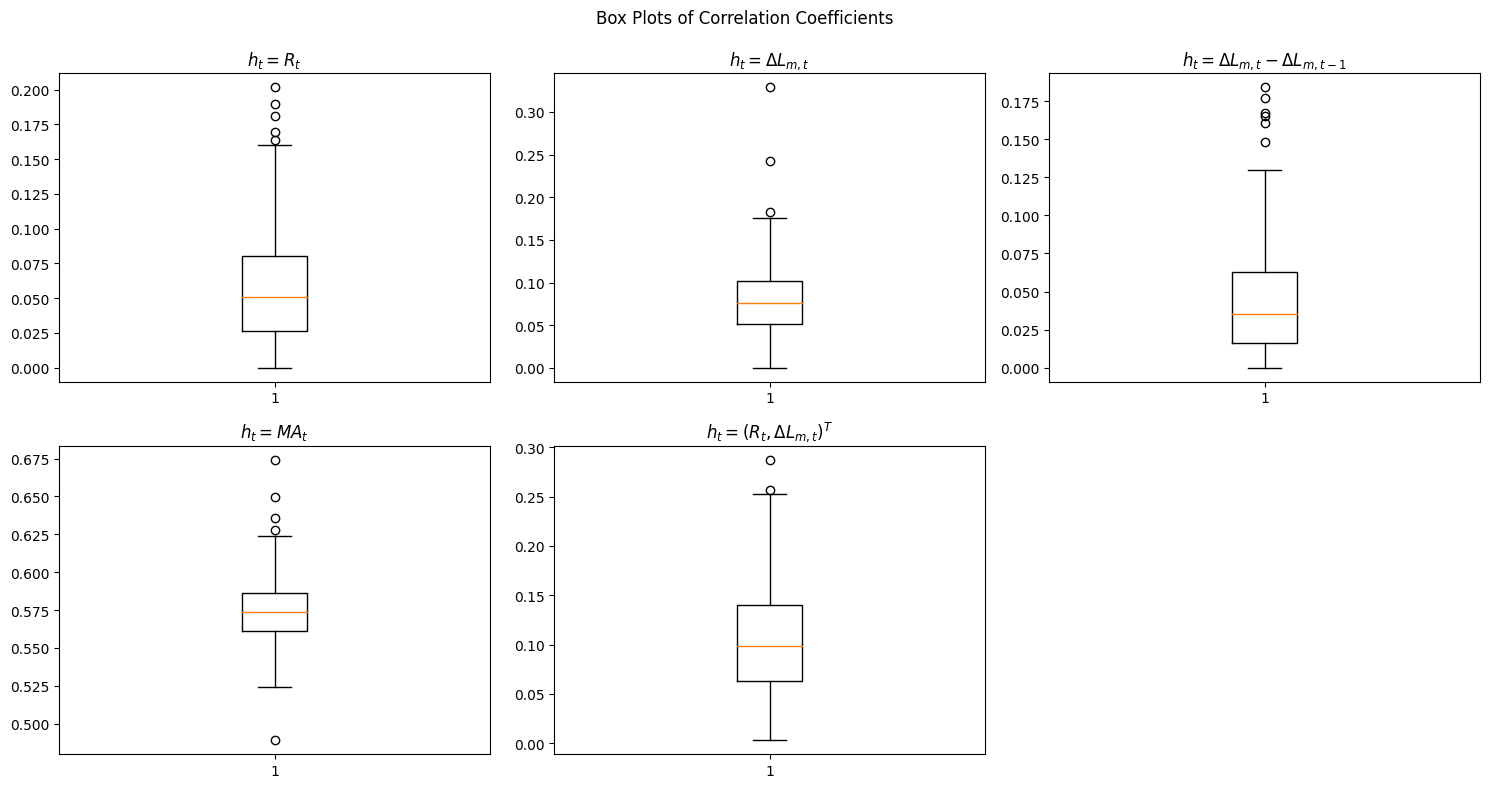

In [387]:

# Assuming you have calculated and stored the correlation coefficients in the arrays

# Create a figure and axis for the box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Box Plots of Correlation Coefficients')

# Plot GRU vs. BiLSTM
axes[0, 0].boxplot(corr_sim_GRUvsBiLSTM_InterestRate)
axes[0, 0].set_title('$h_t= R_t$')

# Add box plots for other correlations
axes[0, 1].boxplot(corr_sim_GRUvsBiLSTM_lossdifference)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')

axes[0, 2].boxplot(corr_sim_GRUvsBiLSTM_laggedlossdifference)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')

axes[1, 0].boxplot(corr_sim_GRUvsBiLSTM_MA)
axes[1, 0].set_title('$h_t=MA_t$')

axes[1, 1].boxplot(corr_sim_GRUvsBiLSTM_combi_fin)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})^T$')

axes[1, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the box plots
plt.show()


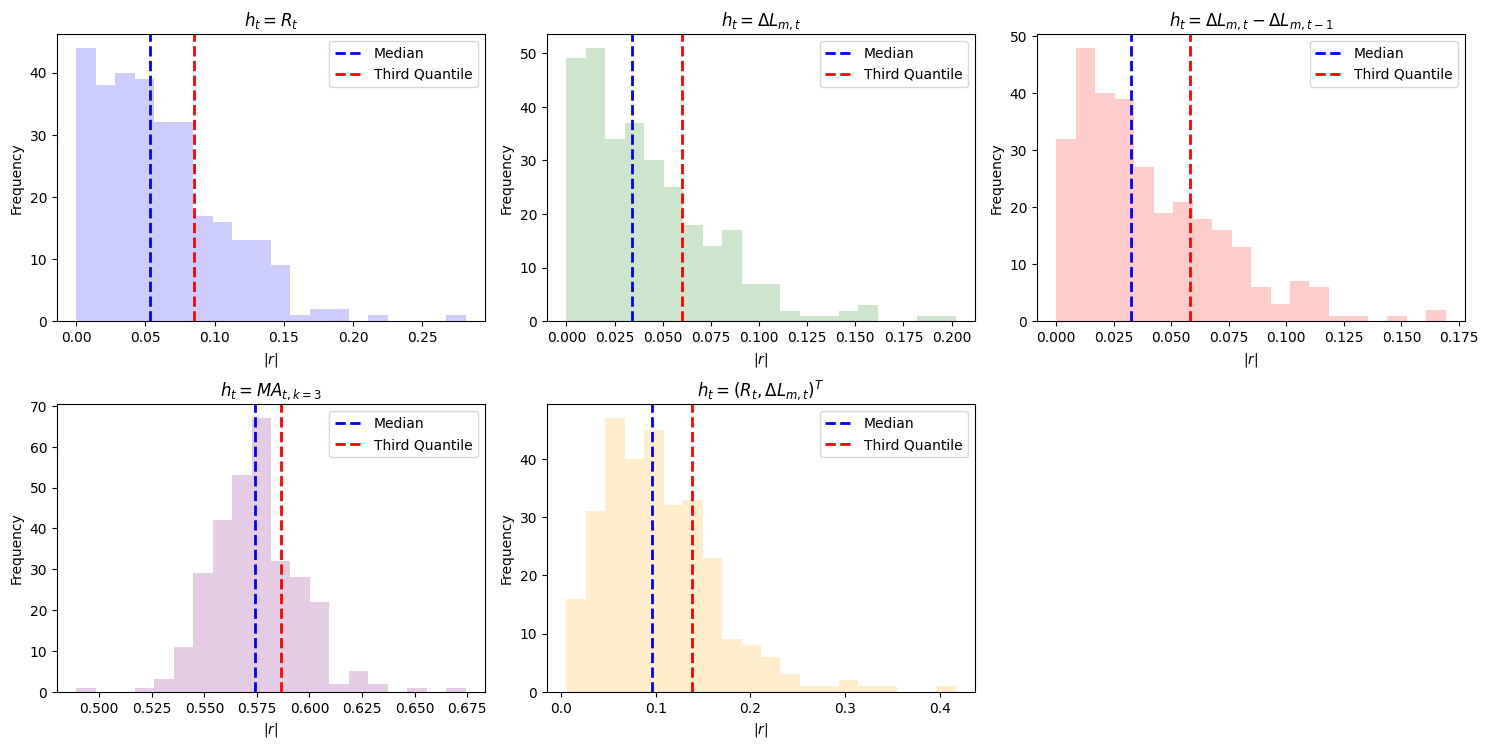

In [410]:

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
#fig.suptitle('Absolute Pearson Correlation Coefficients ($|r|$) between $h_t$ and $\Delta L_{m,t+1}$ in GRU vs. RNN Comparison')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_GRUvsRNN_InterestRate, bins=20, color='blue', alpha=0.2)
axes[0, 0].set_title('$h_t= R_t$')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.median(corr_sim_GRUvsRNN_InterestRate), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 0].axvline(np.percentile(corr_sim_GRUvsRNN_InterestRate, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 0].legend()


# Add plots for other correlations
axes[0, 1].hist(corr_sim_GRUvsRNN_lossdifference, bins=20, color='green', alpha=0.2)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.median(corr_sim_GRUvsRNN_lossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 1].axvline(np.percentile(corr_sim_GRUvsRNN_lossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 1].legend()


axes[0, 2].hist(corr_sim_GRUvsRNN_laggedlossdifference, bins=20, color='red', alpha=0.2)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(np.median(corr_sim_GRUvsRNN_laggedlossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 2].axvline(np.percentile(corr_sim_GRUvsRNN_laggedlossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 2].legend()

axes[1, 0].hist(corr_sim_GRUvsRNN_MA, bins=20, color='purple', alpha=0.2)
axes[1, 0].set_title('$h_t=MA_{t,k=3}$')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(np.median(corr_sim_GRUvsRNN_MA), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 0].axvline(np.percentile(corr_sim_GRUvsRNN_MA, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 0].legend()


axes[1, 1].hist(corr_sim_GRUvsRNN_combi_fin, bins=20, color='orange', alpha=0.2)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})^T$')
axes[1, 1].set_xlabel('$|r|$')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(np.median(corr_sim_GRUvsRNN_combi_fin), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 1].axvline(np.percentile(corr_sim_GRUvsRNN_combi_fin, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 1].legend()


axes[1, 2].set_visible(False)
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


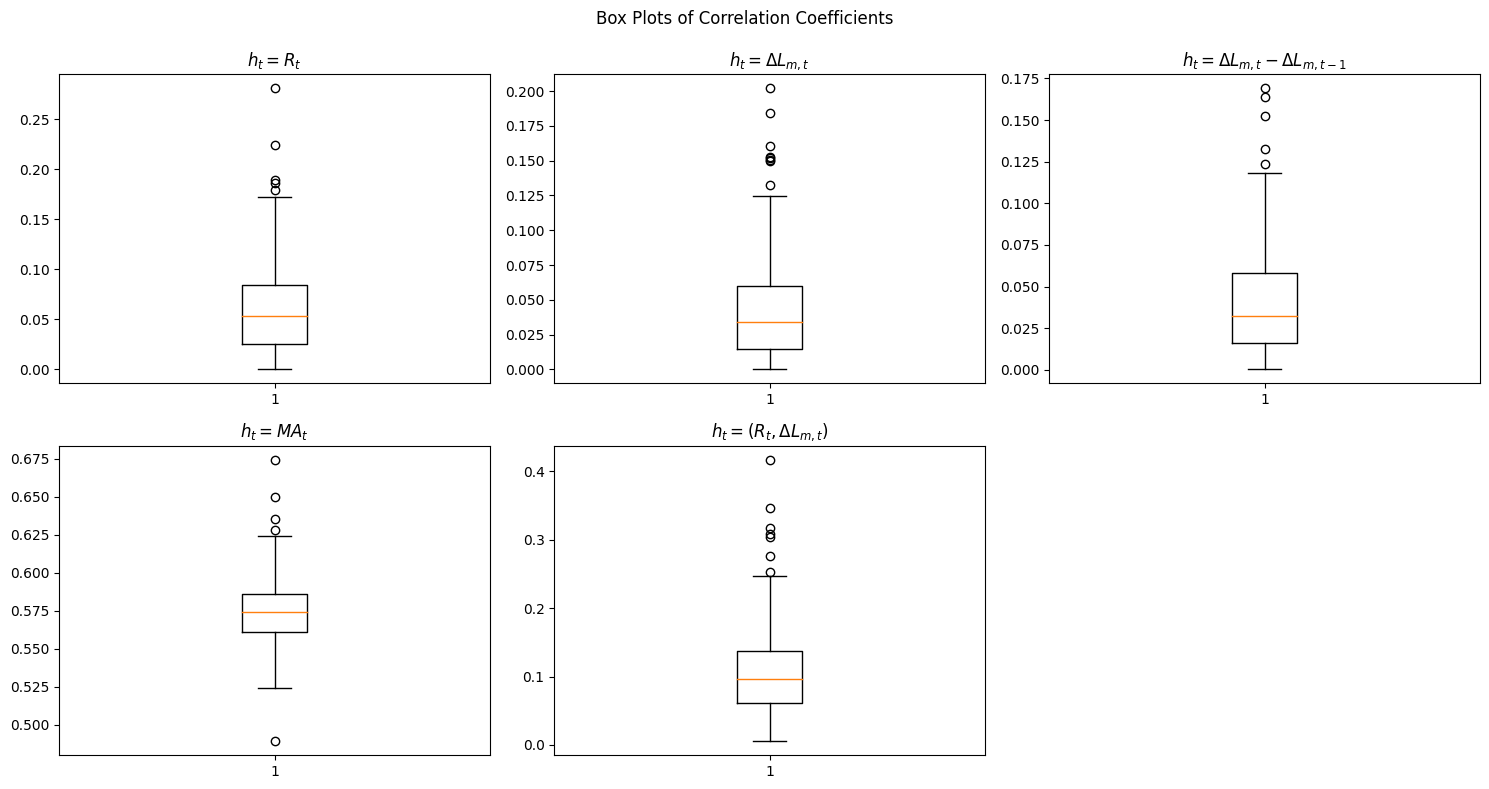

In [389]:

# Assuming you have calculated and stored the correlation coefficients in the arrays

# Create a figure and axis for the box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Box Plots of Correlation Coefficients')

# Plot GRU vs. BiLSTM
axes[0, 0].boxplot(corr_sim_GRUvsRNN_InterestRate)
axes[0, 0].set_title('$h_t= R_t$')

# Add box plots for other correlations
axes[0, 1].boxplot(corr_sim_GRUvsRNN_lossdifference)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')

axes[0, 2].boxplot(corr_sim_GRUvsRNN_laggedlossdifference)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')

axes[1, 0].boxplot(corr_sim_GRUvsRNN_MA)
axes[1, 0].set_title('$h_t=MA_t$')

axes[1, 1].boxplot(corr_sim_GRUvsRNN_combi_fin)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})$')

axes[1, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the box plots
plt.show()


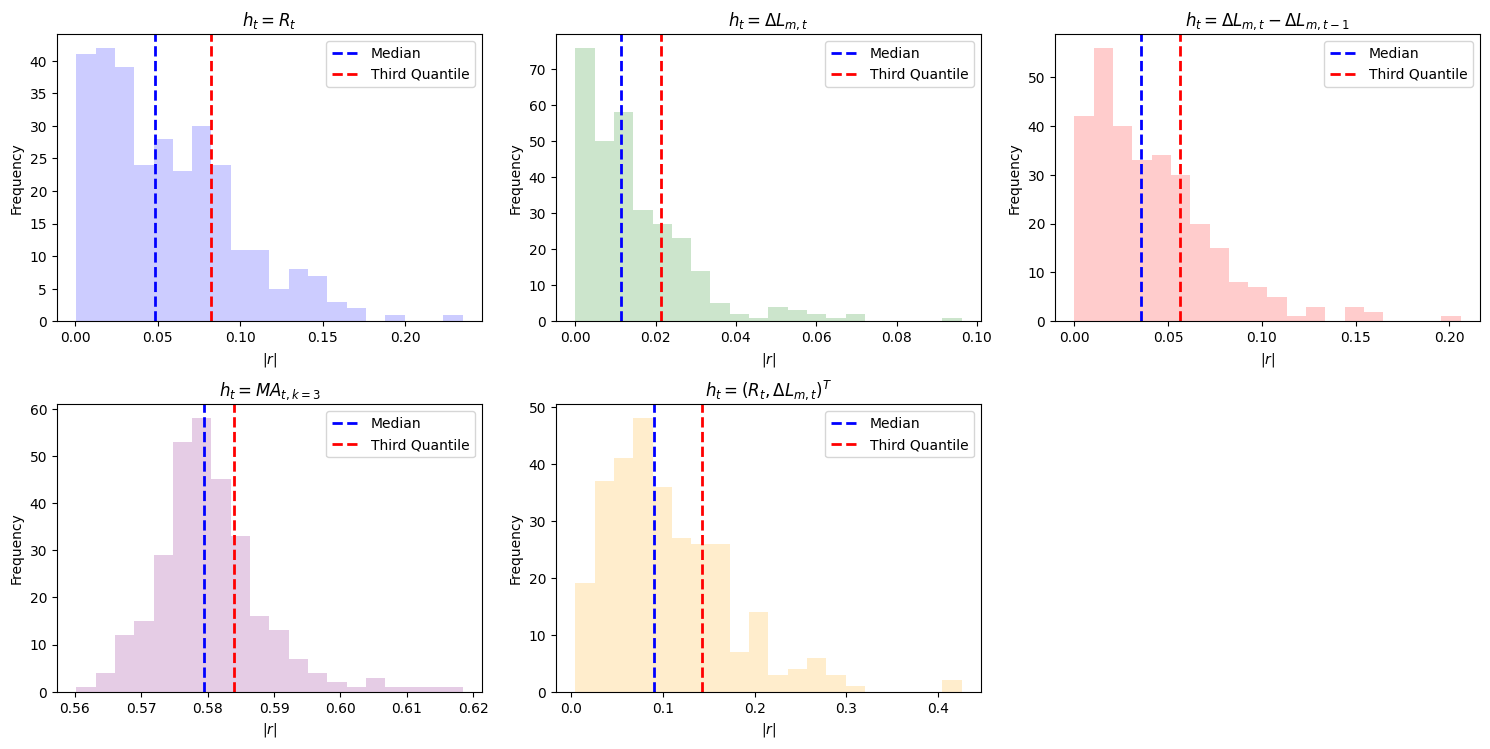

In [411]:

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
#fig.suptitle('Absolute Pearson Correlation Coefficients ($|r|$) between $h_t$ and $\Delta L_{m,t+1}$ in RNN vs. LSTM Comparison')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_LSTMvsRNN_InterestRate, bins=20, color='blue', alpha=0.2)
axes[0, 0].set_title('$h_t= R_t$')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.median(corr_sim_LSTMvsRNN_InterestRate), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 0].axvline(np.percentile(corr_sim_LSTMvsRNN_InterestRate, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 0].legend()
# Add plots for other correlations
axes[0, 1].hist(corr_sim_RNNvsLSTM_lossdifference, bins=20, color='green', alpha=0.2)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.median(corr_sim_RNNvsLSTM_lossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 1].axvline(np.percentile(corr_sim_RNNvsLSTM_lossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 1].legend()

axes[0, 2].hist(corr_sim_RNNvsLSTM_laggedlossdifference, bins=20, color='red', alpha=0.2)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(np.median(corr_sim_RNNvsLSTM_laggedlossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 2].axvline(np.percentile(corr_sim_RNNvsLSTM_laggedlossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 2].legend()

axes[1, 0].hist(corr_sim_RNNvsLSTM_MA, bins=20, color='purple', alpha=0.2)
axes[1, 0].set_title('$h_t=MA_{t,k=3}$')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(np.median(corr_sim_RNNvsLSTM_MA), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 0].axvline(np.percentile(corr_sim_RNNvsLSTM_MA, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 0].legend()

axes[1, 1].hist(corr_sim_RNNvsLSTM_combi_fin, bins=20, color='orange', alpha=0.2)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})^T$')
axes[1, 1].set_xlabel('$|r|$')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(np.median(corr_sim_RNNvsLSTM_combi_fin), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 1].axvline(np.percentile(corr_sim_RNNvsLSTM_combi_fin, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 1].legend()


axes[1, 2].set_visible(False)
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


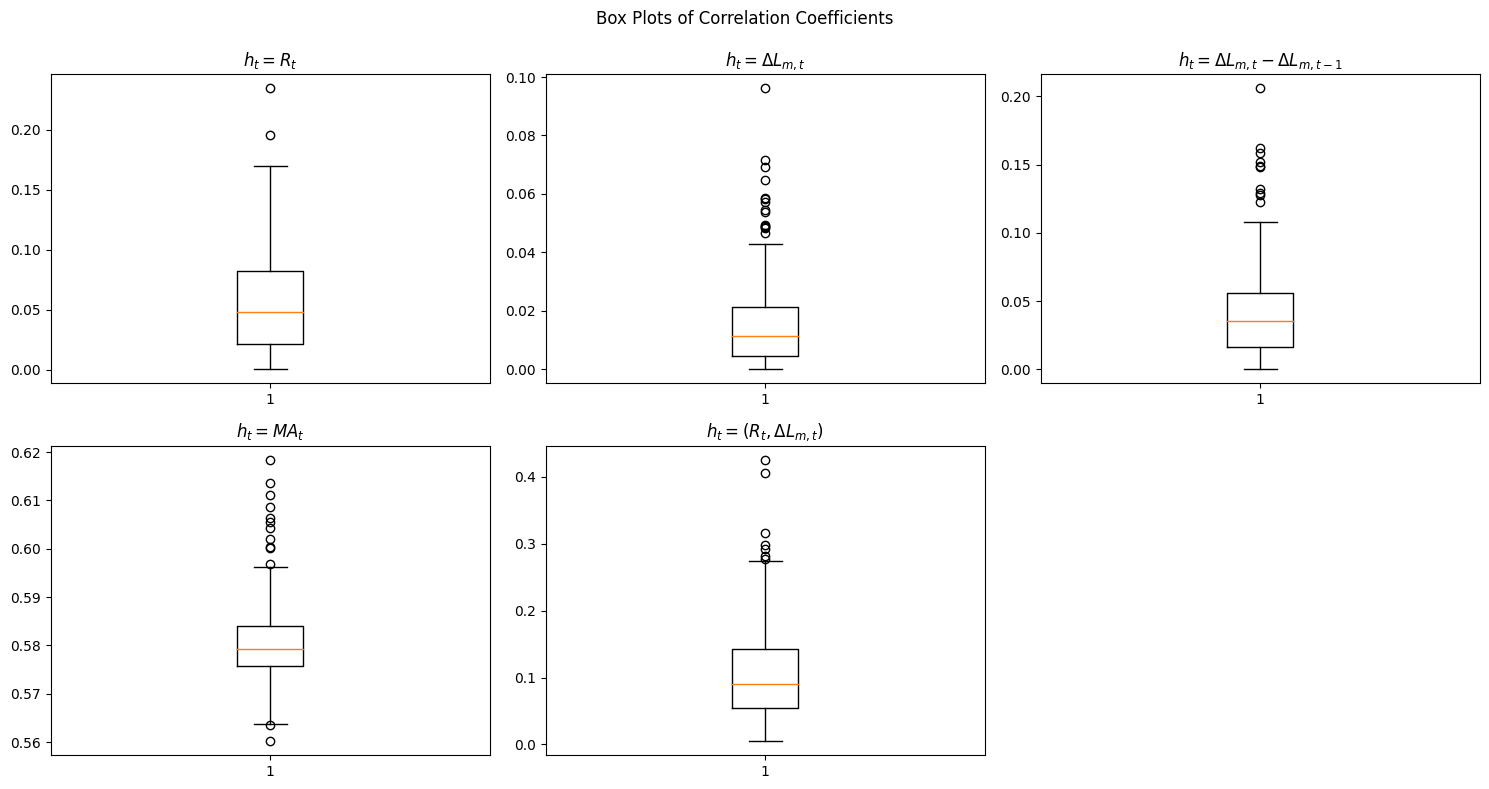

In [391]:

# Assuming you have calculated and stored the correlation coefficients in the arrays

# Create a figure and axis for the box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Box Plots of Correlation Coefficients')

# Plot GRU vs. BiLSTM
axes[0, 0].boxplot(corr_sim_LSTMvsRNN_InterestRate)
axes[0, 0].set_title('$h_t= R_t$')

# Add box plots for other correlations
axes[0, 1].boxplot(corr_sim_RNNvsLSTM_lossdifference)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')

axes[0, 2].boxplot(corr_sim_RNNvsLSTM_laggedlossdifference)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')

axes[1, 0].boxplot(corr_sim_RNNvsLSTM_MA)
axes[1, 0].set_title('$h_t=MA_t$')

axes[1, 1].boxplot(corr_sim_RNNvsLSTM_combi_fin)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})$')

axes[1, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the box plots
plt.show()


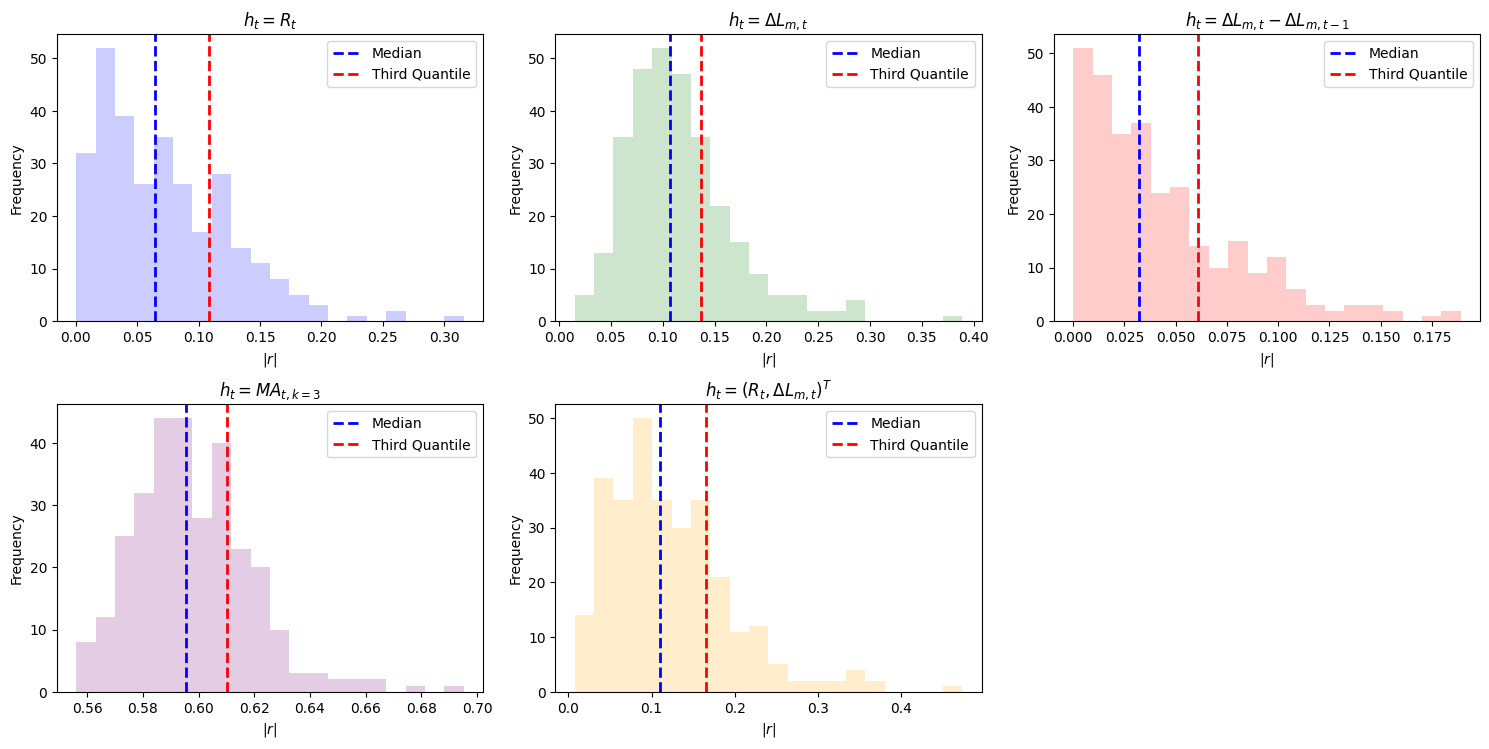

In [412]:

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
#fig.suptitle('Absolute Pearson Correlation Coefficients ($|r|$) between $h_t$ and $\Delta L_{m,t+1}$ in RNN vs. BiLSTM Comparison')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_BiLSTMvsRNN_InterestRate, bins=20, color='blue', alpha=0.2)
axes[0, 0].set_title('$h_t= R_t$')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.median(corr_sim_BiLSTMvsRNN_InterestRate), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 0].axvline(np.percentile(corr_sim_BiLSTMvsRNN_InterestRate, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 0].legend()

# Add plots for other correlations
axes[0, 1].hist(corr_sim_BiLSTMvsRNN_lossdifference, bins=20, color='green', alpha=0.2)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.median(corr_sim_BiLSTMvsRNN_lossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 1].axvline(np.percentile(corr_sim_BiLSTMvsRNN_lossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 1].legend()

axes[0, 2].hist(corr_sim_BiLSTMvsRNN_laggedlossdifference, bins=20, color='red', alpha=0.2)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(np.median(corr_sim_BiLSTMvsRNN_laggedlossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 2].axvline(np.percentile(corr_sim_BiLSTMvsRNN_laggedlossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 2].legend()


axes[1, 0].hist(corr_sim_BiLSTMvsRNN_MA, bins=20, color='purple', alpha=0.2)
axes[1, 0].set_title('$h_t=MA_{t,k=3}$')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(np.median(corr_sim_BiLSTMvsRNN_MA), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 0].axvline(np.percentile(corr_sim_BiLSTMvsRNN_MA, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 0].legend()


axes[1, 1].hist(corr_sim_BiLSTMvsRNN_combi_fin, bins=20, color='orange', alpha=0.2)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})^T$')
axes[1, 1].set_xlabel('$|r|$')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(np.median(corr_sim_BiLSTMvsRNN_combi_fin), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 1].axvline(np.percentile(corr_sim_BiLSTMvsRNN_combi_fin, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 1].legend()

axes[1, 2].set_visible(False)
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


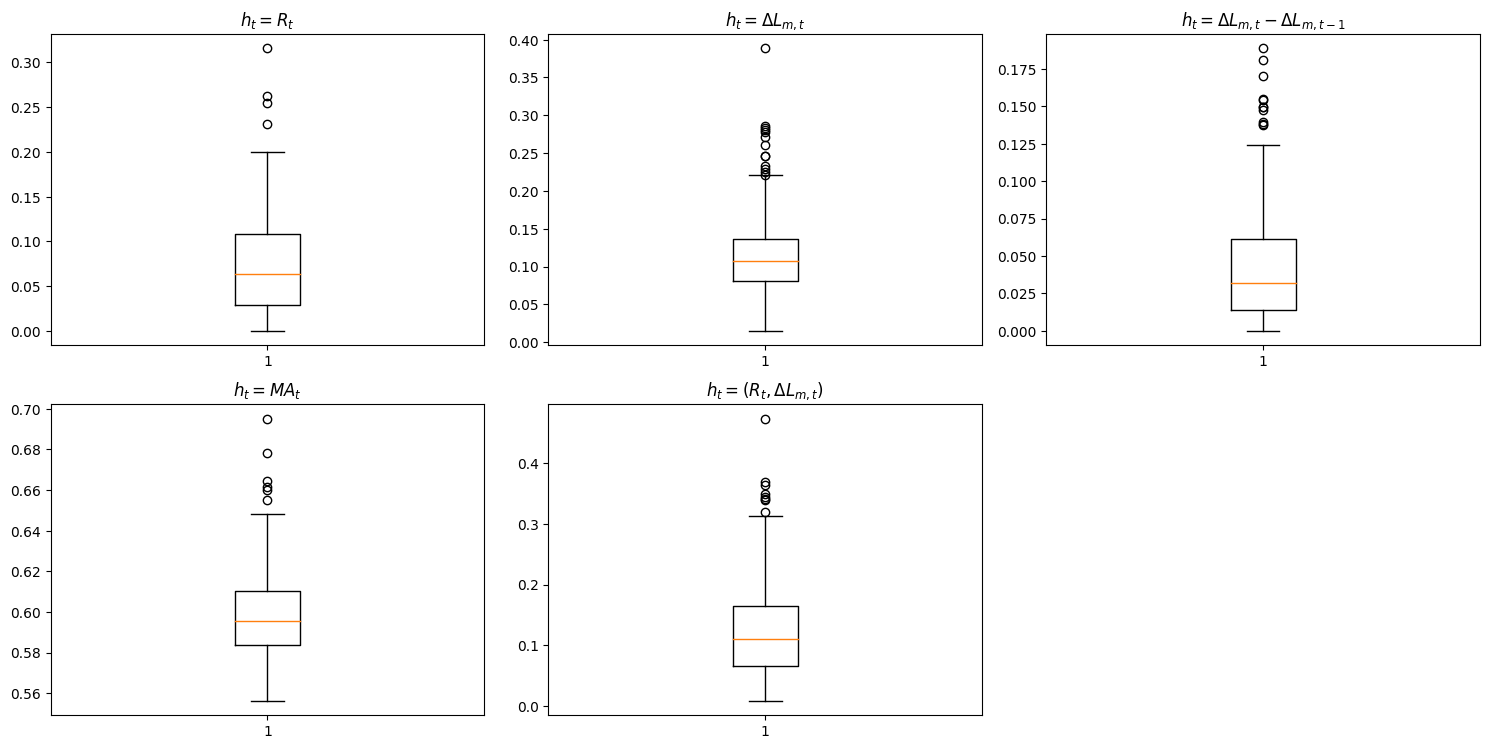

In [393]:

# Assuming you have calculated and stored the correlation coefficients in the arrays

# Create a figure and axis for the box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
#fig.suptitle('Box plots of ($|r|$) between $h_t$ and $\Delta L_{m,t+1}$ in RNN vs. BiLSTM Comparison')

# Plot GRU vs. BiLSTM
axes[0, 0].boxplot(corr_sim_BiLSTMvsRNN_InterestRate)
axes[0, 0].set_title('$h_t= R_t$')

# Add box plots for other correlations
axes[0, 1].boxplot(corr_sim_BiLSTMvsRNN_lossdifference)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')

axes[0, 2].boxplot(corr_sim_BiLSTMvsRNN_laggedlossdifference)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')

axes[1, 0].boxplot(corr_sim_BiLSTMvsRNN_MA)
axes[1, 0].set_title('$h_t=MA_t$')

axes[1, 1].boxplot(corr_sim_BiLSTMvsRNN_combi_fin)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})$')

axes[1, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the box plots
plt.show()


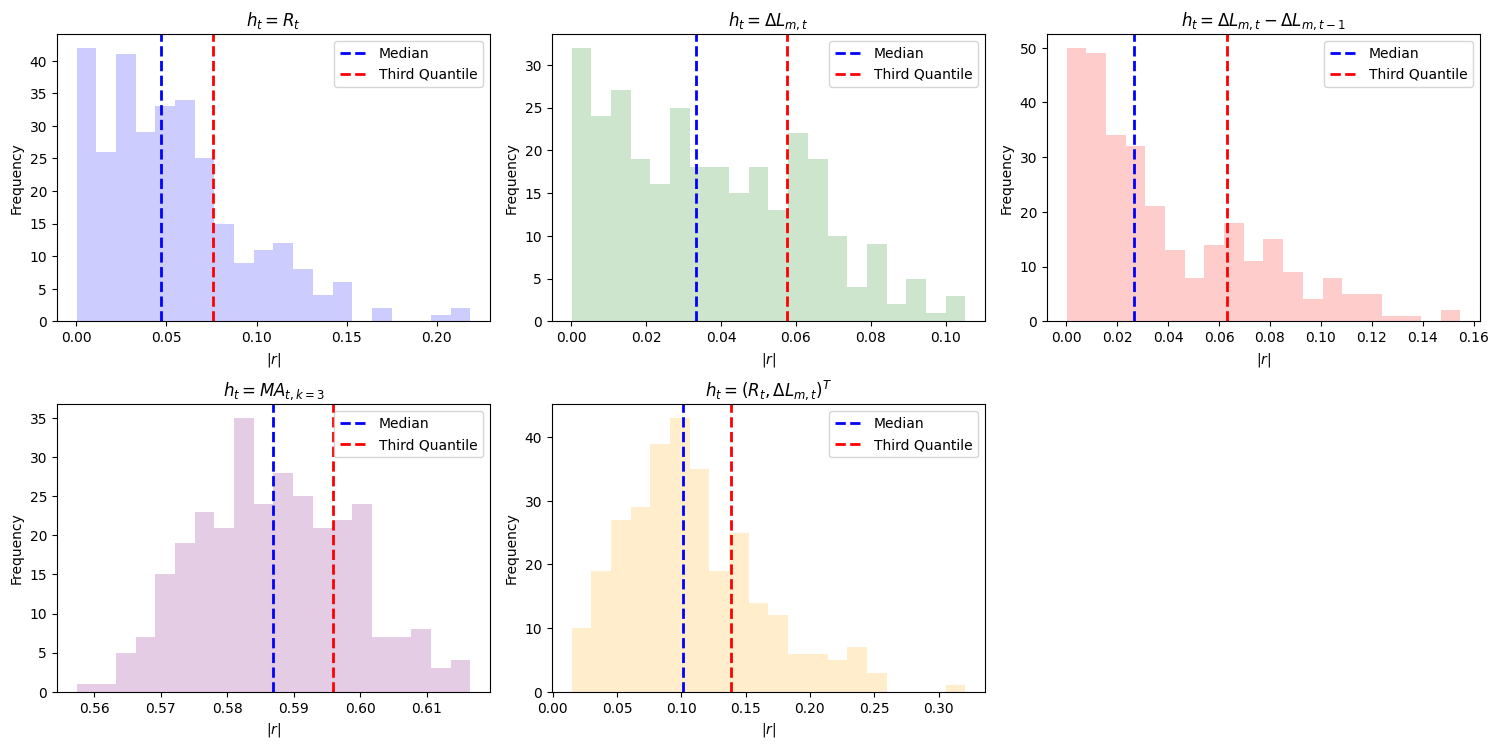

In [413]:

# Create a figure and axis for the plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
#fig.suptitle('Absolute Pearson Correlation Coefficients ($|r|$) between $h_t$ and $\Delta L_{m,t+1}$ in LSTM vs. BiLSTM Comparison')

# Plot GRU vs. BiLSTM
axes[0, 0].hist(corr_sim_BiLSTMvsLSTM_InterestRate, bins=20, color='blue', alpha=0.2)
axes[0, 0].set_title('$h_t= R_t$')
axes[0, 0].set_xlabel('$|r|$')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(np.median(corr_sim_BiLSTMvsLSTM_InterestRate), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 0].axvline(np.percentile(corr_sim_BiLSTMvsLSTM_InterestRate, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 0].legend()

# Add plots for other correlations
axes[0, 1].hist(corr_sim_BiLSTMvsLSTM_lossdifference, bins=20, color='green', alpha=0.2)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')
axes[0, 1].set_xlabel('$|r|$')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(np.median(corr_sim_BiLSTMvsLSTM_lossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 1].axvline(np.percentile(corr_sim_BiLSTMvsLSTM_lossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 1].legend()

axes[0, 2].hist(corr_sim_BiLSTMvsLSTM_laggedlossdifference, bins=20, color='red', alpha=0.2)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')
axes[0, 2].set_xlabel('$|r|$')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(np.median(corr_sim_BiLSTMvsLSTM_laggedlossdifference), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 2].axvline(np.percentile(corr_sim_BiLSTMvsLSTM_laggedlossdifference, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[0, 2].legend()

axes[1, 0].hist(corr_sim_BiLSTMvsLSTM_MA, bins=20, color='purple', alpha=0.2)
axes[1, 0].set_title('$h_t=MA_{t,k=3}$')
axes[1, 0].set_xlabel('$|r|$')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(np.median(corr_sim_BiLSTMvsLSTM_MA), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 0].axvline(np.percentile(corr_sim_BiLSTMvsLSTM_MA, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 0].legend()

axes[1, 1].hist(corr_sim_BiLSTMvsLSTM_combi_fin, bins=20, color='orange', alpha=0.2)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})^T$')
axes[1, 1].set_xlabel('$|r|$')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(np.median(corr_sim_BiLSTMvsLSTM_combi_fin), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 1].axvline(np.percentile(corr_sim_BiLSTMvsLSTM_combi_fin, 75), color='red', linestyle='dashed', linewidth=2, label='Third Quantile')
axes[1, 1].legend()

axes[1, 2].set_visible(False)
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


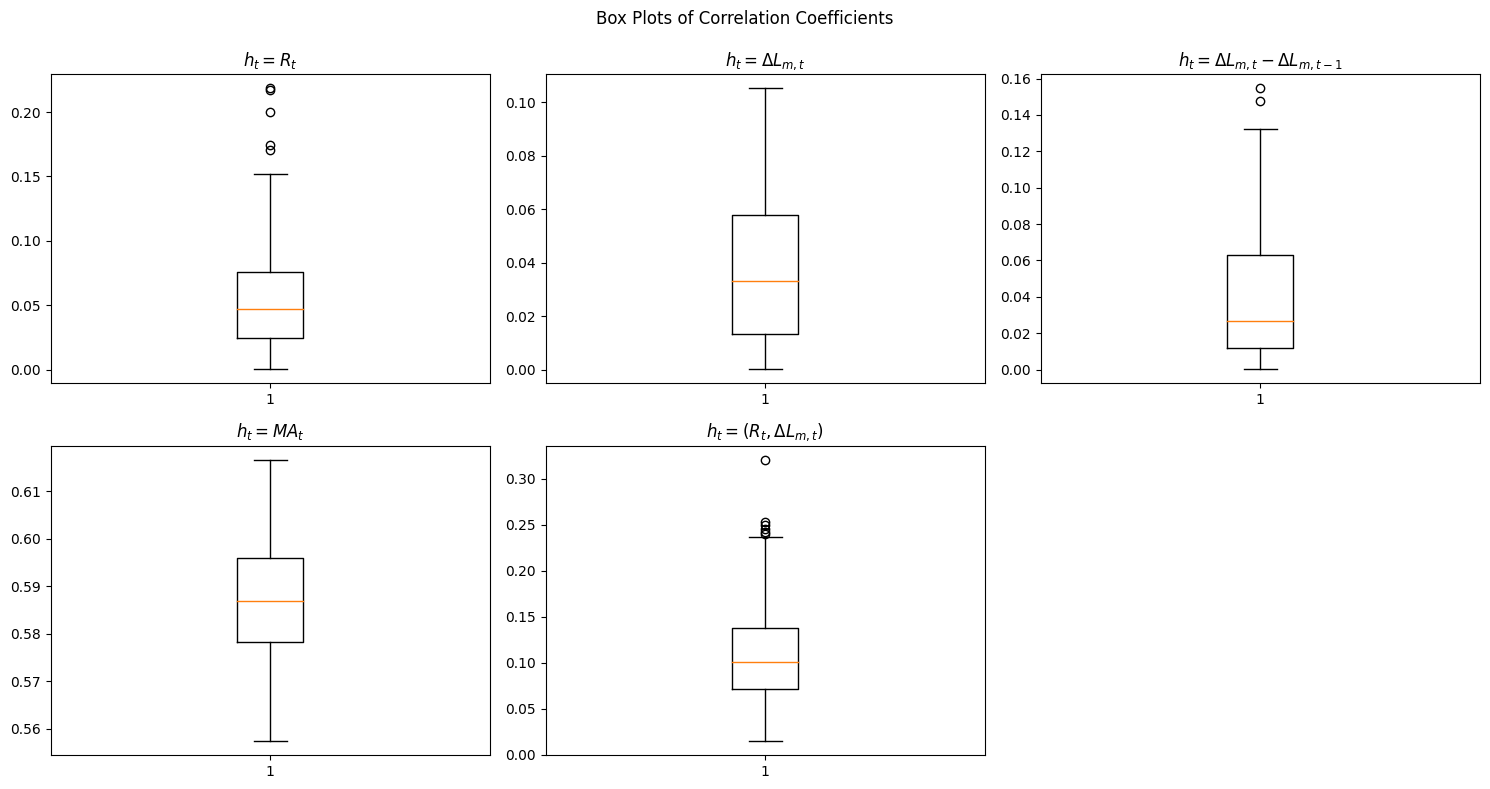

In [395]:

# Assuming you have calculated and stored the correlation coefficients in the arrays

# Create a figure and axis for the box plots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Box Plots of Correlation Coefficients')

# Plot GRU vs. BiLSTM
axes[0, 0].boxplot(corr_sim_BiLSTMvsLSTM_InterestRate)
axes[0, 0].set_title('$h_t= R_t$')

# Add box plots for other correlations
axes[0, 1].boxplot(corr_sim_BiLSTMvsLSTM_lossdifference)
axes[0, 1].set_title('$h_t=\Delta L_{m,t}$')

axes[0, 2].boxplot(corr_sim_BiLSTMvsLSTM_laggedlossdifference)
axes[0, 2].set_title('$h_t=\Delta L_{m,t}-\Delta L_{m,t-1}$')

axes[1, 0].boxplot(corr_sim_BiLSTMvsLSTM_MA)
axes[1, 0].set_title('$h_t=MA_t$')

axes[1, 1].boxplot(corr_sim_BiLSTMvsLSTM_combi_fin)
axes[1, 1].set_title('$h_t=(R_t,\Delta L_{m,t})$')

axes[1, 2].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the box plots
plt.show()


MAE

In [396]:
MAE_LSTMsim_gfbm=np.zeros(n_simulations)
MAE_GRUsim_gfbm=np.zeros(n_simulations)
MAE_BiLSTMsim_gfbm=np.zeros(n_simulations)
MAE_RNNsim_gfbm=np.zeros(n_simulations)

for i in range(n_simulations):
    test_predictor_Sim, test_target_Sim = dataset_generator_lstm(lag_transform(Sim_gfbm[i, :], 1).values, look_back=5)
    test_predictor_Sim_reshape = np.reshape(test_predictor_Sim, (test_predictor_Sim.shape[0], 5, 1))

    # LSTM
    mae=LSTM_model.evaluate(test_predictor_Sim_reshape,test_target_Sim,verbose=0)[0]
    MAE_LSTMsim_gfbm[i]=mae
        

    #GRU
    mae=GRU_model.evaluate(test_predictor_Sim_reshape,test_target_Sim,verbose=0)[0]
    MAE_GRUsim_gfbm[i]=mae

    #BiLSTM
    mae=BiLSTM_model.evaluate(test_predictor_Sim_reshape,test_target_Sim,verbose=0)[0]
    MAE_BiLSTMsim_gfbm[i]=mae

    #RNN
    mae=RNN_model.evaluate(test_predictor_Sim_reshape,test_target_Sim,verbose=0)[0]
    MAE_RNNsim_gfbm[i]=mae

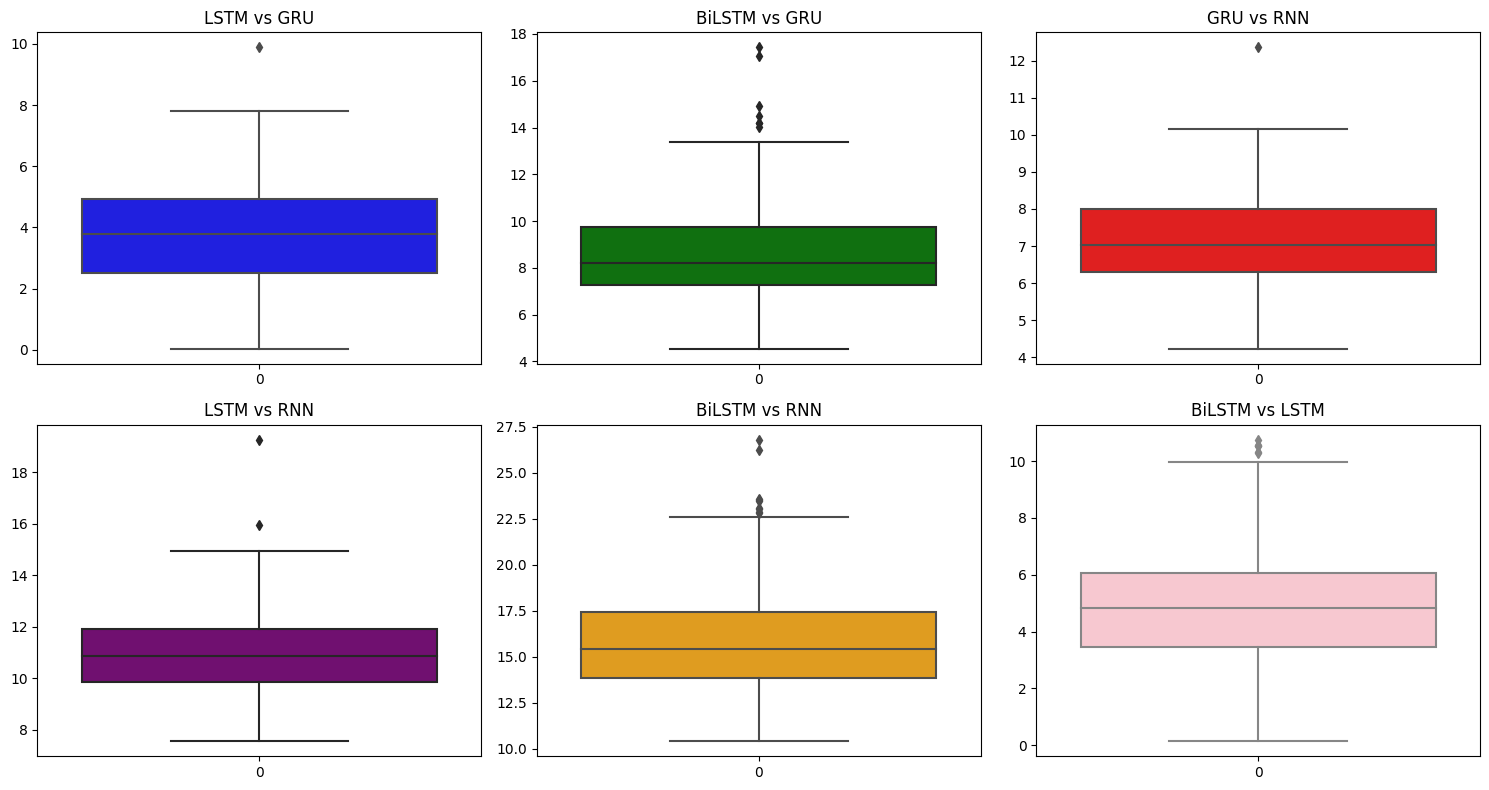

In [397]:


# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
#fig.suptitle('Absolute Mean Absolute Error (MAE) Differences Between Model Pairs')


# Plot the box plots for different comparisons on specific subplots
sns.boxplot(ax=axes[0, 0], data=abs(MAE_LSTMsim_gfbm-MAE_GRUsim_gfbm),color='blue')
sns.boxplot(ax=axes[0, 1], data=abs(MAE_BiLSTMsim_gfbm-MAE_GRUsim_gfbm),color='green')
sns.boxplot(ax=axes[0, 2], data=abs(MAE_GRUsim_gfbm-MAE_RNNsim_gfbm),color='red')
sns.boxplot(ax=axes[1, 0], data=abs(MAE_LSTMsim_gfbm-MAE_RNNsim_gfbm),color='purple')
sns.boxplot(ax=axes[1, 1], data=abs(MAE_BiLSTMsim_gfbm-MAE_RNNsim_gfbm),color='orange')
sns.boxplot(ax=axes[1, 2], data=abs(MAE_BiLSTMsim_gfbm-MAE_LSTMsim_gfbm),color='pink')

# Optionally, set titles for subplots
axes[0, 0].set_title('LSTM vs GRU')
axes[0, 1].set_title('BiLSTM vs GRU')
axes[0, 2].set_title('GRU vs RNN')
axes[1, 0].set_title('LSTM vs RNN')
axes[1, 1].set_title('BiLSTM vs RNN')
axes[1, 2].set_title('BiLSTM vs LSTM')

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()


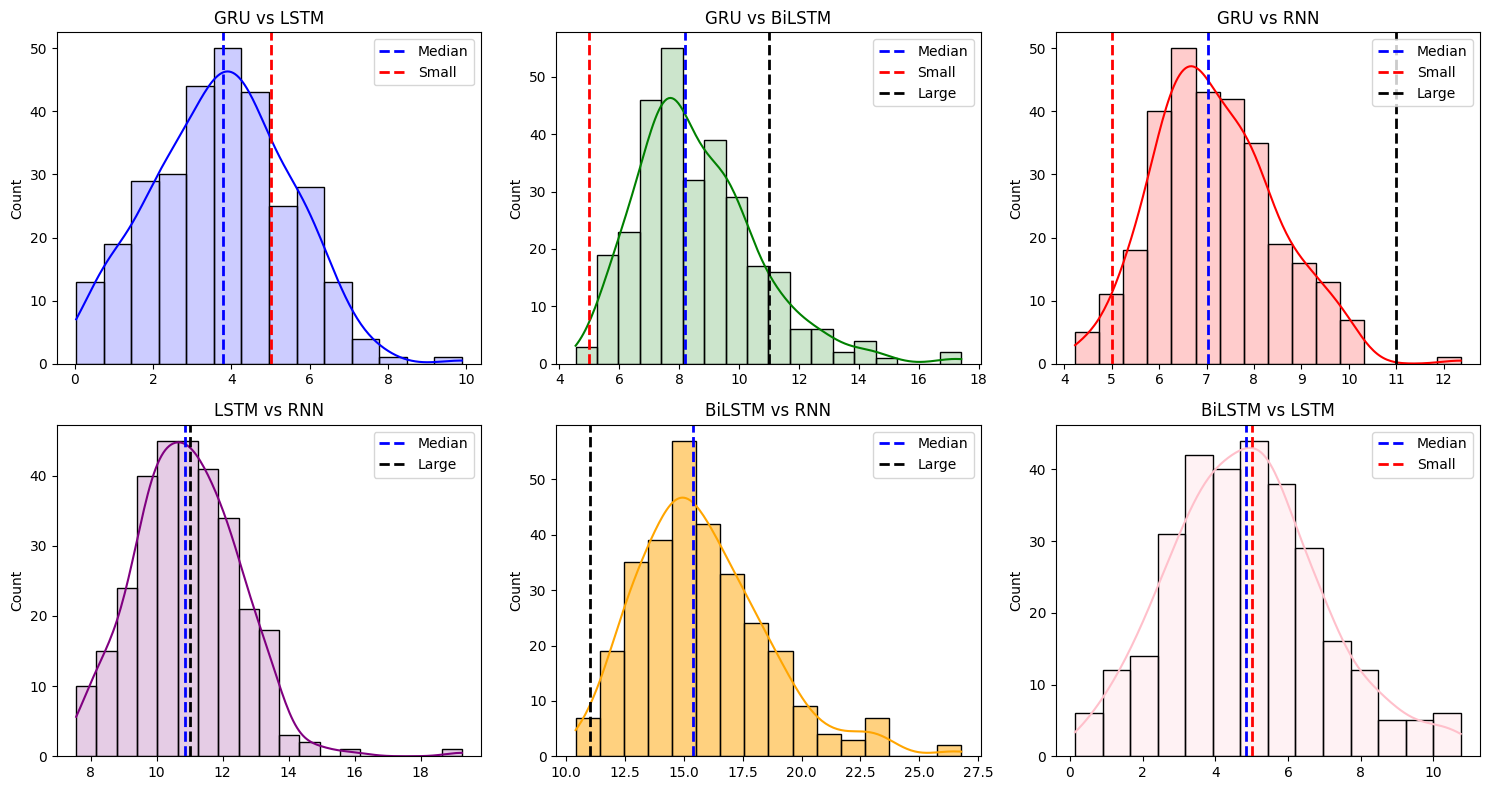

In [398]:


# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot the kernel density plots and histograms for different comparisons on specific subplots
sns.histplot(ax=axes[0, 0], data=abs(MAE_LSTMsim_gfbm-MAE_GRUsim_gfbm), color='blue', kde=True,alpha=0.2)
axes[0, 0].axvline(np.median(abs(MAE_LSTMsim_gfbm-MAE_GRUsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 0].axvline(5, color='red', linestyle='dashed', linewidth=2, label='Small')



sns.histplot(ax=axes[0, 1], data=abs(MAE_BiLSTMsim_gfbm-MAE_GRUsim_gfbm), color='green', kde=True,alpha=0.2)
axes[0, 1].axvline(np.median(abs(MAE_BiLSTMsim_gfbm-MAE_GRUsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 1].axvline(5, color='red', linestyle='dashed', linewidth=2, label='Small')
axes[0, 1].axvline(11, color='black', linestyle='dashed', linewidth=2, label='Large')


sns.histplot(ax=axes[0, 2], data=abs(MAE_GRUsim_gfbm-MAE_RNNsim_gfbm), color='red', kde=True,alpha=0.2)
axes[0, 2].axvline(np.median(abs(MAE_GRUsim_gfbm-MAE_RNNsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 2].axvline(5, color='red', linestyle='dashed', linewidth=2, label='Small')
axes[0, 2].axvline(11, color='black', linestyle='dashed', linewidth=2, label='Large')

sns.histplot(ax=axes[1, 0], data=abs(MAE_LSTMsim_gfbm-MAE_RNNsim_gfbm), color='purple', kde=True,alpha=0.2)
axes[1, 0].axvline(np.median(abs(MAE_LSTMsim_gfbm-MAE_RNNsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 0].axvline(11, color='black', linestyle='dashed', linewidth=2, label='Large')

sns.histplot(ax=axes[1, 1], data=abs(MAE_BiLSTMsim_gfbm-MAE_RNNsim_gfbm), color='orange', kde=True)
axes[1, 1].axvline(np.median(abs(MAE_BiLSTMsim_gfbm-MAE_RNNsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 1].axvline(11, color='black', linestyle='dashed', linewidth=2, label='Large')

sns.histplot(ax=axes[1, 2], data=abs(MAE_BiLSTMsim_gfbm-MAE_LSTMsim_gfbm), color='pink', kde=True,alpha=0.2)
axes[1, 2].axvline(np.median(abs(MAE_BiLSTMsim_gfbm-MAE_LSTMsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 2].axvline(5, color='red', linestyle='dashed', linewidth=2, label='Small')
# Optionally, set titles for subplots
axes[0, 0].set_title('GRU vs LSTM')
axes[0, 1].set_title('GRU vs BiLSTM')
axes[0, 2].set_title('GRU vs RNN')
axes[1, 0].set_title('LSTM vs RNN')
axes[1, 1].set_title('BiLSTM vs RNN')
axes[1, 2].set_title('BiLSTM vs LSTM')

# Add legend for the median lines
for ax in axes.flatten():
    ax.legend()

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()


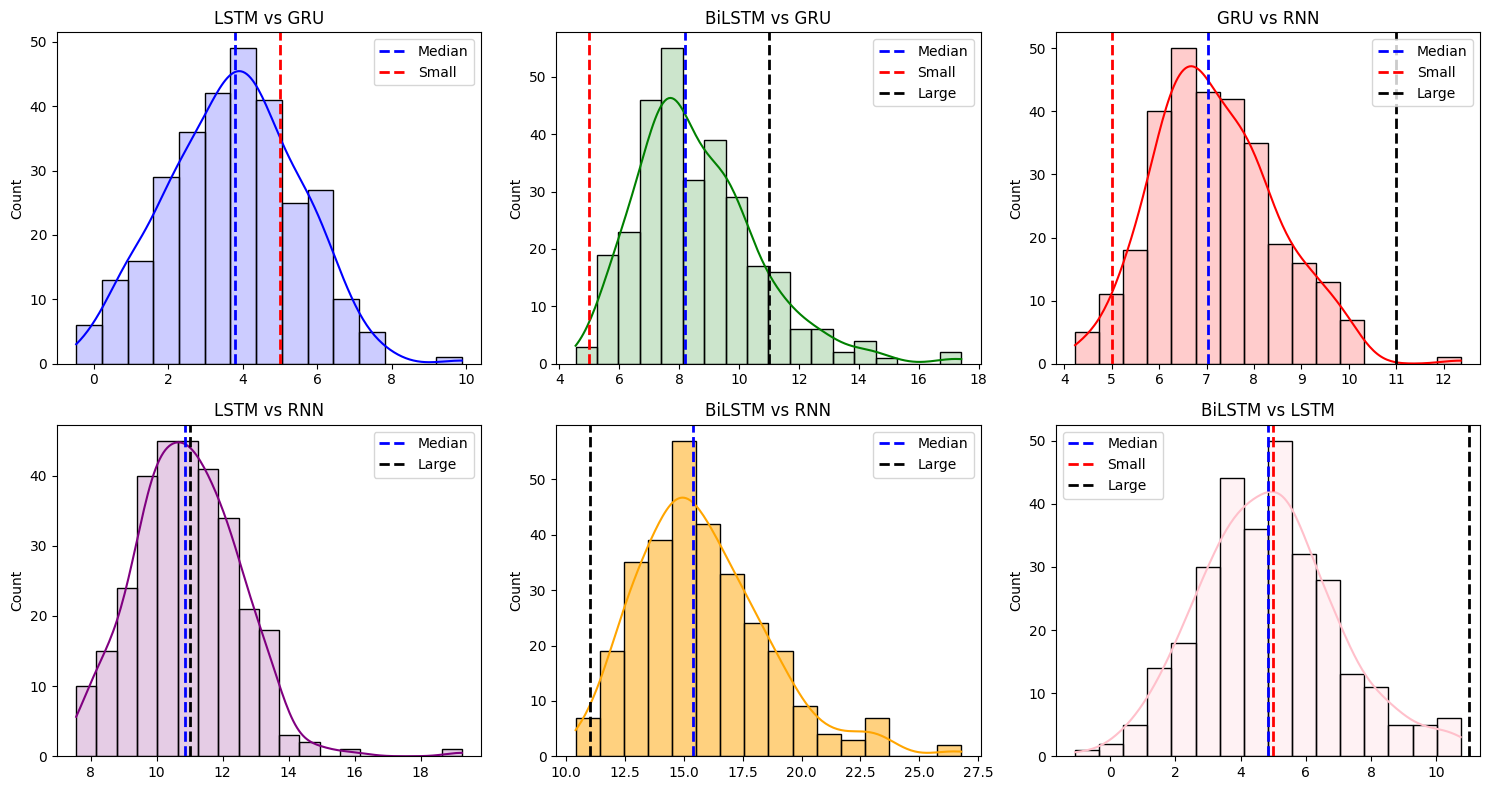

In [399]:


# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot the kernel density plots and histograms for different comparisons on specific subplots
sns.histplot(ax=axes[0, 0], data=(MAE_LSTMsim_gfbm-MAE_GRUsim_gfbm), color='blue', kde=True,alpha=0.2)
axes[0, 0].axvline(np.median((MAE_LSTMsim_gfbm-MAE_GRUsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 0].axvline(5, color='red', linestyle='dashed', linewidth=2, label='Small')



sns.histplot(ax=axes[0, 1], data=(MAE_BiLSTMsim_gfbm-MAE_GRUsim_gfbm), color='green', kde=True,alpha=0.2)
axes[0, 1].axvline(np.median((MAE_BiLSTMsim_gfbm-MAE_GRUsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 1].axvline(5, color='red', linestyle='dashed', linewidth=2, label='Small')
axes[0, 1].axvline(11, color='black', linestyle='dashed', linewidth=2, label='Large')


sns.histplot(ax=axes[0, 2], data=(MAE_GRUsim_gfbm-MAE_RNNsim_gfbm), color='red', kde=True,alpha=0.2)
axes[0, 2].axvline(np.median((MAE_GRUsim_gfbm-MAE_RNNsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[0, 2].axvline(5, color='red', linestyle='dashed', linewidth=2, label='Small')
axes[0, 2].axvline(11, color='black', linestyle='dashed', linewidth=2, label='Large')

sns.histplot(ax=axes[1, 0], data=(MAE_LSTMsim_gfbm-MAE_RNNsim_gfbm), color='purple', kde=True,alpha=0.2)
axes[1, 0].axvline(np.median((MAE_LSTMsim_gfbm-MAE_RNNsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 0].axvline(11, color='black', linestyle='dashed', linewidth=2, label='Large')

sns.histplot(ax=axes[1, 1], data=(MAE_BiLSTMsim_gfbm-MAE_RNNsim_gfbm), color='orange', kde=True)
axes[1, 1].axvline(np.median((MAE_BiLSTMsim_gfbm-MAE_RNNsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 1].axvline(11, color='black', linestyle='dashed', linewidth=2, label='Large')

sns.histplot(ax=axes[1, 2], data=(MAE_BiLSTMsim_gfbm-MAE_LSTMsim_gfbm), color='pink', kde=True,alpha=0.2)
axes[1, 2].axvline(np.median((MAE_BiLSTMsim_gfbm-MAE_LSTMsim_gfbm)), color='blue', linestyle='dashed', linewidth=2, label='Median')
axes[1, 2].axvline(5, color='red', linestyle='dashed', linewidth=2, label='Small')
axes[1, 2].axvline(11, color='black', linestyle='dashed', linewidth=2, label='Large')

# Optionally, set titles for subplots
axes[0, 0].set_title('LSTM vs GRU')
axes[0, 1].set_title('BiLSTM vs GRU')
axes[0, 2].set_title('GRU vs RNN')
axes[1, 0].set_title('LSTM vs RNN')
axes[1, 1].set_title('BiLSTM vs RNN')
axes[1, 2].set_title('BiLSTM vs LSTM')

# Add legend for the median lines
for ax in axes.flatten():
    ax.legend()

# Adjust layout
plt.tight_layout()
# Show the plots
plt.show()
